# Predicting Heart Disease

Link to Competittion: https://www.kaggle.com/competitions/playground-series-s6e2/overview

## Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (10, 5)

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc, accuracy_score, mean_squared_error, classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.tree import plot_tree

from common import *

In [2]:
from platform import python_version
print('python: ', python_version())
print('pandas: ', pd.__version__)
print('numpy: ', np.__version__)
import matplotlib
print('matplotlib: ', matplotlib.__version__)
print('seaborn: ', sns.__version__)
import sklearn
print('sklearn: ', sklearn.__version__)
print('xgboost: ', xgb.__version__)

python:  3.12.3
pandas:  2.3.3
numpy:  2.2.6
matplotlib:  3.10.8
seaborn:  0.13.2
sklearn:  1.8.0
xgboost:  3.1.3


## Load data

In [3]:
orig_train_df = pd.read_csv('archive/train.csv')
orig_test_df = pd.read_csv('archive/test.csv')

## Call the pipeline

In [4]:
train_df = (orig_train_df
          .pipe(copy_data)
          .pipe(clean_data)
          # .pipe(remove_outliers)
          # .pipe(remove_duplicates)
          .pipe(make_new_features)
          # .pipe(encode_all_the_things)
          # .pipe(fill_nas)
           )

In [5]:
test_df = (orig_test_df
          .pipe(copy_data)
          .pipe(clean_data)
          # .pipe(remove_outliers)
          # .pipe(remove_duplicates)
          .pipe(make_new_features)
          # .pipe(encode_all_the_things)
          # .pipe(fill_nas)
           )

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   age                      630000 non-null  int64  
 1   sex                      630000 non-null  int64  
 2   chest_pain_type          630000 non-null  int64  
 3   bp                       630000 non-null  int64  
 4   cholesterol              630000 non-null  int64  
 5   fbs_over_120             630000 non-null  int64  
 6   ekg_results              630000 non-null  int64  
 7   max_hr                   630000 non-null  int64  
 8   exercise_angina          630000 non-null  int64  
 9   st_depression            630000 non-null  float64
 10  slope_of_st              630000 non-null  int64  
 11  number_of_vessels_fluro  630000 non-null  int64  
 12  thallium                 630000 non-null  int64  
 13  heart_disease            630000 non-null  int64  
dtypes: f

## Create some new features

In [7]:
features = get_features(train_df)

In [8]:
# Pairwise generation was too much, need to scale back
# for f1 in features:
#     for f2 in features:
#         if f1 != f2:
#             train_df[f"{f1}_x_{f2}"] = train_df[f1] * train_df[f2]
#             train_df[f"{f1}_/_{f2}"] = train_df[f1] / (train_df[f2] + 0.0001)

#             test_df[f"{f1}_x_{f2}"] = test_df[f1] * test_df[f2]
#             test_df[f"{f1}_/_{f2}"] = test_df[f1] / (test_df[f2] + 0.0001)

# top 20 features by importance
# ['max_hr_/_thallium',
 # 'chest_pain_type_x_slope_of_st',
 # 'sex_x_chest_pain_type',
 # 'chest_pain_type_x_thallium',
 # 'sex_x_slope_of_st',
 # 'st_depression_x_slope_of_st',
 # 'slope_of_st_x_number_of_vessels_fluro',
 # 'max_hr_/_number_of_vessels_fluro',
 # 'chest_pain_type_x_number_of_vessels_fluro',
 # 'chest_pain_type_/_max_hr',
 # 'sex_x_exercise_angina',
 # 'max_hr_/_chest_pain_type',
 # 'max_hr_/_exercise_angina',
 # 'exercise_angina_x_slope_of_st',
 # 'slope_of_st_x_thallium',
 # 'number_of_vessels_fluro_x_thallium',
 # 'age_x_number_of_vessels_fluro',
 # 'sex_/_max_hr',
 # 'age_x_sex',
 # 'thallium_/_max_hr']

In [9]:
def create_some_new_features(passed_df):
    tmp_df = passed_df.copy()
    tmp_df['max_hr_/_thallium'] = tmp_df['max_hr'] / tmp_df['thallium'] + 0.0001
    tmp_df['chest_pain_type_x_slope_of_st'] = tmp_df['chest_pain_type'] * tmp_df['slope_of_st']
    tmp_df['sex_x_chest_pain_type'] = tmp_df['sex'] * tmp_df['chest_pain_type']

    tmp_df['bp_sq'] = tmp_df['bp'] ** 2
    tmp_df['bp_rt'] = np.sqrt(tmp_df['bp'])

    tmp_df['max_hr_sq'] = tmp_df['max_hr'] ** 2
    tmp_df['max_hr_rt'] = np.sqrt(tmp_df['max_hr'])

    tmp_df['cholesterol_sq'] = tmp_df['cholesterol'] ** 2
    tmp_df['cholesterol_rt'] = np.sqrt(tmp_df['cholesterol'])

    tmp_df['st_depression_x_chest_pain_type'] = tmp_df['st_depression'] * tmp_df['chest_pain_type'] 
    # tmp_df['st_depression_x_max_hr'] = tmp_df['st_depression'] * tmp_df['max_hr']
    tmp_df['st_depression_x_age'] = tmp_df['st_depression'] * tmp_df['age']

    # tmp_df['st_depression_/_chest_pain_type'] = tmp_df['st_depression'] / (tmp_df['chest_pain_type']+ 0.0001)
    tmp_df['st_depression_/_max_hr'] = tmp_df['st_depression'] / (tmp_df['max_hr']+ 0.0001)
    # tmp_df['st_depression_/_age'] = tmp_df['st_depression'] / (tmp_df['age']+ 0.0001)

    return tmp_df

In [10]:
train_df = create_some_new_features(train_df)
test_df = create_some_new_features(test_df)

## Choose target and features

In [11]:
target = get_target()

In [12]:
features = get_features(train_df)

In [13]:
categorical_features = []

In [14]:
numerical_features = [f for f in features if f not in categorical_features]

In [15]:
categorical_features

[]

In [16]:
numerical_features

['age',
 'sex',
 'chest_pain_type',
 'bp',
 'cholesterol',
 'fbs_over_120',
 'ekg_results',
 'max_hr',
 'exercise_angina',
 'st_depression',
 'slope_of_st',
 'number_of_vessels_fluro',
 'thallium',
 'max_hr_/_thallium',
 'chest_pain_type_x_slope_of_st',
 'sex_x_chest_pain_type',
 'bp_sq',
 'bp_rt',
 'max_hr_sq',
 'max_hr_rt',
 'cholesterol_sq',
 'cholesterol_rt',
 'st_depression_x_chest_pain_type',
 'st_depression_x_age',
 'st_depression_/_max_hr']

In [17]:
train_df

,age,sex,chest_pain_type,bp,cholesterol,fbs_over_120,ekg_results,max_hr,exercise_angina,st_depression,slope_of_st,number_of_vessels_fluro,thallium,heart_disease,max_hr_/_thallium,chest_pain_type_x_slope_of_st,sex_x_chest_pain_type,bp_sq,bp_rt,max_hr_sq,max_hr_rt,cholesterol_sq,cholesterol_rt,st_depression_x_chest_pain_type,st_depression_x_age,st_depression_/_max_hr
0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,1,22.571529,8,4,23104,12.328828,24964,12.569805,57121,15.459625,14.4,208.8,0.022785
1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,0,57.000100,1,1,15625,11.180340,29241,13.076697,105625,18.027756,0.0,0.0,0.000000
2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,0,50.333433,2,0,25600,12.649111,22801,12.288206,35344,13.711309,0.0,0.0,0.000000
3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,0,50.000100,6,0,17956,11.575837,22500,12.247449,52441,15.132746,3.0,44.0,0.006667
4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,1,41.666767,8,4,19600,11.832160,15625,11.180340,54756,15.297059,15.2,220.4,0.030400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629995,56,0,1,110,226,0,0,132,0,0.0,1,0,7,0,18.857243,1,0,12100,10.488088,17424,11.489125,51076,15.033296,0.0,0.0,0.000000
629996,54,1,4,128,249,1,2,150,0,0.0,2,0,3,0,50.000100,8,4,16384,11.313708,22500,12.247449,62001,15.779734,0.0,0.0,0.000000
629997,67,1,4,130,275,0,0,149,0,0.0,1,2,7,1,21.285814,4,4,16900,11.401754,22201,12.206556,75625,16.583124,0.0,0.0,0.000000
629998,52,1,4,140,199,0,2,157,0,0.0,1,0,6,1,26.166767,4,4,19600,11.832160,24649,12.529964,39601,14.106736,0.0,0.0,0.000000


## Encoding

In [18]:
X_train = train_df[features].copy()
y_train = train_df[target]

X_test = test_df[features].copy()

In [19]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

## XGBoost

In [20]:
# this is from randomseachCV but turned our worse than defaults
# best_params = {
#     'subsample': 0.9, 
#     'reg_lambda': 2.0, 
#     'reg_alpha': 0.01, 
#     'n_estimators': 1000, 
#     'min_child_weight': 2, 
#     'max_depth': 2, 
#     'learning_rate': 0.3, 
#     'gamma': 0.01, 
#     'colsample_bytree': 0.8
# }

best_params = {
    'n_estimators': 2000
}

In [21]:
xgb_model = XGBClassifier(
    early_stopping_rounds=50, 
    device='cuda', 
    random_state=123,
    **best_params)

In [22]:
xgb = xgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=100)

[0]	validation_0-logloss:0.52811
[100]	validation_0-logloss:0.26892
[117]	validation_0-logloss:0.26906


In [23]:
n_best = xgb_model.best_iteration

In [24]:
n_best

67

In [25]:
preds = xgb_model.predict_proba(X_train)[:,1]

In [26]:
final_xgb_model = XGBClassifier(n_estimators=n_best, device='cuda', random_state=123)

In [27]:
_ = final_xgb_model.fit(X_train, y_train)

In [28]:
xgb_scores = cross_val_score(
    final_xgb_model, 
    X_train, 
    y_train, 
    cv=10, 
    scoring='roc_auc'
)

In [29]:
print(f"ROC AUC: {roc_auc_score(y_train, preds):.5f}")

ROC AUC: 0.95700


In [30]:
importance_df = pd.DataFrame({'Features': features, 'Importance': xgb_model.feature_importances_})

In [31]:
importance_df.sort_values(by='Importance', ascending=False)[:30]['Features'].tolist()

['max_hr_/_thallium',
 'sex_x_chest_pain_type',
 'chest_pain_type_x_slope_of_st',
 'number_of_vessels_fluro',
 'exercise_angina',
 'sex',
 'slope_of_st',
 'chest_pain_type',
 'ekg_results',
 'st_depression_x_chest_pain_type',
 'st_depression_x_age',
 'st_depression_/_max_hr',
 'max_hr',
 'age',
 'st_depression',
 'cholesterol',
 'thallium',
 'bp',
 'fbs_over_120',
 'bp_sq',
 'bp_rt',
 'cholesterol_sq',
 'max_hr_rt',
 'max_hr_sq',
 'cholesterol_rt']

<Axes: xlabel='Importance', ylabel='Features'>

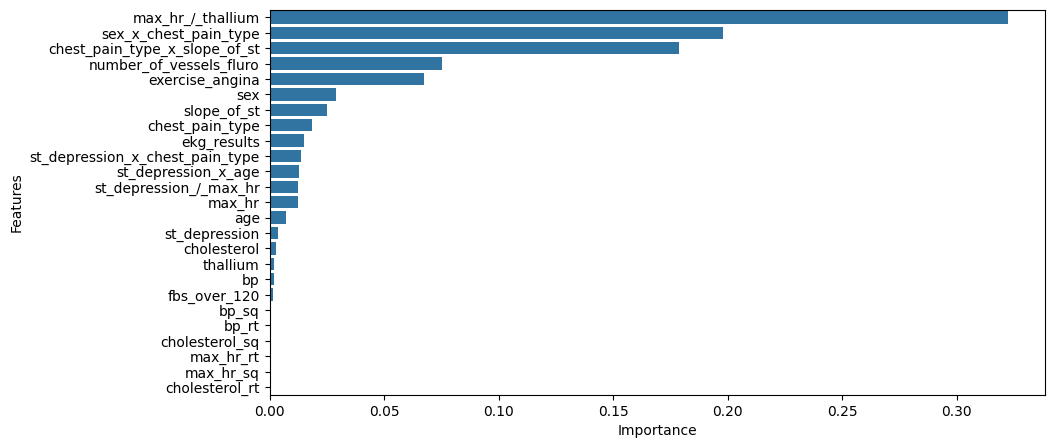

In [32]:
sns.barplot(data=importance_df.sort_values(by='Importance', ascending=False)[:30], y='Features', x='Importance')

## Random Hyperparameter Search

In [33]:
# param_distributions = {
#     'n_estimators': [750, 1000, 1500, 2000],
#     'max_depth': [1, 2, 3],
#     'learning_rate': [0.15, 0.2, 0.25, 0.3],
#     'subsample': [0.9, 0.95, 1.0],
#     'colsample_bytree': [0.7, 0.75, 0.8, 0.85],
#     'min_child_weight': [1, 2],
#     'gamma': [0, 0.01],
#     'reg_alpha': [0, 0.01, 0.05],
#     'reg_lambda': [1.5, 2.0, 2.5, 3.0],
# }

In [34]:
# random_search = RandomizedSearchCV(
#     XGBClassifier(device='cuda', random_state=123),
#     param_distributions=param_distributions,
#     n_iter=50,
#     scoring='roc_auc',
#     cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=123),
#     random_state=123,
#     n_jobs=-1,
#     verbose=1,
# )

# random_search.fit(X_train, y_train)

In [35]:
# print(f"Best ROC AUC: {random_search.best_score_:.5f}")
# print(f"Best params: {random_search.best_params_}")

In [36]:
# results_df = pd.DataFrame(random_search.cv_results_).sort_values('rank_test_score')
# results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].head(10)

## Optuna Hyperparameter Search

In [37]:
import optuna

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 3000),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'device': 'cuda',
        'random_state': 123,
    }

    model = XGBClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=123), scoring='roc_auc')
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000, show_progress_bar=True)

[I 2026-02-08 10:51:02,180] A new study created in memory with name: no-name-582535a5-0b24-4eff-80ef-f938b8713867
Best trial: 0. Best value: 0.95514:   0%|                                                                      | 1/1000 [00:43<11:56:11, 43.01s/it]

[I 2026-02-08 10:51:45,195] Trial 0 finished with value: 0.9551396104797341 and parameters: {'n_estimators': 2765, 'max_depth': 6, 'learning_rate': 0.04247921112133015, 'subsample': 0.9406446347410686, 'colsample_bytree': 0.6455076177017993, 'min_child_weight': 4, 'gamma': 3.9503116149441926, 'reg_alpha': 0.3216856031088089, 'reg_lambda': 0.0032216878176317054}. Best is trial 0 with value: 0.9551396104797341.


Best trial: 0. Best value: 0.95514:   0%|▏                                                                     | 2/1000 [02:26<21:46:14, 78.53s/it]

[I 2026-02-08 10:53:28,588] Trial 1 finished with value: 0.953040843274976 and parameters: {'n_estimators': 1831, 'max_depth': 8, 'learning_rate': 0.0014108449247168709, 'subsample': 0.9273107378992322, 'colsample_bytree': 0.7768898886023012, 'min_child_weight': 5, 'gamma': 4.186444182198163, 'reg_alpha': 6.166246830269911, 'reg_lambda': 0.04314237983803572}. Best is trial 0 with value: 0.9551396104797341.


Best trial: 0. Best value: 0.95514:   0%|▏                                                                     | 3/1000 [02:39<13:30:15, 48.76s/it]

[I 2026-02-08 10:53:41,925] Trial 2 finished with value: 0.9426583173249916 and parameters: {'n_estimators': 572, 'max_depth': 3, 'learning_rate': 0.0024246135399123184, 'subsample': 0.7692431930664785, 'colsample_bytree': 0.9352496615762995, 'min_child_weight': 8, 'gamma': 2.647624248438128, 'reg_alpha': 0.19360105687724816, 'reg_lambda': 8.486905390915043}. Best is trial 0 with value: 0.9551396104797341.


Best trial: 0. Best value: 0.95514:   0%|▎                                                                     | 4/1000 [03:14<11:55:06, 43.08s/it]

[I 2026-02-08 10:54:16,290] Trial 3 finished with value: 0.9545334854927179 and parameters: {'n_estimators': 344, 'max_depth': 10, 'learning_rate': 0.030931383429937235, 'subsample': 0.9166800666025199, 'colsample_bytree': 0.9390380962608921, 'min_child_weight': 7, 'gamma': 0.21194592852184613, 'reg_alpha': 0.9746452201790787, 'reg_lambda': 0.01094699386042261}. Best is trial 0 with value: 0.9551396104797341.


Best trial: 4. Best value: 0.955365:   0%|▎                                                                    | 5/1000 [03:43<10:34:11, 38.24s/it]

[I 2026-02-08 10:54:45,958] Trial 4 finished with value: 0.9553651555544083 and parameters: {'n_estimators': 1353, 'max_depth': 4, 'learning_rate': 0.02965257062219001, 'subsample': 0.6471166170611191, 'colsample_bytree': 0.69954581197423, 'min_child_weight': 3, 'gamma': 0.29716749060073044, 'reg_alpha': 0.018636796522147038, 'reg_lambda': 0.014732023404125421}. Best is trial 4 with value: 0.9553651555544083.


Best trial: 4. Best value: 0.955365:   1%|▍                                                                    | 6/1000 [05:22<16:13:39, 58.77s/it]

[I 2026-02-08 10:56:24,583] Trial 5 finished with value: 0.9550050120480241 and parameters: {'n_estimators': 1533, 'max_depth': 9, 'learning_rate': 0.00868213452761626, 'subsample': 0.6484669322422749, 'colsample_bytree': 0.6327309461795905, 'min_child_weight': 7, 'gamma': 0.6392661886866663, 'reg_alpha': 1.0554911286831494, 'reg_lambda': 0.014490591324403371}. Best is trial 4 with value: 0.9553651555544083.


Best trial: 4. Best value: 0.955365:   1%|▍                                                                    | 7/1000 [05:52<13:36:31, 49.34s/it]

[I 2026-02-08 10:56:54,493] Trial 6 finished with value: 0.9551930208349871 and parameters: {'n_estimators': 2128, 'max_depth': 4, 'learning_rate': 0.14526603018385045, 'subsample': 0.9412565945485558, 'colsample_bytree': 0.8431806975589029, 'min_child_weight': 5, 'gamma': 2.696022803433128, 'reg_alpha': 0.006330693076080793, 'reg_lambda': 8.4264922623303}. Best is trial 4 with value: 0.9553651555544083.


Best trial: 4. Best value: 0.955365:   1%|▌                                                                    | 8/1000 [06:55<14:48:39, 53.75s/it]

[I 2026-02-08 10:57:57,691] Trial 7 finished with value: 0.9544718479839727 and parameters: {'n_estimators': 2411, 'max_depth': 6, 'learning_rate': 0.05377424487301041, 'subsample': 0.6544177934283101, 'colsample_bytree': 0.8492792819426676, 'min_child_weight': 6, 'gamma': 1.8957361902197962, 'reg_alpha': 0.057959586735020927, 'reg_lambda': 0.012301130708422727}. Best is trial 4 with value: 0.9553651555544083.


Best trial: 4. Best value: 0.955365:   1%|▌                                                                    | 9/1000 [07:37<13:45:46, 50.00s/it]

[I 2026-02-08 10:58:39,435] Trial 8 finished with value: 0.9551660594590364 and parameters: {'n_estimators': 2011, 'max_depth': 4, 'learning_rate': 0.014759985869799363, 'subsample': 0.8947688006184724, 'colsample_bytree': 0.9013549540939545, 'min_child_weight': 6, 'gamma': 3.4009481545288898, 'reg_alpha': 0.572033901456354, 'reg_lambda': 1.8143658013563158}. Best is trial 4 with value: 0.9553651555544083.


Best trial: 4. Best value: 0.955365:   1%|▋                                                                   | 10/1000 [08:34<14:23:35, 52.34s/it]

[I 2026-02-08 10:59:37,020] Trial 9 finished with value: 0.9542950115992792 and parameters: {'n_estimators': 1319, 'max_depth': 7, 'learning_rate': 0.004904354837015661, 'subsample': 0.8358352960341027, 'colsample_bytree': 0.709549108168522, 'min_child_weight': 1, 'gamma': 3.496293028341439, 'reg_alpha': 0.509980883962355, 'reg_lambda': 0.008209379940181775}. Best is trial 4 with value: 0.9553651555544083.


Best trial: 4. Best value: 0.955365:   1%|▋                                                                   | 11/1000 [08:51<11:24:17, 41.51s/it]

[I 2026-02-08 10:59:53,991] Trial 10 finished with value: 0.9553547957135053 and parameters: {'n_estimators': 980, 'max_depth': 2, 'learning_rate': 0.2852986886789194, 'subsample': 0.7335158422217707, 'colsample_bytree': 0.733329130138581, 'min_child_weight': 2, 'gamma': 1.3142754662429468, 'reg_alpha': 0.001796322442006647, 'reg_lambda': 0.3425188852384403}. Best is trial 4 with value: 0.9553651555544083.


Best trial: 4. Best value: 0.955365:   1%|▊                                                                    | 12/1000 [09:08<9:18:22, 33.91s/it]

[I 2026-02-08 11:00:10,505] Trial 11 finished with value: 0.9553539943825076 and parameters: {'n_estimators': 949, 'max_depth': 2, 'learning_rate': 0.2467141856255191, 'subsample': 0.7346418090805739, 'colsample_bytree': 0.7382916317529236, 'min_child_weight': 2, 'gamma': 1.2332687078116111, 'reg_alpha': 0.0016945657770553212, 'reg_lambda': 0.4744985064499497}. Best is trial 4 with value: 0.9553651555544083.


Best trial: 4. Best value: 0.955365:   1%|▉                                                                    | 13/1000 [09:25<7:55:02, 28.88s/it]

[I 2026-02-08 11:00:27,807] Trial 12 finished with value: 0.9551730133518935 and parameters: {'n_estimators': 992, 'max_depth': 2, 'learning_rate': 0.07828143706489794, 'subsample': 0.6023238941984504, 'colsample_bytree': 0.6956011990025309, 'min_child_weight': 3, 'gamma': 1.2877180372771375, 'reg_alpha': 0.019203620423440405, 'reg_lambda': 0.19096221494967486}. Best is trial 4 with value: 0.9553651555544083.


Best trial: 4. Best value: 0.955365:   1%|▉                                                                    | 14/1000 [09:46<7:15:40, 26.51s/it]

[I 2026-02-08 11:00:48,851] Trial 13 finished with value: 0.9550479370679469 and parameters: {'n_estimators': 928, 'max_depth': 4, 'learning_rate': 0.1268396540592748, 'subsample': 0.7089186114634488, 'colsample_bytree': 0.7856418661255865, 'min_child_weight': 1, 'gamma': 0.12357245496484204, 'reg_alpha': 0.0010397100736237548, 'reg_lambda': 0.0012001448418951497}. Best is trial 4 with value: 0.9553651555544083.


Best trial: 4. Best value: 0.955365:   2%|█                                                                    | 15/1000 [10:19<7:47:26, 28.47s/it]

[I 2026-02-08 11:01:21,871] Trial 14 finished with value: 0.953179961503239 and parameters: {'n_estimators': 1454, 'max_depth': 5, 'learning_rate': 0.2710114096578251, 'subsample': 0.8180887495170235, 'colsample_bytree': 0.6063519461136649, 'min_child_weight': 10, 'gamma': 1.169986200592, 'reg_alpha': 0.006706247462449414, 'reg_lambda': 0.09429365033663292}. Best is trial 4 with value: 0.9553651555544083.


Best trial: 4. Best value: 0.955365:   2%|█                                                                    | 16/1000 [10:32<6:31:43, 23.89s/it]

[I 2026-02-08 11:01:35,101] Trial 15 finished with value: 0.9540286443079532 and parameters: {'n_estimators': 577, 'max_depth': 3, 'learning_rate': 0.019605801284585497, 'subsample': 0.6901293937766468, 'colsample_bytree': 0.7095554113764354, 'min_child_weight': 3, 'gamma': 1.8517361532208134, 'reg_alpha': 0.03075997052362226, 'reg_lambda': 0.5418278287901774}. Best is trial 4 with value: 0.9553651555544083.


Best trial: 4. Best value: 0.955365:   2%|█▏                                                                   | 17/1000 [10:36<4:51:59, 17.82s/it]

[I 2026-02-08 11:01:38,823] Trial 16 finished with value: 0.9268277438036607 and parameters: {'n_estimators': 75, 'max_depth': 2, 'learning_rate': 0.004210335640248869, 'subsample': 0.6027730759661031, 'colsample_bytree': 0.6691919184818064, 'min_child_weight': 3, 'gamma': 0.708468844097772, 'reg_alpha': 0.00529661983650164, 'reg_lambda': 0.049322557474605275}. Best is trial 4 with value: 0.9553651555544083.


Best trial: 4. Best value: 0.955365:   2%|█▏                                                                   | 18/1000 [11:00<5:22:28, 19.70s/it]

[I 2026-02-08 11:02:02,903] Trial 17 finished with value: 0.954742827480557 and parameters: {'n_estimators': 1205, 'max_depth': 3, 'learning_rate': 0.01910006455151913, 'subsample': 0.7456439871696464, 'colsample_bytree': 0.9919878447665901, 'min_child_weight': 2, 'gamma': 4.955343555412635, 'reg_alpha': 0.014548778620676312, 'reg_lambda': 1.5038303924435215}. Best is trial 4 with value: 0.9553651555544083.


Best trial: 4. Best value: 0.955365:   2%|█▎                                                                   | 19/1000 [11:27<5:57:24, 21.86s/it]

[I 2026-02-08 11:02:29,789] Trial 18 finished with value: 0.9551353179665549 and parameters: {'n_estimators': 1811, 'max_depth': 5, 'learning_rate': 0.1218469925863759, 'subsample': 0.9937803673691936, 'colsample_bytree': 0.7597746752675663, 'min_child_weight': 4, 'gamma': 1.9568336793699255, 'reg_alpha': 0.0021634539479431134, 'reg_lambda': 0.22638808205475444}. Best is trial 4 with value: 0.9553651555544083.


Best trial: 4. Best value: 0.955365:   2%|█▍                                                                   | 20/1000 [11:44<5:32:45, 20.37s/it]

[I 2026-02-08 11:02:46,694] Trial 19 finished with value: 0.955158677538094 and parameters: {'n_estimators': 606, 'max_depth': 5, 'learning_rate': 0.07962991545935118, 'subsample': 0.6657789730403763, 'colsample_bytree': 0.8037400447443239, 'min_child_weight': 2, 'gamma': 0.5976574863422143, 'reg_alpha': 0.0806743201961622, 'reg_lambda': 0.035761640372312234}. Best is trial 4 with value: 0.9553651555544083.


Best trial: 4. Best value: 0.955365:   2%|█▍                                                                   | 21/1000 [12:17<6:34:08, 24.16s/it]

[I 2026-02-08 11:03:19,671] Trial 20 finished with value: 0.9541639654809844 and parameters: {'n_estimators': 1649, 'max_depth': 3, 'learning_rate': 0.007919218477183179, 'subsample': 0.7826434422131551, 'colsample_bytree': 0.7421185829399937, 'min_child_weight': 4, 'gamma': 0.010590395644812345, 'reg_alpha': 0.003574023955975332, 'reg_lambda': 0.0021873118333966745}. Best is trial 4 with value: 0.9553651555544083.


Best trial: 21. Best value: 0.955365:   2%|█▍                                                                  | 22/1000 [12:35<6:02:07, 22.22s/it]

[I 2026-02-08 11:03:37,364] Trial 21 finished with value: 0.9553653259909783 and parameters: {'n_estimators': 1028, 'max_depth': 2, 'learning_rate': 0.264467396972748, 'subsample': 0.7260384315578114, 'colsample_bytree': 0.7136972295429148, 'min_child_weight': 2, 'gamma': 1.2995591566785014, 'reg_alpha': 0.012332063311696864, 'reg_lambda': 0.8987584030575096}. Best is trial 21 with value: 0.9553653259909783.


Best trial: 22. Best value: 0.955421:   2%|█▌                                                                  | 23/1000 [12:55<5:52:01, 21.62s/it]

[I 2026-02-08 11:03:57,588] Trial 22 finished with value: 0.9554211718401946 and parameters: {'n_estimators': 1200, 'max_depth': 2, 'learning_rate': 0.1868509631985566, 'subsample': 0.7146870815540981, 'colsample_bytree': 0.6894075946091691, 'min_child_weight': 1, 'gamma': 1.5692226231138964, 'reg_alpha': 0.013793618743190782, 'reg_lambda': 2.0703974104883467}. Best is trial 22 with value: 0.9554211718401946.


Best trial: 22. Best value: 0.955421:   2%|█▋                                                                  | 24/1000 [13:18<5:59:14, 22.08s/it]

[I 2026-02-08 11:04:20,761] Trial 23 finished with value: 0.9549637226680281 and parameters: {'n_estimators': 1158, 'max_depth': 4, 'learning_rate': 0.18154806780097887, 'subsample': 0.6931717377591132, 'colsample_bytree': 0.6743853062802262, 'min_child_weight': 1, 'gamma': 2.215581648072283, 'reg_alpha': 0.015599867947597322, 'reg_lambda': 2.359328283801729}. Best is trial 22 with value: 0.9554211718401946.


Best trial: 22. Best value: 0.955421:   2%|█▋                                                                  | 25/1000 [13:33<5:23:33, 19.91s/it]

[I 2026-02-08 11:04:35,603] Trial 24 finished with value: 0.9553286751563264 and parameters: {'n_estimators': 711, 'max_depth': 3, 'learning_rate': 0.08207813277565296, 'subsample': 0.6325351320881638, 'colsample_bytree': 0.6578195222819812, 'min_child_weight': 1, 'gamma': 0.8633697149158488, 'reg_alpha': 0.03569228619540053, 'reg_lambda': 2.921030519350807}. Best is trial 22 with value: 0.9554211718401946.


Best trial: 22. Best value: 0.955421:   3%|█▊                                                                  | 26/1000 [13:56<5:36:16, 20.71s/it]

[I 2026-02-08 11:04:58,191] Trial 25 finished with value: 0.9547314121045677 and parameters: {'n_estimators': 1344, 'max_depth': 2, 'learning_rate': 0.030934067287836785, 'subsample': 0.7091844592666465, 'colsample_bytree': 0.612346514661392, 'min_child_weight': 3, 'gamma': 1.6214436684398352, 'reg_alpha': 0.15563069848152636, 'reg_lambda': 0.9214688350036911}. Best is trial 22 with value: 0.9554211718401946.


Best trial: 22. Best value: 0.955421:   3%|█▊                                                                  | 27/1000 [14:25<6:17:08, 23.26s/it]

[I 2026-02-08 11:05:27,376] Trial 26 finished with value: 0.9551659211499143 and parameters: {'n_estimators': 1640, 'max_depth': 3, 'learning_rate': 0.18285131786644576, 'subsample': 0.6750230387477976, 'colsample_bytree': 0.6895263939151258, 'min_child_weight': 2, 'gamma': 2.2557879240936947, 'reg_alpha': 0.011515083172000423, 'reg_lambda': 4.269545929706306}. Best is trial 22 with value: 0.9554211718401946.


Best trial: 22. Best value: 0.955421:   3%|█▉                                                                  | 28/1000 [14:44<5:55:36, 21.95s/it]

[I 2026-02-08 11:05:46,283] Trial 27 finished with value: 0.955317152968979 and parameters: {'n_estimators': 806, 'max_depth': 4, 'learning_rate': 0.048076208105933216, 'subsample': 0.8453331691534052, 'colsample_bytree': 0.8248201971870527, 'min_child_weight': 1, 'gamma': 0.8807179958320983, 'reg_alpha': 0.04219964814462181, 'reg_lambda': 0.7751115725223005}. Best is trial 22 with value: 0.9554211718401946.


Best trial: 22. Best value: 0.955421:   3%|█▉                                                                  | 29/1000 [14:51<4:44:24, 17.57s/it]

[I 2026-02-08 11:05:53,646] Trial 28 finished with value: 0.954293594995894 and parameters: {'n_estimators': 305, 'max_depth': 2, 'learning_rate': 0.08685186607064486, 'subsample': 0.6277030101456886, 'colsample_bytree': 0.719726325805776, 'min_child_weight': 4, 'gamma': 0.43965171372848993, 'reg_alpha': 0.009311900574044433, 'reg_lambda': 0.11711595388105953}. Best is trial 22 with value: 0.9554211718401946.


Best trial: 22. Best value: 0.955421:   3%|██                                                                  | 30/1000 [16:01<8:58:08, 33.29s/it]

[I 2026-02-08 11:07:03,596] Trial 29 finished with value: 0.9549369189159647 and parameters: {'n_estimators': 2877, 'max_depth': 6, 'learning_rate': 0.03506999216381989, 'subsample': 0.7575142995060629, 'colsample_bytree': 0.6370302062124595, 'min_child_weight': 4, 'gamma': 1.5766993642078293, 'reg_alpha': 0.02328885368344641, 'reg_lambda': 1.147160732863287}. Best is trial 22 with value: 0.9554211718401946.


Best trial: 22. Best value: 0.955421:   3%|██                                                                 | 31/1000 [17:02<11:11:34, 41.58s/it]

[I 2026-02-08 11:08:04,535] Trial 30 finished with value: 0.9511757001809344 and parameters: {'n_estimators': 2472, 'max_depth': 5, 'learning_rate': 0.21655775568019592, 'subsample': 0.7136146987678643, 'colsample_bytree': 0.7642347942244943, 'min_child_weight': 3, 'gamma': 0.9687982984266226, 'reg_alpha': 0.003449471074068192, 'reg_lambda': 0.0037479267740290665}. Best is trial 22 with value: 0.9554211718401946.


Best trial: 22. Best value: 0.955421:   3%|██▏                                                                 | 32/1000 [17:21<9:23:41, 34.94s/it]

[I 2026-02-08 11:08:23,974] Trial 31 finished with value: 0.9553600284230279 and parameters: {'n_estimators': 1154, 'max_depth': 2, 'learning_rate': 0.284260274895345, 'subsample': 0.7929156505169715, 'colsample_bytree': 0.7360432940643523, 'min_child_weight': 2, 'gamma': 1.4683654658820124, 'reg_alpha': 0.002683540209186199, 'reg_lambda': 0.30558204727246596}. Best is trial 22 with value: 0.9554211718401946.


Best trial: 22. Best value: 0.955421:   3%|██▏                                                                 | 33/1000 [17:41<8:07:17, 30.24s/it]

[I 2026-02-08 11:08:43,233] Trial 32 finished with value: 0.9552909164008441 and parameters: {'n_estimators': 1190, 'max_depth': 2, 'learning_rate': 0.12647666129372356, 'subsample': 0.7892302069653192, 'colsample_bytree': 0.6793867865261987, 'min_child_weight': 2, 'gamma': 3.0912303111276707, 'reg_alpha': 0.0031849848451034604, 'reg_lambda': 0.2677172201102505}. Best is trial 22 with value: 0.9554211718401946.


Best trial: 22. Best value: 0.955421:   3%|██▎                                                                 | 34/1000 [18:02<7:22:27, 27.48s/it]

[I 2026-02-08 11:09:04,290] Trial 33 finished with value: 0.9553114087381195 and parameters: {'n_estimators': 1132, 'max_depth': 3, 'learning_rate': 0.16769686952750593, 'subsample': 0.8046104526072748, 'colsample_bytree': 0.7500698115063571, 'min_child_weight': 1, 'gamma': 1.6177749541426227, 'reg_alpha': 0.008906619222577525, 'reg_lambda': 3.679047608594778}. Best is trial 22 with value: 0.9554211718401946.


Best trial: 22. Best value: 0.955421:   4%|██▎                                                                | 35/1000 [19:07<10:23:10, 38.75s/it]

[I 2026-02-08 11:10:09,320] Trial 34 finished with value: 0.9522676608139129 and parameters: {'n_estimators': 1421, 'max_depth': 7, 'learning_rate': 0.0012928963027047994, 'subsample': 0.7689368037792672, 'colsample_bytree': 0.7936024848404223, 'min_child_weight': 5, 'gamma': 2.472797366839978, 'reg_alpha': 0.1077164623065004, 'reg_lambda': 0.030108125796238425}. Best is trial 22 with value: 0.9554211718401946.


Best trial: 35. Best value: 0.955432:   4%|██▍                                                                 | 36/1000 [19:35<9:32:27, 35.63s/it]

[I 2026-02-08 11:10:37,678] Trial 35 finished with value: 0.9554317680595051 and parameters: {'n_estimators': 1733, 'max_depth': 2, 'learning_rate': 0.2857413279919292, 'subsample': 0.8597827527691982, 'colsample_bytree': 0.6542913097026656, 'min_child_weight': 2, 'gamma': 0.36906646252046615, 'reg_alpha': 3.60260192029881, 'reg_lambda': 0.0827115915166398}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 35. Best value: 0.955432:   4%|██▌                                                                 | 37/1000 [20:12<9:38:51, 36.07s/it]

[I 2026-02-08 11:11:14,760] Trial 36 finished with value: 0.95027350920879 and parameters: {'n_estimators': 1819, 'max_depth': 3, 'learning_rate': 0.0018943945058553008, 'subsample': 0.8583332271577926, 'colsample_bytree': 0.6433652619433562, 'min_child_weight': 9, 'gamma': 0.3716536115971327, 'reg_alpha': 7.374010481109252, 'reg_lambda': 0.074642066691495}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 35. Best value: 0.955432:   4%|██▌                                                                | 38/1000 [23:00<20:10:27, 75.50s/it]

[I 2026-02-08 11:14:02,263] Trial 37 finished with value: 0.9505647378377677 and parameters: {'n_estimators': 2130, 'max_depth': 10, 'learning_rate': 0.061300908718286806, 'subsample': 0.8808869472012186, 'colsample_bytree': 0.6590259974782087, 'min_child_weight': 3, 'gamma': 0.26416833570038056, 'reg_alpha': 2.7009484698865514, 'reg_lambda': 6.119916650164276}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 35. Best value: 0.955432:   4%|██▌                                                                | 39/1000 [24:15<20:10:01, 75.55s/it]

[I 2026-02-08 11:15:17,931] Trial 38 finished with value: 0.951593597733434 and parameters: {'n_estimators': 1622, 'max_depth': 9, 'learning_rate': 0.10608668556741659, 'subsample': 0.6458301388883336, 'colsample_bytree': 0.6270741471456677, 'min_child_weight': 1, 'gamma': 1.047828906440416, 'reg_alpha': 3.6544979473548374, 'reg_lambda': 0.005211052076633638}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 35. Best value: 0.955432:   4%|██▋                                                                | 40/1000 [25:00<17:40:52, 66.31s/it]

[I 2026-02-08 11:16:02,669] Trial 39 finished with value: 0.9551307930232188 and parameters: {'n_estimators': 2014, 'max_depth': 4, 'learning_rate': 0.011461306698111382, 'subsample': 0.9469866011184505, 'colsample_bytree': 0.6958209596210962, 'min_child_weight': 7, 'gamma': 0.5600090486576097, 'reg_alpha': 0.2285122981334784, 'reg_lambda': 0.017401696868709977}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 35. Best value: 0.955432:   4%|██▋                                                                | 41/1000 [25:42<15:42:43, 58.98s/it]

[I 2026-02-08 11:16:44,561] Trial 40 finished with value: 0.9549803425521866 and parameters: {'n_estimators': 2275, 'max_depth': 3, 'learning_rate': 0.1860845813528447, 'subsample': 0.8182744158511446, 'colsample_bytree': 0.6548639337614878, 'min_child_weight': 5, 'gamma': 0.7193386123692235, 'reg_alpha': 1.0875503950077563, 'reg_lambda': 0.0195826108078723}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 35. Best value: 0.955432:   4%|██▊                                                                | 42/1000 [26:02<12:37:40, 47.45s/it]

[I 2026-02-08 11:17:05,118] Trial 41 finished with value: 0.9554014443208549 and parameters: {'n_estimators': 1298, 'max_depth': 2, 'learning_rate': 0.25036066771922433, 'subsample': 0.8798417945013487, 'colsample_bytree': 0.7143494413659074, 'min_child_weight': 2, 'gamma': 1.491856923543819, 'reg_alpha': 0.006007314823448932, 'reg_lambda': 0.1397557800513121}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 35. Best value: 0.955432:   4%|██▉                                                                | 43/1000 [26:25<10:37:35, 39.97s/it]

[I 2026-02-08 11:17:27,642] Trial 42 finished with value: 0.9552510652264476 and parameters: {'n_estimators': 1556, 'max_depth': 2, 'learning_rate': 0.23325843113835135, 'subsample': 0.8949440825186086, 'colsample_bytree': 0.7184505581481537, 'min_child_weight': 2, 'gamma': 2.81182762968429, 'reg_alpha': 0.05863624084789561, 'reg_lambda': 0.14637402444531733}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 35. Best value: 0.955432:   4%|██▉                                                                 | 44/1000 [26:46<9:05:01, 34.21s/it]

[I 2026-02-08 11:17:48,388] Trial 43 finished with value: 0.9553912692019775 and parameters: {'n_estimators': 1303, 'max_depth': 2, 'learning_rate': 0.1558444399772675, 'subsample': 0.8588043364910019, 'colsample_bytree': 0.6852652470722197, 'min_child_weight': 3, 'gamma': 1.8805324121195768, 'reg_alpha': 0.02105553167571717, 'reg_lambda': 0.05420421632564973}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 35. Best value: 0.955432:   4%|███                                                                 | 45/1000 [27:00<7:28:32, 28.18s/it]

[I 2026-02-08 11:18:02,510] Trial 44 finished with value: 0.9552873689158805 and parameters: {'n_estimators': 812, 'max_depth': 2, 'learning_rate': 0.15160201614626323, 'subsample': 0.8704165416320185, 'colsample_bytree': 0.621459641461442, 'min_child_weight': 2, 'gamma': 2.1043537155795846, 'reg_alpha': 0.006273478265947391, 'reg_lambda': 0.06521225800572474}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 35. Best value: 0.955432:   5%|███▏                                                                | 46/1000 [27:25<7:15:06, 27.37s/it]

[I 2026-02-08 11:18:27,971] Trial 45 finished with value: 0.9553666117837109 and parameters: {'n_estimators': 1747, 'max_depth': 2, 'learning_rate': 0.20752710328736382, 'subsample': 0.9155607248748431, 'colsample_bytree': 0.6748505859970513, 'min_child_weight': 1, 'gamma': 1.7391997739533618, 'reg_alpha': 0.02349327631332484, 'reg_lambda': 0.41259935626069105}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 35. Best value: 0.955432:   5%|███▏                                                                | 47/1000 [27:52<7:10:57, 27.13s/it]

[I 2026-02-08 11:18:54,561] Trial 46 finished with value: 0.9553636362079155 and parameters: {'n_estimators': 1716, 'max_depth': 3, 'learning_rate': 0.10889385658594163, 'subsample': 0.9104084304038673, 'colsample_bytree': 0.8827917706768632, 'min_child_weight': 1, 'gamma': 1.906515889687934, 'reg_alpha': 0.024465412461360924, 'reg_lambda': 0.15948721898595167}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 35. Best value: 0.955432:   5%|███▎                                                                | 48/1000 [28:19<7:12:25, 27.25s/it]

[I 2026-02-08 11:19:22,099] Trial 47 finished with value: 0.955210977753349 and parameters: {'n_estimators': 1978, 'max_depth': 2, 'learning_rate': 0.22096510353793203, 'subsample': 0.9284116312513007, 'colsample_bytree': 0.6832185728109867, 'min_child_weight': 1, 'gamma': 2.456809027623653, 'reg_alpha': 0.06177833810137907, 'reg_lambda': 0.4977087331200725}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 35. Best value: 0.955432:   5%|███▎                                                                | 49/1000 [28:43<6:54:23, 26.14s/it]

[I 2026-02-08 11:19:45,654] Trial 48 finished with value: 0.9551989464823818 and parameters: {'n_estimators': 1479, 'max_depth': 2, 'learning_rate': 0.06754543138932537, 'subsample': 0.9558922025570464, 'colsample_bytree': 0.6402702198641734, 'min_child_weight': 3, 'gamma': 1.6993691099888162, 'reg_alpha': 0.4864018062357622, 'reg_lambda': 0.05841115362820184}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 35. Best value: 0.955432:   5%|███▍                                                                | 50/1000 [29:10<6:56:02, 26.28s/it]

[I 2026-02-08 11:20:12,240] Trial 49 finished with value: 0.9550341703038188 and parameters: {'n_estimators': 1946, 'max_depth': 3, 'learning_rate': 0.29577351125855683, 'subsample': 0.9703209500586856, 'colsample_bytree': 0.6712906374740485, 'min_child_weight': 1, 'gamma': 2.9392916968165688, 'reg_alpha': 0.004516113332334765, 'reg_lambda': 0.027049677702610766}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 35. Best value: 0.955432:   5%|███▍                                                                | 51/1000 [29:31<6:34:44, 24.96s/it]

[I 2026-02-08 11:20:34,118] Trial 50 finished with value: 0.9548947119203538 and parameters: {'n_estimators': 1279, 'max_depth': 7, 'learning_rate': 0.13775811465395124, 'subsample': 0.9031084310318892, 'colsample_bytree': 0.7705398834248638, 'min_child_weight': 2, 'gamma': 2.306035743081197, 'reg_alpha': 0.04205254132242145, 'reg_lambda': 0.08735862744947087}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 35. Best value: 0.955432:   5%|███▌                                                                | 52/1000 [29:49<5:58:07, 22.67s/it]

[I 2026-02-08 11:20:51,438] Trial 51 finished with value: 0.9554059145574918 and parameters: {'n_estimators': 1028, 'max_depth': 2, 'learning_rate': 0.19436327954044158, 'subsample': 0.878033084098152, 'colsample_bytree': 0.7195141795464434, 'min_child_weight': 2, 'gamma': 1.3852777682017416, 'reg_alpha': 0.009842428470158215, 'reg_lambda': 0.6609015288629604}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 35. Best value: 0.955432:   5%|███▌                                                                | 53/1000 [30:11<5:54:56, 22.49s/it]

[I 2026-02-08 11:21:13,514] Trial 52 finished with value: 0.955394339408525 and parameters: {'n_estimators': 1399, 'max_depth': 2, 'learning_rate': 0.21611396408541905, 'subsample': 0.8805908096536164, 'colsample_bytree': 0.6997934970369013, 'min_child_weight': 2, 'gamma': 1.4151396909713045, 'reg_alpha': 0.008467585701996362, 'reg_lambda': 0.37550694906543164}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 35. Best value: 0.955432:   5%|███▋                                                                | 54/1000 [30:33<5:50:41, 22.24s/it]

[I 2026-02-08 11:21:35,182] Trial 53 finished with value: 0.9554074262771441 and parameters: {'n_estimators': 1337, 'max_depth': 2, 'learning_rate': 0.14983105507644767, 'subsample': 0.8792046107689324, 'colsample_bytree': 0.7235044151091348, 'min_child_weight': 3, 'gamma': 1.427025042789332, 'reg_alpha': 0.008483834410775826, 'reg_lambda': 0.6784254375953471}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 35. Best value: 0.955432:   6%|███▋                                                                | 55/1000 [30:58<6:06:48, 23.29s/it]

[I 2026-02-08 11:22:00,913] Trial 54 finished with value: 0.9554008885006626 and parameters: {'n_estimators': 1474, 'max_depth': 3, 'learning_rate': 0.09232530268353743, 'subsample': 0.880236112165567, 'colsample_bytree': 0.7246838290988222, 'min_child_weight': 2, 'gamma': 1.419859680174966, 'reg_alpha': 0.008107746015994902, 'reg_lambda': 0.6687098676717362}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 35. Best value: 0.955432:   6%|███▊                                                                | 56/1000 [31:18<5:52:06, 22.38s/it]

[I 2026-02-08 11:22:21,171] Trial 55 finished with value: 0.955406384738566 and parameters: {'n_estimators': 1049, 'max_depth': 3, 'learning_rate': 0.09285740149549293, 'subsample': 0.8258530618562507, 'colsample_bytree': 0.7288134887733452, 'min_child_weight': 3, 'gamma': 1.1389183575239945, 'reg_alpha': 0.004809535520193198, 'reg_lambda': 1.5860277111826193}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 35. Best value: 0.955432:   6%|███▉                                                                | 57/1000 [31:36<5:30:29, 21.03s/it]

[I 2026-02-08 11:22:39,046] Trial 56 finished with value: 0.9553866884671223 and parameters: {'n_estimators': 1049, 'max_depth': 2, 'learning_rate': 0.15229952996024743, 'subsample': 0.8321537539432589, 'colsample_bytree': 0.7483041083605771, 'min_child_weight': 4, 'gamma': 1.1535766822002889, 'reg_alpha': 0.0013499727899324303, 'reg_lambda': 1.6951503034410853}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 35. Best value: 0.955432:   6%|███▉                                                                | 58/1000 [31:55<5:17:03, 20.19s/it]

[I 2026-02-08 11:22:57,295] Trial 57 finished with value: 0.9553898752240144 and parameters: {'n_estimators': 926, 'max_depth': 3, 'learning_rate': 0.10156616310672738, 'subsample': 0.8407673557830202, 'colsample_bytree': 0.8075304037902837, 'min_child_weight': 6, 'gamma': 0.8026788505937537, 'reg_alpha': 0.0054382398127934845, 'reg_lambda': 2.204597257384223}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 35. Best value: 0.955432:   6%|████                                                                | 59/1000 [32:14<5:12:51, 19.95s/it]

[I 2026-02-08 11:23:16,671] Trial 58 finished with value: 0.9553769466671813 and parameters: {'n_estimators': 847, 'max_depth': 4, 'learning_rate': 0.06674263040352922, 'subsample': 0.8229619060806405, 'colsample_bytree': 0.7033303355344105, 'min_child_weight': 3, 'gamma': 1.0656604343157707, 'reg_alpha': 0.0018454458496776477, 'reg_lambda': 6.77696872775844}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 35. Best value: 0.955432:   6%|████                                                                | 60/1000 [32:23<4:21:55, 16.72s/it]

[I 2026-02-08 11:23:25,852] Trial 59 finished with value: 0.9550999075767812 and parameters: {'n_estimators': 423, 'max_depth': 3, 'learning_rate': 0.12397472901386027, 'subsample': 0.8538014999482946, 'colsample_bytree': 0.7814293453004721, 'min_child_weight': 4, 'gamma': 4.184734787512134, 'reg_alpha': 0.004704200776663761, 'reg_lambda': 1.4446375950048722}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 35. Best value: 0.955432:   6%|████▏                                                               | 61/1000 [32:36<4:01:50, 15.45s/it]

[I 2026-02-08 11:23:38,353] Trial 60 finished with value: 0.9552970373271172 and parameters: {'n_estimators': 687, 'max_depth': 2, 'learning_rate': 0.2504781111410782, 'subsample': 0.8059078622383136, 'colsample_bytree': 0.7238321826697602, 'min_child_weight': 3, 'gamma': 2.0269970125578665, 'reg_alpha': 0.013291648378176863, 'reg_lambda': 1.294481728139752}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 35. Best value: 0.955432:   6%|████▏                                                               | 62/1000 [33:04<5:01:48, 19.31s/it]

[I 2026-02-08 11:24:06,646] Trial 61 finished with value: 0.9553943515010491 and parameters: {'n_estimators': 1521, 'max_depth': 3, 'learning_rate': 0.043789500869955165, 'subsample': 0.873681006746418, 'colsample_bytree': 0.7304712940132394, 'min_child_weight': 2, 'gamma': 1.4253316384631176, 'reg_alpha': 0.002501422784671086, 'reg_lambda': 0.589143989579884}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 35. Best value: 0.955432:   6%|████▎                                                               | 63/1000 [33:27<5:17:12, 20.31s/it]

[I 2026-02-08 11:24:29,306] Trial 62 finished with value: 0.9553947577457628 and parameters: {'n_estimators': 1244, 'max_depth': 3, 'learning_rate': 0.09758424477970941, 'subsample': 0.889836206709035, 'colsample_bytree': 0.7521219291099452, 'min_child_weight': 2, 'gamma': 1.2303520199725817, 'reg_alpha': 0.008810350203156136, 'reg_lambda': 0.6613881329962321}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 35. Best value: 0.955432:   6%|████▎                                                               | 64/1000 [33:45<5:05:47, 19.60s/it]

[I 2026-02-08 11:24:47,252] Trial 63 finished with value: 0.9554015354077977 and parameters: {'n_estimators': 1069, 'max_depth': 2, 'learning_rate': 0.17659108058837333, 'subsample': 0.8617189327239365, 'colsample_bytree': 0.710410834802426, 'min_child_weight': 3, 'gamma': 1.4705930608105369, 'reg_alpha': 0.007103406920860746, 'reg_lambda': 0.9007453633237962}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 35. Best value: 0.955432:   6%|████▍                                                               | 65/1000 [34:02<4:56:08, 19.00s/it]

[I 2026-02-08 11:25:04,860] Trial 64 finished with value: 0.9553893992539741 and parameters: {'n_estimators': 1064, 'max_depth': 2, 'learning_rate': 0.18591043365491908, 'subsample': 0.8596414152795863, 'colsample_bytree': 0.7060635605579023, 'min_child_weight': 3, 'gamma': 1.7658794331984549, 'reg_alpha': 0.015134262456366877, 'reg_lambda': 1.0917973598095592}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 35. Best value: 0.955432:   7%|████▍                                                               | 66/1000 [34:18<4:38:41, 17.90s/it]

[I 2026-02-08 11:25:20,197] Trial 65 finished with value: 0.9553980988355578 and parameters: {'n_estimators': 875, 'max_depth': 2, 'learning_rate': 0.29049607626682167, 'subsample': 0.9280939690042276, 'colsample_bytree': 0.6587713431004896, 'min_child_weight': 3, 'gamma': 0.4852100999168171, 'reg_alpha': 0.0044005058578420915, 'reg_lambda': 3.210687335565098}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 35. Best value: 0.955432:   7%|████▌                                                               | 67/1000 [34:36<4:40:41, 18.05s/it]

[I 2026-02-08 11:25:38,593] Trial 66 finished with value: 0.9554067608970538 and parameters: {'n_estimators': 1091, 'max_depth': 2, 'learning_rate': 0.18443787238639933, 'subsample': 0.8484760169147775, 'colsample_bytree': 0.7116623089256336, 'min_child_weight': 4, 'gamma': 1.0055635574867985, 'reg_alpha': 0.007166858752079772, 'reg_lambda': 0.2100531910314383}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 35. Best value: 0.955432:   7%|████▌                                                               | 68/1000 [34:54<4:40:41, 18.07s/it]

[I 2026-02-08 11:25:56,708] Trial 67 finished with value: 0.9553896902847562 and parameters: {'n_estimators': 1063, 'max_depth': 2, 'learning_rate': 0.137294834000318, 'subsample': 0.8289222019493709, 'colsample_bytree': 0.6919793226230039, 'min_child_weight': 4, 'gamma': 0.1416300477970056, 'reg_alpha': 0.0011837431127003923, 'reg_lambda': 2.3792558918642976}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 35. Best value: 0.955432:   7%|████▋                                                               | 69/1000 [35:08<4:20:49, 16.81s/it]

[I 2026-02-08 11:26:10,573] Trial 68 finished with value: 0.9305444520160551 and parameters: {'n_estimators': 717, 'max_depth': 2, 'learning_rate': 0.001030919154392247, 'subsample': 0.8476782207142746, 'colsample_bytree': 0.6020563364784428, 'min_child_weight': 5, 'gamma': 4.866499571080227, 'reg_alpha': 1.4853884696995487, 'reg_lambda': 0.9119294946093981}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 35. Best value: 0.955432:   7%|████▊                                                               | 70/1000 [35:38<5:22:36, 20.81s/it]

[I 2026-02-08 11:26:40,731] Trial 69 finished with value: 0.9523634134310646 and parameters: {'n_estimators': 951, 'max_depth': 8, 'learning_rate': 0.18116184930736806, 'subsample': 0.8671233969362981, 'colsample_bytree': 0.7380384338255725, 'min_child_weight': 4, 'gamma': 0.943585631299862, 'reg_alpha': 0.011724749800772658, 'reg_lambda': 0.2811724964975402}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 35. Best value: 0.955432:   7%|████▊                                                               | 71/1000 [35:59<5:23:25, 20.89s/it]

[I 2026-02-08 11:27:01,795] Trial 70 finished with value: 0.9553517899111308 and parameters: {'n_estimators': 1094, 'max_depth': 3, 'learning_rate': 0.12098896325578967, 'subsample': 0.8100256220630144, 'colsample_bytree': 0.7630404720062105, 'min_child_weight': 3, 'gamma': 0.6413225236908797, 'reg_alpha': 0.0033315042848359204, 'reg_lambda': 0.20893178754117012}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 35. Best value: 0.955432:   7%|████▉                                                               | 72/1000 [36:18<5:15:59, 20.43s/it]

[I 2026-02-08 11:27:21,155] Trial 71 finished with value: 0.9553956986213871 and parameters: {'n_estimators': 1223, 'max_depth': 2, 'learning_rate': 0.23553858695267663, 'subsample': 0.8980709496920259, 'colsample_bytree': 0.7131544809088342, 'min_child_weight': 3, 'gamma': 1.5218583399337282, 'reg_alpha': 0.006652015530686215, 'reg_lambda': 0.11356556769250904}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 35. Best value: 0.955432:   7%|████▉                                                               | 73/1000 [36:41<5:25:21, 21.06s/it]

[I 2026-02-08 11:27:43,681] Trial 72 finished with value: 0.955413040205474 and parameters: {'n_estimators': 1369, 'max_depth': 2, 'learning_rate': 0.19298136204383504, 'subsample': 0.8353686950850907, 'colsample_bytree': 0.9813663816748359, 'min_child_weight': 2, 'gamma': 1.1727014368752675, 'reg_alpha': 0.017789537694274344, 'reg_lambda': 0.15837159664039357}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 35. Best value: 0.955432:   7%|█████                                                               | 74/1000 [36:58<5:07:41, 19.94s/it]

[I 2026-02-08 11:28:00,998] Trial 73 finished with value: 0.9541415077452982 and parameters: {'n_estimators': 984, 'max_depth': 2, 'learning_rate': 0.023404220321357288, 'subsample': 0.8414898825768101, 'colsample_bytree': 0.9819895539945899, 'min_child_weight': 3, 'gamma': 1.1247161545664235, 'reg_alpha': 0.010730942469985506, 'reg_lambda': 1.9913938858654499}. Best is trial 35 with value: 0.9554317680595051.


Best trial: 74. Best value: 0.955434:   8%|█████                                                               | 75/1000 [37:21<5:18:32, 20.66s/it]

[I 2026-02-08 11:28:23,355] Trial 74 finished with value: 0.9554338924204728 and parameters: {'n_estimators': 1368, 'max_depth': 2, 'learning_rate': 0.19862704605822715, 'subsample': 0.8275218847160689, 'colsample_bytree': 0.9587055844256028, 'min_child_weight': 4, 'gamma': 1.314343092531702, 'reg_alpha': 0.01699233413125113, 'reg_lambda': 1.0492481667869593}. Best is trial 74 with value: 0.9554338924204728.


Best trial: 74. Best value: 0.955434:   8%|█████▏                                                              | 76/1000 [37:48<5:50:37, 22.77s/it]

[I 2026-02-08 11:28:51,035] Trial 75 finished with value: 0.9533225577166842 and parameters: {'n_estimators': 1353, 'max_depth': 3, 'learning_rate': 0.005285461150062285, 'subsample': 0.7938914343504178, 'colsample_bytree': 0.9588293636742248, 'min_child_weight': 5, 'gamma': 1.3330189655544096, 'reg_alpha': 0.01684535982441407, 'reg_lambda': 5.3089656041509325}. Best is trial 74 with value: 0.9554338924204728.


Best trial: 74. Best value: 0.955434:   8%|█████▏                                                              | 77/1000 [38:14<6:01:39, 23.51s/it]

[I 2026-02-08 11:29:16,277] Trial 76 finished with value: 0.9554100985269727 and parameters: {'n_estimators': 1557, 'max_depth': 2, 'learning_rate': 0.19421228968391213, 'subsample': 0.8157491004658782, 'colsample_bytree': 0.9476812199010161, 'min_child_weight': 4, 'gamma': 0.9850143501582636, 'reg_alpha': 0.10276437353988789, 'reg_lambda': 0.21494099829586322}. Best is trial 74 with value: 0.9554338924204728.


Best trial: 74. Best value: 0.955434:   8%|█████▎                                                              | 78/1000 [38:39<6:11:23, 24.17s/it]

[I 2026-02-08 11:29:41,981] Trial 77 finished with value: 0.9554337727013298 and parameters: {'n_estimators': 1584, 'max_depth': 2, 'learning_rate': 0.15749937535412264, 'subsample': 0.818157982400366, 'colsample_bytree': 0.9534380851758001, 'min_child_weight': 4, 'gamma': 0.822355222990271, 'reg_alpha': 0.02813090291944271, 'reg_lambda': 0.04129614515632533}. Best is trial 74 with value: 0.9554338924204728.


Best trial: 78. Best value: 0.955438:   8%|█████▎                                                              | 79/1000 [39:05<6:17:21, 24.58s/it]

[I 2026-02-08 11:30:07,535] Trial 78 finished with value: 0.955437842103084 and parameters: {'n_estimators': 1578, 'max_depth': 2, 'learning_rate': 0.1539741072482532, 'subsample': 0.7669773153814612, 'colsample_bytree': 0.9392037149141885, 'min_child_weight': 6, 'gamma': 0.8557149332828979, 'reg_alpha': 0.029355075298651917, 'reg_lambda': 0.040577156733579124}. Best is trial 78 with value: 0.955437842103084.


Best trial: 79. Best value: 0.955452:   8%|█████▍                                                              | 80/1000 [39:31<6:23:49, 25.03s/it]

[I 2026-02-08 11:30:33,611] Trial 79 finished with value: 0.9554524163177819 and parameters: {'n_estimators': 1608, 'max_depth': 2, 'learning_rate': 0.1554181306384269, 'subsample': 0.7768220545127185, 'colsample_bytree': 0.9239799947481712, 'min_child_weight': 7, 'gamma': 0.7919181584217485, 'reg_alpha': 0.03062299846377654, 'reg_lambda': 0.03940126849613458}. Best is trial 79 with value: 0.9554524163177819.


Best trial: 79. Best value: 0.955452:   8%|█████▌                                                              | 81/1000 [40:05<7:05:14, 27.76s/it]

[I 2026-02-08 11:31:07,747] Trial 80 finished with value: 0.9549242612660507 and parameters: {'n_estimators': 1606, 'max_depth': 4, 'learning_rate': 0.1130938621228578, 'subsample': 0.7789743964369791, 'colsample_bytree': 0.9234109908610577, 'min_child_weight': 7, 'gamma': 0.7814491830023887, 'reg_alpha': 0.028407063695443456, 'reg_lambda': 0.04266720089309826}. Best is trial 79 with value: 0.9554524163177819.


Best trial: 79. Best value: 0.955452:   8%|█████▌                                                              | 82/1000 [40:31<6:54:10, 27.07s/it]

[I 2026-02-08 11:31:33,202] Trial 81 finished with value: 0.9554339333585704 and parameters: {'n_estimators': 1555, 'max_depth': 2, 'learning_rate': 0.15823556905460326, 'subsample': 0.7341425564599582, 'colsample_bytree': 0.9533943233433289, 'min_child_weight': 7, 'gamma': 0.29010414339169843, 'reg_alpha': 0.08734113981748058, 'reg_lambda': 0.027356142631239765}. Best is trial 79 with value: 0.9554524163177819.


Best trial: 79. Best value: 0.955452:   8%|█████▋                                                              | 83/1000 [40:58<6:56:40, 27.26s/it]

[I 2026-02-08 11:32:00,917] Trial 82 finished with value: 0.9554378706030834 and parameters: {'n_estimators': 1710, 'max_depth': 2, 'learning_rate': 0.15515494479290573, 'subsample': 0.7504308578003557, 'colsample_bytree': 0.9531707692444259, 'min_child_weight': 7, 'gamma': 0.5228071512041836, 'reg_alpha': 0.07690826612990309, 'reg_lambda': 0.010739217487535067}. Best is trial 79 with value: 0.9554524163177819.


Best trial: 79. Best value: 0.955452:   8%|█████▋                                                              | 84/1000 [41:29<7:10:36, 28.21s/it]

[I 2026-02-08 11:32:31,319] Trial 83 finished with value: 0.955443841342856 and parameters: {'n_estimators': 1910, 'max_depth': 2, 'learning_rate': 0.1555030618362762, 'subsample': 0.7485991918835597, 'colsample_bytree': 0.9723224892834144, 'min_child_weight': 8, 'gamma': 0.0015340166188210214, 'reg_alpha': 0.040316959611448454, 'reg_lambda': 0.009480784724433608}. Best is trial 79 with value: 0.9554524163177819.


Best trial: 79. Best value: 0.955452:   8%|█████▊                                                              | 85/1000 [41:57<7:09:00, 28.13s/it]

[I 2026-02-08 11:32:59,280] Trial 84 finished with value: 0.9553965471464204 and parameters: {'n_estimators': 1736, 'max_depth': 2, 'learning_rate': 0.07780272551590417, 'subsample': 0.7520162626026178, 'colsample_bytree': 0.9229333301607158, 'min_child_weight': 8, 'gamma': 0.3135825283276939, 'reg_alpha': 0.08372238796465252, 'reg_lambda': 0.008484138696312813}. Best is trial 79 with value: 0.9554524163177819.


Best trial: 79. Best value: 0.955452:   9%|█████▊                                                              | 86/1000 [42:31<7:37:38, 30.04s/it]

[I 2026-02-08 11:33:33,780] Trial 85 finished with value: 0.9550973411610707 and parameters: {'n_estimators': 1884, 'max_depth': 3, 'learning_rate': 0.15325687149011263, 'subsample': 0.7332015475966679, 'colsample_bytree': 0.9600747808165814, 'min_child_weight': 8, 'gamma': 0.06841137963852661, 'reg_alpha': 0.13553248598889445, 'reg_lambda': 0.02380257917653097}. Best is trial 79 with value: 0.9554524163177819.


Best trial: 79. Best value: 0.955452:   9%|█████▉                                                              | 87/1000 [43:04<7:48:17, 30.77s/it]

[I 2026-02-08 11:34:06,264] Trial 86 finished with value: 0.9553078004642188 and parameters: {'n_estimators': 2057, 'max_depth': 2, 'learning_rate': 0.2545609324917003, 'subsample': 0.7224927947285247, 'colsample_bytree': 0.899688456781402, 'min_child_weight': 6, 'gamma': 0.5021249988505412, 'reg_alpha': 0.04164274774354616, 'reg_lambda': 0.008856196846561276}. Best is trial 79 with value: 0.9554524163177819.


Best trial: 79. Best value: 0.955452:   9%|█████▉                                                              | 88/1000 [43:35<7:49:19, 30.88s/it]

[I 2026-02-08 11:34:37,378] Trial 87 finished with value: 0.9551967225471975 and parameters: {'n_estimators': 1683, 'max_depth': 3, 'learning_rate': 0.13902968937524268, 'subsample': 0.7639358635068652, 'colsample_bytree': 0.9357290127076511, 'min_child_weight': 7, 'gamma': 0.223214657808588, 'reg_alpha': 0.06907524113415982, 'reg_lambda': 0.012668752844839586}. Best is trial 79 with value: 0.9554524163177819.


Best trial: 79. Best value: 0.955452:   9%|██████                                                              | 89/1000 [44:04<7:40:05, 30.30s/it]

[I 2026-02-08 11:35:06,339] Trial 88 finished with value: 0.9553882248231644 and parameters: {'n_estimators': 1808, 'max_depth': 2, 'learning_rate': 0.22229913897228412, 'subsample': 0.7827490085765139, 'colsample_bytree': 0.9686268259531843, 'min_child_weight': 9, 'gamma': 0.3881587059063709, 'reg_alpha': 0.03205466149319915, 'reg_lambda': 0.03911911637355269}. Best is trial 79 with value: 0.9554524163177819.


Best trial: 79. Best value: 0.955452:   9%|██████                                                              | 90/1000 [44:34<7:39:32, 30.30s/it]

[I 2026-02-08 11:35:36,632] Trial 89 finished with value: 0.9554252365251822 and parameters: {'n_estimators': 1904, 'max_depth': 2, 'learning_rate': 0.1611155824292476, 'subsample': 0.6975950077241581, 'colsample_bytree': 0.9980967697374381, 'min_child_weight': 7, 'gamma': 0.6718041691726815, 'reg_alpha': 0.05465546702753219, 'reg_lambda': 0.0043408067205577515}. Best is trial 79 with value: 0.9554524163177819.


Best trial: 79. Best value: 0.955452:   9%|██████▏                                                             | 91/1000 [45:08<7:57:37, 31.53s/it]

[I 2026-02-08 11:36:11,023] Trial 90 finished with value: 0.9554516716703475 and parameters: {'n_estimators': 2180, 'max_depth': 2, 'learning_rate': 0.11248780116521037, 'subsample': 0.6970799196202491, 'colsample_bytree': 0.9980052475642657, 'min_child_weight': 6, 'gamma': 0.6276607037399353, 'reg_alpha': 0.051191455200117725, 'reg_lambda': 0.0036473847017667637}. Best is trial 79 with value: 0.9554524163177819.


Best trial: 79. Best value: 0.955452:   9%|██████▎                                                             | 92/1000 [45:43<8:10:16, 32.40s/it]

[I 2026-02-08 11:36:45,449] Trial 91 finished with value: 0.9554194766055255 and parameters: {'n_estimators': 2182, 'max_depth': 2, 'learning_rate': 0.159221979782581, 'subsample': 0.6923363271709357, 'colsample_bytree': 0.9970902092570989, 'min_child_weight': 6, 'gamma': 0.6357627954840104, 'reg_alpha': 0.04745668143460095, 'reg_lambda': 0.004954512318718425}. Best is trial 79 with value: 0.9554524163177819.


Best trial: 79. Best value: 0.955452:   9%|██████▎                                                             | 93/1000 [46:13<7:59:47, 31.74s/it]

[I 2026-02-08 11:37:15,655] Trial 92 finished with value: 0.9554474681027072 and parameters: {'n_estimators': 1893, 'max_depth': 2, 'learning_rate': 0.13070750927252564, 'subsample': 0.7417749209717504, 'colsample_bytree': 0.9831767008496466, 'min_child_weight': 8, 'gamma': 0.17279489053824698, 'reg_alpha': 0.05123149680566633, 'reg_lambda': 0.0018118113872830732}. Best is trial 79 with value: 0.9554524163177819.


Best trial: 79. Best value: 0.955452:   9%|██████▎                                                            | 94/1000 [47:19<10:35:21, 42.08s/it]

[I 2026-02-08 11:38:21,853] Trial 93 finished with value: 0.952020288750736 and parameters: {'n_estimators': 2237, 'max_depth': 6, 'learning_rate': 0.1254589626973248, 'subsample': 0.7410151487335094, 'colsample_bytree': 0.9449790561081508, 'min_child_weight': 7, 'gamma': 0.044285158078263165, 'reg_alpha': 0.24219445332106848, 'reg_lambda': 0.0021732944329741983}. Best is trial 79 with value: 0.9554524163177819.


Best trial: 94. Best value: 0.955463:  10%|██████▎                                                            | 95/1000 [47:57<10:15:30, 40.81s/it]

[I 2026-02-08 11:38:59,699] Trial 94 finished with value: 0.9554629586918189 and parameters: {'n_estimators': 2417, 'max_depth': 2, 'learning_rate': 0.08167752026620288, 'subsample': 0.7751246258852803, 'colsample_bytree': 0.9784364022722254, 'min_child_weight': 8, 'gamma': 0.19582606666568214, 'reg_alpha': 0.03542545266240125, 'reg_lambda': 0.0010105951971047626}. Best is trial 94 with value: 0.9554629586918189.


Best trial: 95. Best value: 0.955481:  10%|██████▍                                                            | 96/1000 [48:37<10:11:37, 40.59s/it]

[I 2026-02-08 11:39:39,796] Trial 95 finished with value: 0.9554814049817993 and parameters: {'n_estimators': 2559, 'max_depth': 2, 'learning_rate': 0.08142412558037956, 'subsample': 0.7535681535630241, 'colsample_bytree': 0.9833735163380031, 'min_child_weight': 8, 'gamma': 0.16909875879196537, 'reg_alpha': 0.08415172288448676, 'reg_lambda': 0.0012603444831794488}. Best is trial 95 with value: 0.9554814049817993.


Best trial: 95. Best value: 0.955481:  10%|██████▍                                                            | 97/1000 [49:24<10:39:13, 42.47s/it]

[I 2026-02-08 11:40:26,653] Trial 96 finished with value: 0.9553486903865684 and parameters: {'n_estimators': 2605, 'max_depth': 3, 'learning_rate': 0.07211843918224664, 'subsample': 0.7533346917644382, 'colsample_bytree': 0.9743655172541578, 'min_child_weight': 8, 'gamma': 0.1620082021498931, 'reg_alpha': 0.12685479215915613, 'reg_lambda': 0.0013681123428236149}. Best is trial 95 with value: 0.9554814049817993.


Best trial: 95. Best value: 0.955481:  10%|██████▌                                                            | 98/1000 [50:02<10:17:24, 41.07s/it]

[I 2026-02-08 11:41:04,445] Trial 97 finished with value: 0.9553621796898468 and parameters: {'n_estimators': 2391, 'max_depth': 2, 'learning_rate': 0.04912762203516993, 'subsample': 0.7677062953776774, 'colsample_bytree': 0.9878457911856268, 'min_child_weight': 8, 'gamma': 0.25036556496139345, 'reg_alpha': 0.0820704948733226, 'reg_lambda': 0.0010746852415486714}. Best is trial 95 with value: 0.9554814049817993.


Best trial: 95. Best value: 0.955481:  10%|██████▋                                                            | 99/1000 [50:44<10:22:56, 41.48s/it]

[I 2026-02-08 11:41:46,895] Trial 98 finished with value: 0.9554750819868273 and parameters: {'n_estimators': 2730, 'max_depth': 2, 'learning_rate': 0.08223258209470354, 'subsample': 0.7457057401847369, 'colsample_bytree': 0.9267054598012868, 'min_child_weight': 9, 'gamma': 0.5020152911632721, 'reg_alpha': 0.037886133354882105, 'reg_lambda': 0.0016729466406054058}. Best is trial 95 with value: 0.9554814049817993.


Best trial: 95. Best value: 0.955481:  10%|██████▌                                                           | 100/1000 [51:27<10:26:12, 41.75s/it]

[I 2026-02-08 11:42:29,257] Trial 99 finished with value: 0.9554341048676681 and parameters: {'n_estimators': 2708, 'max_depth': 2, 'learning_rate': 0.059460005248533204, 'subsample': 0.7442561208723122, 'colsample_bytree': 0.9703006269295836, 'min_child_weight': 9, 'gamma': 0.01607275479981496, 'reg_alpha': 0.036985674447876545, 'reg_lambda': 0.002515775880419326}. Best is trial 95 with value: 0.9554814049817993.


Best trial: 95. Best value: 0.955481:  10%|██████▋                                                           | 101/1000 [52:15<10:54:01, 43.65s/it]

[I 2026-02-08 11:43:17,349] Trial 100 finished with value: 0.9554287841259663 and parameters: {'n_estimators': 2675, 'max_depth': 3, 'learning_rate': 0.037433863745979734, 'subsample': 0.7461049695239889, 'colsample_bytree': 0.9260110941584283, 'min_child_weight': 9, 'gamma': 0.5132160233995522, 'reg_alpha': 0.03598645157971222, 'reg_lambda': 0.0022820833388749718}. Best is trial 95 with value: 0.9554814049817993.


Best trial: 95. Best value: 0.955481:  10%|██████▋                                                           | 102/1000 [53:00<11:00:49, 44.15s/it]

[I 2026-02-08 11:44:02,673] Trial 101 finished with value: 0.9554751095914144 and parameters: {'n_estimators': 2912, 'max_depth': 2, 'learning_rate': 0.08518905169849417, 'subsample': 0.7225563551598488, 'colsample_bytree': 0.9702198287356608, 'min_child_weight': 10, 'gamma': 0.343382197083154, 'reg_alpha': 0.06906767710217629, 'reg_lambda': 0.0014681680191868977}. Best is trial 95 with value: 0.9554814049817993.


Best trial: 95. Best value: 0.955481:  10%|██████▊                                                           | 103/1000 [53:46<11:09:04, 44.75s/it]

[I 2026-02-08 11:44:48,830] Trial 102 finished with value: 0.9554695108967219 and parameters: {'n_estimators': 2992, 'max_depth': 2, 'learning_rate': 0.083325273676413, 'subsample': 0.7039541392695368, 'colsample_bytree': 0.9714192301451567, 'min_child_weight': 10, 'gamma': 0.01068774031317335, 'reg_alpha': 0.04963646615407156, 'reg_lambda': 0.0015441637198983097}. Best is trial 95 with value: 0.9554814049817993.


Best trial: 95. Best value: 0.955481:  10%|██████▊                                                           | 104/1000 [54:31<11:09:35, 44.84s/it]

[I 2026-02-08 11:45:33,867] Trial 103 finished with value: 0.9554679263208434 and parameters: {'n_estimators': 2895, 'max_depth': 2, 'learning_rate': 0.08225176584502951, 'subsample': 0.6739199209028314, 'colsample_bytree': 0.9088172732188922, 'min_child_weight': 10, 'gamma': 0.3969574947948719, 'reg_alpha': 0.05079798355590635, 'reg_lambda': 0.0014897930856263663}. Best is trial 95 with value: 0.9554814049817993.


Best trial: 104. Best value: 0.955481:  10%|██████▊                                                          | 105/1000 [55:17<11:15:12, 45.27s/it]

[I 2026-02-08 11:46:20,129] Trial 104 finished with value: 0.9554814298686038 and parameters: {'n_estimators': 2988, 'max_depth': 2, 'learning_rate': 0.08558697345803809, 'subsample': 0.7202214706094213, 'colsample_bytree': 0.9085002257362719, 'min_child_weight': 10, 'gamma': 0.41359601314610017, 'reg_alpha': 0.0522890818766842, 'reg_lambda': 0.0013788690010311212}. Best is trial 104 with value: 0.9554814298686038.


Best trial: 104. Best value: 0.955481:  11%|██████▉                                                          | 106/1000 [56:03<11:17:05, 45.44s/it]

[I 2026-02-08 11:47:05,984] Trial 105 finished with value: 0.9554746653585706 and parameters: {'n_estimators': 2946, 'max_depth': 2, 'learning_rate': 0.08116388617982552, 'subsample': 0.704156407421441, 'colsample_bytree': 0.875867512925209, 'min_child_weight': 10, 'gamma': 0.4012700720190848, 'reg_alpha': 0.05256694180623036, 'reg_lambda': 0.0014278974671616581}. Best is trial 104 with value: 0.9554814298686038.


Best trial: 104. Best value: 0.955481:  11%|██████▉                                                          | 107/1000 [56:57<11:52:23, 47.86s/it]

[I 2026-02-08 11:47:59,500] Trial 106 finished with value: 0.9553809566054724 and parameters: {'n_estimators': 2996, 'max_depth': 3, 'learning_rate': 0.05173855862436779, 'subsample': 0.6797183869246936, 'colsample_bytree': 0.8647814387337307, 'min_child_weight': 10, 'gamma': 0.3835223120038479, 'reg_alpha': 0.06229635155182997, 'reg_lambda': 0.0014757660739105935}. Best is trial 104 with value: 0.9554814298686038.


Best trial: 104. Best value: 0.955481:  11%|███████                                                          | 108/1000 [59:34<19:58:50, 80.64s/it]

[I 2026-02-08 11:50:36,616] Trial 107 finished with value: 0.9474638797778345 and parameters: {'n_estimators': 2828, 'max_depth': 9, 'learning_rate': 0.08492972373923789, 'subsample': 0.7065625996177762, 'colsample_bytree': 0.9113918748634608, 'min_child_weight': 10, 'gamma': 0.15761117603662955, 'reg_alpha': 0.048769383433017115, 'reg_lambda': 0.0018099869428948678}. Best is trial 104 with value: 0.9554814298686038.


Best trial: 104. Best value: 0.955481:  11%|██████▊                                                        | 109/1000 [1:00:20<17:24:29, 70.34s/it]

[I 2026-02-08 11:51:22,908] Trial 108 finished with value: 0.9554689705311974 and parameters: {'n_estimators': 2980, 'max_depth': 2, 'learning_rate': 0.07439990044095719, 'subsample': 0.664845447503179, 'colsample_bytree': 0.8846765296025052, 'min_child_weight': 10, 'gamma': 0.3419232979014295, 'reg_alpha': 0.16472877085188853, 'reg_lambda': 0.003102415553082051}. Best is trial 104 with value: 0.9554814298686038.


Best trial: 104. Best value: 0.955481:  11%|██████▉                                                        | 110/1000 [1:01:06<15:32:43, 62.88s/it]

[I 2026-02-08 11:52:08,394] Trial 109 finished with value: 0.9554432871123278 and parameters: {'n_estimators': 2933, 'max_depth': 2, 'learning_rate': 0.05984773170643828, 'subsample': 0.6634629548061077, 'colsample_bytree': 0.8936732235701755, 'min_child_weight': 10, 'gamma': 0.42896831538583696, 'reg_alpha': 0.2010159115269567, 'reg_lambda': 0.0031609638814947293}. Best is trial 104 with value: 0.9554814298686038.


Best trial: 104. Best value: 0.955481:  11%|██████▉                                                        | 111/1000 [1:01:50<14:06:49, 57.15s/it]

[I 2026-02-08 11:52:52,184] Trial 110 finished with value: 0.9554649069100298 and parameters: {'n_estimators': 2813, 'max_depth': 2, 'learning_rate': 0.07673756295604887, 'subsample': 0.6794235071778402, 'colsample_bytree': 0.8813836612917193, 'min_child_weight': 10, 'gamma': 0.3153816603670515, 'reg_alpha': 0.1587933547329919, 'reg_lambda': 0.006217720531996872}. Best is trial 104 with value: 0.9554814298686038.


Best trial: 104. Best value: 0.955481:  11%|███████                                                        | 112/1000 [1:02:33<13:03:09, 52.92s/it]

[I 2026-02-08 11:53:35,213] Trial 111 finished with value: 0.9554670945032504 and parameters: {'n_estimators': 2761, 'max_depth': 2, 'learning_rate': 0.07461399398902883, 'subsample': 0.6775231577595322, 'colsample_bytree': 0.8761244669008822, 'min_child_weight': 10, 'gamma': 0.3034387218863554, 'reg_alpha': 0.12108853024878866, 'reg_lambda': 0.006435500895499788}. Best is trial 104 with value: 0.9554814298686038.


Best trial: 104. Best value: 0.955481:  11%|███████                                                        | 113/1000 [1:03:17<12:23:15, 50.28s/it]

[I 2026-02-08 11:54:19,331] Trial 112 finished with value: 0.9554688115103366 and parameters: {'n_estimators': 2829, 'max_depth': 2, 'learning_rate': 0.07567555821665645, 'subsample': 0.6827228503270112, 'colsample_bytree': 0.8741461373228621, 'min_child_weight': 10, 'gamma': 0.3234124370995705, 'reg_alpha': 0.33235926353997225, 'reg_lambda': 0.001001057849397822}. Best is trial 104 with value: 0.9554814298686038.


Best trial: 104. Best value: 0.955481:  11%|███████▏                                                       | 114/1000 [1:04:01<11:54:01, 48.35s/it]

[I 2026-02-08 11:55:03,199] Trial 113 finished with value: 0.955463165113399 and parameters: {'n_estimators': 2819, 'max_depth': 2, 'learning_rate': 0.07148687667000422, 'subsample': 0.6707701057965885, 'colsample_bytree': 0.8702030721641446, 'min_child_weight': 10, 'gamma': 0.2860552724616382, 'reg_alpha': 0.31897639830039043, 'reg_lambda': 0.006298037943445495}. Best is trial 104 with value: 0.9554814298686038.


Best trial: 104. Best value: 0.955481:  12%|███████▏                                                       | 115/1000 [1:04:44<11:32:58, 46.98s/it]

[I 2026-02-08 11:55:46,979] Trial 114 finished with value: 0.9554595239303418 and parameters: {'n_estimators': 2807, 'max_depth': 2, 'learning_rate': 0.07050876755001374, 'subsample': 0.6835898995149576, 'colsample_bytree': 0.8709331187524629, 'min_child_weight': 10, 'gamma': 0.3420100223858936, 'reg_alpha': 0.28490799980187503, 'reg_lambda': 0.0013250369351629986}. Best is trial 104 with value: 0.9554814298686038.


Best trial: 104. Best value: 0.955481:  12%|███████▎                                                       | 116/1000 [1:05:37<11:56:15, 48.61s/it]

[I 2026-02-08 11:56:39,404] Trial 115 finished with value: 0.9553815486101003 and parameters: {'n_estimators': 2919, 'max_depth': 3, 'learning_rate': 0.058043223375352095, 'subsample': 0.6629152123079382, 'colsample_bytree': 0.8444156383861315, 'min_child_weight': 10, 'gamma': 0.27607925433576697, 'reg_alpha': 0.5310793240505801, 'reg_lambda': 0.0061914910374150645}. Best is trial 104 with value: 0.9554814298686038.


Best trial: 104. Best value: 0.955481:  12%|███████▎                                                       | 117/1000 [1:06:19<11:29:00, 46.82s/it]

[I 2026-02-08 11:57:22,032] Trial 116 finished with value: 0.9554704451185462 and parameters: {'n_estimators': 2729, 'max_depth': 2, 'learning_rate': 0.0751026439496631, 'subsample': 0.6435258646011465, 'colsample_bytree': 0.8822682705205364, 'min_child_weight': 10, 'gamma': 0.42687652108297147, 'reg_alpha': 0.35637446472443324, 'reg_lambda': 0.0027963234213307228}. Best is trial 104 with value: 0.9554814298686038.


Best trial: 104. Best value: 0.955481:  12%|███████▍                                                       | 118/1000 [1:07:00<11:01:03, 44.97s/it]

[I 2026-02-08 11:58:02,686] Trial 117 finished with value: 0.9553286249342191 and parameters: {'n_estimators': 2593, 'max_depth': 2, 'learning_rate': 0.0417243030547103, 'subsample': 0.6472162133110875, 'colsample_bytree': 0.8836619650255497, 'min_child_weight': 9, 'gamma': 0.458226915558512, 'reg_alpha': 0.1503825588518367, 'reg_lambda': 0.0028683893429695784}. Best is trial 104 with value: 0.9554814298686038.


Best trial: 104. Best value: 0.955481:  12%|███████▍                                                       | 119/1000 [1:07:46<11:06:48, 45.41s/it]

[I 2026-02-08 11:58:49,132] Trial 118 finished with value: 0.955457535703703 and parameters: {'n_estimators': 3000, 'max_depth': 2, 'learning_rate': 0.08948420498039951, 'subsample': 0.6201742218086604, 'colsample_bytree': 0.8327503672417128, 'min_child_weight': 10, 'gamma': 0.560873191307053, 'reg_alpha': 0.11127573782599952, 'reg_lambda': 0.0015408276767696306}. Best is trial 104 with value: 0.9554814298686038.


Best trial: 104. Best value: 0.955481:  12%|███████▌                                                       | 120/1000 [1:08:36<11:22:24, 46.53s/it]

[I 2026-02-08 11:59:38,262] Trial 119 finished with value: 0.9553733909934203 and parameters: {'n_estimators': 2737, 'max_depth': 3, 'learning_rate': 0.06394844337394956, 'subsample': 0.653999834471986, 'colsample_bytree': 0.8530780801349065, 'min_child_weight': 10, 'gamma': 0.09479654261730469, 'reg_alpha': 0.4311331392964594, 'reg_lambda': 0.0016818463113890108}. Best is trial 104 with value: 0.9554814298686038.


Best trial: 104. Best value: 0.955481:  12%|███████▌                                                       | 121/1000 [1:09:21<11:16:48, 46.20s/it]

[I 2026-02-08 12:00:23,693] Trial 120 finished with value: 0.955249821408712 and parameters: {'n_estimators': 2897, 'max_depth': 5, 'learning_rate': 0.07566628200785531, 'subsample': 0.7202957029712984, 'colsample_bytree': 0.907808499690301, 'min_child_weight': 9, 'gamma': 3.387891328497957, 'reg_alpha': 0.6876259516334173, 'reg_lambda': 0.001246914198395916}. Best is trial 104 with value: 0.9554814298686038.


Best trial: 104. Best value: 0.955481:  12%|███████▋                                                       | 122/1000 [1:10:05<11:05:19, 45.47s/it]

[I 2026-02-08 12:01:07,451] Trial 121 finished with value: 0.9554733600633278 and parameters: {'n_estimators': 2809, 'max_depth': 2, 'learning_rate': 0.10273007669301826, 'subsample': 0.6718119033485679, 'colsample_bytree': 0.8849844362714183, 'min_child_weight': 10, 'gamma': 0.35641686631623004, 'reg_alpha': 0.3244882096258605, 'reg_lambda': 0.0069223902200494835}. Best is trial 104 with value: 0.9554814298686038.


Best trial: 104. Best value: 0.955481:  12%|███████▋                                                       | 123/1000 [1:10:46<10:45:24, 44.16s/it]

[I 2026-02-08 12:01:48,547] Trial 122 finished with value: 0.9554592241317493 and parameters: {'n_estimators': 2633, 'max_depth': 2, 'learning_rate': 0.0983607915969802, 'subsample': 0.6404892245796187, 'colsample_bytree': 0.8877593257964752, 'min_child_weight': 10, 'gamma': 0.4121157761820361, 'reg_alpha': 0.19190327951341768, 'reg_lambda': 0.0020792015914700415}. Best is trial 104 with value: 0.9554814298686038.


Best trial: 104. Best value: 0.955481:  12%|███████▊                                                       | 124/1000 [1:11:29<10:40:11, 43.85s/it]

[I 2026-02-08 12:02:31,681] Trial 123 finished with value: 0.9554811123045722 and parameters: {'n_estimators': 2768, 'max_depth': 2, 'learning_rate': 0.08573345527604831, 'subsample': 0.7022201918357437, 'colsample_bytree': 0.8773491506691509, 'min_child_weight': 10, 'gamma': 0.5790009047738521, 'reg_alpha': 0.3702933393898717, 'reg_lambda': 0.0027351782958823763}. Best is trial 104 with value: 0.9554814298686038.


Best trial: 104. Best value: 0.955481:  12%|███████▉                                                       | 125/1000 [1:12:09<10:20:44, 42.57s/it]

[I 2026-02-08 12:03:11,250] Trial 124 finished with value: 0.9554214009352707 and parameters: {'n_estimators': 2513, 'max_depth': 2, 'learning_rate': 0.05486806208772911, 'subsample': 0.7071880057586847, 'colsample_bytree': 0.8598581664953442, 'min_child_weight': 10, 'gamma': 0.748938793067621, 'reg_alpha': 0.6631711058337185, 'reg_lambda': 0.0029769711906555115}. Best is trial 104 with value: 0.9554814298686038.


Best trial: 104. Best value: 0.955481:  13%|███████▉                                                       | 126/1000 [1:12:54<10:34:37, 43.57s/it]

[I 2026-02-08 12:03:57,156] Trial 125 finished with value: 0.955475989251142 and parameters: {'n_estimators': 2948, 'max_depth': 2, 'learning_rate': 0.1029375807686904, 'subsample': 0.6868399709851978, 'colsample_bytree': 0.9130184125472133, 'min_child_weight': 9, 'gamma': 0.5694634025026022, 'reg_alpha': 0.2656465233518632, 'reg_lambda': 0.0011335954659242396}. Best is trial 104 with value: 0.9554814298686038.


Best trial: 104. Best value: 0.955481:  13%|████████                                                       | 127/1000 [1:13:40<10:44:02, 44.26s/it]

[I 2026-02-08 12:04:43,046] Trial 126 finished with value: 0.955465910494109 and parameters: {'n_estimators': 2958, 'max_depth': 2, 'learning_rate': 0.10076979917254927, 'subsample': 0.7150238739751915, 'colsample_bytree': 0.914324652976331, 'min_child_weight': 9, 'gamma': 0.582099031134101, 'reg_alpha': 0.362611079048076, 'reg_lambda': 0.0011846623049685335}. Best is trial 104 with value: 0.9554814298686038.


Best trial: 104. Best value: 0.955481:  13%|████████                                                       | 128/1000 [1:14:25<10:44:23, 44.34s/it]

[I 2026-02-08 12:05:27,559] Trial 127 finished with value: 0.9554800052345127 and parameters: {'n_estimators': 2854, 'max_depth': 2, 'learning_rate': 0.08966704542790312, 'subsample': 0.684880006687894, 'colsample_bytree': 0.9034279042379006, 'min_child_weight': 9, 'gamma': 0.682862416537557, 'reg_alpha': 0.4261730692701111, 'reg_lambda': 0.0018444527990833287}. Best is trial 104 with value: 0.9554814298686038.


Best trial: 104. Best value: 0.955481:  13%|████████▏                                                      | 129/1000 [1:15:09<10:43:54, 44.36s/it]

[I 2026-02-08 12:06:11,956] Trial 128 finished with value: 0.9554749564388505 and parameters: {'n_estimators': 2855, 'max_depth': 2, 'learning_rate': 0.09138901672838302, 'subsample': 0.7025349381566793, 'colsample_bytree': 0.8930480987208634, 'min_child_weight': 9, 'gamma': 0.6642644979296816, 'reg_alpha': 0.3785698119773751, 'reg_lambda': 0.002633574135339334}. Best is trial 104 with value: 0.9554814298686038.


Best trial: 129. Best value: 0.955486:  13%|████████▏                                                      | 130/1000 [1:15:54<10:45:10, 44.49s/it]

[I 2026-02-08 12:06:56,774] Trial 129 finished with value: 0.955485971876044 and parameters: {'n_estimators': 2878, 'max_depth': 2, 'learning_rate': 0.09254428210563079, 'subsample': 0.7271375480278508, 'colsample_bytree': 0.8927301398434008, 'min_child_weight': 9, 'gamma': 0.6937607731025827, 'reg_alpha': 0.4179709369908794, 'reg_lambda': 0.002610679644850177}. Best is trial 129 with value: 0.955485971876044.


Best trial: 129. Best value: 0.955486:  13%|████████▎                                                      | 131/1000 [1:16:46<11:16:04, 46.68s/it]

[I 2026-02-08 12:07:48,552] Trial 130 finished with value: 0.9552358776644365 and parameters: {'n_estimators': 2869, 'max_depth': 3, 'learning_rate': 0.0931125445243672, 'subsample': 0.7290502370851897, 'colsample_bytree': 0.8964492837527691, 'min_child_weight': 9, 'gamma': 0.6815091247645677, 'reg_alpha': 0.9546265286693224, 'reg_lambda': 0.002468100949459918}. Best is trial 129 with value: 0.955485971876044.


Best trial: 129. Best value: 0.955486:  13%|████████▎                                                      | 132/1000 [1:17:28<10:54:54, 45.27s/it]

[I 2026-02-08 12:08:30,533] Trial 131 finished with value: 0.9554821778471796 and parameters: {'n_estimators': 2690, 'max_depth': 2, 'learning_rate': 0.10594908096772226, 'subsample': 0.7085303813449538, 'colsample_bytree': 0.8888176648735142, 'min_child_weight': 9, 'gamma': 0.8989985323219416, 'reg_alpha': 0.43166682194730055, 'reg_lambda': 0.001986862076342672}. Best is trial 129 with value: 0.955485971876044.


Best trial: 129. Best value: 0.955486:  13%|████████▍                                                      | 133/1000 [1:18:10<10:39:17, 44.24s/it]

[I 2026-02-08 12:09:12,375] Trial 132 finished with value: 0.9554765484191525 and parameters: {'n_estimators': 2682, 'max_depth': 2, 'learning_rate': 0.10734309113619912, 'subsample': 0.6988859996135955, 'colsample_bytree': 0.891803483500053, 'min_child_weight': 9, 'gamma': 0.9072810430093834, 'reg_alpha': 0.44286361853053885, 'reg_lambda': 0.0018635055164134009}. Best is trial 129 with value: 0.955485971876044.


Best trial: 129. Best value: 0.955486:  13%|████████▍                                                      | 134/1000 [1:18:52<10:28:05, 43.52s/it]

[I 2026-02-08 12:09:54,200] Trial 133 finished with value: 0.9554699878289487 and parameters: {'n_estimators': 2676, 'max_depth': 2, 'learning_rate': 0.11463448298378905, 'subsample': 0.7168400329015167, 'colsample_bytree': 0.9018413664296623, 'min_child_weight': 9, 'gamma': 0.9120104812365333, 'reg_alpha': 0.661681953436741, 'reg_lambda': 0.0019313006163537824}. Best is trial 129 with value: 0.955485971876044.


Best trial: 129. Best value: 0.955486:  14%|████████▌                                                      | 135/1000 [1:19:32<10:13:07, 42.53s/it]

[I 2026-02-08 12:10:34,424] Trial 134 finished with value: 0.9554748931655042 and parameters: {'n_estimators': 2572, 'max_depth': 2, 'learning_rate': 0.11056865003175222, 'subsample': 0.6896235328596434, 'colsample_bytree': 0.8904659650025243, 'min_child_weight': 9, 'gamma': 0.7226460263526819, 'reg_alpha': 0.8400951638493415, 'reg_lambda': 0.0037131461703283036}. Best is trial 129 with value: 0.955485971876044.


Best trial: 129. Best value: 0.955486:  14%|████████▋                                                       | 136/1000 [1:20:11<9:56:53, 41.45s/it]

[I 2026-02-08 12:11:13,360] Trial 135 finished with value: 0.9554857296314315 and parameters: {'n_estimators': 2488, 'max_depth': 2, 'learning_rate': 0.10140677300908683, 'subsample': 0.7014053874560557, 'colsample_bytree': 0.8941927310201341, 'min_child_weight': 9, 'gamma': 0.7231652022620813, 'reg_alpha': 0.42300590311907643, 'reg_lambda': 0.003930835395673609}. Best is trial 129 with value: 0.955485971876044.


Best trial: 129. Best value: 0.955486:  14%|████████▋                                                      | 137/1000 [1:22:00<14:48:09, 61.75s/it]

[I 2026-02-08 12:13:02,470] Trial 136 finished with value: 0.9489760010741618 and parameters: {'n_estimators': 2524, 'max_depth': 8, 'learning_rate': 0.10842090780001944, 'subsample': 0.6988011807284891, 'colsample_bytree': 0.892931394897059, 'min_child_weight': 9, 'gamma': 0.8916459087053665, 'reg_alpha': 0.8808372272170143, 'reg_lambda': 0.004059876455741843}. Best is trial 129 with value: 0.955485971876044.


Best trial: 129. Best value: 0.955486:  14%|████████▋                                                      | 138/1000 [1:22:40<13:14:05, 55.27s/it]

[I 2026-02-08 12:13:42,634] Trial 137 finished with value: 0.9554761080881388 and parameters: {'n_estimators': 2559, 'max_depth': 2, 'learning_rate': 0.09226148631689794, 'subsample': 0.688805707404855, 'colsample_bytree': 0.9188689517532332, 'min_child_weight': 9, 'gamma': 0.7037439569241819, 'reg_alpha': 0.4428814948333269, 'reg_lambda': 0.0019277697133955796}. Best is trial 129 with value: 0.955485971876044.


Best trial: 129. Best value: 0.955486:  14%|████████▊                                                      | 139/1000 [1:23:20<12:07:01, 50.66s/it]

[I 2026-02-08 12:14:22,541] Trial 138 finished with value: 0.9554754784933233 and parameters: {'n_estimators': 2553, 'max_depth': 2, 'learning_rate': 0.0929450399409871, 'subsample': 0.6880494232604315, 'colsample_bytree': 0.9152427110489256, 'min_child_weight': 9, 'gamma': 0.7264351829787785, 'reg_alpha': 0.4388053797513668, 'reg_lambda': 0.002003428559832213}. Best is trial 129 with value: 0.955485971876044.


Best trial: 129. Best value: 0.955486:  14%|████████▊                                                      | 140/1000 [1:23:58<11:12:37, 46.93s/it]

[I 2026-02-08 12:15:00,752] Trial 139 finished with value: 0.9554744390060428 and parameters: {'n_estimators': 2433, 'max_depth': 2, 'learning_rate': 0.09196203231077806, 'subsample': 0.7258148195507276, 'colsample_bytree': 0.91883569082388, 'min_child_weight': 9, 'gamma': 0.5931743655933381, 'reg_alpha': 0.48105955838874037, 'reg_lambda': 0.0018487315525323584}. Best is trial 129 with value: 0.955485971876044.


Best trial: 129. Best value: 0.955486:  14%|████████▉                                                      | 141/1000 [1:24:39<10:48:04, 45.27s/it]

[I 2026-02-08 12:15:42,145] Trial 140 finished with value: 0.9554555073967149 and parameters: {'n_estimators': 2652, 'max_depth': 2, 'learning_rate': 0.06514628963689038, 'subsample': 0.6878014056701327, 'colsample_bytree': 0.9016371144414334, 'min_child_weight': 9, 'gamma': 0.7429333654302848, 'reg_alpha': 0.42704108543432073, 'reg_lambda': 0.002386660267878403}. Best is trial 129 with value: 0.955485971876044.


Best trial: 129. Best value: 0.955486:  14%|████████▉                                                      | 142/1000 [1:25:20<10:25:33, 43.75s/it]

[I 2026-02-08 12:16:22,339] Trial 141 finished with value: 0.9554854686525592 and parameters: {'n_estimators': 2558, 'max_depth': 2, 'learning_rate': 0.11945391055010107, 'subsample': 0.690602439321027, 'colsample_bytree': 0.931252331847553, 'min_child_weight': 9, 'gamma': 0.6880838681116631, 'reg_alpha': 1.392502010387272, 'reg_lambda': 0.003577011916517097}. Best is trial 129 with value: 0.955485971876044.


Best trial: 129. Best value: 0.955486:  14%|█████████                                                      | 143/1000 [1:25:59<10:07:12, 42.51s/it]

[I 2026-02-08 12:17:01,972] Trial 142 finished with value: 0.9554810825224299 and parameters: {'n_estimators': 2505, 'max_depth': 2, 'learning_rate': 0.12082079412832923, 'subsample': 0.7125226109176065, 'colsample_bytree': 0.9324382197695825, 'min_child_weight': 9, 'gamma': 0.8577036209465676, 'reg_alpha': 1.7844910332591035, 'reg_lambda': 0.0021086826193714233}. Best is trial 129 with value: 0.955485971876044.


Best trial: 143. Best value: 0.955496:  14%|█████████▏                                                      | 144/1000 [1:26:36<9:43:39, 40.91s/it]

[I 2026-02-08 12:17:39,146] Trial 143 finished with value: 0.9554964549928631 and parameters: {'n_estimators': 2344, 'max_depth': 2, 'learning_rate': 0.12620423565762073, 'subsample': 0.7121177496251332, 'colsample_bytree': 0.9313784206608127, 'min_child_weight': 9, 'gamma': 1.0381262317344144, 'reg_alpha': 2.066110654369576, 'reg_lambda': 0.002082851259598582}. Best is trial 143 with value: 0.9554964549928631.


Best trial: 143. Best value: 0.955496:  14%|█████████▎                                                      | 145/1000 [1:27:14<9:28:46, 39.91s/it]

[I 2026-02-08 12:18:16,735] Trial 144 finished with value: 0.9554796846207081 and parameters: {'n_estimators': 2386, 'max_depth': 2, 'learning_rate': 0.12487902367712557, 'subsample': 0.7111574660101431, 'colsample_bytree': 0.9341582065107945, 'min_child_weight': 9, 'gamma': 0.9703505497541755, 'reg_alpha': 1.6078690579781791, 'reg_lambda': 0.002045893372066826}. Best is trial 143 with value: 0.9554964549928631.


Best trial: 143. Best value: 0.955496:  15%|█████████▎                                                      | 146/1000 [1:27:51<9:16:29, 39.10s/it]

[I 2026-02-08 12:18:53,928] Trial 145 finished with value: 0.9554871817581574 and parameters: {'n_estimators': 2346, 'max_depth': 2, 'learning_rate': 0.13217064019414376, 'subsample': 0.7119519395281544, 'colsample_bytree': 0.9323345234068622, 'min_child_weight': 9, 'gamma': 0.9661432106780923, 'reg_alpha': 2.036492072507445, 'reg_lambda': 0.0021268133274311763}. Best is trial 143 with value: 0.9554964549928631.


Best trial: 143. Best value: 0.955496:  15%|█████████▍                                                      | 147/1000 [1:28:28<9:07:49, 38.53s/it]

[I 2026-02-08 12:19:31,148] Trial 146 finished with value: 0.955480044585 and parameters: {'n_estimators': 2343, 'max_depth': 2, 'learning_rate': 0.12990465659424602, 'subsample': 0.712220085727307, 'colsample_bytree': 0.9349729955519936, 'min_child_weight': 9, 'gamma': 0.9635049404699245, 'reg_alpha': 2.056559243192118, 'reg_lambda': 0.0035274455494578687}. Best is trial 143 with value: 0.9554964549928631.


Best trial: 143. Best value: 0.955496:  15%|█████████▍                                                      | 148/1000 [1:29:06<9:01:15, 38.12s/it]

[I 2026-02-08 12:20:08,291] Trial 147 finished with value: 0.9554832328875115 and parameters: {'n_estimators': 2346, 'max_depth': 2, 'learning_rate': 0.13068772725965752, 'subsample': 0.7145106485798325, 'colsample_bytree': 0.9312343239538163, 'min_child_weight': 9, 'gamma': 1.0269702398635459, 'reg_alpha': 1.8501816471669643, 'reg_lambda': 0.0035431033539938222}. Best is trial 143 with value: 0.9554964549928631.


Best trial: 143. Best value: 0.955496:  15%|█████████▌                                                      | 149/1000 [1:29:49<9:21:29, 39.59s/it]

[I 2026-02-08 12:20:51,311] Trial 148 finished with value: 0.9551619868282891 and parameters: {'n_estimators': 2343, 'max_depth': 3, 'learning_rate': 0.13231007756021132, 'subsample': 0.7127272321022767, 'colsample_bytree': 0.9304807598154601, 'min_child_weight': 9, 'gamma': 1.071786019748251, 'reg_alpha': 2.0317546560032356, 'reg_lambda': 0.004534966536546569}. Best is trial 143 with value: 0.9554964549928631.


Best trial: 143. Best value: 0.955496:  15%|█████████▌                                                      | 150/1000 [1:30:25<9:08:24, 38.71s/it]

[I 2026-02-08 12:21:27,977] Trial 149 finished with value: 0.9554749529169386 and parameters: {'n_estimators': 2324, 'max_depth': 2, 'learning_rate': 0.12176668735325664, 'subsample': 0.7108845872685975, 'colsample_bytree': 0.941350504348919, 'min_child_weight': 8, 'gamma': 0.9806480327088236, 'reg_alpha': 1.3739557511628944, 'reg_lambda': 0.0036312840078074815}. Best is trial 143 with value: 0.9554964549928631.


Best trial: 143. Best value: 0.955496:  15%|█████████▌                                                     | 151/1000 [1:31:36<11:22:52, 48.26s/it]

[I 2026-02-08 12:22:38,517] Trial 150 finished with value: 0.9523548915335338 and parameters: {'n_estimators': 2471, 'max_depth': 6, 'learning_rate': 0.13665158348725692, 'subsample': 0.7349256897295042, 'colsample_bytree': 0.9305768019036235, 'min_child_weight': 9, 'gamma': 1.0572217875125096, 'reg_alpha': 2.5301960819244527, 'reg_lambda': 0.0032643953194959317}. Best is trial 143 with value: 0.9554964549928631.


Best trial: 151. Best value: 0.955509:  15%|█████████▌                                                     | 152/1000 [1:32:13<10:36:29, 45.03s/it]

[I 2026-02-08 12:23:16,026] Trial 151 finished with value: 0.955508957966084 and parameters: {'n_estimators': 2357, 'max_depth': 2, 'learning_rate': 0.11708167615326029, 'subsample': 0.7183834768270471, 'colsample_bytree': 0.9353333545641823, 'min_child_weight': 9, 'gamma': 0.8830983222162494, 'reg_alpha': 4.89283948431395, 'reg_lambda': 0.002190010242206428}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  15%|█████████▋                                                     | 153/1000 [1:32:50<10:00:04, 42.51s/it]

[I 2026-02-08 12:23:52,638] Trial 152 finished with value: 0.9554916986617652 and parameters: {'n_estimators': 2298, 'max_depth': 2, 'learning_rate': 0.11491313311429846, 'subsample': 0.7163800139573934, 'colsample_bytree': 0.9361288134712287, 'min_child_weight': 9, 'gamma': 1.252391049836883, 'reg_alpha': 4.967985882103462, 'reg_lambda': 0.00253631144731216}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  15%|█████████▊                                                      | 154/1000 [1:33:26<9:34:00, 40.71s/it]

[I 2026-02-08 12:24:29,150] Trial 153 finished with value: 0.9555083108978699 and parameters: {'n_estimators': 2278, 'max_depth': 2, 'learning_rate': 0.11722097039374475, 'subsample': 0.7170512917620618, 'colsample_bytree': 0.9377141704146913, 'min_child_weight': 9, 'gamma': 1.2801834397221703, 'reg_alpha': 4.829400036198556, 'reg_lambda': 0.005262182099439753}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  16%|█████████▉                                                      | 155/1000 [1:34:03<9:15:55, 39.47s/it]

[I 2026-02-08 12:25:05,740] Trial 154 finished with value: 0.9555042028840992 and parameters: {'n_estimators': 2294, 'max_depth': 2, 'learning_rate': 0.13458250195122565, 'subsample': 0.7270057146873834, 'colsample_bytree': 0.9438544239890845, 'min_child_weight': 9, 'gamma': 1.2369460042299631, 'reg_alpha': 4.650668835621508, 'reg_lambda': 0.004765081425590446}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  16%|█████████▉                                                      | 156/1000 [1:34:40<9:03:18, 38.62s/it]

[I 2026-02-08 12:25:42,384] Trial 155 finished with value: 0.9555029281797214 and parameters: {'n_estimators': 2289, 'max_depth': 2, 'learning_rate': 0.11991965238711254, 'subsample': 0.7293155592957048, 'colsample_bytree': 0.938996433577546, 'min_child_weight': 8, 'gamma': 1.1980417426735706, 'reg_alpha': 5.276459689190061, 'reg_lambda': 0.005321753794918975}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  16%|██████████                                                      | 157/1000 [1:35:16<8:52:45, 37.92s/it]

[I 2026-02-08 12:26:18,654] Trial 156 finished with value: 0.9555010591205242 and parameters: {'n_estimators': 2271, 'max_depth': 2, 'learning_rate': 0.12055690564554178, 'subsample': 0.730648139885329, 'colsample_bytree': 0.944480319103014, 'min_child_weight': 8, 'gamma': 1.223106394522797, 'reg_alpha': 5.993806201553658, 'reg_lambda': 0.0025234892167208577}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  16%|██████████                                                      | 158/1000 [1:35:53<8:46:25, 37.51s/it]

[I 2026-02-08 12:26:55,218] Trial 157 finished with value: 0.9555016952022886 and parameters: {'n_estimators': 2307, 'max_depth': 2, 'learning_rate': 0.13656067402585462, 'subsample': 0.7296244265760842, 'colsample_bytree': 0.9434674800011443, 'min_child_weight': 8, 'gamma': 1.3630048680834175, 'reg_alpha': 5.300871806931075, 'reg_lambda': 0.004317389423416272}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  16%|██████████▏                                                     | 159/1000 [1:36:29<8:40:01, 37.10s/it]

[I 2026-02-08 12:27:31,360] Trial 158 finished with value: 0.9554969235437861 and parameters: {'n_estimators': 2260, 'max_depth': 2, 'learning_rate': 0.14160455084308377, 'subsample': 0.7379842573573953, 'colsample_bytree': 0.9457508760740315, 'min_child_weight': 8, 'gamma': 1.1414671880854246, 'reg_alpha': 4.981948767260051, 'reg_lambda': 0.004830813643211044}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  16%|██████████▏                                                     | 160/1000 [1:37:10<8:58:50, 38.49s/it]

[I 2026-02-08 12:28:13,088] Trial 159 finished with value: 0.9551695695649849 and parameters: {'n_estimators': 2266, 'max_depth': 3, 'learning_rate': 0.1734375017270393, 'subsample': 0.7286846525737267, 'colsample_bytree': 0.9468740261611699, 'min_child_weight': 8, 'gamma': 1.226331900595666, 'reg_alpha': 5.507716178407302, 'reg_lambda': 0.004804768758343702}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  16%|██████████▎                                                     | 161/1000 [1:37:44<8:37:30, 37.01s/it]

[I 2026-02-08 12:28:46,645] Trial 160 finished with value: 0.9554983426163466 and parameters: {'n_estimators': 2089, 'max_depth': 2, 'learning_rate': 0.1181834200465853, 'subsample': 0.7373259211807353, 'colsample_bytree': 0.9446329077719315, 'min_child_weight': 8, 'gamma': 1.277776037999319, 'reg_alpha': 4.919329155781313, 'reg_lambda': 0.0042428788020760985}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  16%|██████████▎                                                     | 162/1000 [1:38:19<8:29:21, 36.47s/it]

[I 2026-02-08 12:29:21,855] Trial 161 finished with value: 0.9554976559950454 and parameters: {'n_estimators': 2207, 'max_depth': 2, 'learning_rate': 0.14206981066785862, 'subsample': 0.732162419753123, 'colsample_bytree': 0.9416483046894166, 'min_child_weight': 8, 'gamma': 1.2789058024649476, 'reg_alpha': 5.078429904993792, 'reg_lambda': 0.005674556828683505}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  16%|██████████▍                                                     | 163/1000 [1:38:53<8:16:25, 35.59s/it]

[I 2026-02-08 12:29:55,378] Trial 162 finished with value: 0.9554823678212895 and parameters: {'n_estimators': 2083, 'max_depth': 2, 'learning_rate': 0.13763848940224416, 'subsample': 0.7348561800992842, 'colsample_bytree': 0.9621013019502512, 'min_child_weight': 8, 'gamma': 1.2448018433203814, 'reg_alpha': 9.71472693184733, 'reg_lambda': 0.0051840193691039425}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  16%|██████████▍                                                     | 164/1000 [1:39:26<8:06:54, 34.95s/it]

[I 2026-02-08 12:30:28,830] Trial 163 finished with value: 0.9554809306635293 and parameters: {'n_estimators': 2094, 'max_depth': 2, 'learning_rate': 0.14445127194425117, 'subsample': 0.7334794748941399, 'colsample_bytree': 0.9638218050080237, 'min_child_weight': 8, 'gamma': 1.2897949419238295, 'reg_alpha': 9.833485506812885, 'reg_lambda': 0.005369131578675063}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  16%|██████████▌                                                     | 165/1000 [1:40:01<8:06:40, 34.97s/it]

[I 2026-02-08 12:31:03,859] Trial 164 finished with value: 0.9554959912362488 and parameters: {'n_estimators': 2182, 'max_depth': 2, 'learning_rate': 0.13315176270972032, 'subsample': 0.7377129390683874, 'colsample_bytree': 0.9499136503348874, 'min_child_weight': 8, 'gamma': 1.1921125008182707, 'reg_alpha': 4.715839799000025, 'reg_lambda': 0.005362372880180511}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  17%|██████████▌                                                     | 166/1000 [1:40:36<8:06:56, 35.03s/it]

[I 2026-02-08 12:31:39,032] Trial 165 finished with value: 0.9554909582877491 and parameters: {'n_estimators': 2201, 'max_depth': 2, 'learning_rate': 0.1411705182304093, 'subsample': 0.7590474352767278, 'colsample_bytree': 0.9476526067188588, 'min_child_weight': 8, 'gamma': 1.1507205133266583, 'reg_alpha': 4.7622791236453645, 'reg_lambda': 0.007795587960116359}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  17%|██████████▋                                                     | 167/1000 [1:41:12<8:07:49, 35.14s/it]

[I 2026-02-08 12:32:14,417] Trial 166 finished with value: 0.9555082842852205 and parameters: {'n_estimators': 2211, 'max_depth': 2, 'learning_rate': 0.11735007360824198, 'subsample': 0.7588286869339183, 'colsample_bytree': 0.9464130191257375, 'min_child_weight': 8, 'gamma': 1.1069730128465984, 'reg_alpha': 4.617740843897002, 'reg_lambda': 0.007116660137894213}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  17%|██████████▊                                                     | 168/1000 [1:41:47<8:08:52, 35.26s/it]

[I 2026-02-08 12:32:49,949] Trial 167 finished with value: 0.9554864210799516 and parameters: {'n_estimators': 2220, 'max_depth': 2, 'learning_rate': 0.16987476840473384, 'subsample': 0.7413841318804275, 'colsample_bytree': 0.9474465013918191, 'min_child_weight': 8, 'gamma': 1.1439716640906141, 'reg_alpha': 4.2292977882623575, 'reg_lambda': 0.007517446960914325}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  17%|██████████▊                                                     | 169/1000 [1:42:23<8:10:00, 35.38s/it]

[I 2026-02-08 12:33:25,617] Trial 168 finished with value: 0.9543919101285263 and parameters: {'n_estimators': 2206, 'max_depth': 2, 'learning_rate': 0.013782033350721912, 'subsample': 0.7572454862756905, 'colsample_bytree': 0.9502004618212414, 'min_child_weight': 8, 'gamma': 1.5872026519603855, 'reg_alpha': 4.466590504837637, 'reg_lambda': 0.00780522581078067}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  17%|██████████▉                                                     | 170/1000 [1:42:59<8:13:52, 35.70s/it]

[I 2026-02-08 12:34:02,071] Trial 169 finished with value: 0.95546180102641 and parameters: {'n_estimators': 2275, 'max_depth': 2, 'learning_rate': 0.17647140161846298, 'subsample': 0.739136837330533, 'colsample_bytree': 0.9424003477302326, 'min_child_weight': 8, 'gamma': 1.149393045957824, 'reg_alpha': 3.884227591122172, 'reg_lambda': 0.01143054266773971}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  17%|██████████▊                                                    | 171/1000 [1:44:02<10:06:27, 43.89s/it]

[I 2026-02-08 12:35:05,079] Trial 170 finished with value: 0.9532086057644846 and parameters: {'n_estimators': 2141, 'max_depth': 10, 'learning_rate': 0.13971301995788912, 'subsample': 0.7262627081861759, 'colsample_bytree': 0.9541220874774681, 'min_child_weight': 8, 'gamma': 1.3609088694691942, 'reg_alpha': 6.478637260326884, 'reg_lambda': 0.0075147492922159834}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  17%|███████████                                                     | 172/1000 [1:44:39<9:34:54, 41.66s/it]

[I 2026-02-08 12:35:41,527] Trial 171 finished with value: 0.9554796054770355 and parameters: {'n_estimators': 2287, 'max_depth': 2, 'learning_rate': 0.16769087339857416, 'subsample': 0.741572182483279, 'colsample_bytree': 0.9414736088816369, 'min_child_weight': 8, 'gamma': 1.1836387703353768, 'reg_alpha': 4.871739396965714, 'reg_lambda': 0.005217158568387105}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  17%|███████████                                                     | 173/1000 [1:45:14<9:07:48, 39.74s/it]

[I 2026-02-08 12:36:16,800] Trial 172 finished with value: 0.9554808699757344 and parameters: {'n_estimators': 2212, 'max_depth': 2, 'learning_rate': 0.11592465653822255, 'subsample': 0.7599788546802955, 'colsample_bytree': 0.9504907665721957, 'min_child_weight': 8, 'gamma': 1.3310154299064079, 'reg_alpha': 3.013912487816983, 'reg_lambda': 0.010056347773505753}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  17%|███████████▏                                                    | 174/1000 [1:45:50<8:51:19, 38.60s/it]

[I 2026-02-08 12:36:52,716] Trial 173 finished with value: 0.9554810995206677 and parameters: {'n_estimators': 2233, 'max_depth': 2, 'learning_rate': 0.1428563934015538, 'subsample': 0.7221353773558674, 'colsample_bytree': 0.9431360749279577, 'min_child_weight': 8, 'gamma': 1.1119256480944257, 'reg_alpha': 7.562962908096443, 'reg_lambda': 0.004567547031841571}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  18%|███████████▏                                                    | 175/1000 [1:46:22<8:24:49, 36.71s/it]

[I 2026-02-08 12:37:25,042] Trial 174 finished with value: 0.955480940958012 and parameters: {'n_estimators': 2020, 'max_depth': 2, 'learning_rate': 0.11588444146912254, 'subsample': 0.728314070305239, 'colsample_bytree': 0.9582666590798691, 'min_child_weight': 8, 'gamma': 1.4912384190519308, 'reg_alpha': 3.2118316204423754, 'reg_lambda': 0.014457914650865857}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  18%|███████████▎                                                    | 176/1000 [1:46:57<8:15:14, 36.06s/it]

[I 2026-02-08 12:37:59,581] Trial 175 finished with value: 0.9554526502986919 and parameters: {'n_estimators': 2161, 'max_depth': 2, 'learning_rate': 0.20193000778678433, 'subsample': 0.7365020874900566, 'colsample_bytree': 0.939419086648512, 'min_child_weight': 8, 'gamma': 1.2261165874525797, 'reg_alpha': 4.257258450425795, 'reg_lambda': 0.005834229778475327}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  18%|███████████▎                                                    | 177/1000 [1:47:34<8:17:14, 36.25s/it]

[I 2026-02-08 12:38:36,271] Trial 176 finished with value: 0.9554872620269587 and parameters: {'n_estimators': 2298, 'max_depth': 2, 'learning_rate': 0.15108675230888285, 'subsample': 0.7487750132652983, 'colsample_bytree': 0.9465544953339852, 'min_child_weight': 8, 'gamma': 1.1131236647498983, 'reg_alpha': 5.577771841162204, 'reg_lambda': 0.004272601938023879}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  18%|███████████▍                                                    | 178/1000 [1:48:10<8:18:23, 36.38s/it]

[I 2026-02-08 12:39:12,949] Trial 177 finished with value: 0.9554760506726941 and parameters: {'n_estimators': 2310, 'max_depth': 2, 'learning_rate': 0.17224819360133614, 'subsample': 0.7484898486356677, 'colsample_bytree': 0.9486104551887955, 'min_child_weight': 8, 'gamma': 1.3810555998115719, 'reg_alpha': 5.85485897706199, 'reg_lambda': 0.008879875279473494}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  18%|███████████▍                                                    | 179/1000 [1:48:46<8:13:52, 36.09s/it]

[I 2026-02-08 12:39:48,376] Trial 178 finished with value: 0.9520753184586495 and parameters: {'n_estimators': 2132, 'max_depth': 2, 'learning_rate': 0.0032132422609045777, 'subsample': 0.7385017314768848, 'colsample_bytree': 0.964029173350304, 'min_child_weight': 8, 'gamma': 1.1074710447431775, 'reg_alpha': 7.367431990705073, 'reg_lambda': 0.006806160437010778}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  18%|███████████▌                                                    | 180/1000 [1:49:24<8:20:37, 36.63s/it]

[I 2026-02-08 12:40:26,261] Trial 179 finished with value: 0.9554914288746813 and parameters: {'n_estimators': 2378, 'max_depth': 2, 'learning_rate': 0.1496932305793429, 'subsample': 0.759885496587471, 'colsample_bytree': 0.9400545753624555, 'min_child_weight': 8, 'gamma': 1.2636892761932261, 'reg_alpha': 5.0899265934765126, 'reg_lambda': 0.004364918983197201}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  18%|███████████▌                                                    | 181/1000 [1:50:07<8:47:05, 38.61s/it]

[I 2026-02-08 12:41:09,505] Trial 180 finished with value: 0.9552390620296617 and parameters: {'n_estimators': 2400, 'max_depth': 3, 'learning_rate': 0.1459665861290329, 'subsample': 0.7578742906112462, 'colsample_bytree': 0.9380408481999156, 'min_child_weight': 8, 'gamma': 1.278079320989846, 'reg_alpha': 5.086609479736759, 'reg_lambda': 0.004355089240821728}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  18%|███████████▋                                                    | 182/1000 [1:50:43<8:34:39, 37.75s/it]

[I 2026-02-08 12:41:45,237] Trial 181 finished with value: 0.9554961879828816 and parameters: {'n_estimators': 2236, 'max_depth': 2, 'learning_rate': 0.12995991715743652, 'subsample': 0.7690190318348252, 'colsample_bytree': 0.9537945620891926, 'min_child_weight': 8, 'gamma': 1.164670226434228, 'reg_alpha': 3.6077226292307936, 'reg_lambda': 0.005761020185140954}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  18%|███████████▋                                                    | 183/1000 [1:51:18<8:25:29, 37.12s/it]

[I 2026-02-08 12:42:20,896] Trial 182 finished with value: 0.9554757732381447 and parameters: {'n_estimators': 2237, 'max_depth': 2, 'learning_rate': 0.14459762447994487, 'subsample': 0.7724607041534137, 'colsample_bytree': 0.9477812988467833, 'min_child_weight': 8, 'gamma': 1.2309070017001376, 'reg_alpha': 3.4550659351519912, 'reg_lambda': 0.007684620076770062}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  18%|███████████▊                                                    | 184/1000 [1:51:55<8:23:43, 37.04s/it]

[I 2026-02-08 12:42:57,741] Trial 183 finished with value: 0.9554878496388344 and parameters: {'n_estimators': 2310, 'max_depth': 2, 'learning_rate': 0.16930723542911763, 'subsample': 0.7632685700647039, 'colsample_bytree': 0.9557365738214446, 'min_child_weight': 8, 'gamma': 1.149037964314314, 'reg_alpha': 6.490509968121589, 'reg_lambda': 0.005393690082828322}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  18%|███████████▊                                                    | 185/1000 [1:52:31<8:20:13, 36.83s/it]

[I 2026-02-08 12:43:34,071] Trial 184 finished with value: 0.9554964734970571 and parameters: {'n_estimators': 2301, 'max_depth': 2, 'learning_rate': 0.12727436160685732, 'subsample': 0.7606812829953754, 'colsample_bytree': 0.9568940083867542, 'min_child_weight': 7, 'gamma': 1.42473805866395, 'reg_alpha': 6.714494503780689, 'reg_lambda': 0.004825478640372321}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  19%|███████████▉                                                    | 186/1000 [1:53:09<8:21:46, 36.99s/it]

[I 2026-02-08 12:44:11,429] Trial 185 finished with value: 0.953899613643285 and parameters: {'n_estimators': 2294, 'max_depth': 2, 'learning_rate': 0.007535040463625671, 'subsample': 0.7860720492729178, 'colsample_bytree': 0.9550712012739447, 'min_child_weight': 7, 'gamma': 1.6773742010773727, 'reg_alpha': 6.8966008329518385, 'reg_lambda': 0.0055559652394004825}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  19%|███████████▉                                                    | 187/1000 [1:53:47<8:27:22, 37.44s/it]

[I 2026-02-08 12:44:49,944] Trial 186 finished with value: 0.9555026926212815 and parameters: {'n_estimators': 2442, 'max_depth': 2, 'learning_rate': 0.12785935711179142, 'subsample': 0.7530416000137857, 'colsample_bytree': 0.9636633349940038, 'min_child_weight': 8, 'gamma': 1.4334428354068844, 'reg_alpha': 8.172644672771165, 'reg_lambda': 0.004250469196793015}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  19%|████████████                                                    | 188/1000 [1:54:25<8:28:02, 37.54s/it]

[I 2026-02-08 12:45:27,707] Trial 187 finished with value: 0.9554915535569599 and parameters: {'n_estimators': 2415, 'max_depth': 2, 'learning_rate': 0.12191388575190634, 'subsample': 0.7688082640265893, 'colsample_bytree': 0.9659382117297303, 'min_child_weight': 7, 'gamma': 1.4491600756783332, 'reg_alpha': 8.627373594103473, 'reg_lambda': 0.00429997437211684}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  19%|████████████                                                    | 189/1000 [1:55:03<8:29:50, 37.72s/it]

[I 2026-02-08 12:46:05,844] Trial 188 finished with value: 0.9555052236465658 and parameters: {'n_estimators': 2441, 'max_depth': 2, 'learning_rate': 0.12043850020875924, 'subsample': 0.7954882570134078, 'colsample_bytree': 0.9658633031985133, 'min_child_weight': 7, 'gamma': 1.4926759232711964, 'reg_alpha': 2.6691087953083277, 'reg_lambda': 0.004446194206451295}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  19%|████████████▏                                                   | 190/1000 [1:55:41<8:28:29, 37.67s/it]

[I 2026-02-08 12:46:43,385] Trial 189 finished with value: 0.9554964728029324 and parameters: {'n_estimators': 2419, 'max_depth': 2, 'learning_rate': 0.12280410497969693, 'subsample': 0.7698807590263541, 'colsample_bytree': 0.9697876625694951, 'min_child_weight': 7, 'gamma': 1.5708189117470919, 'reg_alpha': 8.324177312646173, 'reg_lambda': 0.004444898110534797}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  19%|████████████▏                                                   | 191/1000 [1:56:18<8:25:41, 37.50s/it]

[I 2026-02-08 12:47:20,514] Trial 190 finished with value: 0.9554857094342365 and parameters: {'n_estimators': 2439, 'max_depth': 2, 'learning_rate': 0.1185360097086847, 'subsample': 0.7707316715371957, 'colsample_bytree': 0.9631934719570614, 'min_child_weight': 7, 'gamma': 1.7970368113603197, 'reg_alpha': 8.448713224874783, 'reg_lambda': 0.00600676591540127}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  19%|████████████▎                                                   | 192/1000 [1:56:56<8:25:51, 37.56s/it]

[I 2026-02-08 12:47:58,215] Trial 191 finished with value: 0.9554983141931264 and parameters: {'n_estimators': 2413, 'max_depth': 2, 'learning_rate': 0.12384675545499654, 'subsample': 0.7763405060467459, 'colsample_bytree': 0.9681310270587559, 'min_child_weight': 7, 'gamma': 1.5129627217968742, 'reg_alpha': 2.730652099169493, 'reg_lambda': 0.0041883631028311365}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  19%|████████████▎                                                   | 193/1000 [1:57:34<8:27:49, 37.76s/it]

[I 2026-02-08 12:48:36,421] Trial 192 finished with value: 0.9555074651055543 and parameters: {'n_estimators': 2449, 'max_depth': 2, 'learning_rate': 0.10976984467284598, 'subsample': 0.7882577501983897, 'colsample_bytree': 0.9762085193849797, 'min_child_weight': 7, 'gamma': 1.565447304459953, 'reg_alpha': 2.6701598489796097, 'reg_lambda': 0.00317159744431014}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  19%|████████████▍                                                   | 194/1000 [1:58:12<8:28:39, 37.87s/it]

[I 2026-02-08 12:49:14,540] Trial 193 finished with value: 0.9555069573306131 and parameters: {'n_estimators': 2456, 'max_depth': 2, 'learning_rate': 0.1084675340561857, 'subsample': 0.7979703486923638, 'colsample_bytree': 0.9784700446979281, 'min_child_weight': 7, 'gamma': 1.601400750117863, 'reg_alpha': 2.7727477587805414, 'reg_lambda': 0.0030661569884507067}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  20%|████████████▍                                                   | 195/1000 [1:58:50<8:29:57, 38.01s/it]

[I 2026-02-08 12:49:52,884] Trial 194 finished with value: 0.955502677258198 and parameters: {'n_estimators': 2460, 'max_depth': 2, 'learning_rate': 0.10760457938688127, 'subsample': 0.7861179912449123, 'colsample_bytree': 0.9757716877141135, 'min_child_weight': 7, 'gamma': 1.5831844784811402, 'reg_alpha': 2.6583056893961956, 'reg_lambda': 0.0031142072338339586}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  20%|████████████▌                                                   | 196/1000 [1:59:29<8:31:04, 38.14s/it]

[I 2026-02-08 12:50:31,328] Trial 195 finished with value: 0.9554841051011034 and parameters: {'n_estimators': 2474, 'max_depth': 2, 'learning_rate': 0.10458785075000923, 'subsample': 0.7973900082913865, 'colsample_bytree': 0.9895967960129319, 'min_child_weight': 7, 'gamma': 1.5786761142061936, 'reg_alpha': 2.577235461302506, 'reg_lambda': 0.0031144895411709334}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  20%|████████████▌                                                   | 197/1000 [2:00:06<8:29:08, 38.04s/it]

[I 2026-02-08 12:51:09,147] Trial 196 finished with value: 0.9554875982859462 and parameters: {'n_estimators': 2452, 'max_depth': 2, 'learning_rate': 0.10491636611849647, 'subsample': 0.7898409578197183, 'colsample_bytree': 0.9734602351333406, 'min_child_weight': 7, 'gamma': 1.676308087131089, 'reg_alpha': 3.047542959641679, 'reg_lambda': 0.0031354628712698266}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  20%|████████████▋                                                   | 198/1000 [2:00:44<8:25:07, 37.79s/it]

[I 2026-02-08 12:51:46,348] Trial 197 finished with value: 0.9554943149836239 and parameters: {'n_estimators': 2395, 'max_depth': 2, 'learning_rate': 0.12474567705814545, 'subsample': 0.8060908196518648, 'colsample_bytree': 0.9770949106113007, 'min_child_weight': 7, 'gamma': 1.5011509816121296, 'reg_alpha': 3.758908198038356, 'reg_lambda': 0.003862051367419058}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  20%|████████████▋                                                   | 199/1000 [2:01:35<9:19:11, 41.89s/it]

[I 2026-02-08 12:52:37,793] Trial 198 finished with value: 0.9540740786906937 and parameters: {'n_estimators': 2370, 'max_depth': 7, 'learning_rate': 0.11289911660691587, 'subsample': 0.7814691975847043, 'colsample_bytree': 0.98445191567682, 'min_child_weight': 7, 'gamma': 1.5728598643274339, 'reg_alpha': 2.4388442490454403, 'reg_lambda': 0.004630962368904853}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  20%|████████████▊                                                   | 200/1000 [2:02:13<9:04:23, 40.83s/it]

[I 2026-02-08 12:53:16,156] Trial 199 finished with value: 0.9554997498203779 and parameters: {'n_estimators': 2443, 'max_depth': 2, 'learning_rate': 0.103595325967427, 'subsample': 0.7933481181718682, 'colsample_bytree': 0.9765500799762851, 'min_child_weight': 7, 'gamma': 1.3856553342173354, 'reg_alpha': 3.6297741577542646, 'reg_lambda': 0.0034691256246596387}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  20%|████████████▊                                                   | 201/1000 [2:02:52<8:53:38, 40.07s/it]

[I 2026-02-08 12:53:54,464] Trial 200 finished with value: 0.9554968601870529 and parameters: {'n_estimators': 2457, 'max_depth': 2, 'learning_rate': 0.10010924688162456, 'subsample': 0.8034812568265197, 'colsample_bytree': 0.9759895660057222, 'min_child_weight': 7, 'gamma': 1.4056881745037002, 'reg_alpha': 6.09792522477358, 'reg_lambda': 0.0031463119758955212}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  20%|████████████▉                                                   | 202/1000 [2:03:30<8:46:10, 39.56s/it]

[I 2026-02-08 12:54:32,834] Trial 201 finished with value: 0.9555003889355913 and parameters: {'n_estimators': 2443, 'max_depth': 2, 'learning_rate': 0.10314163427447101, 'subsample': 0.791676696892231, 'colsample_bytree': 0.9759345389025065, 'min_child_weight': 7, 'gamma': 1.4067040397841652, 'reg_alpha': 6.10586429542153, 'reg_lambda': 0.003289525848610862}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  20%|████████████▉                                                   | 203/1000 [2:04:09<8:44:02, 39.45s/it]

[I 2026-02-08 12:55:12,024] Trial 202 finished with value: 0.9554933542370376 and parameters: {'n_estimators': 2514, 'max_depth': 2, 'learning_rate': 0.10163590072709863, 'subsample': 0.796265817566896, 'colsample_bytree': 0.9764680207574501, 'min_child_weight': 7, 'gamma': 1.388392833778363, 'reg_alpha': 6.047212256230329, 'reg_lambda': 0.003286643391594247}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  20%|█████████████                                                   | 204/1000 [2:04:47<8:34:49, 38.81s/it]

[I 2026-02-08 12:55:49,326] Trial 203 finished with value: 0.9554955567321919 and parameters: {'n_estimators': 2408, 'max_depth': 2, 'learning_rate': 0.10932394946328781, 'subsample': 0.8009893675350506, 'colsample_bytree': 0.9688395446845036, 'min_child_weight': 7, 'gamma': 1.5025175890186495, 'reg_alpha': 7.4886107950447, 'reg_lambda': 0.00395083011018294}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  20%|█████████████                                                   | 205/1000 [2:05:24<8:29:48, 38.48s/it]

[I 2026-02-08 12:56:27,034] Trial 204 finished with value: 0.9554970480033166 and parameters: {'n_estimators': 2450, 'max_depth': 2, 'learning_rate': 0.10990436345873891, 'subsample': 0.7923982492421722, 'colsample_bytree': 0.98803414448451, 'min_child_weight': 7, 'gamma': 1.660915447611594, 'reg_alpha': 5.986500908063449, 'reg_lambda': 0.0029003030292386006}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  21%|█████████████▏                                                  | 206/1000 [2:06:02<8:26:10, 38.25s/it]

[I 2026-02-08 12:57:04,755] Trial 205 finished with value: 0.9554757863736407 and parameters: {'n_estimators': 2488, 'max_depth': 2, 'learning_rate': 0.09924254848300065, 'subsample': 0.8139164343086515, 'colsample_bytree': 0.9925101317732734, 'min_child_weight': 7, 'gamma': 1.7470496323420237, 'reg_alpha': 3.9507778084507126, 'reg_lambda': 0.002831407498174641}. Best is trial 151 with value: 0.955508957966084.


Best trial: 151. Best value: 0.955509:  21%|█████████████▏                                                  | 207/1000 [2:06:41<8:26:31, 38.32s/it]

[I 2026-02-08 12:57:43,253] Trial 206 finished with value: 0.9554971973044827 and parameters: {'n_estimators': 2452, 'max_depth': 2, 'learning_rate': 0.1053680171068404, 'subsample': 0.789254181979006, 'colsample_bytree': 0.9822770912199937, 'min_child_weight': 6, 'gamma': 1.4119904343573073, 'reg_alpha': 5.739540483800572, 'reg_lambda': 0.0032961752026603574}. Best is trial 151 with value: 0.955508957966084.


Best trial: 207. Best value: 0.955512:  21%|█████████████▎                                                  | 208/1000 [2:07:19<8:27:28, 38.44s/it]

[I 2026-02-08 12:58:21,979] Trial 207 finished with value: 0.9555122144974412 and parameters: {'n_estimators': 2469, 'max_depth': 2, 'learning_rate': 0.10937554536566761, 'subsample': 0.7887368418354019, 'colsample_bytree': 0.9876606763467256, 'min_child_weight': 6, 'gamma': 1.361236421101243, 'reg_alpha': 5.818159396748001, 'reg_lambda': 0.0032225131836909355}. Best is trial 207 with value: 0.9555122144974412.


Best trial: 207. Best value: 0.955512:  21%|█████████████▍                                                  | 209/1000 [2:07:56<8:21:45, 38.06s/it]

[I 2026-02-08 12:58:59,139] Trial 208 finished with value: 0.9554845804125293 and parameters: {'n_estimators': 2463, 'max_depth': 2, 'learning_rate': 0.10946382258928497, 'subsample': 0.7917342300469482, 'colsample_bytree': 0.9893793205569898, 'min_child_weight': 6, 'gamma': 1.9908175562072454, 'reg_alpha': 2.8932037735342164, 'reg_lambda': 0.003673809967501914}. Best is trial 207 with value: 0.9555122144974412.


Best trial: 207. Best value: 0.955512:  21%|█████████████▍                                                  | 210/1000 [2:08:33<8:16:05, 37.68s/it]

[I 2026-02-08 12:59:35,925] Trial 209 finished with value: 0.9554935019401114 and parameters: {'n_estimators': 2359, 'max_depth': 2, 'learning_rate': 0.11163569851134864, 'subsample': 0.7850981167609541, 'colsample_bytree': 0.9837050038655972, 'min_child_weight': 6, 'gamma': 1.6423163194545198, 'reg_alpha': 4.0394518430123725, 'reg_lambda': 0.0026405012354390276}. Best is trial 207 with value: 0.9555122144974412.


Best trial: 210. Best value: 0.955513:  21%|█████████████▌                                                  | 211/1000 [2:09:14<8:27:41, 38.61s/it]

[I 2026-02-08 13:00:16,704] Trial 210 finished with value: 0.9555133564221588 and parameters: {'n_estimators': 2600, 'max_depth': 2, 'learning_rate': 0.0959025448409062, 'subsample': 0.7808834279953192, 'colsample_bytree': 0.9983840212107319, 'min_child_weight': 7, 'gamma': 1.322984617310028, 'reg_alpha': 5.479634748515722, 'reg_lambda': 0.0032437287215797113}. Best is trial 210 with value: 0.9555133564221588.


Best trial: 210. Best value: 0.955513:  21%|█████████████▌                                                  | 212/1000 [2:09:54<8:31:45, 38.97s/it]

[I 2026-02-08 13:00:56,507] Trial 211 finished with value: 0.9555040015032921 and parameters: {'n_estimators': 2538, 'max_depth': 2, 'learning_rate': 0.10236589495982827, 'subsample': 0.7805418678089583, 'colsample_bytree': 0.9988725821197828, 'min_child_weight': 6, 'gamma': 1.33811628948983, 'reg_alpha': 5.470090668860976, 'reg_lambda': 0.003303666217114049}. Best is trial 210 with value: 0.9555133564221588.


Best trial: 210. Best value: 0.955513:  21%|█████████████▋                                                  | 213/1000 [2:10:35<8:39:16, 39.59s/it]

[I 2026-02-08 13:01:37,550] Trial 212 finished with value: 0.9555104074923582 and parameters: {'n_estimators': 2611, 'max_depth': 2, 'learning_rate': 0.0969314990668623, 'subsample': 0.7782709526647696, 'colsample_bytree': 0.9994480214392006, 'min_child_weight': 6, 'gamma': 1.3251211267305687, 'reg_alpha': 5.795836753599035, 'reg_lambda': 0.003116171693735273}. Best is trial 210 with value: 0.9555133564221588.


Best trial: 213. Best value: 0.955516:  21%|█████████████▋                                                  | 214/1000 [2:11:16<8:42:47, 39.91s/it]

[I 2026-02-08 13:02:18,199] Trial 213 finished with value: 0.9555158059838467 and parameters: {'n_estimators': 2601, 'max_depth': 2, 'learning_rate': 0.09859255809313937, 'subsample': 0.7809380830014141, 'colsample_bytree': 0.9963352834801367, 'min_child_weight': 6, 'gamma': 1.3545466375601873, 'reg_alpha': 3.4058212781459387, 'reg_lambda': 0.0034108707534483843}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  22%|█████████████▊                                                  | 215/1000 [2:11:56<8:44:53, 40.12s/it]

[I 2026-02-08 13:02:58,814] Trial 214 finished with value: 0.95551183187777 and parameters: {'n_estimators': 2583, 'max_depth': 2, 'learning_rate': 0.09462460256928956, 'subsample': 0.7785250708395322, 'colsample_bytree': 0.9988354083605306, 'min_child_weight': 6, 'gamma': 1.3342260400292947, 'reg_alpha': 3.156115145880389, 'reg_lambda': 0.002513210939872155}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  22%|█████████████▊                                                  | 216/1000 [2:12:37<8:46:25, 40.29s/it]

[I 2026-02-08 13:03:39,494] Trial 215 finished with value: 0.9555103268330752 and parameters: {'n_estimators': 2585, 'max_depth': 2, 'learning_rate': 0.09393700478979207, 'subsample': 0.7820719386433631, 'colsample_bytree': 0.999139961522613, 'min_child_weight': 6, 'gamma': 1.344855877734911, 'reg_alpha': 3.337993873937076, 'reg_lambda': 0.002432140919796889}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  22%|█████████████▉                                                  | 217/1000 [2:13:18<8:49:28, 40.57s/it]

[I 2026-02-08 13:04:20,733] Trial 216 finished with value: 0.9555078442919148 and parameters: {'n_estimators': 2611, 'max_depth': 2, 'learning_rate': 0.09243307240103121, 'subsample': 0.7807143681389098, 'colsample_bytree': 0.9967957181703259, 'min_child_weight': 6, 'gamma': 1.3721685848713248, 'reg_alpha': 3.6061109223520904, 'reg_lambda': 0.0027005553443101727}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  22%|█████████████▉                                                  | 218/1000 [2:13:58<8:45:48, 40.34s/it]

[I 2026-02-08 13:05:00,541] Trial 217 finished with value: 0.9554997510894377 and parameters: {'n_estimators': 2528, 'max_depth': 2, 'learning_rate': 0.09217988939489956, 'subsample': 0.7802061138519141, 'colsample_bytree': 0.9980707512178938, 'min_child_weight': 6, 'gamma': 1.3686017194893703, 'reg_alpha': 3.2865980613751464, 'reg_lambda': 0.0027845318357290726}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  22%|██████████████                                                  | 219/1000 [2:14:39<8:47:18, 40.51s/it]

[I 2026-02-08 13:05:41,439] Trial 218 finished with value: 0.9555047989264921 and parameters: {'n_estimators': 2605, 'max_depth': 2, 'learning_rate': 0.0899379660290102, 'subsample': 0.7766670773521286, 'colsample_bytree': 0.9989309523206777, 'min_child_weight': 6, 'gamma': 1.3653229952686456, 'reg_alpha': 3.0566622002854884, 'reg_lambda': 0.0025392845951143447}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  22%|██████████████                                                  | 220/1000 [2:15:19<8:47:15, 40.56s/it]

[I 2026-02-08 13:06:22,109] Trial 219 finished with value: 0.9554984792888144 and parameters: {'n_estimators': 2601, 'max_depth': 2, 'learning_rate': 0.09231709630626508, 'subsample': 0.784156309758499, 'colsample_bytree': 0.9968681971811141, 'min_child_weight': 6, 'gamma': 1.486339160597463, 'reg_alpha': 4.163601277506267, 'reg_lambda': 0.0022876585568296906}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  22%|██████████████▏                                                 | 221/1000 [2:16:01<8:50:43, 40.88s/it]

[I 2026-02-08 13:07:03,731] Trial 220 finished with value: 0.9550745949461048 and parameters: {'n_estimators': 2628, 'max_depth': 2, 'learning_rate': 0.024146119241201636, 'subsample': 0.7785026867557509, 'colsample_bytree': 0.9997379559996812, 'min_child_weight': 6, 'gamma': 1.326448387806134, 'reg_alpha': 2.3998000912227146, 'reg_lambda': 0.0026057193495971714}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  22%|██████████████▏                                                 | 222/1000 [2:16:42<8:50:35, 40.92s/it]

[I 2026-02-08 13:07:44,751] Trial 221 finished with value: 0.9554999341918136 and parameters: {'n_estimators': 2610, 'max_depth': 2, 'learning_rate': 0.09051693822200066, 'subsample': 0.7795829036064603, 'colsample_bytree': 0.9963836602502705, 'min_child_weight': 6, 'gamma': 1.3432611500695644, 'reg_alpha': 3.257831564237899, 'reg_lambda': 0.0023578148213114227}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  22%|██████████████▎                                                 | 223/1000 [2:17:23<8:51:45, 41.06s/it]

[I 2026-02-08 13:08:26,147] Trial 222 finished with value: 0.9555063946433056 and parameters: {'n_estimators': 2633, 'max_depth': 2, 'learning_rate': 0.08669776144314516, 'subsample': 0.777733145741315, 'colsample_bytree': 0.9924502290025679, 'min_child_weight': 6, 'gamma': 1.3713268197988073, 'reg_alpha': 3.190430041563788, 'reg_lambda': 0.002408605517302845}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  22%|██████████████▎                                                 | 224/1000 [2:18:04<8:50:33, 41.02s/it]

[I 2026-02-08 13:09:07,074] Trial 223 finished with value: 0.9554997744351063 and parameters: {'n_estimators': 2637, 'max_depth': 2, 'learning_rate': 0.09684047406889212, 'subsample': 0.8040908599213175, 'colsample_bytree': 0.9913571587460738, 'min_child_weight': 5, 'gamma': 1.480515238150423, 'reg_alpha': 2.9885927857613144, 'reg_lambda': 0.0024126309256012335}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  22%|██████████████▍                                                 | 225/1000 [2:18:44<8:45:19, 40.67s/it]

[I 2026-02-08 13:09:46,925] Trial 224 finished with value: 0.9554915014997085 and parameters: {'n_estimators': 2561, 'max_depth': 2, 'learning_rate': 0.08284623076751266, 'subsample': 0.7865364539226979, 'colsample_bytree': 0.9997358870324926, 'min_child_weight': 6, 'gamma': 1.5970868872467607, 'reg_alpha': 4.131977939330622, 'reg_lambda': 0.0030483306980835265}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  23%|██████████████▍                                                 | 226/1000 [2:19:25<8:46:11, 40.79s/it]

[I 2026-02-08 13:10:27,993] Trial 225 finished with value: 0.9555041562005544 and parameters: {'n_estimators': 2586, 'max_depth': 2, 'learning_rate': 0.09643072931287741, 'subsample': 0.7717500630369184, 'colsample_bytree': 0.9884163656188882, 'min_child_weight': 6, 'gamma': 1.2780825005346366, 'reg_alpha': 2.306426878523852, 'reg_lambda': 0.0035112947169343065}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  23%|██████████████▌                                                 | 227/1000 [2:20:06<8:44:18, 40.70s/it]

[I 2026-02-08 13:11:08,471] Trial 226 finished with value: 0.9555065697965743 and parameters: {'n_estimators': 2574, 'max_depth': 2, 'learning_rate': 0.08692239352631655, 'subsample': 0.7730751912505208, 'colsample_bytree': 0.990198011430867, 'min_child_weight': 6, 'gamma': 1.3157389413132774, 'reg_alpha': 2.3404096761392332, 'reg_lambda': 0.0024259838480179675}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  23%|██████████████▌                                                 | 228/1000 [2:20:46<8:43:14, 40.67s/it]

[I 2026-02-08 13:11:49,066] Trial 227 finished with value: 0.9554938349281692 and parameters: {'n_estimators': 2585, 'max_depth': 2, 'learning_rate': 0.08111664633349108, 'subsample': 0.7808268118416756, 'colsample_bytree': 0.9896612063652865, 'min_child_weight': 6, 'gamma': 1.2779485580610235, 'reg_alpha': 2.256934748415774, 'reg_lambda': 0.003716692185831923}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  23%|██████████████▋                                                 | 229/1000 [2:21:28<8:46:44, 40.99s/it]

[I 2026-02-08 13:12:30,818] Trial 228 finished with value: 0.9555084647352141 and parameters: {'n_estimators': 2655, 'max_depth': 2, 'learning_rate': 0.08748035610432918, 'subsample': 0.7779319407356068, 'colsample_bytree': 0.9920091066981725, 'min_child_weight': 6, 'gamma': 1.3213779905461935, 'reg_alpha': 2.7647518552274932, 'reg_lambda': 0.002728327687947457}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  23%|██████████████▋                                                 | 230/1000 [2:22:09<8:45:35, 40.96s/it]

[I 2026-02-08 13:13:11,690] Trial 229 finished with value: 0.9554859798834652 and parameters: {'n_estimators': 2609, 'max_depth': 2, 'learning_rate': 0.06952926444089318, 'subsample': 0.7750521771043761, 'colsample_bytree': 0.9888043272703813, 'min_child_weight': 6, 'gamma': 1.5284170430687078, 'reg_alpha': 2.8297885574591266, 'reg_lambda': 0.0024037073240593294}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  23%|██████████████▊                                                 | 231/1000 [2:22:51<8:49:20, 41.30s/it]

[I 2026-02-08 13:13:53,795] Trial 230 finished with value: 0.9555105536554394 and parameters: {'n_estimators': 2676, 'max_depth': 2, 'learning_rate': 0.08642412912154397, 'subsample': 0.7698483989494784, 'colsample_bytree': 0.9847674148181731, 'min_child_weight': 6, 'gamma': 1.319452482632561, 'reg_alpha': 2.6313210676031407, 'reg_lambda': 0.0027932163551468775}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  23%|██████████████▌                                                | 232/1000 [2:24:07<11:03:09, 51.81s/it]

[I 2026-02-08 13:15:10,125] Trial 231 finished with value: 0.9530520090703971 and parameters: {'n_estimators': 2683, 'max_depth': 9, 'learning_rate': 0.08735942140122978, 'subsample': 0.7729288381339795, 'colsample_bytree': 0.9916502184772017, 'min_child_weight': 6, 'gamma': 1.3234080624814806, 'reg_alpha': 2.411123275066799, 'reg_lambda': 0.0028601939668036576}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  23%|██████████████▋                                                | 233/1000 [2:24:48<10:17:15, 48.29s/it]

[I 2026-02-08 13:15:50,190] Trial 232 finished with value: 0.9555019461872245 and parameters: {'n_estimators': 2548, 'max_depth': 2, 'learning_rate': 0.09398705390337914, 'subsample': 0.7661386466422492, 'colsample_bytree': 0.9839233635073157, 'min_child_weight': 6, 'gamma': 1.4659858936461048, 'reg_alpha': 3.307711975341344, 'reg_lambda': 0.0022452758494498535}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  23%|██████████████▉                                                 | 234/1000 [2:25:29<9:52:11, 46.39s/it]

[I 2026-02-08 13:16:32,142] Trial 233 finished with value: 0.9554938784766657 and parameters: {'n_estimators': 2673, 'max_depth': 2, 'learning_rate': 0.0796809654422837, 'subsample': 0.7984728191768561, 'colsample_bytree': 0.9945374752545891, 'min_child_weight': 6, 'gamma': 1.3310086741265497, 'reg_alpha': 2.678694951751083, 'reg_lambda': 0.0031177946873151697}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  24%|███████████████                                                 | 235/1000 [2:26:13<9:39:12, 45.43s/it]

[I 2026-02-08 13:17:15,334] Trial 234 finished with value: 0.9554966460104521 and parameters: {'n_estimators': 2754, 'max_depth': 2, 'learning_rate': 0.08810849530153027, 'subsample': 0.7755428142687004, 'colsample_bytree': 0.985643985023954, 'min_child_weight': 6, 'gamma': 1.274583575260524, 'reg_alpha': 1.7634567722643373, 'reg_lambda': 0.002617314325719188}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  24%|███████████████                                                 | 236/1000 [2:26:54<9:22:06, 44.15s/it]

[I 2026-02-08 13:17:56,486] Trial 235 finished with value: 0.9555075448620727 and parameters: {'n_estimators': 2641, 'max_depth': 2, 'learning_rate': 0.09738194685710963, 'subsample': 0.785399274298894, 'colsample_bytree': 0.999150565932926, 'min_child_weight': 5, 'gamma': 1.44750397909508, 'reg_alpha': 3.4672079638769806, 'reg_lambda': 0.0038213965466478445}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  24%|███████████████▏                                                | 237/1000 [2:27:35<9:10:37, 43.30s/it]

[I 2026-02-08 13:18:37,814] Trial 236 finished with value: 0.9554815945803125 and parameters: {'n_estimators': 2624, 'max_depth': 2, 'learning_rate': 0.06819118685479517, 'subsample': 0.7817008582202414, 'colsample_bytree': 0.9930061445478288, 'min_child_weight': 5, 'gamma': 1.43873828380262, 'reg_alpha': 3.573674307511096, 'reg_lambda': 0.003713297486320639}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  24%|███████████████▏                                                | 238/1000 [2:28:31<9:58:19, 47.11s/it]

[I 2026-02-08 13:19:33,824] Trial 237 finished with value: 0.9548244457006911 and parameters: {'n_estimators': 2556, 'max_depth': 5, 'learning_rate': 0.0785318999728686, 'subsample': 0.7666369913382809, 'colsample_bytree': 0.9991965796410276, 'min_child_weight': 5, 'gamma': 1.3254312308313374, 'reg_alpha': 4.412803183302202, 'reg_lambda': 0.0022620535775765747}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  24%|███████████████▎                                                | 239/1000 [2:29:14<9:40:15, 45.75s/it]

[I 2026-02-08 13:20:16,395] Trial 238 finished with value: 0.9554979675345827 and parameters: {'n_estimators': 2711, 'max_depth': 2, 'learning_rate': 0.09640509794800281, 'subsample': 0.7761917971880957, 'colsample_bytree': 0.9998795336830949, 'min_child_weight': 6, 'gamma': 1.2016944527204898, 'reg_alpha': 2.192783374293673, 'reg_lambda': 0.0017119139362040386}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  24%|███████████████▎                                                | 240/1000 [2:29:53<9:16:40, 43.95s/it]

[I 2026-02-08 13:20:56,136] Trial 239 finished with value: 0.9555030272368981 and parameters: {'n_estimators': 2528, 'max_depth': 2, 'learning_rate': 0.09559318917747954, 'subsample': 0.7849650809263417, 'colsample_bytree': 0.9833380351466837, 'min_child_weight': 6, 'gamma': 1.4502241248240098, 'reg_alpha': 3.504863702524283, 'reg_lambda': 0.0036446170537205707}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  24%|███████████████▍                                                | 241/1000 [2:30:35<9:05:40, 43.14s/it]

[I 2026-02-08 13:21:37,381] Trial 240 finished with value: 0.9555119463833879 and parameters: {'n_estimators': 2617, 'max_depth': 2, 'learning_rate': 0.08535218610942549, 'subsample': 0.7868101549355734, 'colsample_bytree': 0.9816249443891751, 'min_child_weight': 6, 'gamma': 1.2751864830430568, 'reg_alpha': 3.3420576549655348, 'reg_lambda': 0.0027881687014372253}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  24%|███████████████▍                                                | 242/1000 [2:31:16<8:58:33, 42.63s/it]

[I 2026-02-08 13:22:18,829] Trial 241 finished with value: 0.955503878053802 and parameters: {'n_estimators': 2644, 'max_depth': 2, 'learning_rate': 0.0844021347295591, 'subsample': 0.7870465393941366, 'colsample_bytree': 0.9886185913391355, 'min_child_weight': 6, 'gamma': 1.3203209263343736, 'reg_alpha': 3.293418259633365, 'reg_lambda': 0.0034762931289659352}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  24%|███████████████▌                                                | 243/1000 [2:31:58<8:53:40, 42.30s/it]

[I 2026-02-08 13:23:00,356] Trial 242 finished with value: 0.9555038826051586 and parameters: {'n_estimators': 2649, 'max_depth': 2, 'learning_rate': 0.08506097109788716, 'subsample': 0.7975074891096436, 'colsample_bytree': 0.9836911781063219, 'min_child_weight': 6, 'gamma': 1.3238976629311692, 'reg_alpha': 3.6915177876352425, 'reg_lambda': 0.002881634949048533}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  24%|███████████████▌                                                | 244/1000 [2:32:37<8:41:12, 41.37s/it]

[I 2026-02-08 13:23:39,545] Trial 243 finished with value: 0.9554031726047324 and parameters: {'n_estimators': 2653, 'max_depth': 2, 'learning_rate': 0.07500788837828748, 'subsample': 0.7982509709495463, 'colsample_bytree': 0.9888985090012937, 'min_child_weight': 6, 'gamma': 2.591402034967622, 'reg_alpha': 3.0882682062019207, 'reg_lambda': 0.002690907383462903}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  24%|███████████████▋                                                | 245/1000 [2:33:18<8:40:06, 41.33s/it]

[I 2026-02-08 13:24:20,801] Trial 244 finished with value: 0.9554979112887588 and parameters: {'n_estimators': 2633, 'max_depth': 2, 'learning_rate': 0.08136900140638775, 'subsample': 0.8114193412809437, 'colsample_bytree': 0.9856954584242255, 'min_child_weight': 6, 'gamma': 1.3177590316206353, 'reg_alpha': 3.9488402220554284, 'reg_lambda': 0.0028329286910991924}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  25%|███████████████▋                                                | 246/1000 [2:33:59<8:37:40, 41.19s/it]

[I 2026-02-08 13:25:01,673] Trial 245 finished with value: 0.9555071599144295 and parameters: {'n_estimators': 2603, 'max_depth': 2, 'learning_rate': 0.08731936015447211, 'subsample': 0.791141201428949, 'colsample_bytree': 0.9822555718943857, 'min_child_weight': 6, 'gamma': 1.2497888848287337, 'reg_alpha': 2.9183367744753617, 'reg_lambda': 0.0022103459421699374}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  25%|███████████████▊                                                | 247/1000 [2:34:42<8:44:06, 41.76s/it]

[I 2026-02-08 13:25:44,759] Trial 246 finished with value: 0.9554824359261579 and parameters: {'n_estimators': 2739, 'max_depth': 2, 'learning_rate': 0.06550206779446285, 'subsample': 0.7985353455146004, 'colsample_bytree': 0.9995091098307375, 'min_child_weight': 6, 'gamma': 1.242282485637566, 'reg_alpha': 2.365177294609729, 'reg_lambda': 0.0022125140779661614}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  25%|███████████████▌                                               | 248/1000 [2:36:02<11:07:13, 53.24s/it]

[I 2026-02-08 13:27:04,765] Trial 247 finished with value: 0.9526964647302313 and parameters: {'n_estimators': 2569, 'max_depth': 8, 'learning_rate': 0.08864495801500287, 'subsample': 0.7935277689536574, 'colsample_bytree': 0.9798051627693615, 'min_child_weight': 6, 'gamma': 1.0528114318549306, 'reg_alpha': 2.700625825348802, 'reg_lambda': 0.0017972788795059698}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  25%|███████████████▋                                               | 249/1000 [2:36:45<10:26:21, 50.04s/it]

[I 2026-02-08 13:27:47,355] Trial 248 finished with value: 0.9554904778210688 and parameters: {'n_estimators': 2709, 'max_depth': 2, 'learning_rate': 0.07307077189107655, 'subsample': 0.7744715393399476, 'colsample_bytree': 0.9924019269394724, 'min_child_weight': 5, 'gamma': 1.399096780660314, 'reg_alpha': 4.0314503582937045, 'reg_lambda': 0.002097203078646103}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  25%|████████████████                                                | 250/1000 [2:37:25<9:50:39, 47.25s/it]

[I 2026-02-08 13:28:28,098] Trial 249 finished with value: 0.9555096968148732 and parameters: {'n_estimators': 2583, 'max_depth': 2, 'learning_rate': 0.09676658147025702, 'subsample': 0.7885375982767021, 'colsample_bytree': 0.981360081199334, 'min_child_weight': 6, 'gamma': 1.2223017887495389, 'reg_alpha': 2.910719220904412, 'reg_lambda': 0.002562704254959219}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  25%|████████████████                                                | 251/1000 [2:38:05<9:20:58, 44.94s/it]

[I 2026-02-08 13:29:07,638] Trial 250 finished with value: 0.955493821679266 and parameters: {'n_estimators': 2515, 'max_depth': 2, 'learning_rate': 0.09464210985862496, 'subsample': 0.7811761776459956, 'colsample_bytree': 0.9815066471557508, 'min_child_weight': 6, 'gamma': 1.2186772129094667, 'reg_alpha': 1.9777151314638046, 'reg_lambda': 0.0024195307069409377}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  25%|████████████████▏                                               | 252/1000 [2:38:46<9:05:30, 43.76s/it]

[I 2026-02-08 13:29:48,637] Trial 251 finished with value: 0.9555084469319685 and parameters: {'n_estimators': 2595, 'max_depth': 2, 'learning_rate': 0.09734672174872343, 'subsample': 0.7884903519398864, 'colsample_bytree': 0.9919629356742198, 'min_child_weight': 6, 'gamma': 1.0995970381335636, 'reg_alpha': 2.9305160094256357, 'reg_lambda': 0.001688401059311915}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  25%|████████████████▏                                               | 253/1000 [2:39:27<8:54:19, 42.92s/it]

[I 2026-02-08 13:30:29,597] Trial 252 finished with value: 0.9555110055077177 and parameters: {'n_estimators': 2593, 'max_depth': 2, 'learning_rate': 0.09541989247961853, 'subsample': 0.7886670847464031, 'colsample_bytree': 0.9916573499304915, 'min_child_weight': 6, 'gamma': 1.0611704621483546, 'reg_alpha': 3.0880777139364857, 'reg_lambda': 0.0018274873727040348}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  25%|████████████████▎                                               | 254/1000 [2:40:08<8:46:12, 42.32s/it]

[I 2026-02-08 13:31:10,529] Trial 253 finished with value: 0.9555007976135347 and parameters: {'n_estimators': 2599, 'max_depth': 2, 'learning_rate': 0.08648433390562625, 'subsample': 0.8072721569260936, 'colsample_bytree': 0.978149189808, 'min_child_weight': 6, 'gamma': 1.05879815187542, 'reg_alpha': 2.8826113020253317, 'reg_lambda': 0.001714883452401965}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  26%|████████████████▎                                               | 255/1000 [2:40:50<8:45:06, 42.29s/it]

[I 2026-02-08 13:31:52,745] Trial 254 finished with value: 0.9555012619971744 and parameters: {'n_estimators': 2685, 'max_depth': 2, 'learning_rate': 0.07587108806637831, 'subsample': 0.788571899646228, 'colsample_bytree': 0.9920985468694096, 'min_child_weight': 6, 'gamma': 1.116279698064189, 'reg_alpha': 2.912185451478962, 'reg_lambda': 0.0016322533265530224}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  26%|████████████████▍                                               | 256/1000 [2:40:54<6:23:10, 30.90s/it]

[I 2026-02-08 13:31:57,072] Trial 255 finished with value: 0.9534300159560358 and parameters: {'n_estimators': 120, 'max_depth': 2, 'learning_rate': 0.09903072951497562, 'subsample': 0.7875216335685056, 'colsample_bytree': 0.9807703733730159, 'min_child_weight': 5, 'gamma': 1.0897708386599976, 'reg_alpha': 3.2574096733727886, 'reg_lambda': 0.002058863392412831}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  26%|████████████████▍                                               | 257/1000 [2:41:35<7:00:01, 33.92s/it]

[I 2026-02-08 13:32:38,029] Trial 256 finished with value: 0.9555068265356244 and parameters: {'n_estimators': 2595, 'max_depth': 2, 'learning_rate': 0.10674148323283975, 'subsample': 0.7964837620029861, 'colsample_bytree': 0.9999622167629963, 'min_child_weight': 6, 'gamma': 1.0036436609692103, 'reg_alpha': 4.02282108868488, 'reg_lambda': 0.0015684406611081083}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  26%|████████████████▌                                               | 258/1000 [2:42:16<7:25:58, 36.06s/it]

[I 2026-02-08 13:33:19,094] Trial 257 finished with value: 0.9555010741116623 and parameters: {'n_estimators': 2594, 'max_depth': 2, 'learning_rate': 0.10728978927874128, 'subsample': 0.8031644202768672, 'colsample_bytree': 0.9996546499969395, 'min_child_weight': 6, 'gamma': 0.9534558548952385, 'reg_alpha': 2.6113924836468088, 'reg_lambda': 0.0015450952915633178}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  26%|████████████████▌                                               | 259/1000 [2:42:59<7:50:07, 38.07s/it]

[I 2026-02-08 13:34:01,841] Trial 258 finished with value: 0.9555025814995343 and parameters: {'n_estimators': 2770, 'max_depth': 2, 'learning_rate': 0.09115656623559107, 'subsample': 0.7928935138964107, 'colsample_bytree': 0.9917276754537226, 'min_child_weight': 6, 'gamma': 1.52728494029839, 'reg_alpha': 3.5138011374440743, 'reg_lambda': 0.001867164766927421}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  26%|████████████████▋                                               | 260/1000 [2:43:39<7:55:52, 38.58s/it]

[I 2026-02-08 13:34:41,631] Trial 259 finished with value: 0.9554893299947889 and parameters: {'n_estimators': 2523, 'max_depth': 2, 'learning_rate': 0.09909548410672811, 'subsample': 0.7923499075219154, 'colsample_bytree': 0.9908155725829725, 'min_child_weight': 6, 'gamma': 1.0308530012799104, 'reg_alpha': 1.6574717085309905, 'reg_lambda': 0.0012987460542257818}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  26%|████████████████▋                                               | 261/1000 [2:44:21<8:09:21, 39.73s/it]

[I 2026-02-08 13:35:24,037] Trial 260 finished with value: 0.9555033172946731 and parameters: {'n_estimators': 2709, 'max_depth': 2, 'learning_rate': 0.08270812216458148, 'subsample': 0.8082886395561665, 'colsample_bytree': 0.9782500090115374, 'min_child_weight': 6, 'gamma': 1.1972706151459476, 'reg_alpha': 4.400280353601893, 'reg_lambda': 0.002332219510128583}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  26%|████████████████▊                                               | 262/1000 [2:45:03<8:15:18, 40.27s/it]

[I 2026-02-08 13:36:05,561] Trial 261 finished with value: 0.9555067122145269 and parameters: {'n_estimators': 2623, 'max_depth': 2, 'learning_rate': 0.10853617881491343, 'subsample': 0.7664242113274593, 'colsample_bytree': 0.9929114190148929, 'min_child_weight': 6, 'gamma': 1.1343551709746869, 'reg_alpha': 3.0425077227586717, 'reg_lambda': 0.0019574680767482553}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  26%|████████████████▊                                               | 263/1000 [2:45:44<8:19:31, 40.67s/it]

[I 2026-02-08 13:36:47,157] Trial 262 finished with value: 0.9554985579292754 and parameters: {'n_estimators': 2651, 'max_depth': 2, 'learning_rate': 0.10810678422306089, 'subsample': 0.7650711334818653, 'colsample_bytree': 0.9839477272885792, 'min_child_weight': 6, 'gamma': 1.021229401850591, 'reg_alpha': 2.0713713866376264, 'reg_lambda': 0.0015747960098735946}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  26%|████████████████▉                                               | 264/1000 [2:46:24<8:15:49, 40.42s/it]

[I 2026-02-08 13:37:27,002] Trial 263 finished with value: 0.9555023744009497 and parameters: {'n_estimators': 2517, 'max_depth': 2, 'learning_rate': 0.11134263102240387, 'subsample': 0.7868531979370265, 'colsample_bytree': 0.9724031609933956, 'min_child_weight': 5, 'gamma': 1.136951349461268, 'reg_alpha': 3.8792695384938227, 'reg_lambda': 0.002005468576514715}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  26%|████████████████▉                                               | 265/1000 [2:47:05<8:16:07, 40.50s/it]

[I 2026-02-08 13:38:07,687] Trial 264 finished with value: 0.9555046631438693 and parameters: {'n_estimators': 2576, 'max_depth': 2, 'learning_rate': 0.09880265054661132, 'subsample': 0.795769066523515, 'colsample_bytree': 0.9913569121966974, 'min_child_weight': 6, 'gamma': 0.8542928630920155, 'reg_alpha': 2.4685258561829, 'reg_lambda': 0.0017666880249266367}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  27%|█████████████████                                               | 266/1000 [2:47:47<8:20:33, 40.92s/it]

[I 2026-02-08 13:38:49,578] Trial 265 finished with value: 0.9554927078059416 and parameters: {'n_estimators': 2658, 'max_depth': 2, 'learning_rate': 0.11452775167853899, 'subsample': 0.7698281816563631, 'colsample_bytree': 0.9835342392710141, 'min_child_weight': 6, 'gamma': 1.1885550797707625, 'reg_alpha': 3.1030472895676118, 'reg_lambda': 0.002182985438557821}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  27%|█████████████████                                               | 267/1000 [2:48:27<8:16:01, 40.60s/it]

[I 2026-02-08 13:39:29,448] Trial 266 finished with value: 0.9554967286665359 and parameters: {'n_estimators': 2511, 'max_depth': 2, 'learning_rate': 0.07818963734953818, 'subsample': 0.8187380029333059, 'colsample_bytree': 0.9907518829163356, 'min_child_weight': 6, 'gamma': 1.0562356849663868, 'reg_alpha': 4.388500761919814, 'reg_lambda': 0.0026553615135031833}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  27%|█████████████████▏                                              | 268/1000 [2:49:10<8:24:40, 41.37s/it]

[I 2026-02-08 13:40:12,599] Trial 267 finished with value: 0.9554621507974908 and parameters: {'n_estimators': 2581, 'max_depth': 3, 'learning_rate': 0.070559008088716, 'subsample': 0.7802750869928475, 'colsample_bytree': 0.9742980806488255, 'min_child_weight': 6, 'gamma': 1.8291485414108024, 'reg_alpha': 3.5357475939642686, 'reg_lambda': 0.0015131127628373255}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  27%|█████████████████▏                                              | 269/1000 [2:49:52<8:27:18, 41.64s/it]

[I 2026-02-08 13:40:54,876] Trial 268 finished with value: 0.9554938582322638 and parameters: {'n_estimators': 2734, 'max_depth': 2, 'learning_rate': 0.09898809870151935, 'subsample': 0.8035292941012553, 'colsample_bytree': 0.9996821713480365, 'min_child_weight': 6, 'gamma': 1.5092623327354875, 'reg_alpha': 2.5060674180153812, 'reg_lambda': 0.001935026201693533}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  27%|█████████████████▎                                              | 270/1000 [2:50:32<8:20:41, 41.15s/it]

[I 2026-02-08 13:41:34,892] Trial 269 finished with value: 0.9554759741009399 and parameters: {'n_estimators': 2684, 'max_depth': 2, 'learning_rate': 0.11240384079522477, 'subsample': 0.7842432072792127, 'colsample_bytree': 0.9811401856626236, 'min_child_weight': 5, 'gamma': 2.151454729646746, 'reg_alpha': 2.9862303808969686, 'reg_lambda': 0.0029516785177045456}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  27%|█████████████████▎                                              | 271/1000 [2:51:13<8:19:13, 41.09s/it]

[I 2026-02-08 13:42:15,830] Trial 270 finished with value: 0.9555050232452077 and parameters: {'n_estimators': 2601, 'max_depth': 2, 'learning_rate': 0.08847834468777042, 'subsample': 0.7728505412887617, 'colsample_bytree': 0.9911396451257389, 'min_child_weight': 6, 'gamma': 1.1819192082521297, 'reg_alpha': 4.551493364377354, 'reg_lambda': 0.002331593325805976}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  27%|█████████████████▍                                              | 272/1000 [2:51:53<8:13:02, 40.63s/it]

[I 2026-02-08 13:42:55,406] Trial 271 finished with value: 0.955507871838986 and parameters: {'n_estimators': 2528, 'max_depth': 2, 'learning_rate': 0.10109276940941497, 'subsample': 0.7910273357189517, 'colsample_bytree': 0.9694566190142663, 'min_child_weight': 6, 'gamma': 1.4329729480385165, 'reg_alpha': 3.7718104827359458, 'reg_lambda': 0.0012832970078920476}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 213. Best value: 0.955516:  27%|█████████████████▍                                              | 273/1000 [2:52:33<8:09:21, 40.39s/it]

[I 2026-02-08 13:43:35,213] Trial 272 finished with value: 0.955467316494858 and parameters: {'n_estimators': 2512, 'max_depth': 2, 'learning_rate': 0.06371808811269485, 'subsample': 0.7668076211228273, 'colsample_bytree': 0.999971339419979, 'min_child_weight': 6, 'gamma': 1.251554404538221, 'reg_alpha': 3.7019412666974096, 'reg_lambda': 0.001506423861413992}. Best is trial 213 with value: 0.9555158059838467.


Best trial: 273. Best value: 0.955518:  27%|█████████████████▌                                              | 274/1000 [2:53:16<8:20:36, 41.37s/it]

[I 2026-02-08 13:44:18,888] Trial 273 finished with value: 0.9555175123138276 and parameters: {'n_estimators': 2770, 'max_depth': 2, 'learning_rate': 0.09906503772781604, 'subsample': 0.7870859245151007, 'colsample_bytree': 0.9833089286105593, 'min_child_weight': 6, 'gamma': 0.9693686270135625, 'reg_alpha': 4.45349953171795, 'reg_lambda': 0.0013215047859345586}. Best is trial 273 with value: 0.9555175123138276.


Best trial: 273. Best value: 0.955518:  28%|█████████████████▌                                              | 275/1000 [2:53:55<8:09:00, 40.47s/it]

[I 2026-02-08 13:44:57,250] Trial 274 finished with value: 0.9552373122497191 and parameters: {'n_estimators': 2758, 'max_depth': 2, 'learning_rate': 0.10028801873996561, 'subsample': 0.7888032968673685, 'colsample_bytree': 0.9758001052645086, 'min_child_weight': 6, 'gamma': 3.9292384657170634, 'reg_alpha': 4.55456898020465, 'reg_lambda': 0.0013483533370514964}. Best is trial 273 with value: 0.9555175123138276.


Best trial: 273. Best value: 0.955518:  28%|█████████████████▋                                              | 276/1000 [2:54:35<8:08:47, 40.51s/it]

[I 2026-02-08 13:45:37,846] Trial 275 finished with value: 0.9555073899640432 and parameters: {'n_estimators': 2560, 'max_depth': 2, 'learning_rate': 0.10624857440537179, 'subsample': 0.8009845846605509, 'colsample_bytree': 0.9848185790364098, 'min_child_weight': 6, 'gamma': 0.9460664485713525, 'reg_alpha': 4.034166662635956, 'reg_lambda': 0.0011390711399820528}. Best is trial 273 with value: 0.9555175123138276.


Best trial: 273. Best value: 0.955518:  28%|█████████████████▋                                              | 277/1000 [2:55:18<8:15:28, 41.12s/it]

[I 2026-02-08 13:46:20,389] Trial 276 finished with value: 0.9555161071377638 and parameters: {'n_estimators': 2692, 'max_depth': 2, 'learning_rate': 0.10922516563028979, 'subsample': 0.8115897859092803, 'colsample_bytree': 0.9828109110545388, 'min_child_weight': 6, 'gamma': 0.8499145898737048, 'reg_alpha': 3.980031169378903, 'reg_lambda': 0.0011122656676495913}. Best is trial 273 with value: 0.9555175123138276.


Best trial: 277. Best value: 0.955519:  28%|█████████████████▊                                              | 278/1000 [2:56:02<8:24:59, 41.97s/it]

[I 2026-02-08 13:47:04,332] Trial 277 finished with value: 0.9555189950963061 and parameters: {'n_estimators': 2788, 'max_depth': 2, 'learning_rate': 0.09957093114962999, 'subsample': 0.8141919234675374, 'colsample_bytree': 0.9726760239122398, 'min_child_weight': 6, 'gamma': 0.8733876758530766, 'reg_alpha': 4.9891528540236365, 'reg_lambda': 0.0011818173692723867}. Best is trial 277 with value: 0.9555189950963061.


Best trial: 277. Best value: 0.955519:  28%|█████████████████▊                                              | 279/1000 [2:56:46<8:32:40, 42.66s/it]

[I 2026-02-08 13:47:48,623] Trial 278 finished with value: 0.9555165045454498 and parameters: {'n_estimators': 2805, 'max_depth': 2, 'learning_rate': 0.09675022630625396, 'subsample': 0.820647311329351, 'colsample_bytree': 0.9709837725900032, 'min_child_weight': 5, 'gamma': 0.8356969046712958, 'reg_alpha': 5.414899837640838, 'reg_lambda': 0.0013160201104913233}. Best is trial 277 with value: 0.9555189950963061.


Best trial: 277. Best value: 0.955519:  28%|█████████████████▉                                              | 280/1000 [2:57:35<8:55:48, 44.65s/it]

[I 2026-02-08 13:48:37,914] Trial 279 finished with value: 0.9553401699814262 and parameters: {'n_estimators': 2700, 'max_depth': 3, 'learning_rate': 0.0941534975766155, 'subsample': 0.820102353894016, 'colsample_bytree': 0.972877057815043, 'min_child_weight': 5, 'gamma': 0.8118474537706689, 'reg_alpha': 5.2436806231681965, 'reg_lambda': 0.0010323636617244414}. Best is trial 277 with value: 0.9555189950963061.


Best trial: 277. Best value: 0.955519:  28%|█████████████████▋                                             | 281/1000 [2:58:46<10:30:38, 52.63s/it]

[I 2026-02-08 13:49:49,148] Trial 280 finished with value: 0.954305337449427 and parameters: {'n_estimators': 2819, 'max_depth': 6, 'learning_rate': 0.07888194652838898, 'subsample': 0.8250716329373174, 'colsample_bytree': 0.9695995952981161, 'min_child_weight': 5, 'gamma': 0.8676714866756368, 'reg_alpha': 6.41444329708821, 'reg_lambda': 0.001182371458730261}. Best is trial 277 with value: 0.9555189950963061.


Best trial: 281. Best value: 0.95552:  28%|██████████████████▎                                              | 282/1000 [2:59:30<9:58:30, 50.01s/it]

[I 2026-02-08 13:50:33,069] Trial 281 finished with value: 0.955519742641582 and parameters: {'n_estimators': 2777, 'max_depth': 2, 'learning_rate': 0.09714923897428084, 'subsample': 0.8134742969883386, 'colsample_bytree': 0.98295849579598, 'min_child_weight': 5, 'gamma': 0.889601578495238, 'reg_alpha': 4.868765820968558, 'reg_lambda': 0.0010794697530770402}. Best is trial 281 with value: 0.955519742641582.


Best trial: 282. Best value: 0.955522:  28%|██████████████████                                              | 283/1000 [3:00:14<9:35:15, 48.14s/it]

[I 2026-02-08 13:51:16,830] Trial 282 finished with value: 0.9555221560563097 and parameters: {'n_estimators': 2782, 'max_depth': 2, 'learning_rate': 0.09857880491743606, 'subsample': 0.834927955372489, 'colsample_bytree': 0.9670218300593489, 'min_child_weight': 5, 'gamma': 0.8974983278257577, 'reg_alpha': 5.166891732244743, 'reg_lambda': 0.0010542484583907006}. Best is trial 282 with value: 0.9555221560563097.


Best trial: 282. Best value: 0.955522:  28%|██████████████████▏                                             | 284/1000 [3:00:59<9:21:13, 47.03s/it]

[I 2026-02-08 13:52:01,273] Trial 283 finished with value: 0.9555200559745118 and parameters: {'n_estimators': 2800, 'max_depth': 2, 'learning_rate': 0.09686632286181102, 'subsample': 0.8154591304624562, 'colsample_bytree': 0.9660699001993502, 'min_child_weight': 5, 'gamma': 0.8521635927996332, 'reg_alpha': 5.2755865471032894, 'reg_lambda': 0.0011170768466795176}. Best is trial 282 with value: 0.9555221560563097.


Best trial: 282. Best value: 0.955522:  28%|██████████████████▏                                             | 285/1000 [3:01:43<9:09:46, 46.13s/it]

[I 2026-02-08 13:52:45,319] Trial 284 finished with value: 0.9555203192556216 and parameters: {'n_estimators': 2787, 'max_depth': 2, 'learning_rate': 0.09617099744150755, 'subsample': 0.83759659807622, 'colsample_bytree': 0.9628176496117643, 'min_child_weight': 5, 'gamma': 0.8147770709170263, 'reg_alpha': 6.894634823581108, 'reg_lambda': 0.0010034502717849217}. Best is trial 282 with value: 0.9555221560563097.


Best trial: 282. Best value: 0.955522:  29%|██████████████████▎                                             | 286/1000 [3:02:39<9:45:09, 49.17s/it]

[I 2026-02-08 13:53:41,581] Trial 285 finished with value: 0.9551465620208267 and parameters: {'n_estimators': 2793, 'max_depth': 4, 'learning_rate': 0.07673676855322853, 'subsample': 0.8409692474717168, 'colsample_bytree': 0.9616771765003554, 'min_child_weight': 5, 'gamma': 0.8510224840746227, 'reg_alpha': 7.053975301413064, 'reg_lambda': 0.001089449111397867}. Best is trial 282 with value: 0.9555221560563097.


Best trial: 286. Best value: 0.955527:  29%|██████████████████▎                                             | 287/1000 [3:03:23<9:25:38, 47.60s/it]

[I 2026-02-08 13:54:25,509] Trial 286 finished with value: 0.9555266737601782 and parameters: {'n_estimators': 2794, 'max_depth': 2, 'learning_rate': 0.09669923679703422, 'subsample': 0.832546243789284, 'colsample_bytree': 0.9682358822126668, 'min_child_weight': 5, 'gamma': 0.8852724397860937, 'reg_alpha': 5.449510122172393, 'reg_lambda': 0.0010517338200672455}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  29%|██████████████████▍                                             | 288/1000 [3:04:07<9:13:08, 46.61s/it]

[I 2026-02-08 13:55:09,819] Trial 287 finished with value: 0.9555171769387355 and parameters: {'n_estimators': 2790, 'max_depth': 2, 'learning_rate': 0.11463407487419086, 'subsample': 0.8349990508496825, 'colsample_bytree': 0.9658732530710461, 'min_child_weight': 5, 'gamma': 0.7948905613046897, 'reg_alpha': 7.041911040636928, 'reg_lambda': 0.0010240038018161088}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  29%|██████████████████▍                                             | 289/1000 [3:04:51<9:04:06, 45.92s/it]

[I 2026-02-08 13:55:54,113] Trial 288 finished with value: 0.9555078592121357 and parameters: {'n_estimators': 2805, 'max_depth': 2, 'learning_rate': 0.11516421350113194, 'subsample': 0.8350695670959596, 'colsample_bytree': 0.9615962461523531, 'min_child_weight': 5, 'gamma': 0.8024816738605728, 'reg_alpha': 8.426628137855944, 'reg_lambda': 0.0010342595034668078}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  29%|██████████████████▌                                             | 290/1000 [3:05:37<9:01:18, 45.74s/it]

[I 2026-02-08 13:56:39,456] Trial 289 finished with value: 0.954290641212887 and parameters: {'n_estimators': 2849, 'max_depth': 2, 'learning_rate': 0.009818174091040346, 'subsample': 0.828157409283881, 'colsample_bytree': 0.9649035896348381, 'min_child_weight': 5, 'gamma': 0.8368400444423306, 'reg_alpha': 6.741301045441736, 'reg_lambda': 0.0012240565477620593}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  29%|██████████████████▌                                             | 291/1000 [3:06:22<8:57:01, 45.45s/it]

[I 2026-02-08 13:57:24,208] Trial 290 finished with value: 0.9555264349670474 and parameters: {'n_estimators': 2870, 'max_depth': 2, 'learning_rate': 0.11964794598247581, 'subsample': 0.8483529741108455, 'colsample_bytree': 0.9712906113652264, 'min_child_weight': 5, 'gamma': 0.9387956475878756, 'reg_alpha': 5.5184598466543875, 'reg_lambda': 0.001062634605848106}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  29%|██████████████████▋                                             | 292/1000 [3:07:06<8:54:34, 45.30s/it]

[I 2026-02-08 13:58:09,177] Trial 291 finished with value: 0.9555225217492526 and parameters: {'n_estimators': 2881, 'max_depth': 2, 'learning_rate': 0.09551737005817754, 'subsample': 0.8459880204684639, 'colsample_bytree': 0.966421696404792, 'min_child_weight': 5, 'gamma': 0.9309636438838039, 'reg_alpha': 5.479858294384021, 'reg_lambda': 0.001029393403769779}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  29%|██████████████████▊                                             | 293/1000 [3:07:57<9:10:52, 46.75s/it]

[I 2026-02-08 13:58:59,303] Trial 292 finished with value: 0.955419701738555 and parameters: {'n_estimators': 2863, 'max_depth': 3, 'learning_rate': 0.08246693977221935, 'subsample': 0.8496752739343657, 'colsample_bytree': 0.9685552426544362, 'min_child_weight': 5, 'gamma': 0.9067625815146347, 'reg_alpha': 6.9604714576228055, 'reg_lambda': 0.0010953273750512016}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  29%|██████████████████▊                                             | 294/1000 [3:08:40<8:58:59, 45.81s/it]

[I 2026-02-08 13:59:42,906] Trial 293 finished with value: 0.9555224173611819 and parameters: {'n_estimators': 2764, 'max_depth': 2, 'learning_rate': 0.09701784147780756, 'subsample': 0.8336029897132828, 'colsample_bytree': 0.9695878903735865, 'min_child_weight': 5, 'gamma': 0.9272441321141567, 'reg_alpha': 6.188659856314045, 'reg_lambda': 0.0010097897297978006}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  30%|██████████████████▉                                             | 295/1000 [3:09:27<9:03:14, 46.23s/it]

[I 2026-02-08 14:00:30,133] Trial 294 finished with value: 0.9510804151717643 and parameters: {'n_estimators': 2897, 'max_depth': 2, 'learning_rate': 0.0019196066213700794, 'subsample': 0.8351221604299962, 'colsample_bytree': 0.9594544354501189, 'min_child_weight': 5, 'gamma': 0.8023740944121737, 'reg_alpha': 5.58229253737323, 'reg_lambda': 0.0010476468128996688}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  30%|██████████████████▉                                             | 296/1000 [3:10:11<8:54:37, 45.56s/it]

[I 2026-02-08 14:01:14,137] Trial 295 finished with value: 0.9554858952233705 and parameters: {'n_estimators': 2791, 'max_depth': 2, 'learning_rate': 0.06898687270615411, 'subsample': 0.8457595349376332, 'colsample_bytree': 0.9715853520020193, 'min_child_weight': 5, 'gamma': 0.9360441690593133, 'reg_alpha': 9.715343973020081, 'reg_lambda': 0.0012693695605799035}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  30%|███████████████████                                             | 297/1000 [3:10:55<8:48:00, 45.06s/it]

[I 2026-02-08 14:01:58,037] Trial 296 finished with value: 0.9555147979375228 and parameters: {'n_estimators': 2778, 'max_depth': 2, 'learning_rate': 0.08980120923839749, 'subsample': 0.8548475377844863, 'colsample_bytree': 0.9658589170744709, 'min_child_weight': 5, 'gamma': 0.7952943113741108, 'reg_alpha': 7.148231397776038, 'reg_lambda': 0.001029043228504621}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  30%|███████████████████                                             | 298/1000 [3:11:39<8:43:02, 44.70s/it]

[I 2026-02-08 14:02:41,899] Trial 297 finished with value: 0.955520015216007 and parameters: {'n_estimators': 2775, 'max_depth': 2, 'learning_rate': 0.09467803822951076, 'subsample': 0.8570542862755461, 'colsample_bytree': 0.9641764005086831, 'min_child_weight': 5, 'gamma': 0.7526254185136433, 'reg_alpha': 5.948582906831637, 'reg_lambda': 0.0012407155786548691}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  30%|███████████████████▏                                            | 299/1000 [3:12:23<8:39:12, 44.44s/it]

[I 2026-02-08 14:03:25,725] Trial 298 finished with value: 0.9555186407761598 and parameters: {'n_estimators': 2774, 'max_depth': 2, 'learning_rate': 0.09428368840345598, 'subsample': 0.8564295235684479, 'colsample_bytree': 0.9636895369625263, 'min_child_weight': 5, 'gamma': 0.7576921134815955, 'reg_alpha': 7.979563388822173, 'reg_lambda': 0.0010467892808148451}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  30%|███████████████████▏                                            | 300/1000 [3:13:07<8:37:21, 44.34s/it]

[I 2026-02-08 14:04:09,846] Trial 299 finished with value: 0.9555136096931015 and parameters: {'n_estimators': 2777, 'max_depth': 2, 'learning_rate': 0.07732037974943175, 'subsample': 0.8544259104217237, 'colsample_bytree': 0.961233420541795, 'min_child_weight': 5, 'gamma': 0.7601038177296824, 'reg_alpha': 6.976116613042966, 'reg_lambda': 0.0010477572115005446}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  30%|███████████████████▎                                            | 301/1000 [3:13:51<8:36:07, 44.30s/it]

[I 2026-02-08 14:04:54,052] Trial 300 finished with value: 0.9555074856003012 and parameters: {'n_estimators': 2789, 'max_depth': 2, 'learning_rate': 0.07379221682638476, 'subsample': 0.8633939597695729, 'colsample_bytree': 0.960588239828085, 'min_child_weight': 5, 'gamma': 0.7635317411638576, 'reg_alpha': 8.241905233266676, 'reg_lambda': 0.0010081615028574042}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  30%|███████████████████▎                                            | 302/1000 [3:14:37<8:38:47, 44.60s/it]

[I 2026-02-08 14:05:39,330] Trial 301 finished with value: 0.9555175388595203 and parameters: {'n_estimators': 2863, 'max_depth': 2, 'learning_rate': 0.08111582621162754, 'subsample': 0.8555185694957532, 'colsample_bytree': 0.9659919838187623, 'min_child_weight': 5, 'gamma': 0.7638574291732209, 'reg_alpha': 7.275072300717159, 'reg_lambda': 0.0010111802988848554}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  30%|███████████████████▍                                            | 303/1000 [3:15:23<8:43:13, 45.04s/it]

[I 2026-02-08 14:06:25,411] Trial 302 finished with value: 0.9555078549704279 and parameters: {'n_estimators': 2912, 'max_depth': 2, 'learning_rate': 0.07926354308838963, 'subsample': 0.8529008107942027, 'colsample_bytree': 0.9657885499499586, 'min_child_weight': 5, 'gamma': 0.7481022312440446, 'reg_alpha': 7.7353999876489254, 'reg_lambda': 0.0012556178137030814}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  30%|███████████████████▍                                            | 304/1000 [3:16:08<8:43:16, 45.11s/it]

[I 2026-02-08 14:07:10,680] Trial 303 finished with value: 0.9555160892588679 and parameters: {'n_estimators': 2855, 'max_depth': 2, 'learning_rate': 0.08251506159633301, 'subsample': 0.869313254753238, 'colsample_bytree': 0.9580363168534097, 'min_child_weight': 5, 'gamma': 0.6862477299194865, 'reg_alpha': 7.062760887480903, 'reg_lambda': 0.0010207235340405061}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  30%|███████████████████▌                                            | 305/1000 [3:17:00<9:06:05, 47.15s/it]

[I 2026-02-08 14:08:02,575] Trial 304 finished with value: 0.955434953121653 and parameters: {'n_estimators': 2865, 'max_depth': 3, 'learning_rate': 0.06760353181000338, 'subsample': 0.8677733809724492, 'colsample_bytree': 0.8102883549235789, 'min_child_weight': 5, 'gamma': 0.6462312356033719, 'reg_alpha': 7.184118880210082, 'reg_lambda': 0.0010182590603903044}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  31%|███████████████████▎                                           | 306/1000 [3:18:13<10:33:54, 54.80s/it]

[I 2026-02-08 14:09:15,250] Trial 305 finished with value: 0.9546384368597456 and parameters: {'n_estimators': 2838, 'max_depth': 7, 'learning_rate': 0.05757792858221354, 'subsample': 0.8593770768165838, 'colsample_bytree': 0.9584676200159191, 'min_child_weight': 5, 'gamma': 0.7759628065538711, 'reg_alpha': 8.96325597070775, 'reg_lambda': 0.0012645291600513933}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  31%|███████████████████▋                                            | 307/1000 [3:18:57<9:56:02, 51.60s/it]

[I 2026-02-08 14:09:59,390] Trial 306 finished with value: 0.9555135290563582 and parameters: {'n_estimators': 2772, 'max_depth': 2, 'learning_rate': 0.0743291233467768, 'subsample': 0.8412594817106069, 'colsample_bytree': 0.9662381193740182, 'min_child_weight': 5, 'gamma': 0.6263690696842406, 'reg_alpha': 6.807507033080409, 'reg_lambda': 0.0010026589418009112}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  31%|███████████████████▋                                            | 308/1000 [3:19:41<9:28:30, 49.29s/it]

[I 2026-02-08 14:10:43,290] Trial 307 finished with value: 0.9555051829748826 and parameters: {'n_estimators': 2770, 'max_depth': 2, 'learning_rate': 0.07447102904468399, 'subsample': 0.8415259644569939, 'colsample_bytree': 0.9564619371033738, 'min_child_weight': 5, 'gamma': 0.6409807207916595, 'reg_alpha': 6.915222857671635, 'reg_lambda': 0.001038842881508276}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  31%|███████████████████▊                                            | 309/1000 [3:20:26<9:15:51, 48.27s/it]

[I 2026-02-08 14:11:29,155] Trial 308 finished with value: 0.9555209276390432 and parameters: {'n_estimators': 2894, 'max_depth': 2, 'learning_rate': 0.0812590306187327, 'subsample': 0.8557179902469605, 'colsample_bytree': 0.9661118631067712, 'min_child_weight': 5, 'gamma': 0.554121822527397, 'reg_alpha': 6.2757962340105315, 'reg_lambda': 0.0010074195636410389}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  31%|███████████████████▊                                            | 310/1000 [3:21:13<9:07:42, 47.63s/it]

[I 2026-02-08 14:12:15,292] Trial 309 finished with value: 0.9554919182982446 and parameters: {'n_estimators': 2912, 'max_depth': 2, 'learning_rate': 0.06671764191041289, 'subsample': 0.8558471167998796, 'colsample_bytree': 0.9691821588759281, 'min_child_weight': 5, 'gamma': 0.5852756774808325, 'reg_alpha': 9.830454882394223, 'reg_lambda': 0.0012618502201951955}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  31%|███████████████████▉                                            | 311/1000 [3:21:58<8:57:29, 46.81s/it]

[I 2026-02-08 14:13:00,184] Trial 310 finished with value: 0.955273331471694 and parameters: {'n_estimators': 2844, 'max_depth': 2, 'learning_rate': 0.03161545926277546, 'subsample': 0.873805614911874, 'colsample_bytree': 0.9602892298562542, 'min_child_weight': 5, 'gamma': 0.7142801240456563, 'reg_alpha': 6.173183141905313, 'reg_lambda': 0.0010160488084876764}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  31%|███████████████████▉                                            | 312/1000 [3:22:44<8:55:54, 46.74s/it]

[I 2026-02-08 14:13:46,755] Trial 311 finished with value: 0.955487344122656 and parameters: {'n_estimators': 2945, 'max_depth': 2, 'learning_rate': 0.06138608367651534, 'subsample': 0.8476825993073877, 'colsample_bytree': 0.9660527090998076, 'min_child_weight': 5, 'gamma': 0.5037135136927251, 'reg_alpha': 7.874095727880112, 'reg_lambda': 0.001311347864302051}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  31%|████████████████████                                            | 313/1000 [3:23:28<8:45:11, 45.87s/it]

[I 2026-02-08 14:14:30,601] Trial 312 finished with value: 0.955511399781134 and parameters: {'n_estimators': 2773, 'max_depth': 2, 'learning_rate': 0.07732801032139977, 'subsample': 0.8341910400258682, 'colsample_bytree': 0.9652160080265639, 'min_child_weight': 4, 'gamma': 0.8122644710613427, 'reg_alpha': 6.020174749162229, 'reg_lambda': 0.0012379258018734515}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  31%|████████████████████                                            | 314/1000 [3:24:14<8:43:41, 45.80s/it]

[I 2026-02-08 14:15:16,255] Trial 313 finished with value: 0.9555149757099659 and parameters: {'n_estimators': 2881, 'max_depth': 2, 'learning_rate': 0.08231967897227051, 'subsample': 0.8550091301904428, 'colsample_bytree': 0.9565089917986843, 'min_child_weight': 5, 'gamma': 0.6309573460944021, 'reg_alpha': 7.41871212628257, 'reg_lambda': 0.0010016511523254859}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  32%|████████████████████▏                                           | 315/1000 [3:24:59<8:41:54, 45.71s/it]

[I 2026-02-08 14:16:01,759] Trial 314 finished with value: 0.9554950521428524 and parameters: {'n_estimators': 2877, 'max_depth': 2, 'learning_rate': 0.07118551053989325, 'subsample': 0.886216109694092, 'colsample_bytree': 0.9563831963748105, 'min_child_weight': 5, 'gamma': 0.6456939386598278, 'reg_alpha': 7.4664449240380675, 'reg_lambda': 0.0010172472537509772}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  32%|████████████████████▏                                           | 316/1000 [3:25:44<8:37:38, 45.41s/it]

[I 2026-02-08 14:16:46,451] Trial 315 finished with value: 0.9555209629540391 and parameters: {'n_estimators': 2820, 'max_depth': 2, 'learning_rate': 0.08309873120147321, 'subsample': 0.8523280232245619, 'colsample_bytree': 0.9539275023122454, 'min_child_weight': 5, 'gamma': 0.5801611422318889, 'reg_alpha': 6.401554046279319, 'reg_lambda': 0.0013549806323226797}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  32%|████████████████████▎                                           | 317/1000 [3:26:28<8:34:24, 45.19s/it]

[I 2026-02-08 14:17:31,130] Trial 316 finished with value: 0.9555172225625554 and parameters: {'n_estimators': 2826, 'max_depth': 2, 'learning_rate': 0.08081919015176135, 'subsample': 0.8540031805479249, 'colsample_bytree': 0.9530879162549472, 'min_child_weight': 5, 'gamma': 0.5696966030138153, 'reg_alpha': 6.924127459710342, 'reg_lambda': 0.0013243983236004377}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  32%|████████████████████▎                                           | 318/1000 [3:27:13<8:32:10, 45.06s/it]

[I 2026-02-08 14:18:15,885] Trial 317 finished with value: 0.9555211972338409 and parameters: {'n_estimators': 2825, 'max_depth': 2, 'learning_rate': 0.07791349441897036, 'subsample': 0.8523967694563718, 'colsample_bytree': 0.9547503687933631, 'min_child_weight': 5, 'gamma': 0.5426426346545318, 'reg_alpha': 7.997540174212078, 'reg_lambda': 0.0013826731396469195}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  32%|████████████████████▍                                           | 319/1000 [3:28:24<9:59:45, 52.84s/it]

[I 2026-02-08 14:19:26,890] Trial 318 finished with value: 0.9549986549330122 and parameters: {'n_estimators': 2840, 'max_depth': 5, 'learning_rate': 0.050247851954955645, 'subsample': 0.8548419829170552, 'colsample_bytree': 0.9547108845566837, 'min_child_weight': 5, 'gamma': 0.5244609163645286, 'reg_alpha': 9.888032850416138, 'reg_lambda': 0.001363098295328637}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  32%|████████████████████▍                                           | 320/1000 [3:29:10<9:36:06, 50.83s/it]

[I 2026-02-08 14:20:13,034] Trial 319 finished with value: 0.9555198289941236 and parameters: {'n_estimators': 2938, 'max_depth': 2, 'learning_rate': 0.08259643068700735, 'subsample': 0.8658338372524902, 'colsample_bytree': 0.9530359441467336, 'min_child_weight': 5, 'gamma': 0.7348674813711527, 'reg_alpha': 8.057688103911635, 'reg_lambda': 0.001388567731865532}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  32%|████████████████████▌                                           | 321/1000 [3:30:04<9:45:55, 51.78s/it]

[I 2026-02-08 14:21:07,010] Trial 320 finished with value: 0.9554368530358929 and parameters: {'n_estimators': 2928, 'max_depth': 3, 'learning_rate': 0.06496502910937355, 'subsample': 0.86736118361036, 'colsample_bytree': 0.9519026569418954, 'min_child_weight': 5, 'gamma': 0.5233421773929561, 'reg_alpha': 8.042805079752167, 'reg_lambda': 0.001355110015609342}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  32%|████████████████████▌                                           | 322/1000 [3:30:51<9:27:36, 50.23s/it]

[I 2026-02-08 14:21:53,637] Trial 321 finished with value: 0.9555166363019308 and parameters: {'n_estimators': 2948, 'max_depth': 2, 'learning_rate': 0.08341747081730663, 'subsample': 0.8603545548423673, 'colsample_bytree': 0.9527892123807856, 'min_child_weight': 5, 'gamma': 0.7106824985869815, 'reg_alpha': 8.454946905347128, 'reg_lambda': 0.0014161672363417082}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  32%|████████████████████▋                                           | 323/1000 [3:31:38<9:15:21, 49.22s/it]

[I 2026-02-08 14:22:40,497] Trial 322 finished with value: 0.9554678857313356 and parameters: {'n_estimators': 2974, 'max_depth': 2, 'learning_rate': 0.055939253226147206, 'subsample': 0.8260487154234044, 'colsample_bytree': 0.9539874339926304, 'min_child_weight': 4, 'gamma': 0.6959496124608104, 'reg_alpha': 8.191201901690569, 'reg_lambda': 0.0014147808962313943}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  32%|████████████████████▋                                           | 324/1000 [3:32:24<9:03:47, 48.27s/it]

[I 2026-02-08 14:23:26,537] Trial 323 finished with value: 0.9555120685243319 and parameters: {'n_estimators': 2901, 'max_depth': 2, 'learning_rate': 0.08198459046245103, 'subsample': 0.8652628492765497, 'colsample_bytree': 0.9552153767139304, 'min_child_weight': 5, 'gamma': 0.584413751888477, 'reg_alpha': 9.827686259802803, 'reg_lambda': 0.0012143700889002346}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  32%|████████████████████▊                                           | 325/1000 [3:33:09<8:52:58, 47.38s/it]

[I 2026-02-08 14:24:11,836] Trial 324 finished with value: 0.955513043871861 and parameters: {'n_estimators': 2869, 'max_depth': 2, 'learning_rate': 0.08039242003698008, 'subsample': 0.846257179259282, 'colsample_bytree': 0.951798412695199, 'min_child_weight': 5, 'gamma': 0.9013534848218719, 'reg_alpha': 5.849660385110165, 'reg_lambda': 0.0013480301825451405}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  33%|████████████████████▊                                           | 326/1000 [3:33:56<8:49:05, 47.10s/it]

[I 2026-02-08 14:24:58,294] Trial 325 finished with value: 0.9555045156825284 and parameters: {'n_estimators': 2936, 'max_depth': 2, 'learning_rate': 0.06958957530877707, 'subsample': 0.8316289095421443, 'colsample_bytree': 0.9600097295710622, 'min_child_weight': 5, 'gamma': 0.6820547688428492, 'reg_alpha': 8.107919725920132, 'reg_lambda': 0.0014677961714408558}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  33%|████████████████████▉                                           | 327/1000 [3:34:40<8:39:43, 46.34s/it]

[I 2026-02-08 14:25:42,844] Trial 326 finished with value: 0.9555227567065291 and parameters: {'n_estimators': 2849, 'max_depth': 2, 'learning_rate': 0.0829218334662916, 'subsample': 0.8715887816152504, 'colsample_bytree': 0.9710964390809427, 'min_child_weight': 5, 'gamma': 0.8824807428179136, 'reg_alpha': 6.214307925082191, 'reg_lambda': 0.0011546672331413988}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  33%|████████████████████▉                                           | 328/1000 [3:35:25<8:32:54, 45.80s/it]

[I 2026-02-08 14:26:27,381] Trial 327 finished with value: 0.9555126688219788 and parameters: {'n_estimators': 2828, 'max_depth': 2, 'learning_rate': 0.08375948195435348, 'subsample': 0.8621782965305912, 'colsample_bytree': 0.9727680630795061, 'min_child_weight': 5, 'gamma': 0.87223544194737, 'reg_alpha': 5.672972002177442, 'reg_lambda': 0.0012460864949834305}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  33%|█████████████████████                                           | 329/1000 [3:36:09<8:27:02, 45.34s/it]

[I 2026-02-08 14:27:11,656] Trial 328 finished with value: 0.9554692694841915 and parameters: {'n_estimators': 2821, 'max_depth': 2, 'learning_rate': 0.06112681328200133, 'subsample': 0.87433326686569, 'colsample_bytree': 0.9708378792372406, 'min_child_weight': 4, 'gamma': 0.9361425524537699, 'reg_alpha': 6.278901000220628, 'reg_lambda': 0.0014761234206853708}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  33%|█████████████████████                                           | 330/1000 [3:37:01<8:47:02, 47.20s/it]

[I 2026-02-08 14:28:03,189] Trial 329 finished with value: 0.9553894108955359 and parameters: {'n_estimators': 2968, 'max_depth': 3, 'learning_rate': 0.08769383015986669, 'subsample': 0.8829078401828654, 'colsample_bytree': 0.9715817563470458, 'min_child_weight': 5, 'gamma': 0.780556926805949, 'reg_alpha': 5.266975420317473, 'reg_lambda': 0.0012356219386689344}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  33%|█████████████████████▏                                          | 331/1000 [3:38:01<9:30:19, 51.15s/it]

[I 2026-02-08 14:29:03,561] Trial 330 finished with value: 0.9553867915807597 and parameters: {'n_estimators': 2831, 'max_depth': 4, 'learning_rate': 0.015019013004604915, 'subsample': 0.8367006168559734, 'colsample_bytree': 0.9628231105424961, 'min_child_weight': 5, 'gamma': 0.8751460700046594, 'reg_alpha': 6.4159369828964, 'reg_lambda': 0.001200995689692109}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  33%|█████████████████████▏                                          | 332/1000 [3:38:48<9:17:34, 50.08s/it]

[I 2026-02-08 14:29:51,148] Trial 331 finished with value: 0.955507432755263 and parameters: {'n_estimators': 2999, 'max_depth': 2, 'learning_rate': 0.07141169625154305, 'subsample': 0.8177229956068541, 'colsample_bytree': 0.9691547904569553, 'min_child_weight': 5, 'gamma': 0.45251062486226223, 'reg_alpha': 8.820495877249868, 'reg_lambda': 0.0014566919419552328}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  33%|█████████████████████▎                                          | 333/1000 [3:39:34<9:02:17, 48.78s/it]

[I 2026-02-08 14:30:36,900] Trial 332 finished with value: 0.9555264629687645 and parameters: {'n_estimators': 2899, 'max_depth': 2, 'learning_rate': 0.08824052467815285, 'subsample': 0.8434827168235428, 'colsample_bytree': 0.9497427711215268, 'min_child_weight': 5, 'gamma': 0.7453288971808902, 'reg_alpha': 5.005470233796541, 'reg_lambda': 0.0011924216651365178}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  33%|█████████████████████▍                                          | 334/1000 [3:40:20<8:51:44, 47.90s/it]

[I 2026-02-08 14:31:22,756] Trial 333 finished with value: 0.9555246205548394 and parameters: {'n_estimators': 2907, 'max_depth': 2, 'learning_rate': 0.07689040396377787, 'subsample': 0.8464224341335476, 'colsample_bytree': 0.950185318851057, 'min_child_weight': 5, 'gamma': 0.7515877309566895, 'reg_alpha': 5.153859387402132, 'reg_lambda': 0.0011805746451004498}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  34%|█████████████████████▍                                          | 335/1000 [3:41:06<8:45:12, 47.39s/it]

[I 2026-02-08 14:32:08,938] Trial 334 finished with value: 0.955511659199453 and parameters: {'n_estimators': 2924, 'max_depth': 2, 'learning_rate': 0.07450441245157792, 'subsample': 0.847180298510009, 'colsample_bytree': 0.9487826852665499, 'min_child_weight': 5, 'gamma': 0.7597276334948814, 'reg_alpha': 5.192638664598379, 'reg_lambda': 0.0012117022940517216}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  34%|█████████████████████▌                                          | 336/1000 [3:41:53<8:42:10, 47.19s/it]

[I 2026-02-08 14:32:55,650] Trial 335 finished with value: 0.9539297694386016 and parameters: {'n_estimators': 2907, 'max_depth': 2, 'learning_rate': 0.006150415589365815, 'subsample': 0.8291250543806253, 'colsample_bytree': 0.9631714460204088, 'min_child_weight': 5, 'gamma': 0.9352110956581133, 'reg_alpha': 5.174581152556149, 'reg_lambda': 0.001466919247305583}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  34%|█████████████████████▏                                         | 337/1000 [3:43:23<11:02:00, 59.91s/it]

[I 2026-02-08 14:34:25,255] Trial 336 finished with value: 0.953705687297686 and parameters: {'n_estimators': 2748, 'max_depth': 10, 'learning_rate': 0.06424828192985842, 'subsample': 0.8414200123206493, 'colsample_bytree': 0.9531386969866107, 'min_child_weight': 5, 'gamma': 0.8660443536043128, 'reg_alpha': 6.158135344397318, 'reg_lambda': 0.001215221386971527}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  34%|█████████████████████▎                                         | 338/1000 [3:44:07<10:09:54, 55.28s/it]

[I 2026-02-08 14:35:09,725] Trial 337 finished with value: 0.9555234624733264 and parameters: {'n_estimators': 2810, 'max_depth': 2, 'learning_rate': 0.08853924874647463, 'subsample': 0.8222265718380959, 'colsample_bytree': 0.972869062681421, 'min_child_weight': 5, 'gamma': 0.5548326020456267, 'reg_alpha': 5.001744130668171, 'reg_lambda': 0.0014314162815468393}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  34%|█████████████████████▋                                          | 339/1000 [3:44:52<9:33:38, 52.07s/it]

[I 2026-02-08 14:35:54,309] Trial 338 finished with value: 0.9555213862974992 and parameters: {'n_estimators': 2820, 'max_depth': 2, 'learning_rate': 0.08772757219463895, 'subsample': 0.8249097715005619, 'colsample_bytree': 0.9518654197431193, 'min_child_weight': 5, 'gamma': 0.5224212342113579, 'reg_alpha': 5.156688445251166, 'reg_lambda': 0.0015664547803682777}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  34%|█████████████████████▊                                          | 340/1000 [3:45:37<9:11:45, 50.16s/it]

[I 2026-02-08 14:36:40,010] Trial 339 finished with value: 0.9555107210962491 and parameters: {'n_estimators': 2882, 'max_depth': 2, 'learning_rate': 0.07224875157038559, 'subsample': 0.8486835566752368, 'colsample_bytree': 0.9494127860831226, 'min_child_weight': 5, 'gamma': 0.5001159110957485, 'reg_alpha': 8.274381759732247, 'reg_lambda': 0.0015116725075369657}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  34%|█████████████████████▊                                          | 341/1000 [3:46:23<8:56:55, 48.89s/it]

[I 2026-02-08 14:37:25,922] Trial 340 finished with value: 0.9555138096916019 and parameters: {'n_estimators': 2908, 'max_depth': 2, 'learning_rate': 0.084517256349042, 'subsample': 0.8364068255649061, 'colsample_bytree': 0.9514322437212757, 'min_child_weight': 5, 'gamma': 0.5729425408703582, 'reg_alpha': 6.358196640136212, 'reg_lambda': 0.0016488624886283017}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  34%|█████████████████████▉                                          | 342/1000 [3:47:10<8:50:41, 48.39s/it]

[I 2026-02-08 14:38:13,159] Trial 341 finished with value: 0.9555196382666902 and parameters: {'n_estimators': 2997, 'max_depth': 2, 'learning_rate': 0.08749370128125303, 'subsample': 0.8591577598526015, 'colsample_bytree': 0.9609697229348337, 'min_child_weight': 4, 'gamma': 0.4513035488929382, 'reg_alpha': 4.78372298458099, 'reg_lambda': 0.001442790936786543}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  34%|█████████████████████▉                                          | 343/1000 [3:47:55<8:36:46, 47.19s/it]

[I 2026-02-08 14:38:57,559] Trial 342 finished with value: 0.9555238255023525 and parameters: {'n_estimators': 2816, 'max_depth': 2, 'learning_rate': 0.09060078598630793, 'subsample': 0.8425733240194554, 'colsample_bytree': 0.9635457381031716, 'min_child_weight': 4, 'gamma': 0.4677173518231669, 'reg_alpha': 5.201703702297816, 'reg_lambda': 0.0012076206512424035}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  34%|██████████████████████                                          | 344/1000 [3:48:42<8:36:16, 47.22s/it]

[I 2026-02-08 14:39:44,841] Trial 343 finished with value: 0.9555257440282539 and parameters: {'n_estimators': 2997, 'max_depth': 2, 'learning_rate': 0.08901226552631324, 'subsample': 0.845349922287055, 'colsample_bytree': 0.9613100002815289, 'min_child_weight': 4, 'gamma': 0.4426413687628497, 'reg_alpha': 4.909491225123887, 'reg_lambda': 0.0015236092952576742}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  34%|██████████████████████                                          | 345/1000 [3:49:29<8:34:23, 47.12s/it]

[I 2026-02-08 14:40:31,726] Trial 344 finished with value: 0.955523993684859 and parameters: {'n_estimators': 2962, 'max_depth': 2, 'learning_rate': 0.09111741985927871, 'subsample': 0.8464604363428843, 'colsample_bytree': 0.9621682144554892, 'min_child_weight': 4, 'gamma': 0.41734118852753366, 'reg_alpha': 4.860693244938057, 'reg_lambda': 0.0015858231086612997}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  35%|██████████████████████▏                                         | 346/1000 [3:50:16<8:33:34, 47.12s/it]

[I 2026-02-08 14:41:18,836] Trial 345 finished with value: 0.9555259315306891 and parameters: {'n_estimators': 2980, 'max_depth': 2, 'learning_rate': 0.0886370139637793, 'subsample': 0.8445357659525298, 'colsample_bytree': 0.9608164080293582, 'min_child_weight': 4, 'gamma': 0.492087691564176, 'reg_alpha': 5.086602399910273, 'reg_lambda': 0.0015971739021967927}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  35%|██████████████████████▏                                         | 347/1000 [3:51:03<8:33:01, 47.14s/it]

[I 2026-02-08 14:42:06,026] Trial 346 finished with value: 0.9555231699949764 and parameters: {'n_estimators': 3000, 'max_depth': 2, 'learning_rate': 0.09239097633898244, 'subsample': 0.8442132072400994, 'colsample_bytree': 0.9589713080608981, 'min_child_weight': 4, 'gamma': 0.41991645084579743, 'reg_alpha': 4.879395649429599, 'reg_lambda': 0.00166666713430186}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  35%|██████████████████████▎                                         | 348/1000 [3:51:58<8:56:49, 49.40s/it]

[I 2026-02-08 14:43:00,705] Trial 347 finished with value: 0.9553346597561809 and parameters: {'n_estimators': 2975, 'max_depth': 3, 'learning_rate': 0.08829944929297925, 'subsample': 0.8257440978915016, 'colsample_bytree': 0.9592132971779406, 'min_child_weight': 4, 'gamma': 0.39371100775854745, 'reg_alpha': 4.924572610343062, 'reg_lambda': 0.001654662741322595}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  35%|██████████████████████▎                                         | 349/1000 [3:52:45<8:47:21, 48.60s/it]

[I 2026-02-08 14:43:47,451] Trial 348 finished with value: 0.9555175410295723 and parameters: {'n_estimators': 2972, 'max_depth': 2, 'learning_rate': 0.07127016055419817, 'subsample': 0.8426268508807397, 'colsample_bytree': 0.9442363173418888, 'min_child_weight': 4, 'gamma': 0.43897131095894587, 'reg_alpha': 5.001662883110809, 'reg_lambda': 0.001596826343714379}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 286. Best value: 0.955527:  35%|██████████████████████▍                                         | 350/1000 [3:53:32<8:41:48, 48.17s/it]

[I 2026-02-08 14:44:34,595] Trial 349 finished with value: 0.9555229677992323 and parameters: {'n_estimators': 2985, 'max_depth': 2, 'learning_rate': 0.09005429893671256, 'subsample': 0.8441400800111033, 'colsample_bytree': 0.9592995027447889, 'min_child_weight': 4, 'gamma': 0.4376195153258134, 'reg_alpha': 4.662105683576929, 'reg_lambda': 0.0015802721150588968}. Best is trial 286 with value: 0.9555266737601782.


Best trial: 350. Best value: 0.955527:  35%|██████████████████████▍                                         | 351/1000 [3:54:19<8:37:43, 47.86s/it]

[I 2026-02-08 14:45:21,750] Trial 350 finished with value: 0.9555273813896396 and parameters: {'n_estimators': 2990, 'max_depth': 2, 'learning_rate': 0.07691820566347361, 'subsample': 0.8410917882210851, 'colsample_bytree': 0.9574382343867209, 'min_child_weight': 4, 'gamma': 0.446296911962071, 'reg_alpha': 4.802380313111887, 'reg_lambda': 0.0015541428623047748}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  35%|██████████████████████▌                                         | 352/1000 [3:55:06<8:34:57, 47.68s/it]

[I 2026-02-08 14:46:09,008] Trial 351 finished with value: 0.9554995405278394 and parameters: {'n_estimators': 2992, 'max_depth': 2, 'learning_rate': 0.06351639317676831, 'subsample': 0.8421870772855142, 'colsample_bytree': 0.9455151837626052, 'min_child_weight': 4, 'gamma': 0.32534783418920865, 'reg_alpha': 5.513188217249474, 'reg_lambda': 0.0016441057641718567}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  35%|██████████████████████▌                                         | 353/1000 [3:55:53<8:29:40, 47.26s/it]

[I 2026-02-08 14:46:55,300] Trial 352 finished with value: 0.9555084735866434 and parameters: {'n_estimators': 2928, 'max_depth': 2, 'learning_rate': 0.07461626065773062, 'subsample': 0.8306576838854316, 'colsample_bytree': 0.9595590661052804, 'min_child_weight': 4, 'gamma': 0.4781040981786862, 'reg_alpha': 4.787086916324083, 'reg_lambda': 0.0016651832530276693}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  35%|██████████████████████▋                                         | 354/1000 [3:56:40<8:29:05, 47.28s/it]

[I 2026-02-08 14:47:42,629] Trial 353 finished with value: 0.9554819448232281 and parameters: {'n_estimators': 2996, 'max_depth': 2, 'learning_rate': 0.05602499796795161, 'subsample': 0.8475632909845179, 'colsample_bytree': 0.9507206088312691, 'min_child_weight': 4, 'gamma': 0.4348800331217234, 'reg_alpha': 5.817487404108153, 'reg_lambda': 0.00155576461830137}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  36%|██████████████████████▋                                         | 355/1000 [3:57:26<8:25:03, 46.98s/it]

[I 2026-02-08 14:48:28,908] Trial 354 finished with value: 0.9555217714297456 and parameters: {'n_estimators': 2927, 'max_depth': 2, 'learning_rate': 0.08902381658316082, 'subsample': 0.8384540687828435, 'colsample_bytree': 0.9580083953332358, 'min_child_weight': 4, 'gamma': 0.24311131659338076, 'reg_alpha': 4.532485313960329, 'reg_lambda': 0.001238962584942472}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  36%|██████████████████████▊                                         | 356/1000 [3:58:12<8:19:45, 46.56s/it]

[I 2026-02-08 14:49:14,489] Trial 355 finished with value: 0.9555070424690877 and parameters: {'n_estimators': 2889, 'max_depth': 2, 'learning_rate': 0.06911595910589774, 'subsample': 0.834987644739484, 'colsample_bytree': 0.9420745589750626, 'min_child_weight': 4, 'gamma': 0.20078692851831076, 'reg_alpha': 4.419679257156402, 'reg_lambda': 0.0016911701406882335}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  36%|██████████████████████▍                                        | 357/1000 [4:00:08<12:02:29, 67.42s/it]

[I 2026-02-08 14:51:10,567] Trial 356 finished with value: 0.9521752912690372 and parameters: {'n_estimators': 2934, 'max_depth': 7, 'learning_rate': 0.07467478242500668, 'subsample': 0.841524712483639, 'colsample_bytree': 0.9569705713382667, 'min_child_weight': 4, 'gamma': 0.26344495852996114, 'reg_alpha': 5.459445000990222, 'reg_lambda': 0.0012341651506846947}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  36%|██████████████████████▌                                        | 358/1000 [4:00:54<10:54:24, 61.16s/it]

[I 2026-02-08 14:51:57,126] Trial 357 finished with value: 0.9555183029240755 and parameters: {'n_estimators': 2943, 'max_depth': 2, 'learning_rate': 0.0890808399248982, 'subsample': 0.8468361754655285, 'colsample_bytree': 0.9482606101188075, 'min_child_weight': 4, 'gamma': 0.33299496140254625, 'reg_alpha': 5.86646835314434, 'reg_lambda': 0.0014104266669986122}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  36%|██████████████████████▌                                        | 359/1000 [4:01:41<10:05:31, 56.68s/it]

[I 2026-02-08 14:52:43,351] Trial 358 finished with value: 0.9555141705752737 and parameters: {'n_estimators': 2926, 'max_depth': 2, 'learning_rate': 0.07820478255484702, 'subsample': 0.8269092419709291, 'colsample_bytree': 0.9605904389428848, 'min_child_weight': 4, 'gamma': 0.2248918311374004, 'reg_alpha': 4.665459565718967, 'reg_lambda': 0.00122236034710578}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  36%|███████████████████████                                         | 360/1000 [4:02:28<9:34:47, 53.89s/it]

[I 2026-02-08 14:53:30,724] Trial 359 finished with value: 0.9555270672861097 and parameters: {'n_estimators': 2997, 'max_depth': 2, 'learning_rate': 0.08816266515555476, 'subsample': 0.8383583437165267, 'colsample_bytree': 0.9649905587205669, 'min_child_weight': 4, 'gamma': 0.5480044138815404, 'reg_alpha': 6.152387734513661, 'reg_lambda': 0.0017397761734991317}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  36%|███████████████████████                                         | 361/1000 [4:03:21<9:30:04, 53.53s/it]

[I 2026-02-08 14:54:23,415] Trial 360 finished with value: 0.9553288990599119 and parameters: {'n_estimators': 2874, 'max_depth': 3, 'learning_rate': 0.09062604688023665, 'subsample': 0.8387010109960111, 'colsample_bytree': 0.9722675401650404, 'min_child_weight': 4, 'gamma': 0.5235863998216983, 'reg_alpha': 4.362932424784996, 'reg_lambda': 0.0017971738284089107}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  36%|███████████████████████▏                                        | 362/1000 [4:04:08<9:09:30, 51.68s/it]

[I 2026-02-08 14:55:10,773] Trial 361 finished with value: 0.9555169861629903 and parameters: {'n_estimators': 3000, 'max_depth': 2, 'learning_rate': 0.1021738812857199, 'subsample': 0.8481713920071948, 'colsample_bytree': 0.7917061636451623, 'min_child_weight': 4, 'gamma': 0.3656316696140967, 'reg_alpha': 5.442170078746614, 'reg_lambda': 0.0017196261655519289}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  36%|███████████████████████▏                                        | 363/1000 [4:04:53<8:48:27, 49.78s/it]

[I 2026-02-08 14:55:56,112] Trial 362 finished with value: 0.9554053629767317 and parameters: {'n_estimators': 2874, 'max_depth': 2, 'learning_rate': 0.04348520857058545, 'subsample': 0.832921426792292, 'colsample_bytree': 0.9674194248503232, 'min_child_weight': 4, 'gamma': 0.5234718883645828, 'reg_alpha': 6.1297444131615455, 'reg_lambda': 0.001208405556129269}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  36%|███████████████████████▎                                        | 364/1000 [4:05:40<8:36:25, 48.72s/it]

[I 2026-02-08 14:56:42,366] Trial 363 finished with value: 0.9550670730221382 and parameters: {'n_estimators': 2941, 'max_depth': 2, 'learning_rate': 0.021807999476256786, 'subsample': 0.8243416689903319, 'colsample_bytree': 0.9608758882303287, 'min_child_weight': 4, 'gamma': 0.4053275097975846, 'reg_alpha': 4.565487890632246, 'reg_lambda': 0.0014781760255753891}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  36%|██████████████████████▉                                        | 365/1000 [4:07:09<10:43:53, 60.84s/it]

[I 2026-02-08 14:58:11,486] Trial 364 finished with value: 0.953444692728756 and parameters: {'n_estimators': 2996, 'max_depth': 6, 'learning_rate': 0.08641549962259332, 'subsample': 0.8400073708179896, 'colsample_bytree': 0.9727418076578529, 'min_child_weight': 4, 'gamma': 0.556136829905691, 'reg_alpha': 6.207417200731404, 'reg_lambda': 0.0011997507410301525}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  37%|███████████████████████▍                                        | 366/1000 [4:07:54<9:54:40, 56.28s/it]

[I 2026-02-08 14:58:57,123] Trial 365 finished with value: 0.9554999275470752 and parameters: {'n_estimators': 2890, 'max_depth': 2, 'learning_rate': 0.06683257030843752, 'subsample': 0.8479534778224482, 'colsample_bytree': 0.9390256603051054, 'min_child_weight': 4, 'gamma': 0.29125637287737816, 'reg_alpha': 4.422541417224146, 'reg_lambda': 0.0015118759768839023}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  37%|███████████████████████▍                                        | 367/1000 [4:08:40<9:19:16, 53.01s/it]

[I 2026-02-08 14:59:42,513] Trial 366 finished with value: 0.9555215187642407 and parameters: {'n_estimators': 2856, 'max_depth': 2, 'learning_rate': 0.09112750090619233, 'subsample': 0.8316638721132736, 'colsample_bytree': 0.9658677052337025, 'min_child_weight': 4, 'gamma': 0.4520997844223279, 'reg_alpha': 5.212494485714585, 'reg_lambda': 0.0017956695275780077}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  37%|███████████████████████▌                                        | 368/1000 [4:09:32<9:16:41, 52.85s/it]

[I 2026-02-08 15:00:34,987] Trial 367 finished with value: 0.9553771850744376 and parameters: {'n_estimators': 2845, 'max_depth': 3, 'learning_rate': 0.07607766978588974, 'subsample': 0.8320974713109176, 'colsample_bytree': 0.9555894414276761, 'min_child_weight': 4, 'gamma': 0.40838382044725946, 'reg_alpha': 5.207902257933369, 'reg_lambda': 0.0018434744280914387}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  37%|███████████████████████▌                                        | 369/1000 [4:10:19<8:57:49, 51.14s/it]

[I 2026-02-08 15:01:22,136] Trial 368 finished with value: 0.9555196319677 and parameters: {'n_estimators': 2999, 'max_depth': 2, 'learning_rate': 0.08978477079592444, 'subsample': 0.8254014578561986, 'colsample_bytree': 0.9736578731257027, 'min_child_weight': 4, 'gamma': 0.16650089008462302, 'reg_alpha': 4.152696375579976, 'reg_lambda': 0.0016272006743137308}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  37%|███████████████████████▋                                        | 370/1000 [4:11:06<8:41:23, 49.66s/it]

[I 2026-02-08 15:02:08,331] Trial 369 finished with value: 0.9555249634307534 and parameters: {'n_estimators': 2920, 'max_depth': 2, 'learning_rate': 0.10499219129676186, 'subsample': 0.8395549046275893, 'colsample_bytree': 0.9650619140077067, 'min_child_weight': 4, 'gamma': 0.4703175156505212, 'reg_alpha': 5.255835398508816, 'reg_lambda': 0.0010073372083742346}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  37%|███████████████████████▋                                        | 371/1000 [4:11:52<8:29:22, 48.59s/it]

[I 2026-02-08 15:02:54,428] Trial 370 finished with value: 0.9555226536946542 and parameters: {'n_estimators': 2918, 'max_depth': 2, 'learning_rate': 0.10440931351003338, 'subsample': 0.8397828817976118, 'colsample_bytree': 0.9498775373159491, 'min_child_weight': 3, 'gamma': 0.46808272073669915, 'reg_alpha': 6.679384374001997, 'reg_lambda': 0.0014294174181283077}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  37%|███████████████████████▊                                        | 372/1000 [4:12:38<8:20:40, 47.83s/it]

[I 2026-02-08 15:03:40,504] Trial 371 finished with value: 0.9555111435912007 and parameters: {'n_estimators': 2929, 'max_depth': 2, 'learning_rate': 0.11267368791579015, 'subsample': 0.8428542268798671, 'colsample_bytree': 0.949640099207412, 'min_child_weight': 3, 'gamma': 0.47081607280815846, 'reg_alpha': 4.288143559990182, 'reg_lambda': 0.0018555775910157272}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  37%|███████████████████████▊                                        | 373/1000 [4:13:24<8:14:21, 47.31s/it]

[I 2026-02-08 15:04:26,579] Trial 372 finished with value: 0.9555248225706492 and parameters: {'n_estimators': 2908, 'max_depth': 2, 'learning_rate': 0.1065941983053226, 'subsample': 0.8493740407680759, 'colsample_bytree': 0.9455886195894988, 'min_child_weight': 3, 'gamma': 0.3304158256827209, 'reg_alpha': 5.932252656141456, 'reg_lambda': 0.0014084185555828458}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  37%|███████████████████████▉                                        | 374/1000 [4:14:11<8:11:41, 47.13s/it]

[I 2026-02-08 15:05:13,286] Trial 373 finished with value: 0.9555154211581989 and parameters: {'n_estimators': 2957, 'max_depth': 2, 'learning_rate': 0.10547075044074933, 'subsample': 0.833733133255844, 'colsample_bytree': 0.9371126255146275, 'min_child_weight': 3, 'gamma': 0.14768829597857505, 'reg_alpha': 5.095381586136057, 'reg_lambda': 0.0014927651943304255}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  38%|████████████████████████                                        | 375/1000 [4:14:57<8:07:12, 46.77s/it]

[I 2026-02-08 15:05:59,232] Trial 374 finished with value: 0.955509576953886 and parameters: {'n_estimators': 2908, 'max_depth': 2, 'learning_rate': 0.12686917225018446, 'subsample': 0.8478626799310998, 'colsample_bytree': 0.9458308746580475, 'min_child_weight': 3, 'gamma': 0.28371710607991507, 'reg_alpha': 4.2638618846577785, 'reg_lambda': 0.0018544293127062779}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  38%|████████████████████████                                        | 376/1000 [4:15:42<8:01:43, 46.32s/it]

[I 2026-02-08 15:06:44,497] Trial 375 finished with value: 0.955519778820717 and parameters: {'n_estimators': 2859, 'max_depth': 2, 'learning_rate': 0.11726989504443501, 'subsample': 0.8408221172310498, 'colsample_bytree': 0.9403207516096215, 'min_child_weight': 3, 'gamma': 0.35930280902383255, 'reg_alpha': 6.140786337711967, 'reg_lambda': 0.0014400802092829116}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  38%|████████████████████████▏                                       | 377/1000 [4:16:28<8:01:22, 46.36s/it]

[I 2026-02-08 15:07:30,951] Trial 376 finished with value: 0.955520218886973 and parameters: {'n_estimators': 2945, 'max_depth': 2, 'learning_rate': 0.10906226585991517, 'subsample': 0.8296027204559465, 'colsample_bytree': 0.9533251308458669, 'min_child_weight': 4, 'gamma': 0.26185691184539395, 'reg_alpha': 5.091322388469288, 'reg_lambda': 0.0018215217805436302}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  38%|████████████████████████▏                                       | 378/1000 [4:17:15<8:00:12, 46.32s/it]

[I 2026-02-08 15:08:17,185] Trial 377 finished with value: 0.955524115971196 and parameters: {'n_estimators': 2909, 'max_depth': 2, 'learning_rate': 0.10423695597914208, 'subsample': 0.8494940215562985, 'colsample_bytree': 0.9306899054677853, 'min_child_weight': 3, 'gamma': 0.4515708065183054, 'reg_alpha': 6.274938664333811, 'reg_lambda': 0.0013846276296631379}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  38%|████████████████████████▎                                       | 379/1000 [4:18:05<8:11:07, 47.45s/it]

[I 2026-02-08 15:09:07,271] Trial 378 finished with value: 0.954545846424606 and parameters: {'n_estimators': 2998, 'max_depth': 9, 'learning_rate': 0.10864782972032459, 'subsample': 0.9930303362744943, 'colsample_bytree': 0.9322378136482677, 'min_child_weight': 3, 'gamma': 0.4067867670688367, 'reg_alpha': 4.346102266468827, 'reg_lambda': 0.001586753614213749}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  38%|████████████████████████▎                                       | 380/1000 [4:18:51<8:05:48, 47.01s/it]

[I 2026-02-08 15:09:53,262] Trial 379 finished with value: 0.9555001615024722 and parameters: {'n_estimators': 2900, 'max_depth': 2, 'learning_rate': 0.12931538673833412, 'subsample': 0.8381770451698718, 'colsample_bytree': 0.926071627310718, 'min_child_weight': 4, 'gamma': 0.10025132046916307, 'reg_alpha': 5.892858823292038, 'reg_lambda': 0.001243486047480917}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  38%|████████████████████████▍                                       | 381/1000 [4:19:37<8:03:20, 46.85s/it]

[I 2026-02-08 15:10:39,735] Trial 380 finished with value: 0.9555146391633139 and parameters: {'n_estimators': 2941, 'max_depth': 2, 'learning_rate': 0.12302446118696093, 'subsample': 0.8480194105532873, 'colsample_bytree': 0.9433720727200525, 'min_child_weight': 3, 'gamma': 0.46538141024129337, 'reg_alpha': 5.0891958346997335, 'reg_lambda': 0.0014186876661425184}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  38%|████████████████████████▍                                       | 382/1000 [4:20:17<7:41:46, 44.83s/it]

[I 2026-02-08 15:11:19,856] Trial 381 finished with value: 0.955295399119005 and parameters: {'n_estimators': 2873, 'max_depth': 2, 'learning_rate': 0.10376471865480348, 'subsample': 0.8223135244424716, 'colsample_bytree': 0.9575251666941139, 'min_child_weight': 4, 'gamma': 3.0801576549276644, 'reg_alpha': 6.717984588022239, 'reg_lambda': 0.0017561796533336015}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  38%|████████████████████████▌                                       | 383/1000 [4:21:04<7:46:04, 45.32s/it]

[I 2026-02-08 15:12:06,326] Trial 382 finished with value: 0.9555022162849103 and parameters: {'n_estimators': 2942, 'max_depth': 2, 'learning_rate': 0.10239468399286994, 'subsample': 0.8306556250196375, 'colsample_bytree': 0.8360809256200872, 'min_child_weight': 3, 'gamma': 0.34305290188123094, 'reg_alpha': 3.989340352310992, 'reg_lambda': 0.0012429674606499823}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  38%|████████████████████████▌                                       | 384/1000 [4:21:50<7:48:14, 45.61s/it]

[I 2026-02-08 15:12:52,596] Trial 383 finished with value: 0.9531782168932132 and parameters: {'n_estimators': 2854, 'max_depth': 2, 'learning_rate': 0.0035037060175561762, 'subsample': 0.8420604122685778, 'colsample_bytree': 0.9459643555435742, 'min_child_weight': 4, 'gamma': 0.2447087261263053, 'reg_alpha': 5.227532064497386, 'reg_lambda': 0.00188632299878175}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  38%|████████████████████████▋                                       | 385/1000 [4:22:36<7:49:23, 45.79s/it]

[I 2026-02-08 15:13:38,827] Trial 384 finished with value: 0.9555148564165954 and parameters: {'n_estimators': 2904, 'max_depth': 2, 'learning_rate': 0.11891822691502915, 'subsample': 0.8509803371131401, 'colsample_bytree': 0.9738770392521096, 'min_child_weight': 4, 'gamma': 0.47497168756689057, 'reg_alpha': 6.242088843677093, 'reg_lambda': 0.0014631910997236041}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  39%|████████████████████████▋                                       | 386/1000 [4:23:23<7:51:26, 46.07s/it]

[I 2026-02-08 15:14:25,538] Trial 385 finished with value: 0.9555209743434079 and parameters: {'n_estimators': 2957, 'max_depth': 2, 'learning_rate': 0.09023832626078417, 'subsample': 0.8374707734681492, 'colsample_bytree': 0.9591288793065446, 'min_child_weight': 4, 'gamma': 0.37210177000293493, 'reg_alpha': 4.427506341997102, 'reg_lambda': 9.01160820897876}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  39%|████████████████████████▊                                       | 387/1000 [4:24:39<9:22:54, 55.10s/it]

[I 2026-02-08 15:15:41,702] Trial 386 finished with value: 0.9541363690474365 and parameters: {'n_estimators': 2999, 'max_depth': 5, 'learning_rate': 0.10232314280779393, 'subsample': 0.8221389730855452, 'colsample_bytree': 0.9500236007106155, 'min_child_weight': 4, 'gamma': 0.5829356823813086, 'reg_alpha': 7.330814335451108, 'reg_lambda': 0.0011977113694190762}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  39%|████████████████████████▊                                       | 388/1000 [4:25:26<8:55:56, 52.54s/it]

[I 2026-02-08 15:16:28,283] Trial 387 finished with value: 0.9555183765446434 and parameters: {'n_estimators': 2850, 'max_depth': 2, 'learning_rate': 0.09336269712578843, 'subsample': 0.8449495100862984, 'colsample_bytree': 0.9678192768723695, 'min_child_weight': 3, 'gamma': 0.4754810773960533, 'reg_alpha': 5.465040263967573, 'reg_lambda': 0.0010002635571580232}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  39%|████████████████████████▉                                       | 389/1000 [4:26:12<8:36:34, 50.73s/it]

[I 2026-02-08 15:17:14,777] Trial 388 finished with value: 0.9555175388688891 and parameters: {'n_estimators': 2909, 'max_depth': 2, 'learning_rate': 0.10526696581985129, 'subsample': 0.8629207529839348, 'colsample_bytree': 0.9367267383795362, 'min_child_weight': 4, 'gamma': 0.6117844470335924, 'reg_alpha': 3.963719177789062, 'reg_lambda': 0.001583691228681544}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  39%|████████████████████████▉                                       | 390/1000 [4:26:58<8:20:28, 49.23s/it]

[I 2026-02-08 15:18:00,501] Trial 389 finished with value: 0.9555155970904623 and parameters: {'n_estimators': 2852, 'max_depth': 2, 'learning_rate': 0.08941469972528913, 'subsample': 0.8332728970143702, 'colsample_bytree': 0.9738978541876883, 'min_child_weight': 4, 'gamma': 0.3374516613721496, 'reg_alpha': 7.090866595303539, 'reg_lambda': 0.0011994610423841337}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  39%|█████████████████████████                                       | 391/1000 [4:27:52<8:34:36, 50.70s/it]

[I 2026-02-08 15:18:54,639] Trial 390 finished with value: 0.9553649555372132 and parameters: {'n_estimators': 2933, 'max_depth': 3, 'learning_rate': 0.07683177051646721, 'subsample': 0.8513455611300754, 'colsample_bytree': 0.9613960698209927, 'min_child_weight': 4, 'gamma': 0.24322283484045892, 'reg_alpha': 4.830393151397231, 'reg_lambda': 0.0014234166368241386}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  39%|█████████████████████████                                       | 392/1000 [4:28:37<8:17:24, 49.09s/it]

[I 2026-02-08 15:19:39,961] Trial 391 finished with value: 0.9555195196660271 and parameters: {'n_estimators': 2848, 'max_depth': 2, 'learning_rate': 0.11913294743979913, 'subsample': 0.8412011089866369, 'colsample_bytree': 0.9476385515094506, 'min_child_weight': 3, 'gamma': 0.4750911578329033, 'reg_alpha': 5.939625186165585, 'reg_lambda': 0.001961434833220378}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  39%|█████████████████████████▏                                      | 393/1000 [4:29:25<8:11:37, 48.60s/it]

[I 2026-02-08 15:20:27,410] Trial 392 finished with value: 0.9555231091155878 and parameters: {'n_estimators': 2991, 'max_depth': 2, 'learning_rate': 0.0902225052137654, 'subsample': 0.8300187039319171, 'colsample_bytree': 0.957626023385764, 'min_child_weight': 4, 'gamma': 0.398013683447212, 'reg_alpha': 4.6018155261165035, 'reg_lambda': 0.018777753383658974}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  39%|█████████████████████████▏                                      | 394/1000 [4:30:06<7:47:28, 46.28s/it]

[I 2026-02-08 15:21:08,302] Trial 393 finished with value: 0.9550659094989182 and parameters: {'n_estimators': 2988, 'max_depth': 2, 'learning_rate': 0.10365285901266123, 'subsample': 0.8225468366872317, 'colsample_bytree': 0.9640278347434985, 'min_child_weight': 4, 'gamma': 4.856495720741849, 'reg_alpha': 4.000740600651151, 'reg_lambda': 0.0011913031231394397}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  40%|█████████████████████████▎                                      | 395/1000 [4:30:52<7:47:44, 46.39s/it]

[I 2026-02-08 15:21:54,930] Trial 394 finished with value: 0.9555143529356638 and parameters: {'n_estimators': 2941, 'max_depth': 2, 'learning_rate': 0.09003768621372339, 'subsample': 0.8302002964740872, 'colsample_bytree': 0.9744956485149505, 'min_child_weight': 4, 'gamma': 0.3636541817607021, 'reg_alpha': 4.626314479237128, 'reg_lambda': 0.10063210184716202}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  40%|█████████████████████████▎                                      | 396/1000 [4:31:38<7:46:06, 46.30s/it]

[I 2026-02-08 15:22:41,034] Trial 395 finished with value: 0.9555076411989166 and parameters: {'n_estimators': 2900, 'max_depth': 2, 'learning_rate': 0.11526445066769458, 'subsample': 0.8360289194887534, 'colsample_bytree': 0.959130125749221, 'min_child_weight': 4, 'gamma': 0.20206565931552065, 'reg_alpha': 3.9216990519250907, 'reg_lambda': 0.019666935248145775}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  40%|█████████████████████████▍                                      | 397/1000 [4:32:26<7:49:50, 46.75s/it]

[I 2026-02-08 15:23:28,827] Trial 396 finished with value: 0.9555020508554563 and parameters: {'n_estimators': 2998, 'max_depth': 2, 'learning_rate': 0.12848910527828203, 'subsample': 0.8275393257166533, 'colsample_bytree': 0.9671110844250763, 'min_child_weight': 3, 'gamma': 0.4135877117102666, 'reg_alpha': 5.359460998692259, 'reg_lambda': 0.033848040115093646}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  40%|█████████████████████████▍                                      | 398/1000 [4:33:13<7:49:51, 46.83s/it]

[I 2026-02-08 15:24:15,843] Trial 397 finished with value: 0.9555224421643332 and parameters: {'n_estimators': 2946, 'max_depth': 2, 'learning_rate': 0.09409605352663275, 'subsample': 0.8431973977002207, 'colsample_bytree': 0.9442128684129808, 'min_child_weight': 4, 'gamma': 0.11705147506993674, 'reg_alpha': 4.756118660069334, 'reg_lambda': 0.0017135331034175885}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  40%|█████████████████████████▌                                      | 399/1000 [4:34:00<7:49:23, 46.86s/it]

[I 2026-02-08 15:25:02,776] Trial 398 finished with value: 0.955520802642917 and parameters: {'n_estimators': 2949, 'max_depth': 2, 'learning_rate': 0.1010744803276073, 'subsample': 0.8418384637120225, 'colsample_bytree': 0.9245192875799472, 'min_child_weight': 4, 'gamma': 0.016671285771357958, 'reg_alpha': 4.508487968055097, 'reg_lambda': 0.0020040506887602496}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  40%|█████████████████████████▌                                      | 400/1000 [4:34:48<7:50:25, 47.04s/it]

[I 2026-02-08 15:25:50,245] Trial 399 finished with value: 0.9555259420269351 and parameters: {'n_estimators': 2997, 'max_depth': 2, 'learning_rate': 0.09671096305963625, 'subsample': 0.8470592155029429, 'colsample_bytree': 0.9381068447545537, 'min_child_weight': 4, 'gamma': 0.14626276400414498, 'reg_alpha': 3.790918675202277, 'reg_lambda': 0.06313974010273342}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  40%|█████████████████████████▋                                      | 401/1000 [4:35:42<8:11:49, 49.27s/it]

[I 2026-02-08 15:26:44,696] Trial 400 finished with value: 0.9552163780833501 and parameters: {'n_estimators': 2952, 'max_depth': 3, 'learning_rate': 0.11232966436757394, 'subsample': 0.8611071973716595, 'colsample_bytree': 0.9368113285593834, 'min_child_weight': 4, 'gamma': 0.09343307469304044, 'reg_alpha': 3.954416620670494, 'reg_lambda': 0.049263786485976374}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  40%|█████████████████████████▋                                      | 402/1000 [4:36:30<8:06:29, 48.81s/it]

[I 2026-02-08 15:27:32,448] Trial 401 finished with value: 0.9555262843347258 and parameters: {'n_estimators': 3000, 'max_depth': 2, 'learning_rate': 0.10155182362666425, 'subsample': 0.8488194367645818, 'colsample_bytree': 0.9283163647407613, 'min_child_weight': 3, 'gamma': 0.21365048268829123, 'reg_alpha': 6.364573465277342, 'reg_lambda': 0.015658792429918723}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  40%|█████████████████████████▊                                      | 403/1000 [4:37:17<8:02:23, 48.48s/it]

[I 2026-02-08 15:28:20,162] Trial 402 finished with value: 0.955505456935265 and parameters: {'n_estimators': 2998, 'max_depth': 2, 'learning_rate': 0.13511106395833525, 'subsample': 0.8723284492796877, 'colsample_bytree': 0.9337364438419813, 'min_child_weight': 3, 'gamma': 0.1178328422353449, 'reg_alpha': 6.867002594570579, 'reg_lambda': 0.0011761036071012898}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  40%|█████████████████████████▊                                      | 404/1000 [4:38:05<7:59:13, 48.24s/it]

[I 2026-02-08 15:29:07,848] Trial 403 finished with value: 0.9555240996547267 and parameters: {'n_estimators': 2996, 'max_depth': 2, 'learning_rate': 0.10652926289746716, 'subsample': 0.8466252005271653, 'colsample_bytree': 0.9319550962990862, 'min_child_weight': 3, 'gamma': 0.14346492353009038, 'reg_alpha': 6.542636283758938, 'reg_lambda': 0.13435497771690216}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  40%|█████████████████████████▉                                      | 405/1000 [4:38:53<7:56:49, 48.08s/it]

[I 2026-02-08 15:29:55,558] Trial 404 finished with value: 0.955520014812279 and parameters: {'n_estimators': 2996, 'max_depth': 2, 'learning_rate': 0.11789140613862953, 'subsample': 0.9002914163235832, 'colsample_bytree': 0.91770539129341, 'min_child_weight': 3, 'gamma': 0.11701550418674178, 'reg_alpha': 6.767560232418712, 'reg_lambda': 0.1718268628450528}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  41%|█████████████████████████▉                                      | 406/1000 [4:39:41<7:55:35, 48.04s/it]

[I 2026-02-08 15:30:43,495] Trial 405 finished with value: 0.9555119452597381 and parameters: {'n_estimators': 2994, 'max_depth': 2, 'learning_rate': 0.12688963255740163, 'subsample': 0.849684908996236, 'colsample_bytree': 0.9247545565009991, 'min_child_weight': 3, 'gamma': 0.15262135507971564, 'reg_alpha': 6.174944014731361, 'reg_lambda': 0.12861977980213965}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  41%|██████████████████████████                                      | 407/1000 [4:40:29<7:54:50, 48.04s/it]

[I 2026-02-08 15:31:31,551] Trial 406 finished with value: 0.9555211801125238 and parameters: {'n_estimators': 3000, 'max_depth': 2, 'learning_rate': 0.10671122415456458, 'subsample': 0.8617403693155916, 'colsample_bytree': 0.9278947440005294, 'min_child_weight': 3, 'gamma': 0.06703974538429186, 'reg_alpha': 9.185014616877444, 'reg_lambda': 0.018846285084412193}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 350. Best value: 0.955527:  41%|██████████████████████████                                      | 408/1000 [4:40:39<6:02:30, 36.74s/it]

[I 2026-02-08 15:31:41,916] Trial 407 finished with value: 0.9548684804756512 and parameters: {'n_estimators': 516, 'max_depth': 2, 'learning_rate': 0.10289577134210044, 'subsample': 0.8498953753972592, 'colsample_bytree': 0.9231873564794264, 'min_child_weight': 3, 'gamma': 0.027991797807256774, 'reg_alpha': 7.46984487017437, 'reg_lambda': 0.02537668658779308}. Best is trial 350 with value: 0.9555273813896396.


Best trial: 408. Best value: 0.955534:  41%|██████████████████████████▏                                     | 409/1000 [4:41:26<6:30:25, 39.64s/it]

[I 2026-02-08 15:32:28,313] Trial 408 finished with value: 0.955533704762402 and parameters: {'n_estimators': 2910, 'max_depth': 2, 'learning_rate': 0.11010147771641746, 'subsample': 0.8585617905926333, 'colsample_bytree': 0.9313362571739408, 'min_child_weight': 3, 'gamma': 0.20733954392183623, 'reg_alpha': 6.030171496359543, 'reg_lambda': 0.07111637758797383}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  41%|██████████████████████████▏                                     | 410/1000 [4:42:20<7:12:59, 44.03s/it]

[I 2026-02-08 15:33:22,601] Trial 409 finished with value: 0.9551618252060001 and parameters: {'n_estimators': 2917, 'max_depth': 3, 'learning_rate': 0.1371604302513885, 'subsample': 0.8668496096039173, 'colsample_bytree': 0.9326048477551769, 'min_child_weight': 3, 'gamma': 0.23017631470386754, 'reg_alpha': 5.8514121485957045, 'reg_lambda': 0.06549397627803956}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  41%|██████████████████████████▎                                     | 411/1000 [4:43:06<7:18:40, 44.69s/it]

[I 2026-02-08 15:34:08,813] Trial 410 finished with value: 0.9555021078341162 and parameters: {'n_estimators': 2934, 'max_depth': 2, 'learning_rate': 0.1196910397630689, 'subsample': 0.8573579680168474, 'colsample_bytree': 0.9193473813580207, 'min_child_weight': 2, 'gamma': 0.27039532963815877, 'reg_alpha': 3.7838696791381374, 'reg_lambda': 0.06441837733206976}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  41%|██████████████████████████▎                                     | 412/1000 [4:43:54<7:26:20, 45.55s/it]

[I 2026-02-08 15:34:56,363] Trial 411 finished with value: 0.9555280702550295 and parameters: {'n_estimators': 3000, 'max_depth': 2, 'learning_rate': 0.11161679885146987, 'subsample': 0.8798216345327055, 'colsample_bytree': 0.9303356944764125, 'min_child_weight': 3, 'gamma': 0.1767058976513899, 'reg_alpha': 8.11963373800591, 'reg_lambda': 0.06603445790451541}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  41%|██████████████████████████▍                                     | 413/1000 [4:44:39<7:26:14, 45.61s/it]

[I 2026-02-08 15:35:42,134] Trial 412 finished with value: 0.9555260891014807 and parameters: {'n_estimators': 2886, 'max_depth': 2, 'learning_rate': 0.12902069525234114, 'subsample': 0.8892651821482184, 'colsample_bytree': 0.9312668046042871, 'min_child_weight': 3, 'gamma': 0.29346908919446046, 'reg_alpha': 8.941495892129494, 'reg_lambda': 0.08261862128496082}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  41%|██████████████████████████▍                                     | 414/1000 [4:45:26<7:26:48, 45.75s/it]

[I 2026-02-08 15:36:28,199] Trial 413 finished with value: 0.9555092503474937 and parameters: {'n_estimators': 2902, 'max_depth': 2, 'learning_rate': 0.1487898029201115, 'subsample': 0.8920229170136004, 'colsample_bytree': 0.9115555438648484, 'min_child_weight': 3, 'gamma': 0.1952355177244503, 'reg_alpha': 9.721604996255403, 'reg_lambda': 0.08891910558436503}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  42%|██████████████████████████▌                                     | 415/1000 [4:46:12<7:28:33, 46.01s/it]

[I 2026-02-08 15:37:14,804] Trial 414 finished with value: 0.9555223843805228 and parameters: {'n_estimators': 2941, 'max_depth': 2, 'learning_rate': 0.13671702456184334, 'subsample': 0.8886982951539021, 'colsample_bytree': 0.9287750309127766, 'min_child_weight': 3, 'gamma': 0.3376281839131843, 'reg_alpha': 8.554499142377328, 'reg_lambda': 0.07929233376670677}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  42%|██████████████████████████▌                                     | 416/1000 [4:46:59<7:30:02, 46.24s/it]

[I 2026-02-08 15:38:01,583] Trial 415 finished with value: 0.9555196324709441 and parameters: {'n_estimators': 2955, 'max_depth': 2, 'learning_rate': 0.12967368127001996, 'subsample': 0.8798994708481978, 'colsample_bytree': 0.9309202821122903, 'min_child_weight': 3, 'gamma': 0.26252422516906826, 'reg_alpha': 8.27895374662, 'reg_lambda': 0.11234528287174514}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  42%|██████████████████████████▎                                    | 417/1000 [4:49:12<11:41:01, 72.15s/it]

[I 2026-02-08 15:40:14,185] Trial 416 finished with value: 0.9504709697001257 and parameters: {'n_estimators': 2995, 'max_depth': 8, 'learning_rate': 0.11782255589186805, 'subsample': 0.8775170399447072, 'colsample_bytree': 0.9187420132500187, 'min_child_weight': 2, 'gamma': 0.293956669926803, 'reg_alpha': 7.595045269523821, 'reg_lambda': 0.05264713546266183}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  42%|██████████████████████████▎                                    | 418/1000 [4:49:59<10:28:04, 64.75s/it]

[I 2026-02-08 15:41:01,676] Trial 417 finished with value: 0.955524831179131 and parameters: {'n_estimators': 3000, 'max_depth': 2, 'learning_rate': 0.11104605827823057, 'subsample': 0.8708454653709389, 'colsample_bytree': 0.9375885065344397, 'min_child_weight': 3, 'gamma': 0.35230779082195485, 'reg_alpha': 9.065945579162833, 'reg_lambda': 0.06747775163353824}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  42%|██████████████████████████▊                                     | 419/1000 [4:50:45<9:32:14, 59.09s/it]

[I 2026-02-08 15:41:47,575] Trial 418 finished with value: 0.9555004284983803 and parameters: {'n_estimators': 2891, 'max_depth': 2, 'learning_rate': 0.1452425351559095, 'subsample': 0.8695640310102617, 'colsample_bytree': 0.9300189837302726, 'min_child_weight': 3, 'gamma': 0.21829094033517654, 'reg_alpha': 7.926236564861796, 'reg_lambda': 0.08195271207242594}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  42%|██████████████████████████▉                                     | 420/1000 [4:51:33<8:58:18, 55.69s/it]

[I 2026-02-08 15:42:35,313] Trial 419 finished with value: 0.9555257302047229 and parameters: {'n_estimators': 2993, 'max_depth': 2, 'learning_rate': 0.1278883930825832, 'subsample': 0.8786043579574754, 'colsample_bytree': 0.9371814015064986, 'min_child_weight': 3, 'gamma': 0.34572278821247415, 'reg_alpha': 9.27839854211969, 'reg_lambda': 0.07122894454121147}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  42%|██████████████████████████▉                                     | 421/1000 [4:52:20<8:33:54, 53.25s/it]

[I 2026-02-08 15:43:22,889] Trial 420 finished with value: 0.9555132511315092 and parameters: {'n_estimators': 2991, 'max_depth': 2, 'learning_rate': 0.16270638447999602, 'subsample': 0.8940229577059309, 'colsample_bytree': 0.7741241398154033, 'min_child_weight': 3, 'gamma': 0.32987408734736967, 'reg_alpha': 9.369642560425824, 'reg_lambda': 0.06988043403962597}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  42%|███████████████████████████                                     | 422/1000 [4:53:08<8:17:41, 51.66s/it]

[I 2026-02-08 15:44:10,843] Trial 421 finished with value: 0.9555148787922615 and parameters: {'n_estimators': 3000, 'max_depth': 2, 'learning_rate': 0.12913146311625923, 'subsample': 0.9024300665580831, 'colsample_bytree': 0.9193115824279255, 'min_child_weight': 3, 'gamma': 0.1444162644946695, 'reg_alpha': 8.8802610835081, 'reg_lambda': 0.055781429784881716}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  42%|███████████████████████████                                     | 423/1000 [4:53:55<8:03:07, 50.24s/it]

[I 2026-02-08 15:44:57,756] Trial 422 finished with value: 0.9555237352066068 and parameters: {'n_estimators': 2934, 'max_depth': 2, 'learning_rate': 0.12358626001982527, 'subsample': 0.8809850561618526, 'colsample_bytree': 0.9365499620002664, 'min_child_weight': 3, 'gamma': 0.3578389036358687, 'reg_alpha': 9.849054333879444, 'reg_lambda': 0.11395019123243012}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  42%|███████████████████████████▏                                    | 424/1000 [4:54:41<7:50:55, 49.06s/it]

[I 2026-02-08 15:45:44,049] Trial 423 finished with value: 0.9555062515423339 and parameters: {'n_estimators': 2904, 'max_depth': 2, 'learning_rate': 0.1434568200287082, 'subsample': 0.8795600404872741, 'colsample_bytree': 0.9257144080968777, 'min_child_weight': 3, 'gamma': 0.3426478496429771, 'reg_alpha': 8.219675450156313, 'reg_lambda': 0.10381482889511319}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  42%|███████████████████████████▏                                    | 425/1000 [4:55:29<7:45:56, 48.62s/it]

[I 2026-02-08 15:46:31,655] Trial 424 finished with value: 0.9555170504260435 and parameters: {'n_estimators': 2999, 'max_depth': 2, 'learning_rate': 0.15315118538015168, 'subsample': 0.8776359498632549, 'colsample_bytree': 0.9333802203346754, 'min_child_weight': 3, 'gamma': 0.01836584010470549, 'reg_alpha': 8.920610651798595, 'reg_lambda': 0.07756143794650039}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  43%|███████████████████████████▎                                    | 426/1000 [4:56:16<7:39:13, 48.00s/it]

[I 2026-02-08 15:47:18,216] Trial 425 finished with value: 0.9555245587534728 and parameters: {'n_estimators': 2935, 'max_depth': 2, 'learning_rate': 0.1351643372241682, 'subsample': 0.8851969780568718, 'colsample_bytree': 0.9067692160583086, 'min_child_weight': 3, 'gamma': 0.1906722742489227, 'reg_alpha': 9.993832042184813, 'reg_lambda': 0.13828140608005063}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  43%|███████████████████████████▎                                    | 427/1000 [4:57:02<7:33:02, 47.44s/it]

[I 2026-02-08 15:48:04,340] Trial 426 finished with value: 0.9555173461404249 and parameters: {'n_estimators': 2903, 'max_depth': 2, 'learning_rate': 0.15358460528648854, 'subsample': 0.9113921618495934, 'colsample_bytree': 0.9378085162855, 'min_child_weight': 3, 'gamma': 0.17899126994705888, 'reg_alpha': 9.001354810847477, 'reg_lambda': 0.1423034745973025}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  43%|███████████████████████████▍                                    | 428/1000 [4:57:48<7:30:05, 47.21s/it]

[I 2026-02-08 15:48:51,024] Trial 427 finished with value: 0.9555249045106805 and parameters: {'n_estimators': 2941, 'max_depth': 2, 'learning_rate': 0.13240897918133723, 'subsample': 0.8928733648094639, 'colsample_bytree': 0.9126209138600225, 'min_child_weight': 3, 'gamma': 0.21987360081232157, 'reg_alpha': 9.837573480882167, 'reg_lambda': 0.18748024773508193}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  43%|███████████████████████████▍                                    | 429/1000 [4:58:42<7:49:06, 49.29s/it]

[I 2026-02-08 15:49:45,172] Trial 428 finished with value: 0.9551792269309995 and parameters: {'n_estimators': 2883, 'max_depth': 3, 'learning_rate': 0.16463211904905786, 'subsample': 0.9055006066911421, 'colsample_bytree': 0.9156784417102041, 'min_child_weight': 3, 'gamma': 1.8812939596490885e-05, 'reg_alpha': 9.988115951736077, 'reg_lambda': 0.22271296186681633}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  43%|███████████████████████████▌                                    | 430/1000 [4:59:29<7:40:27, 48.47s/it]

[I 2026-02-08 15:50:31,720] Trial 429 finished with value: 0.9555185488754603 and parameters: {'n_estimators': 2935, 'max_depth': 2, 'learning_rate': 0.1380186636786858, 'subsample': 0.8924600698495193, 'colsample_bytree': 0.90681983238626, 'min_child_weight': 2, 'gamma': 0.15679648845394736, 'reg_alpha': 9.299934976348451, 'reg_lambda': 0.13703933072414284}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  43%|███████████████████████████▌                                    | 431/1000 [5:00:15<7:31:36, 47.62s/it]

[I 2026-02-08 15:51:17,365] Trial 430 finished with value: 0.955524842235687 and parameters: {'n_estimators': 2877, 'max_depth': 2, 'learning_rate': 0.13251525981610648, 'subsample': 0.8831703184281345, 'colsample_bytree': 0.9088330850338403, 'min_child_weight': 3, 'gamma': 0.2575273457629704, 'reg_alpha': 9.629813530617401, 'reg_lambda': 0.1711264972535582}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  43%|███████████████████████████▋                                    | 432/1000 [5:01:00<7:25:38, 47.07s/it]

[I 2026-02-08 15:52:03,163] Trial 431 finished with value: 0.9554755835061883 and parameters: {'n_estimators': 2890, 'max_depth': 2, 'learning_rate': 0.19467235412628878, 'subsample': 0.9229394311103817, 'colsample_bytree': 0.9002894159737013, 'min_child_weight': 3, 'gamma': 0.26389391649226845, 'reg_alpha': 8.002652520418152, 'reg_lambda': 0.2735273224221551}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  43%|███████████████████████████▋                                    | 433/1000 [5:01:47<7:23:04, 46.89s/it]

[I 2026-02-08 15:52:49,611] Trial 432 finished with value: 0.9555239331750387 and parameters: {'n_estimators': 2935, 'max_depth': 2, 'learning_rate': 0.1344852865408694, 'subsample': 0.8858916169792407, 'colsample_bytree': 0.9100509791528684, 'min_child_weight': 3, 'gamma': 0.21626840863067848, 'reg_alpha': 9.765827997087786, 'reg_lambda': 0.191250494233375}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  43%|███████████████████████████▊                                    | 434/1000 [5:02:41<7:42:25, 49.02s/it]

[I 2026-02-08 15:53:43,608] Trial 433 finished with value: 0.9551483838214546 and parameters: {'n_estimators': 2870, 'max_depth': 3, 'learning_rate': 0.17368469482854676, 'subsample': 0.8835137931522967, 'colsample_bytree': 0.9102115246338862, 'min_child_weight': 3, 'gamma': 0.0913082030707753, 'reg_alpha': 9.878727253401037, 'reg_lambda': 0.09423030978008637}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  44%|███████████████████████████▊                                    | 435/1000 [5:03:28<7:34:43, 48.29s/it]

[I 2026-02-08 15:54:30,195] Trial 434 finished with value: 0.9555098073468906 and parameters: {'n_estimators': 2941, 'max_depth': 2, 'learning_rate': 0.14053230619832605, 'subsample': 0.8975501851699542, 'colsample_bytree': 0.9046894557243838, 'min_child_weight': 3, 'gamma': 0.15848299943037214, 'reg_alpha': 7.919534138470259, 'reg_lambda': 0.20469758871268454}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  44%|███████████████████████████▉                                    | 436/1000 [5:04:14<7:28:51, 47.75s/it]

[I 2026-02-08 15:55:16,685] Trial 435 finished with value: 0.9555235182351192 and parameters: {'n_estimators': 2934, 'max_depth': 2, 'learning_rate': 0.13289777516403017, 'subsample': 0.885704161351205, 'colsample_bytree': 0.9140483965180839, 'min_child_weight': 3, 'gamma': 0.2373416681235747, 'reg_alpha': 9.459402319101942, 'reg_lambda': 0.17296920180440614}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  44%|███████████████████████████▉                                    | 437/1000 [5:05:00<7:21:54, 47.10s/it]

[I 2026-02-08 15:56:02,253] Trial 436 finished with value: 0.9555198444880799 and parameters: {'n_estimators': 2870, 'max_depth': 2, 'learning_rate': 0.15520533789861968, 'subsample': 0.8941858992957963, 'colsample_bytree': 0.9100940028364436, 'min_child_weight': 3, 'gamma': 0.20964159645960137, 'reg_alpha': 7.610429897182996, 'reg_lambda': 0.23696746040698233}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  44%|████████████████████████████                                    | 438/1000 [5:05:46<7:19:56, 46.97s/it]

[I 2026-02-08 15:56:48,924] Trial 437 finished with value: 0.9555183729550099 and parameters: {'n_estimators': 2941, 'max_depth': 2, 'learning_rate': 0.12868184683661243, 'subsample': 0.8899860427326364, 'colsample_bytree': 0.9220597714735684, 'min_child_weight': 3, 'gamma': 0.2673472480496636, 'reg_alpha': 9.503256074660563, 'reg_lambda': 0.1692587720252316}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  44%|████████████████████████████                                    | 439/1000 [5:06:31<7:14:16, 46.45s/it]

[I 2026-02-08 15:57:34,152] Trial 438 finished with value: 0.9555007665408171 and parameters: {'n_estimators': 2847, 'max_depth': 2, 'learning_rate': 0.1521461716260865, 'subsample': 0.8735784047178402, 'colsample_bytree': 0.9246341567197452, 'min_child_weight': 3, 'gamma': 0.06666893313831812, 'reg_alpha': 9.769639696968099, 'reg_lambda': 0.15495741037980967}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  44%|████████████████████████████▏                                   | 440/1000 [5:07:18<7:13:35, 46.46s/it]

[I 2026-02-08 15:58:20,632] Trial 439 finished with value: 0.9555137070212399 and parameters: {'n_estimators': 2937, 'max_depth': 2, 'learning_rate': 0.13769637316588274, 'subsample': 0.8848663226213547, 'colsample_bytree': 0.915860098532737, 'min_child_weight': 3, 'gamma': 0.1504193222340104, 'reg_alpha': 7.696697565321179, 'reg_lambda': 0.3925502633883921}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  44%|████████████████████████████▏                                   | 441/1000 [5:08:04<7:10:54, 46.25s/it]

[I 2026-02-08 15:59:06,404] Trial 440 finished with value: 0.9555216480626096 and parameters: {'n_estimators': 2887, 'max_depth': 2, 'learning_rate': 0.12404377301129625, 'subsample': 0.9038218275096307, 'colsample_bytree': 0.928593703558367, 'min_child_weight': 2, 'gamma': 0.320913467704495, 'reg_alpha': 7.4078486055870965, 'reg_lambda': 0.0626937159290478}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  44%|████████████████████████████▎                                   | 442/1000 [5:08:52<7:15:55, 46.87s/it]

[I 2026-02-08 15:59:54,733] Trial 441 finished with value: 0.9555260916584103 and parameters: {'n_estimators': 2998, 'max_depth': 2, 'learning_rate': 0.11796846308429011, 'subsample': 0.8708008608725706, 'colsample_bytree': 0.9012919898204944, 'min_child_weight': 3, 'gamma': 0.2936405773267279, 'reg_alpha': 7.511418492420616, 'reg_lambda': 0.12457582999094015}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  44%|████████████████████████████▎                                   | 443/1000 [5:09:40<7:17:10, 47.09s/it]

[I 2026-02-08 16:00:42,334] Trial 442 finished with value: 0.9555056390910543 and parameters: {'n_estimators': 2999, 'max_depth': 2, 'learning_rate': 0.16035202628625686, 'subsample': 0.8743481927804462, 'colsample_bytree': 0.9026461975661586, 'min_child_weight': 3, 'gamma': 0.19610726944067866, 'reg_alpha': 7.976231142363568, 'reg_lambda': 0.1297656620311688}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  44%|████████████████████████████▍                                   | 444/1000 [5:10:28<7:19:32, 47.43s/it]

[I 2026-02-08 16:01:30,563] Trial 443 finished with value: 0.9469262233956206 and parameters: {'n_estimators': 2949, 'max_depth': 2, 'learning_rate': 0.0010838370494532566, 'subsample': 0.8625368745042606, 'colsample_bytree': 0.8970430037306414, 'min_child_weight': 3, 'gamma': 0.09568282809249984, 'reg_alpha': 9.85431376142385, 'reg_lambda': 0.20069157771040333}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  44%|████████████████████████████▍                                   | 445/1000 [5:11:16<7:19:16, 47.49s/it]

[I 2026-02-08 16:02:18,182] Trial 444 finished with value: 0.9555224296383157 and parameters: {'n_estimators': 3000, 'max_depth': 2, 'learning_rate': 0.12148855540921866, 'subsample': 0.8873585423936732, 'colsample_bytree': 0.9104985686985279, 'min_child_weight': 3, 'gamma': 0.30472915741128803, 'reg_alpha': 9.83295429697662, 'reg_lambda': 0.08845819780505682}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  45%|████████████████████████████▌                                   | 446/1000 [5:11:55<6:56:59, 45.16s/it]

[I 2026-02-08 16:02:57,915] Trial 445 finished with value: 0.9551272648384753 and parameters: {'n_estimators': 2942, 'max_depth': 2, 'learning_rate': 0.1413941778376783, 'subsample': 0.8725104162925629, 'colsample_bytree': 0.9236950891220872, 'min_child_weight': 3, 'gamma': 3.4964824123405394, 'reg_alpha': 7.2717762756635596, 'reg_lambda': 0.04781452824941436}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  45%|████████████████████████████▌                                   | 447/1000 [5:12:41<6:58:02, 45.36s/it]

[I 2026-02-08 16:03:43,726] Trial 446 finished with value: 0.9555206104493976 and parameters: {'n_estimators': 2889, 'max_depth': 2, 'learning_rate': 0.12015126261595627, 'subsample': 0.8656853572538581, 'colsample_bytree': 0.9059264225010655, 'min_child_weight': 2, 'gamma': 0.2872767640919651, 'reg_alpha': 7.942859974975282, 'reg_lambda': 0.11376586319680451}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  45%|████████████████████████████▋                                   | 448/1000 [5:13:28<7:00:49, 45.74s/it]

[I 2026-02-08 16:04:30,368] Trial 447 finished with value: 0.9555259898314998 and parameters: {'n_estimators': 2942, 'max_depth': 2, 'learning_rate': 0.13397218399153132, 'subsample': 0.8798752663205225, 'colsample_bytree': 0.9167079136899302, 'min_child_weight': 3, 'gamma': 0.20288076839226338, 'reg_alpha': 7.027977171109088, 'reg_lambda': 0.15251439609024622}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  45%|████████████████████████████▋                                   | 449/1000 [5:14:13<6:59:14, 45.65s/it]

[I 2026-02-08 16:05:15,810] Trial 448 finished with value: 0.9554849258792473 and parameters: {'n_estimators': 2876, 'max_depth': 2, 'learning_rate': 0.18298642246455132, 'subsample': 0.8775811083244349, 'colsample_bytree': 0.9173839882597029, 'min_child_weight': 3, 'gamma': 0.017153758174975553, 'reg_alpha': 6.780015355788626, 'reg_lambda': 0.07318110799318832}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  45%|████████████████████████████▊                                   | 450/1000 [5:15:08<7:23:18, 48.36s/it]

[I 2026-02-08 16:06:10,489] Trial 449 finished with value: 0.9552642996096663 and parameters: {'n_estimators': 2953, 'max_depth': 3, 'learning_rate': 0.11653034185581039, 'subsample': 0.8678513469096238, 'colsample_bytree': 0.9266322713730041, 'min_child_weight': 3, 'gamma': 0.3419352677666507, 'reg_alpha': 6.846190676881122, 'reg_lambda': 0.1388944145192364}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  45%|████████████████████████████▊                                   | 451/1000 [5:15:55<7:20:18, 48.12s/it]

[I 2026-02-08 16:06:58,052] Trial 450 finished with value: 0.955487640953209 and parameters: {'n_estimators': 2999, 'max_depth': 2, 'learning_rate': 0.14507051666129228, 'subsample': 0.8592526264179221, 'colsample_bytree': 0.9339451838657459, 'min_child_weight': 3, 'gamma': 0.10128786236030898, 'reg_alpha': 7.025183314527886, 'reg_lambda': 0.15576744946630883}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  45%|████████████████████████████▉                                   | 452/1000 [5:16:41<7:13:46, 47.49s/it]

[I 2026-02-08 16:07:44,084] Trial 451 finished with value: 0.9555275777505138 and parameters: {'n_estimators': 2901, 'max_depth': 2, 'learning_rate': 0.11347659834754932, 'subsample': 0.8787420540368989, 'colsample_bytree': 0.920722081137373, 'min_child_weight': 3, 'gamma': 0.20911325201558756, 'reg_alpha': 8.291362472653693, 'reg_lambda': 0.10344181676719372}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  45%|████████████████████████████▉                                   | 453/1000 [5:17:26<7:05:33, 46.68s/it]

[I 2026-02-08 16:08:28,861] Trial 452 finished with value: 0.9555207326408416 and parameters: {'n_estimators': 2829, 'max_depth': 2, 'learning_rate': 0.12793811080634304, 'subsample': 0.8963780299114124, 'colsample_bytree': 0.9176377879760711, 'min_child_weight': 3, 'gamma': 0.2038486414107855, 'reg_alpha': 7.858763154682067, 'reg_lambda': 0.10004779460354513}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  45%|█████████████████████████████                                   | 454/1000 [5:18:12<7:02:48, 46.46s/it]

[I 2026-02-08 16:09:14,815] Trial 453 finished with value: 0.9555196223802757 and parameters: {'n_estimators': 2891, 'max_depth': 2, 'learning_rate': 0.11594247399381902, 'subsample': 0.8773729726279548, 'colsample_bytree': 0.9215373382030575, 'min_child_weight': 3, 'gamma': 0.1784905347298144, 'reg_alpha': 9.976278060830914, 'reg_lambda': 0.05885317106998034}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  46%|█████████████████████████████                                   | 455/1000 [5:19:00<7:04:35, 46.74s/it]

[I 2026-02-08 16:10:02,218] Trial 454 finished with value: 0.9555216467811098 and parameters: {'n_estimators': 3000, 'max_depth': 2, 'learning_rate': 0.11550002400115056, 'subsample': 0.8843887203901484, 'colsample_bytree': 0.929963128635527, 'min_child_weight': 2, 'gamma': 0.08537925380936956, 'reg_alpha': 7.850843521119017, 'reg_lambda': 0.11971419762164676}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  46%|█████████████████████████████▏                                  | 456/1000 [5:19:06<5:15:07, 34.76s/it]

[I 2026-02-08 16:10:09,006] Trial 455 finished with value: 0.9546559878359682 and parameters: {'n_estimators': 291, 'max_depth': 2, 'learning_rate': 0.14908946806559611, 'subsample': 0.8748646490058147, 'colsample_bytree': 0.9390567401650909, 'min_child_weight': 3, 'gamma': 0.2830120473499579, 'reg_alpha': 6.722008072414971, 'reg_lambda': 0.09292233670487601}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  46%|█████████████████████████████▏                                  | 457/1000 [5:19:51<5:40:23, 37.61s/it]

[I 2026-02-08 16:10:53,281] Trial 456 finished with value: 0.9554732315154139 and parameters: {'n_estimators': 2845, 'max_depth': 2, 'learning_rate': 0.12942153428055203, 'subsample': 0.8670345558273607, 'colsample_bytree': 0.9027360354218811, 'min_child_weight': 3, 'gamma': 0.14410359167620865, 'reg_alpha': 1.1732971384843203, 'reg_lambda': 0.0759749735029895}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  46%|█████████████████████████████▎                                  | 458/1000 [5:20:36<6:02:02, 40.08s/it]

[I 2026-02-08 16:11:39,115] Trial 457 finished with value: 0.9555242677801484 and parameters: {'n_estimators': 2900, 'max_depth': 2, 'learning_rate': 0.11340977076760107, 'subsample': 0.8906848369139502, 'colsample_bytree': 0.9234879762021367, 'min_child_weight': 3, 'gamma': 0.338665875393751, 'reg_alpha': 7.706401630358711, 'reg_lambda': 0.12534553599991927}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  46%|█████████████████████████████▍                                  | 459/1000 [5:21:22<6:16:57, 41.81s/it]

[I 2026-02-08 16:12:24,955] Trial 458 finished with value: 0.9555045322546679 and parameters: {'n_estimators': 2896, 'max_depth': 2, 'learning_rate': 0.1750088307106493, 'subsample': 0.8919474890739338, 'colsample_bytree': 0.915811139289701, 'min_child_weight': 3, 'gamma': 0.3606749072594939, 'reg_alpha': 8.274364829900216, 'reg_lambda': 0.09865565602378051}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  46%|█████████████████████████████▍                                  | 460/1000 [5:22:24<7:09:51, 47.76s/it]

[I 2026-02-08 16:13:26,610] Trial 459 finished with value: 0.9545392328929616 and parameters: {'n_estimators': 2832, 'max_depth': 4, 'learning_rate': 0.1582081779933996, 'subsample': 0.9045059738869047, 'colsample_bytree': 0.9208346916933644, 'min_child_weight': 3, 'gamma': 0.3072044841844929, 'reg_alpha': 8.229877809194138, 'reg_lambda': 0.07278952993427905}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  46%|█████████████████████████████▌                                  | 461/1000 [5:23:10<7:04:02, 47.20s/it]

[I 2026-02-08 16:14:12,508] Trial 460 finished with value: 0.9555195063900135 and parameters: {'n_estimators': 2898, 'max_depth': 2, 'learning_rate': 0.13266862437550989, 'subsample': 0.8980810892077168, 'colsample_bytree': 0.9116688249863085, 'min_child_weight': 3, 'gamma': 0.3663601574987425, 'reg_alpha': 9.984015164753977, 'reg_lambda': 0.03893437037804004}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  46%|█████████████████████████████▌                                  | 462/1000 [5:23:54<6:56:26, 46.44s/it]

[I 2026-02-08 16:14:57,178] Trial 461 finished with value: 0.9555192527400477 and parameters: {'n_estimators': 2834, 'max_depth': 2, 'learning_rate': 0.11623925455319685, 'subsample': 0.8866484273365117, 'colsample_bytree': 0.8947812815913779, 'min_child_weight': 3, 'gamma': 0.2530681228807794, 'reg_alpha': 6.74315688166942, 'reg_lambda': 0.10880180579793938}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  46%|█████████████████████████████▋                                  | 463/1000 [5:24:49<7:16:29, 48.77s/it]

[I 2026-02-08 16:15:51,380] Trial 462 finished with value: 0.9552856153882864 and parameters: {'n_estimators': 2928, 'max_depth': 3, 'learning_rate': 0.11442642791812883, 'subsample': 0.8773321586530097, 'colsample_bytree': 0.9265403273303441, 'min_child_weight': 3, 'gamma': 0.38250036756362654, 'reg_alpha': 8.024154312240347, 'reg_lambda': 0.059419232706587645}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  46%|█████████████████████████████▋                                  | 464/1000 [5:25:34<7:07:09, 47.82s/it]

[I 2026-02-08 16:16:36,969] Trial 463 finished with value: 0.9555155135331038 and parameters: {'n_estimators': 2893, 'max_depth': 2, 'learning_rate': 0.12692284373163387, 'subsample': 0.8691446025054486, 'colsample_bytree': 0.9377188061087017, 'min_child_weight': 3, 'gamma': 0.241413568800261, 'reg_alpha': 6.4997571261214, 'reg_lambda': 0.16119388315717575}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  46%|█████████████████████████████▊                                  | 465/1000 [5:26:20<7:01:52, 47.31s/it]

[I 2026-02-08 16:17:23,108] Trial 464 finished with value: 0.9555237057530469 and parameters: {'n_estimators': 2936, 'max_depth': 2, 'learning_rate': 0.13993814392039847, 'subsample': 0.9146609274839925, 'colsample_bytree': 0.9404907568904941, 'min_child_weight': 2, 'gamma': 0.4321454745711294, 'reg_alpha': 8.459718802285085, 'reg_lambda': 0.12448567270609633}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  47%|█████████████████████████████▊                                  | 466/1000 [5:27:05<6:54:36, 46.59s/it]

[I 2026-02-08 16:18:07,997] Trial 465 finished with value: 0.9554612174966813 and parameters: {'n_estimators': 2841, 'max_depth': 2, 'learning_rate': 0.21791806627138885, 'subsample': 0.8831096356126802, 'colsample_bytree': 0.9227650328705149, 'min_child_weight': 3, 'gamma': 0.3060890618636969, 'reg_alpha': 6.631445688117524, 'reg_lambda': 0.04859580916887568}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  47%|█████████████████████████████▉                                  | 467/1000 [5:27:34<6:06:42, 41.28s/it]

[I 2026-02-08 16:18:36,898] Trial 466 finished with value: 0.9550895852156251 and parameters: {'n_estimators': 1784, 'max_depth': 2, 'learning_rate': 0.03834545104787185, 'subsample': 0.8918351727460888, 'colsample_bytree': 0.9032136158222073, 'min_child_weight': 3, 'gamma': 0.1704872131977644, 'reg_alpha': 8.286755287766296, 'reg_lambda': 0.07299398009954484}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  47%|█████████████████████████████▉                                  | 468/1000 [5:28:21<6:19:39, 42.82s/it]

[I 2026-02-08 16:19:23,307] Trial 467 finished with value: 0.9555216764994384 and parameters: {'n_estimators': 2948, 'max_depth': 2, 'learning_rate': 0.10993587802547958, 'subsample': 0.8635624709025467, 'colsample_bytree': 0.8192912498821997, 'min_child_weight': 3, 'gamma': 0.00811227559535782, 'reg_alpha': 6.155500963766166, 'reg_lambda': 0.27227126970162085}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  47%|██████████████████████████████                                  | 469/1000 [5:29:02<6:14:52, 42.36s/it]

[I 2026-02-08 16:20:04,593] Trial 468 finished with value: 0.9552786344214341 and parameters: {'n_estimators': 2894, 'max_depth': 5, 'learning_rate': 0.12611289963937966, 'subsample': 0.8581472518153415, 'colsample_bytree': 0.9303409668525928, 'min_child_weight': 3, 'gamma': 2.3383810585300244, 'reg_alpha': 7.59452733787587, 'reg_lambda': 0.1638088574733376}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  47%|██████████████████████████████                                  | 470/1000 [5:29:47<6:20:13, 43.04s/it]

[I 2026-02-08 16:20:49,234] Trial 469 finished with value: 0.9555116854252128 and parameters: {'n_estimators': 2819, 'max_depth': 2, 'learning_rate': 0.1592739828566978, 'subsample': 0.8824062509986648, 'colsample_bytree': 0.9144802581382823, 'min_child_weight': 3, 'gamma': 0.5125646496199765, 'reg_alpha': 9.922111785209486, 'reg_lambda': 0.09130803593161956}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  47%|██████████████████████████████▏                                 | 471/1000 [5:30:33<6:27:49, 43.99s/it]

[I 2026-02-08 16:21:35,425] Trial 470 finished with value: 0.9555264671974412 and parameters: {'n_estimators': 2938, 'max_depth': 2, 'learning_rate': 0.11464407664010844, 'subsample': 0.8718640665586667, 'colsample_bytree': 0.9387630206912306, 'min_child_weight': 3, 'gamma': 0.6053483355918634, 'reg_alpha': 6.197817085827627, 'reg_lambda': 0.1922033249558797}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  47%|██████████████████████████████▏                                 | 472/1000 [5:31:19<6:33:22, 44.70s/it]

[I 2026-02-08 16:22:21,791] Trial 471 finished with value: 0.9555059012694492 and parameters: {'n_estimators': 2946, 'max_depth': 2, 'learning_rate': 0.14335687966295058, 'subsample': 0.8727840235084577, 'colsample_bytree': 0.9402915620918653, 'min_child_weight': 3, 'gamma': 0.6070429825513535, 'reg_alpha': 8.17099536085416, 'reg_lambda': 0.21846582393125172}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  47%|██████████████████████████████▎                                 | 473/1000 [5:32:05<6:36:32, 45.15s/it]

[I 2026-02-08 16:23:07,980] Trial 472 finished with value: 0.955519067736636 and parameters: {'n_estimators': 2944, 'max_depth': 2, 'learning_rate': 0.12501061866874166, 'subsample': 0.8788722394127835, 'colsample_bytree': 0.939673261788005, 'min_child_weight': 3, 'gamma': 0.6036509931305032, 'reg_alpha': 9.951910517253804, 'reg_lambda': 0.17953512072782898}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  47%|██████████████████████████████▎                                 | 474/1000 [5:32:51<6:36:01, 45.17s/it]

[I 2026-02-08 16:23:53,218] Trial 473 finished with value: 0.9555229076341538 and parameters: {'n_estimators': 2865, 'max_depth': 2, 'learning_rate': 0.10958648418305197, 'subsample': 0.8952348420504129, 'colsample_bytree': 0.6209682762246751, 'min_child_weight': 3, 'gamma': 0.23833720180767282, 'reg_alpha': 7.086192997554953, 'reg_lambda': 0.12855741248353938}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  48%|██████████████████████████████▍                                 | 475/1000 [5:33:37<6:38:43, 45.57s/it]

[I 2026-02-08 16:24:39,702] Trial 474 finished with value: 0.9555258419060764 and parameters: {'n_estimators': 2952, 'max_depth': 2, 'learning_rate': 0.11276797882285197, 'subsample': 0.8684303172734146, 'colsample_bytree': 0.9207647242611156, 'min_child_weight': 3, 'gamma': 0.37537798841210845, 'reg_alpha': 5.966080592974656, 'reg_lambda': 0.1481708471516608}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  48%|██████████████████████████████▍                                 | 476/1000 [5:34:24<6:42:15, 46.06s/it]

[I 2026-02-08 16:25:26,909] Trial 475 finished with value: 0.9555064695939232 and parameters: {'n_estimators': 2994, 'max_depth': 2, 'learning_rate': 0.13811861614363588, 'subsample': 0.8683713416366579, 'colsample_bytree': 0.8999261605863285, 'min_child_weight': 3, 'gamma': 0.508584696062651, 'reg_alpha': 5.987872645481999, 'reg_lambda': 0.23601004639283443}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  48%|██████████████████████████████▌                                 | 477/1000 [5:35:06<6:29:40, 44.70s/it]

[I 2026-02-08 16:26:08,452] Trial 476 finished with value: 0.9552938563860647 and parameters: {'n_estimators': 2997, 'max_depth': 2, 'learning_rate': 0.121877675717937, 'subsample': 0.8610292671106999, 'colsample_bytree': 0.909180149194548, 'min_child_weight': 3, 'gamma': 2.757468787606889, 'reg_alpha': 6.076271828779818, 'reg_lambda': 0.19878869796139909}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  48%|██████████████████████████████▌                                 | 478/1000 [5:36:00<6:54:18, 47.62s/it]

[I 2026-02-08 16:27:02,877] Trial 477 finished with value: 0.9550651559419897 and parameters: {'n_estimators': 2944, 'max_depth': 3, 'learning_rate': 0.16909864504566266, 'subsample': 0.8683430296587074, 'colsample_bytree': 0.9411819375713297, 'min_child_weight': 3, 'gamma': 0.09575682235206415, 'reg_alpha': 6.001000061962138, 'reg_lambda': 0.08752632454164223}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  48%|██████████████████████████████▋                                 | 479/1000 [5:36:46<6:48:42, 47.07s/it]

[I 2026-02-08 16:27:48,655] Trial 478 finished with value: 0.9555295109143034 and parameters: {'n_estimators': 2861, 'max_depth': 2, 'learning_rate': 0.11040521359164218, 'subsample': 0.8729737764242805, 'colsample_bytree': 0.9192845426806794, 'min_child_weight': 2, 'gamma': 0.39389665037112753, 'reg_alpha': 7.145899987591876, 'reg_lambda': 0.3049013470256843}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  48%|██████████████████████████████▋                                 | 480/1000 [5:37:30<6:40:00, 46.15s/it]

[I 2026-02-08 16:28:32,678] Trial 479 finished with value: 0.9555304043948791 and parameters: {'n_estimators': 2740, 'max_depth': 2, 'learning_rate': 0.10707323631794397, 'subsample': 0.873439481869816, 'colsample_bytree': 0.933331312344737, 'min_child_weight': 2, 'gamma': 0.6285396059236108, 'reg_alpha': 5.885141582050812, 'reg_lambda': 0.2894384739252049}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  48%|██████████████████████████████▊                                 | 481/1000 [5:38:14<6:33:56, 45.54s/it]

[I 2026-02-08 16:29:16,794] Trial 480 finished with value: 0.955533069393861 and parameters: {'n_estimators': 2799, 'max_depth': 2, 'learning_rate': 0.10744929347905087, 'subsample': 0.8707794858012663, 'colsample_bytree': 0.9261054424121828, 'min_child_weight': 2, 'gamma': 0.6325999624360408, 'reg_alpha': 6.835143973341438, 'reg_lambda': 0.3398191198984191}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  48%|██████████████████████████████▊                                 | 482/1000 [5:38:57<6:26:39, 44.79s/it]

[I 2026-02-08 16:29:59,817] Trial 481 finished with value: 0.955525784037978 and parameters: {'n_estimators': 2731, 'max_depth': 2, 'learning_rate': 0.110824370058161, 'subsample': 0.8737196886177044, 'colsample_bytree': 0.920425112515303, 'min_child_weight': 2, 'gamma': 0.6366931219248915, 'reg_alpha': 7.167938831785395, 'reg_lambda': 0.2384888010102824}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  48%|██████████████████████████████▉                                 | 483/1000 [5:40:10<7:39:07, 53.28s/it]

[I 2026-02-08 16:31:12,924] Trial 482 finished with value: 0.9532248466912862 and parameters: {'n_estimators': 2737, 'max_depth': 8, 'learning_rate': 0.11417805109742672, 'subsample': 0.875641425175094, 'colsample_bytree': 0.9234601123748607, 'min_child_weight': 1, 'gamma': 0.6706290048435991, 'reg_alpha': 6.512641136896795, 'reg_lambda': 0.38536842715407843}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  48%|██████████████████████████████▉                                 | 484/1000 [5:40:53<7:11:29, 50.17s/it]

[I 2026-02-08 16:31:55,839] Trial 483 finished with value: 0.9555228790660412 and parameters: {'n_estimators': 2721, 'max_depth': 2, 'learning_rate': 0.10619448139797606, 'subsample': 0.8653822009866973, 'colsample_bytree': 0.9153855725926652, 'min_child_weight': 2, 'gamma': 0.5969756026308708, 'reg_alpha': 6.974040190929332, 'reg_lambda': 0.33571462640457705}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  48%|███████████████████████████████                                 | 485/1000 [5:41:36<6:52:23, 48.05s/it]

[I 2026-02-08 16:32:38,921] Trial 484 finished with value: 0.9555123016002188 and parameters: {'n_estimators': 2736, 'max_depth': 2, 'learning_rate': 0.12368094457745327, 'subsample': 0.8778536608739027, 'colsample_bytree': 0.9168127217077447, 'min_child_weight': 2, 'gamma': 0.6197111485575323, 'reg_alpha': 5.632982998807942, 'reg_lambda': 0.4094207910232937}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  49%|███████████████████████████████                                 | 486/1000 [5:42:20<6:41:32, 46.87s/it]

[I 2026-02-08 16:33:23,059] Trial 485 finished with value: 0.9555290215642798 and parameters: {'n_estimators': 2795, 'max_depth': 2, 'learning_rate': 0.10800969261493823, 'subsample': 0.8747451644795399, 'colsample_bytree': 0.9277552755046291, 'min_child_weight': 2, 'gamma': 0.5397293450291609, 'reg_alpha': 7.157622236030993, 'reg_lambda': 0.29959690925424287}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  49%|███████████████████████████████▏                                | 487/1000 [5:43:03<6:30:43, 45.70s/it]

[I 2026-02-08 16:34:06,015] Trial 486 finished with value: 0.9555115042243584 and parameters: {'n_estimators': 2727, 'max_depth': 2, 'learning_rate': 0.10515041907688508, 'subsample': 0.8606143765092308, 'colsample_bytree': 0.9284487407491727, 'min_child_weight': 2, 'gamma': 0.62382646599415, 'reg_alpha': 5.8881193227082855, 'reg_lambda': 0.3184669763448005}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  49%|███████████████████████████████▏                                | 488/1000 [5:43:47<6:25:14, 45.15s/it]

[I 2026-02-08 16:34:49,872] Trial 487 finished with value: 0.9555293317490234 and parameters: {'n_estimators': 2780, 'max_depth': 2, 'learning_rate': 0.10857527925921284, 'subsample': 0.8719836556004528, 'colsample_bytree': 0.9223876415073607, 'min_child_weight': 2, 'gamma': 0.5538996567537275, 'reg_alpha': 6.920397302832242, 'reg_lambda': 0.3089931675518341}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  49%|███████████████████████████████▎                                | 489/1000 [5:44:31<6:21:29, 44.79s/it]

[I 2026-02-08 16:35:33,846] Trial 488 finished with value: 0.955523366392861 and parameters: {'n_estimators': 2768, 'max_depth': 2, 'learning_rate': 0.10528411413869933, 'subsample': 0.8709568167686996, 'colsample_bytree': 0.9300090446695883, 'min_child_weight': 2, 'gamma': 0.662707088870397, 'reg_alpha': 5.749143164364231, 'reg_lambda': 0.5021269228146624}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  49%|███████████████████████████████▎                                | 490/1000 [5:45:22<6:35:46, 46.56s/it]

[I 2026-02-08 16:36:24,535] Trial 489 finished with value: 0.9552966078920525 and parameters: {'n_estimators': 2735, 'max_depth': 3, 'learning_rate': 0.11192716580366649, 'subsample': 0.872727738764829, 'colsample_bytree': 0.9219881610510076, 'min_child_weight': 2, 'gamma': 0.5283349558044699, 'reg_alpha': 6.930086634764241, 'reg_lambda': 0.31296757392682917}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  49%|███████████████████████████████▍                                | 491/1000 [5:47:15<9:24:59, 66.60s/it]

[I 2026-02-08 16:38:17,891] Trial 490 finished with value: 0.9514177093209423 and parameters: {'n_estimators': 2793, 'max_depth': 10, 'learning_rate': 0.10216566080181515, 'subsample': 0.8580709558104523, 'colsample_bytree': 0.9315700358479754, 'min_child_weight': 2, 'gamma': 0.5765942340114811, 'reg_alpha': 5.5674612786530036, 'reg_lambda': 0.28313332530084745}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  49%|███████████████████████████████▍                                | 492/1000 [5:48:00<8:29:27, 60.17s/it]

[I 2026-02-08 16:39:03,066] Trial 491 finished with value: 0.9555213159064326 and parameters: {'n_estimators': 2786, 'max_depth': 2, 'learning_rate': 0.11725846256993282, 'subsample': 0.8636586164151533, 'colsample_bytree': 0.9205233138902322, 'min_child_weight': 2, 'gamma': 0.6718678887232302, 'reg_alpha': 6.955417340496513, 'reg_lambda': 0.34263426492468674}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  49%|███████████████████████████████▌                                | 493/1000 [5:48:14<6:30:57, 46.27s/it]

[I 2026-02-08 16:39:16,884] Trial 492 finished with value: 0.9551533665458429 and parameters: {'n_estimators': 736, 'max_depth': 2, 'learning_rate': 0.10424121024478195, 'subsample': 0.8765537577378464, 'colsample_bytree': 0.9294441096802567, 'min_child_weight': 2, 'gamma': 0.510041300370927, 'reg_alpha': 5.607893444508625, 'reg_lambda': 0.5656565248073563}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  49%|███████████████████████████████▌                                | 494/1000 [5:49:00<6:28:40, 46.09s/it]

[I 2026-02-08 16:40:02,557] Trial 493 finished with value: 0.9555222084114974 and parameters: {'n_estimators': 2812, 'max_depth': 2, 'learning_rate': 0.11650606984162426, 'subsample': 0.8703543332497414, 'colsample_bytree': 0.9347384102735311, 'min_child_weight': 1, 'gamma': 0.5338772160604712, 'reg_alpha': 7.117683033889761, 'reg_lambda': 0.4534083451066711}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  50%|███████████████████████████████▋                                | 495/1000 [5:49:44<6:23:52, 45.61s/it]

[I 2026-02-08 16:40:47,049] Trial 494 finished with value: 0.955529103246554 and parameters: {'n_estimators': 2713, 'max_depth': 2, 'learning_rate': 0.10082989479886975, 'subsample': 0.8609876382221542, 'colsample_bytree': 0.9229285598098371, 'min_child_weight': 2, 'gamma': 0.6636696497599468, 'reg_alpha': 5.677802483994845, 'reg_lambda': 0.301619208853245}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  50%|███████████████████████████████▋                                | 496/1000 [5:50:29<6:19:37, 45.19s/it]

[I 2026-02-08 16:41:31,269] Trial 495 finished with value: 0.9555212858664606 and parameters: {'n_estimators': 2710, 'max_depth': 2, 'learning_rate': 0.1018639877063321, 'subsample': 0.858980449681029, 'colsample_bytree': 0.9217968137432763, 'min_child_weight': 2, 'gamma': 0.6671055283505516, 'reg_alpha': 6.000602568025479, 'reg_lambda': 0.26783765065648124}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  50%|███████████████████████████████▊                                | 497/1000 [5:51:15<6:21:54, 45.56s/it]

[I 2026-02-08 16:42:17,671] Trial 496 finished with value: 0.9502886071028811 and parameters: {'n_estimators': 2741, 'max_depth': 2, 'learning_rate': 0.0017880160134713325, 'subsample': 0.8657958634354002, 'colsample_bytree': 0.9269219887694656, 'min_child_weight': 2, 'gamma': 0.6725259789233098, 'reg_alpha': 7.239858560653719, 'reg_lambda': 0.2552319511396303}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  50%|███████████████████████████████▊                                | 498/1000 [5:52:00<6:20:27, 45.47s/it]

[I 2026-02-08 16:43:02,952] Trial 497 finished with value: 0.9545290649135205 and parameters: {'n_estimators': 2802, 'max_depth': 2, 'learning_rate': 0.012889628359486796, 'subsample': 0.8777057984508311, 'colsample_bytree': 0.9166164954791446, 'min_child_weight': 2, 'gamma': 0.5929517435344855, 'reg_alpha': 5.669922217522492, 'reg_lambda': 0.33386428473684326}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  50%|███████████████████████████████▉                                | 499/1000 [5:52:44<6:16:20, 45.07s/it]

[I 2026-02-08 16:43:47,086] Trial 498 finished with value: 0.9551758303717527 and parameters: {'n_estimators': 2713, 'max_depth': 2, 'learning_rate': 0.02783428500528654, 'subsample': 0.8664636001041216, 'colsample_bytree': 0.9343087806953285, 'min_child_weight': 1, 'gamma': 0.47000897815987636, 'reg_alpha': 6.958235911598141, 'reg_lambda': 0.3063350726239868}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  50%|████████████████████████████████                                | 500/1000 [5:53:30<6:16:55, 45.23s/it]

[I 2026-02-08 16:44:32,686] Trial 499 finished with value: 0.9555156245289748 and parameters: {'n_estimators': 2802, 'max_depth': 2, 'learning_rate': 0.11764889846306074, 'subsample': 0.8570981708115112, 'colsample_bytree': 0.9247508739907717, 'min_child_weight': 2, 'gamma': 0.6591331129585168, 'reg_alpha': 7.608598440671798, 'reg_lambda': 0.3960902535452986}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  50%|████████████████████████████████                                | 501/1000 [5:54:15<6:14:43, 45.06s/it]

[I 2026-02-08 16:45:17,341] Trial 500 finished with value: 0.9555232685551018 and parameters: {'n_estimators': 2747, 'max_depth': 2, 'learning_rate': 0.10129111494793601, 'subsample': 0.8791477542476358, 'colsample_bytree': 0.9361375811244345, 'min_child_weight': 2, 'gamma': 0.43938823427101503, 'reg_alpha': 5.450980364443254, 'reg_lambda': 0.26843403070073374}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  50%|████████████████████████████████▏                               | 502/1000 [5:54:54<5:59:47, 43.35s/it]

[I 2026-02-08 16:45:56,702] Trial 501 finished with value: 0.9550044035595061 and parameters: {'n_estimators': 2826, 'max_depth': 2, 'learning_rate': 0.12004748303954926, 'subsample': 0.8708034203516554, 'colsample_bytree': 0.9201692400323881, 'min_child_weight': 2, 'gamma': 4.430696900817606, 'reg_alpha': 6.60808114204581, 'reg_lambda': 0.460506464061922}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  50%|████████████████████████████████▏                               | 503/1000 [5:55:39<6:03:04, 43.83s/it]

[I 2026-02-08 16:46:41,661] Trial 502 finished with value: 0.9554792552989939 and parameters: {'n_estimators': 2819, 'max_depth': 2, 'learning_rate': 0.1000450296378049, 'subsample': 0.8554146599021679, 'colsample_bytree': 0.9292171043672091, 'min_child_weight': 2, 'gamma': 0.5322637768892657, 'reg_alpha': 0.021089334708237588, 'reg_lambda': 0.2556664822080566}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  50%|████████████████████████████████▎                               | 504/1000 [5:56:23<6:02:44, 43.88s/it]

[I 2026-02-08 16:47:25,655] Trial 503 finished with value: 0.9555202587557294 and parameters: {'n_estimators': 2725, 'max_depth': 2, 'learning_rate': 0.11181973864708519, 'subsample': 0.8856092721038685, 'colsample_bytree': 0.9410243566041414, 'min_child_weight': 2, 'gamma': 0.5782834480889651, 'reg_alpha': 4.49247879853495, 'reg_lambda': 0.3399198824647511}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  50%|████████████████████████████████▎                               | 505/1000 [5:57:07<6:03:12, 44.03s/it]

[I 2026-02-08 16:48:10,021] Trial 504 finished with value: 0.9554591526814216 and parameters: {'n_estimators': 2773, 'max_depth': 2, 'learning_rate': 0.12655125919048593, 'subsample': 0.8633858970028767, 'colsample_bytree': 0.9182037546274905, 'min_child_weight': 2, 'gamma': 0.6984987015875608, 'reg_alpha': 0.003767355182283908, 'reg_lambda': 0.2199261271132581}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  51%|████████████████████████████████▍                               | 506/1000 [5:58:02<6:28:43, 47.21s/it]

[I 2026-02-08 16:49:04,673] Trial 505 finished with value: 0.9553002103508325 and parameters: {'n_estimators': 2855, 'max_depth': 3, 'learning_rate': 0.11124097715446536, 'subsample': 0.8740943049069957, 'colsample_bytree': 0.9342217262718596, 'min_child_weight': 2, 'gamma': 0.41421594943005413, 'reg_alpha': 7.905036508625801, 'reg_lambda': 0.3049425240258713}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  51%|████████████████████████████████▍                               | 507/1000 [5:58:48<6:25:55, 46.97s/it]

[I 2026-02-08 16:49:51,070] Trial 506 finished with value: 0.9555269134427362 and parameters: {'n_estimators': 2841, 'max_depth': 2, 'learning_rate': 0.09929287788729001, 'subsample': 0.8560595991177326, 'colsample_bytree': 0.9271662092237277, 'min_child_weight': 2, 'gamma': 0.5451547860791357, 'reg_alpha': 5.602130680543576, 'reg_lambda': 0.24546428856248703}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  51%|████████████████████████████████▌                               | 508/1000 [5:59:33<6:18:30, 46.16s/it]

[I 2026-02-08 16:50:35,343] Trial 507 finished with value: 0.9555210345390917 and parameters: {'n_estimators': 2703, 'max_depth': 2, 'learning_rate': 0.09693945205783666, 'subsample': 0.8547881921171118, 'colsample_bytree': 0.9151295707184217, 'min_child_weight': 2, 'gamma': 0.698703694657835, 'reg_alpha': 5.236756508476181, 'reg_lambda': 0.23044668870747528}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  51%|████████████████████████████████▌                               | 509/1000 [6:00:34<6:54:53, 50.70s/it]

[I 2026-02-08 16:51:36,632] Trial 508 finished with value: 0.954840241888515 and parameters: {'n_estimators': 2817, 'max_depth': 4, 'learning_rate': 0.09792757496340948, 'subsample': 0.8550759413751154, 'colsample_bytree': 0.6479321273311855, 'min_child_weight': 2, 'gamma': 0.5358171346119665, 'reg_alpha': 4.066986756698195, 'reg_lambda': 0.35252917239123144}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  51%|████████████████████████████████▋                               | 510/1000 [6:00:59<5:50:15, 42.89s/it]

[I 2026-02-08 16:52:01,296] Trial 509 finished with value: 0.9541665872154992 and parameters: {'n_estimators': 1429, 'max_depth': 2, 'learning_rate': 0.016806713881162852, 'subsample': 0.865572786534176, 'colsample_bytree': 0.9260006306234327, 'min_child_weight': 2, 'gamma': 0.6215957331123754, 'reg_alpha': 5.548208850106996, 'reg_lambda': 0.22534424218041854}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  51%|████████████████████████████████▋                               | 511/1000 [6:01:44<5:54:28, 43.49s/it]

[I 2026-02-08 16:52:46,200] Trial 510 finished with value: 0.9555238669655004 and parameters: {'n_estimators': 2785, 'max_depth': 2, 'learning_rate': 0.10136654631020375, 'subsample': 0.8606614763271886, 'colsample_bytree': 0.7558943666610336, 'min_child_weight': 2, 'gamma': 0.49316628139343516, 'reg_alpha': 4.639123221166209, 'reg_lambda': 0.23932444780750492}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  51%|████████████████████████████████▊                               | 512/1000 [6:02:58<7:08:33, 52.69s/it]

[I 2026-02-08 16:54:00,355] Trial 511 finished with value: 0.9539648210274644 and parameters: {'n_estimators': 2851, 'max_depth': 6, 'learning_rate': 0.09639125310335638, 'subsample': 0.855205406748161, 'colsample_bytree': 0.9103354663230485, 'min_child_weight': 1, 'gamma': 0.6908862746499982, 'reg_alpha': 6.386998575894719, 'reg_lambda': 0.2920750213408398}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  51%|████████████████████████████████▊                               | 513/1000 [6:03:42<6:47:43, 50.23s/it]

[I 2026-02-08 16:54:44,849] Trial 512 finished with value: 0.9555255677471823 and parameters: {'n_estimators': 2738, 'max_depth': 2, 'learning_rate': 0.11579227147986537, 'subsample': 0.8665122323840599, 'colsample_bytree': 0.9233572759604818, 'min_child_weight': 2, 'gamma': 0.4215912629985401, 'reg_alpha': 5.602024428645253, 'reg_lambda': 0.371736320936086}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  51%|████████████████████████████████▉                               | 514/1000 [6:04:28<6:36:57, 49.01s/it]

[I 2026-02-08 16:55:30,998] Trial 513 finished with value: 0.9555271942809676 and parameters: {'n_estimators': 2855, 'max_depth': 2, 'learning_rate': 0.10635621751558101, 'subsample': 0.8536390335685691, 'colsample_bytree': 0.9297848255347574, 'min_child_weight': 2, 'gamma': 0.6077984602086285, 'reg_alpha': 4.619926349390549, 'reg_lambda': 0.013464475157274306}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  52%|████████████████████████████████▉                               | 515/1000 [6:05:13<6:24:54, 47.62s/it]

[I 2026-02-08 16:56:15,375] Trial 514 finished with value: 0.9555247152883697 and parameters: {'n_estimators': 2780, 'max_depth': 2, 'learning_rate': 0.1130438832231047, 'subsample': 0.8723153310953935, 'colsample_bytree': 0.926821843626886, 'min_child_weight': 2, 'gamma': 0.735656068348904, 'reg_alpha': 4.048738806714272, 'reg_lambda': 0.44248785804427293}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  52%|█████████████████████████████████                               | 516/1000 [6:05:59<6:21:26, 47.29s/it]

[I 2026-02-08 16:57:01,885] Trial 515 finished with value: 0.9536902074689847 and parameters: {'n_estimators': 2826, 'max_depth': 2, 'learning_rate': 0.005001336304379352, 'subsample': 0.8558330403909807, 'colsample_bytree': 0.9129393790141278, 'min_child_weight': 2, 'gamma': 3.392815924029867, 'reg_alpha': 6.51792702791911, 'reg_lambda': 0.2730515559097109}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  52%|█████████████████████████████████                               | 517/1000 [6:06:45<6:16:47, 46.81s/it]

[I 2026-02-08 16:57:47,573] Trial 516 finished with value: 0.9555275060675548 and parameters: {'n_estimators': 2845, 'max_depth': 2, 'learning_rate': 0.10773065247126798, 'subsample': 0.8821820018324097, 'colsample_bytree': 0.930162281757384, 'min_child_weight': 2, 'gamma': 0.5757606392439574, 'reg_alpha': 3.7360302390284468, 'reg_lambda': 0.5388478540960148}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  52%|█████████████████████████████████▏                              | 518/1000 [6:07:30<6:12:58, 46.43s/it]

[I 2026-02-08 16:58:33,119] Trial 517 finished with value: 0.9555086665383747 and parameters: {'n_estimators': 2835, 'max_depth': 2, 'learning_rate': 0.12592046590285846, 'subsample': 0.8878084777912066, 'colsample_bytree': 0.9339058631418449, 'min_child_weight': 2, 'gamma': 0.5551405780135774, 'reg_alpha': 3.7299800040375968, 'reg_lambda': 0.5782099086834908}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  52%|█████████████████████████████████▏                              | 519/1000 [6:08:16<6:10:33, 46.22s/it]

[I 2026-02-08 16:59:18,864] Trial 518 finished with value: 0.9555225100486959 and parameters: {'n_estimators': 2860, 'max_depth': 2, 'learning_rate': 0.10131750685167507, 'subsample': 0.8826947274696978, 'colsample_bytree': 0.9426274354641788, 'min_child_weight': 2, 'gamma': 0.579373912227431, 'reg_alpha': 4.03691674921399, 'reg_lambda': 0.015072057143981622}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  52%|█████████████████████████████████▎                              | 520/1000 [6:09:02<6:08:42, 46.09s/it]

[I 2026-02-08 17:00:04,640] Trial 519 finished with value: 0.9555005863807761 and parameters: {'n_estimators': 2856, 'max_depth': 2, 'learning_rate': 0.14730035216271659, 'subsample': 0.8634837357436956, 'colsample_bytree': 0.9322619891362443, 'min_child_weight': 2, 'gamma': 0.7382666111951122, 'reg_alpha': 4.652155530625929, 'reg_lambda': 0.5909157425915563}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  52%|█████████████████████████████████▎                              | 521/1000 [6:09:46<6:03:14, 45.50s/it]

[I 2026-02-08 17:00:48,768] Trial 520 finished with value: 0.9554881794579737 and parameters: {'n_estimators': 2793, 'max_depth': 2, 'learning_rate': 0.09767513561525445, 'subsample': 0.8541352689759033, 'colsample_bytree': 0.926533964827286, 'min_child_weight': 2, 'gamma': 0.5376829899565967, 'reg_alpha': 0.0019950520842213324, 'reg_lambda': 0.9074969799370579}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  52%|█████████████████████████████████▍                              | 522/1000 [6:10:32<6:02:57, 45.56s/it]

[I 2026-02-08 17:01:34,465] Trial 521 finished with value: 0.9555183490481364 and parameters: {'n_estimators': 2845, 'max_depth': 2, 'learning_rate': 0.10917633337394342, 'subsample': 0.8708093641971477, 'colsample_bytree': 0.94319056385928, 'min_child_weight': 2, 'gamma': 0.41315351267727973, 'reg_alpha': 3.8013233948359675, 'reg_lambda': 0.1927522695552735}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  52%|█████████████████████████████████▍                              | 523/1000 [6:11:49<7:18:39, 55.18s/it]

[I 2026-02-08 17:02:52,083] Trial 522 finished with value: 0.9526663690251279 and parameters: {'n_estimators': 2863, 'max_depth': 7, 'learning_rate': 0.12457871075973294, 'subsample': 0.8808531357717839, 'colsample_bytree': 0.9352859730774407, 'min_child_weight': 2, 'gamma': 0.6251792836639049, 'reg_alpha': 4.559470504076348, 'reg_lambda': 0.6798669627748312}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  52%|█████████████████████████████████▌                              | 524/1000 [6:12:29<6:41:06, 50.56s/it]

[I 2026-02-08 17:03:31,867] Trial 523 finished with value: 0.9552604317862488 and parameters: {'n_estimators': 2788, 'max_depth': 2, 'learning_rate': 0.09598884732650746, 'subsample': 0.8634606424193926, 'colsample_bytree': 0.7435595700182107, 'min_child_weight': 1, 'gamma': 2.8996568542956034, 'reg_alpha': 5.632404107029669, 'reg_lambda': 0.03211387838098495}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  52%|█████████████████████████████████▌                              | 525/1000 [6:13:09<6:15:23, 47.42s/it]

[I 2026-02-08 17:04:11,956] Trial 524 finished with value: 0.9552405081406319 and parameters: {'n_estimators': 2878, 'max_depth': 3, 'learning_rate': 0.1345359210559535, 'subsample': 0.8795346215048994, 'colsample_bytree': 0.9188225123370922, 'min_child_weight': 2, 'gamma': 3.5812656819523614, 'reg_alpha': 3.5504217053947014, 'reg_lambda': 0.30588853918351494}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  53%|█████████████████████████████████▋                              | 526/1000 [6:13:56<6:12:42, 47.18s/it]

[I 2026-02-08 17:04:58,574] Trial 525 finished with value: 0.9555262173472592 and parameters: {'n_estimators': 2886, 'max_depth': 2, 'learning_rate': 0.1096302975114274, 'subsample': 0.8530259417416591, 'colsample_bytree': 0.9280307122405576, 'min_child_weight': 2, 'gamma': 0.4862791355254369, 'reg_alpha': 5.197835819225265, 'reg_lambda': 0.456131889776012}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  53%|█████████████████████████████████▋                              | 527/1000 [6:14:39<6:02:54, 46.04s/it]

[I 2026-02-08 17:05:41,943] Trial 526 finished with value: 0.9555198193104649 and parameters: {'n_estimators': 2686, 'max_depth': 2, 'learning_rate': 0.10208421821221715, 'subsample': 0.8507277802641036, 'colsample_bytree': 0.9424426232001122, 'min_child_weight': 2, 'gamma': 0.7399370663238187, 'reg_alpha': 4.765095528724463, 'reg_lambda': 0.4922422614113505}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  53%|█████████████████████████████████▊                              | 528/1000 [6:15:24<5:58:41, 45.60s/it]

[I 2026-02-08 17:06:26,512] Trial 527 finished with value: 0.9555122909467926 and parameters: {'n_estimators': 2762, 'max_depth': 2, 'learning_rate': 0.121123788841578, 'subsample': 0.8556425350038437, 'colsample_bytree': 0.9316173808612677, 'min_child_weight': 2, 'gamma': 0.6336947107483477, 'reg_alpha': 3.5874498755989115, 'reg_lambda': 0.4796459541394457}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  53%|█████████████████████████████████▊                              | 529/1000 [6:16:10<5:59:36, 45.81s/it]

[I 2026-02-08 17:07:12,821] Trial 528 finished with value: 0.9554924212612145 and parameters: {'n_estimators': 2878, 'max_depth': 2, 'learning_rate': 0.14597159543339253, 'subsample': 0.8617063870449142, 'colsample_bytree': 0.9275770061681982, 'min_child_weight': 2, 'gamma': 0.4824678400811703, 'reg_alpha': 5.090170503402642, 'reg_lambda': 0.5069927956167545}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  53%|█████████████████████████████████▉                              | 530/1000 [6:17:03<6:14:29, 47.81s/it]

[I 2026-02-08 17:08:05,290] Trial 529 finished with value: 0.9553332475325078 and parameters: {'n_estimators': 2803, 'max_depth': 3, 'learning_rate': 0.09428066502443098, 'subsample': 0.8513732440441412, 'colsample_bytree': 0.9411257425849543, 'min_child_weight': 1, 'gamma': 0.5321957394304259, 'reg_alpha': 4.368565996786862, 'reg_lambda': 0.33468611441912877}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  53%|█████████████████████████████████▉                              | 531/1000 [6:17:48<6:08:19, 47.12s/it]

[I 2026-02-08 17:08:50,809] Trial 530 finished with value: 0.9555194801609737 and parameters: {'n_estimators': 2870, 'max_depth': 2, 'learning_rate': 0.10437884225461971, 'subsample': 0.8897840208977476, 'colsample_bytree': 0.8481190102147088, 'min_child_weight': 2, 'gamma': 0.7473243894088328, 'reg_alpha': 6.117101429126235, 'reg_lambda': 0.3813581469198549}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  53%|██████████████████████████████████                              | 532/1000 [6:18:34<6:03:57, 46.66s/it]

[I 2026-02-08 17:09:36,396] Trial 531 finished with value: 0.9555239366579723 and parameters: {'n_estimators': 2819, 'max_depth': 2, 'learning_rate': 0.11361366849520535, 'subsample': 0.8523274206825445, 'colsample_bytree': 0.934852014014472, 'min_child_weight': 2, 'gamma': 0.44237521523246887, 'reg_alpha': 5.236905865473175, 'reg_lambda': 0.29569266799413774}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  53%|██████████████████████████████████                              | 533/1000 [6:19:18<5:58:40, 46.08s/it]

[I 2026-02-08 17:10:21,130] Trial 532 finished with value: 0.9555224361694847 and parameters: {'n_estimators': 2766, 'max_depth': 2, 'learning_rate': 0.08682546986761439, 'subsample': 0.8619544863101748, 'colsample_bytree': 0.9259462339363422, 'min_child_weight': 2, 'gamma': 0.6161347459528559, 'reg_alpha': 7.1225557162658255, 'reg_lambda': 0.4366183253749767}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  53%|██████████████████████████████████▏                             | 534/1000 [6:20:05<5:58:48, 46.20s/it]

[I 2026-02-08 17:11:07,599] Trial 533 finished with value: 0.9555132281597066 and parameters: {'n_estimators': 2891, 'max_depth': 2, 'learning_rate': 0.12028537183871879, 'subsample': 0.8739329132371538, 'colsample_bytree': 0.9152193402434093, 'min_child_weight': 2, 'gamma': 0.525961825836075, 'reg_alpha': 4.319481348988556, 'reg_lambda': 0.4303756094196904}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  54%|██████████████████████████████████▏                             | 535/1000 [6:20:49<5:52:50, 45.53s/it]

[I 2026-02-08 17:11:51,563] Trial 534 finished with value: 0.9555217960788781 and parameters: {'n_estimators': 2707, 'max_depth': 2, 'learning_rate': 0.13410101700877064, 'subsample': 0.8854011513230685, 'colsample_bytree': 0.9057375721912309, 'min_child_weight': 2, 'gamma': 0.4358194420740201, 'reg_alpha': 6.013499374392246, 'reg_lambda': 0.011544939650991681}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  54%|██████████████████████████████████▎                             | 536/1000 [6:21:34<5:52:15, 45.55s/it]

[I 2026-02-08 17:12:37,166] Trial 535 finished with value: 0.9555195043244984 and parameters: {'n_estimators': 2827, 'max_depth': 2, 'learning_rate': 0.10620819600405645, 'subsample': 0.8522574484887991, 'colsample_bytree': 0.9367440811198066, 'min_child_weight': 2, 'gamma': 0.6909906898995876, 'reg_alpha': 8.046159902857065, 'reg_lambda': 0.6192288275555501}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  54%|██████████████████████████████████▎                             | 537/1000 [6:22:21<5:54:02, 45.88s/it]

[I 2026-02-08 17:13:23,817] Trial 536 finished with value: 0.9555223160512053 and parameters: {'n_estimators': 2899, 'max_depth': 2, 'learning_rate': 0.09064393604397711, 'subsample': 0.8603007552139436, 'colsample_bytree': 0.9291056372146578, 'min_child_weight': 2, 'gamma': 0.5753422851963996, 'reg_alpha': 3.519282771195695, 'reg_lambda': 0.37774766650907876}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  54%|██████████████████████████████████▍                             | 538/1000 [6:23:08<5:56:08, 46.25s/it]

[I 2026-02-08 17:14:10,939] Trial 537 finished with value: 0.9541149923896055 and parameters: {'n_estimators': 2899, 'max_depth': 2, 'learning_rate': 0.00781630971511818, 'subsample': 0.8722460052402303, 'colsample_bytree': 0.9430928939635517, 'min_child_weight': 2, 'gamma': 0.7771654364052748, 'reg_alpha': 5.028882012331286, 'reg_lambda': 0.7129702161703901}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  54%|██████████████████████████████████▍                             | 539/1000 [6:23:54<5:54:35, 46.15s/it]

[I 2026-02-08 17:14:56,853] Trial 538 finished with value: 0.955529977285634 and parameters: {'n_estimators': 2836, 'max_depth': 2, 'learning_rate': 0.09700975935209291, 'subsample': 0.8801236837308781, 'colsample_bytree': 0.9204684440971688, 'min_child_weight': 2, 'gamma': 0.370553624474066, 'reg_alpha': 6.987121998525714, 'reg_lambda': 0.7939428971302183}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  54%|██████████████████████████████████▌                             | 540/1000 [6:24:39<5:51:43, 45.88s/it]

[I 2026-02-08 17:15:42,092] Trial 539 finished with value: 0.9555239276514568 and parameters: {'n_estimators': 2754, 'max_depth': 2, 'learning_rate': 0.10735486036566913, 'subsample': 0.8978828901217157, 'colsample_bytree': 0.9199267495891227, 'min_child_weight': 1, 'gamma': 0.3210847444498425, 'reg_alpha': 7.630032245788729, 'reg_lambda': 0.840329937895243}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  54%|██████████████████████████████████▌                             | 541/1000 [6:25:23<5:45:54, 45.22s/it]

[I 2026-02-08 17:16:25,770] Trial 540 finished with value: 0.9555229788467662 and parameters: {'n_estimators': 2685, 'max_depth': 2, 'learning_rate': 0.1262227167405385, 'subsample': 0.8814334509650578, 'colsample_bytree': 0.9096176865898579, 'min_child_weight': 2, 'gamma': 0.3954687287423987, 'reg_alpha': 6.848375103788847, 'reg_lambda': 1.2472302428921622}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  54%|██████████████████████████████████▋                             | 542/1000 [6:25:56<5:15:52, 41.38s/it]

[I 2026-02-08 17:16:58,197] Trial 541 finished with value: 0.9554913735002355 and parameters: {'n_estimators': 1959, 'max_depth': 2, 'learning_rate': 0.10007216296159598, 'subsample': 0.888741871600221, 'colsample_bytree': 0.9226882159385372, 'min_child_weight': 2, 'gamma': 0.2892017247557182, 'reg_alpha': 8.050579136014155, 'reg_lambda': 0.7517508228438922}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  54%|██████████████████████████████████▊                             | 543/1000 [6:26:42<5:26:50, 42.91s/it]

[I 2026-02-08 17:17:44,681] Trial 542 finished with value: 0.9523760261619456 and parameters: {'n_estimators': 2797, 'max_depth': 2, 'learning_rate': 0.0026549861776349114, 'subsample': 0.8772821858455966, 'colsample_bytree': 0.9143767155483753, 'min_child_weight': 2, 'gamma': 0.09650158546898674, 'reg_alpha': 0.7930743426157909, 'reg_lambda': 0.3699539820348838}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  54%|██████████████████████████████████▊                             | 544/1000 [6:27:28<5:33:30, 43.88s/it]

[I 2026-02-08 17:18:30,827] Trial 543 finished with value: 0.955508389083516 and parameters: {'n_estimators': 2843, 'max_depth': 2, 'learning_rate': 0.14095553612597325, 'subsample': 0.9073916965980964, 'colsample_bytree': 0.929594798732316, 'min_child_weight': 2, 'gamma': 0.1873546709431334, 'reg_alpha': 6.510339698092864, 'reg_lambda': 0.5441612692493164}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  55%|██████████████████████████████████▉                             | 545/1000 [6:28:13<5:33:55, 44.03s/it]

[I 2026-02-08 17:19:15,214] Trial 544 finished with value: 0.9555181822482369 and parameters: {'n_estimators': 2739, 'max_depth': 2, 'learning_rate': 0.11365186886011132, 'subsample': 0.8987372328931931, 'colsample_bytree': 0.9028052301242585, 'min_child_weight': 1, 'gamma': 0.3996613614361404, 'reg_alpha': 8.114483484117349, 'reg_lambda': 0.2579660073083212}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  55%|██████████████████████████████████▉                             | 546/1000 [6:28:58<5:36:14, 44.44s/it]

[I 2026-02-08 17:20:00,591] Trial 545 finished with value: 0.9555263119183438 and parameters: {'n_estimators': 2813, 'max_depth': 2, 'learning_rate': 0.09577072547361391, 'subsample': 0.870254588171334, 'colsample_bytree': 0.8606890254245194, 'min_child_weight': 2, 'gamma': 0.6311137410604444, 'reg_alpha': 5.937637570053549, 'reg_lambda': 0.19898516541567007}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  55%|███████████████████████████████████                             | 547/1000 [6:29:43<5:36:18, 44.55s/it]

[I 2026-02-08 17:20:45,389] Trial 546 finished with value: 0.9555204434960312 and parameters: {'n_estimators': 2770, 'max_depth': 2, 'learning_rate': 0.1262528035130008, 'subsample': 0.8702123852675552, 'colsample_bytree': 0.8900014028717739, 'min_child_weight': 2, 'gamma': 0.5852313153815496, 'reg_alpha': 6.312606736787943, 'reg_lambda': 0.1934240532410025}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  55%|███████████████████████████████████                             | 548/1000 [6:30:28<5:36:38, 44.69s/it]

[I 2026-02-08 17:21:30,408] Trial 547 finished with value: 0.9555236004957892 and parameters: {'n_estimators': 2813, 'max_depth': 2, 'learning_rate': 0.10977787735871755, 'subsample': 0.8837967705387177, 'colsample_bytree': 0.8627652083362408, 'min_child_weight': 2, 'gamma': 0.7323936313001779, 'reg_alpha': 6.919601818375885, 'reg_lambda': 0.21047682306595}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  55%|███████████████████████████████████▏                            | 549/1000 [6:31:17<5:46:55, 46.15s/it]

[I 2026-02-08 17:22:19,984] Trial 548 finished with value: 0.955400448930473 and parameters: {'n_estimators': 2689, 'max_depth': 3, 'learning_rate': 0.0817950623642381, 'subsample': 0.8773010323557138, 'colsample_bytree': 0.9123767891500308, 'min_child_weight': 2, 'gamma': 0.6505832900301338, 'reg_alpha': 5.688640924759943, 'reg_lambda': 0.2907686054764994}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  55%|███████████████████████████████████▏                            | 550/1000 [6:32:02<5:42:34, 45.68s/it]

[I 2026-02-08 17:23:04,546] Trial 549 finished with value: 0.9554538322523511 and parameters: {'n_estimators': 2751, 'max_depth': 2, 'learning_rate': 0.15006898011174152, 'subsample': 0.6006410906153508, 'colsample_bytree': 0.9233714015485374, 'min_child_weight': 2, 'gamma': 0.5498338427169396, 'reg_alpha': 8.207455661399475, 'reg_lambda': 1.5572318451633294}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  55%|███████████████████████████████████▎                            | 551/1000 [6:32:47<5:40:41, 45.53s/it]

[I 2026-02-08 17:23:49,726] Trial 550 finished with value: 0.9555202762789936 and parameters: {'n_estimators': 2822, 'max_depth': 2, 'learning_rate': 0.09527956465770883, 'subsample': 0.8669877930374115, 'colsample_bytree': 0.8967576719745097, 'min_child_weight': 2, 'gamma': 0.7772787973128936, 'reg_alpha': 5.864554347331025, 'reg_lambda': 1.1405407322796204}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  55%|███████████████████████████████████▎                            | 552/1000 [6:33:32<5:39:15, 45.44s/it]

[I 2026-02-08 17:24:34,952] Trial 551 finished with value: 0.9554513335988443 and parameters: {'n_estimators': 2860, 'max_depth': 2, 'learning_rate': 0.12243196097353473, 'subsample': 0.8911688693516762, 'colsample_bytree': 0.9175729631468773, 'min_child_weight': 2, 'gamma': 0.66208792273436, 'reg_alpha': 0.0010259692272368488, 'reg_lambda': 0.022273922806862637}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  55%|███████████████████████████████████▍                            | 553/1000 [6:34:17<5:37:04, 45.24s/it]

[I 2026-02-08 17:25:19,748] Trial 552 finished with value: 0.955526065048159 and parameters: {'n_estimators': 2766, 'max_depth': 2, 'learning_rate': 0.10852535282494045, 'subsample': 0.8706722352537513, 'colsample_bytree': 0.9034268225366284, 'min_child_weight': 2, 'gamma': 0.48855765008345753, 'reg_alpha': 7.009738667236946, 'reg_lambda': 0.17926532765683853}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  55%|███████████████████████████████████▍                            | 554/1000 [6:35:08<5:48:22, 46.87s/it]

[I 2026-02-08 17:26:10,396] Trial 553 finished with value: 0.9554030443377635 and parameters: {'n_estimators': 2683, 'max_depth': 3, 'learning_rate': 0.084025507104194, 'subsample': 0.8667246491572548, 'colsample_bytree': 0.8304864317968056, 'min_child_weight': 2, 'gamma': 0.4814699276191699, 'reg_alpha': 7.943493850911583, 'reg_lambda': 0.24074027285247643}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  56%|███████████████████████████████████▌                            | 555/1000 [6:35:53<5:43:07, 46.26s/it]

[I 2026-02-08 17:26:55,257] Trial 554 finished with value: 0.9555317533510495 and parameters: {'n_estimators': 2770, 'max_depth': 2, 'learning_rate': 0.09649252707657603, 'subsample': 0.8716580884456039, 'colsample_bytree': 0.8842954007320946, 'min_child_weight': 2, 'gamma': 0.5405317877116407, 'reg_alpha': 5.3888213200039194, 'reg_lambda': 1.021234310923269}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  56%|███████████████████████████████████▌                            | 556/1000 [6:36:13<4:45:21, 38.56s/it]

[I 2026-02-08 17:27:15,849] Trial 555 finished with value: 0.9553406901037839 and parameters: {'n_estimators': 1190, 'max_depth': 2, 'learning_rate': 0.09497627864192043, 'subsample': 0.8616286058218543, 'colsample_bytree': 0.8748380165528659, 'min_child_weight': 2, 'gamma': 0.659960851400407, 'reg_alpha': 5.172708487485143, 'reg_lambda': 0.746002057149805}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  56%|███████████████████████████████████▋                            | 557/1000 [6:36:57<4:55:53, 40.08s/it]

[I 2026-02-08 17:27:59,458] Trial 556 finished with value: 0.9555107371093563 and parameters: {'n_estimators': 2725, 'max_depth': 2, 'learning_rate': 0.08366763429382137, 'subsample': 0.8719408287558604, 'colsample_bytree': 0.8785422055376204, 'min_child_weight': 2, 'gamma': 0.8041322905501493, 'reg_alpha': 4.461018882758941, 'reg_lambda': 0.999390067506679}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  56%|███████████████████████████████████▋                            | 558/1000 [6:37:42<5:06:13, 41.57s/it]

[I 2026-02-08 17:28:44,507] Trial 557 finished with value: 0.9555294478650478 and parameters: {'n_estimators': 2795, 'max_depth': 2, 'learning_rate': 0.09511862686166596, 'subsample': 0.8608910754545932, 'colsample_bytree': 0.8864505899043634, 'min_child_weight': 2, 'gamma': 0.56301608916142, 'reg_alpha': 5.285654948667612, 'reg_lambda': 1.0751353850308514}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  56%|███████████████████████████████████▊                            | 559/1000 [6:38:25<5:08:53, 42.03s/it]

[I 2026-02-08 17:29:27,605] Trial 558 finished with value: 0.9555058487918444 and parameters: {'n_estimators': 2669, 'max_depth': 2, 'learning_rate': 0.09291665010197182, 'subsample': 0.8592515423458509, 'colsample_bytree': 0.8904755389045805, 'min_child_weight': 1, 'gamma': 0.5764950427636382, 'reg_alpha': 5.042430609047541, 'reg_lambda': 1.2067187362536553}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  56%|███████████████████████████████████▊                            | 560/1000 [6:39:08<5:11:34, 42.49s/it]

[I 2026-02-08 17:30:11,168] Trial 559 finished with value: 0.9554539869434213 and parameters: {'n_estimators': 2745, 'max_depth': 2, 'learning_rate': 0.07764074477528765, 'subsample': 0.614985441874627, 'colsample_bytree': 0.8668288542125246, 'min_child_weight': 2, 'gamma': 0.6290476706534628, 'reg_alpha': 0.0014796680052669314, 'reg_lambda': 0.9591078510584449}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  56%|███████████████████████████████████▉                            | 561/1000 [6:39:54<5:18:13, 43.49s/it]

[I 2026-02-08 17:30:57,009] Trial 560 finished with value: 0.9542563556802293 and parameters: {'n_estimators': 2782, 'max_depth': 2, 'learning_rate': 0.00967200734325908, 'subsample': 0.8612896862481457, 'colsample_bytree': 0.88028560054417, 'min_child_weight': 2, 'gamma': 0.6966610114539911, 'reg_alpha': 4.45040074116112, 'reg_lambda': 0.8461020071863787}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  56%|███████████████████████████████████▉                            | 562/1000 [6:40:40<5:21:24, 44.03s/it]

[I 2026-02-08 17:31:42,289] Trial 561 finished with value: 0.9538974677866403 and parameters: {'n_estimators': 2718, 'max_depth': 2, 'learning_rate': 0.006379171142778226, 'subsample': 0.8577409904510593, 'colsample_bytree': 0.8551779987398808, 'min_child_weight': 2, 'gamma': 0.8010706510975311, 'reg_alpha': 5.682672898615753, 'reg_lambda': 1.4997982617025407}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  56%|████████████████████████████████████                            | 563/1000 [6:41:25<5:23:43, 44.45s/it]

[I 2026-02-08 17:32:27,710] Trial 562 finished with value: 0.9555218128349757 and parameters: {'n_estimators': 2810, 'max_depth': 2, 'learning_rate': 0.08674342072711536, 'subsample': 0.8666250980236907, 'colsample_bytree': 0.8932622402422233, 'min_child_weight': 2, 'gamma': 0.5330828043447801, 'reg_alpha': 5.3971177892014195, 'reg_lambda': 1.9063959629836356}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  56%|████████████████████████████████████                            | 564/1000 [6:41:53<4:46:48, 39.47s/it]

[I 2026-02-08 17:32:55,561] Trial 563 finished with value: 0.9554469435697769 and parameters: {'n_estimators': 1662, 'max_depth': 2, 'learning_rate': 0.09683160333804956, 'subsample': 0.9434393639366397, 'colsample_bytree': 0.7955729500962884, 'min_child_weight': 2, 'gamma': 0.5660075836811918, 'reg_alpha': 4.412905489935109, 'reg_lambda': 0.8809420076174699}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  56%|████████████████████████████████████▏                           | 565/1000 [6:42:36<4:53:30, 40.48s/it]

[I 2026-02-08 17:33:38,411] Trial 564 finished with value: 0.9554810094847814 and parameters: {'n_estimators': 2688, 'max_depth': 2, 'learning_rate': 0.100691055704508, 'subsample': 0.8741148027736984, 'colsample_bytree': 0.8666508142978435, 'min_child_weight': 2, 'gamma': 0.48775055623276337, 'reg_alpha': 0.002605021447130495, 'reg_lambda': 0.9955647943045539}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  57%|████████████████████████████████████▏                           | 566/1000 [6:43:21<5:04:07, 42.05s/it]

[I 2026-02-08 17:34:24,103] Trial 565 finished with value: 0.9555214490355055 and parameters: {'n_estimators': 2829, 'max_depth': 2, 'learning_rate': 0.08281278995537818, 'subsample': 0.8654144288211599, 'colsample_bytree': 0.8721955365454065, 'min_child_weight': 2, 'gamma': 0.6457738133955878, 'reg_alpha': 5.790003322573426, 'reg_lambda': 0.7577416035074809}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  57%|████████████████████████████████████▎                           | 567/1000 [6:44:13<5:24:38, 44.98s/it]

[I 2026-02-08 17:35:15,946] Trial 566 finished with value: 0.9548124832316962 and parameters: {'n_estimators': 2773, 'max_depth': 3, 'learning_rate': 0.26753482450131655, 'subsample': 0.8536188365759233, 'colsample_bytree': 0.8901944730170546, 'min_child_weight': 1, 'gamma': 0.7076670157562792, 'reg_alpha': 5.065827968891977, 'reg_lambda': 1.0561194479570848}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  57%|████████████████████████████████████▎                           | 568/1000 [6:44:55<5:15:55, 43.88s/it]

[I 2026-02-08 17:35:57,241] Trial 567 finished with value: 0.955383865884112 and parameters: {'n_estimators': 2829, 'max_depth': 2, 'learning_rate': 0.09814276000644101, 'subsample': 0.878053906716992, 'colsample_bytree': 0.8888554406971282, 'min_child_weight': 2, 'gamma': 2.0563733156672486, 'reg_alpha': 3.9136837938535534, 'reg_lambda': 0.6288253651861713}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  57%|████████████████████████████████████▍                           | 569/1000 [6:45:39<5:17:17, 44.17s/it]

[I 2026-02-08 17:36:42,092] Trial 568 finished with value: 0.9555239717185839 and parameters: {'n_estimators': 2761, 'max_depth': 2, 'learning_rate': 0.10834736015775476, 'subsample': 0.8535278431672761, 'colsample_bytree': 0.9048543004020564, 'min_child_weight': 2, 'gamma': 0.4522265847297642, 'reg_alpha': 5.976839043799548, 'reg_lambda': 1.3937902996866063}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  57%|████████████████████████████████████▍                           | 570/1000 [6:46:02<4:29:33, 37.61s/it]

[I 2026-02-08 17:37:04,402] Trial 569 finished with value: 0.9553482303454255 and parameters: {'n_estimators': 1287, 'max_depth': 2, 'learning_rate': 0.08771261937341303, 'subsample': 0.8698919543296633, 'colsample_bytree': 0.878359274883797, 'min_child_weight': 2, 'gamma': 0.8161502603630428, 'reg_alpha': 6.4047723075433165, 'reg_lambda': 0.44590735648964974}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  57%|████████████████████████████████████▌                           | 571/1000 [6:46:47<4:45:38, 39.95s/it]

[I 2026-02-08 17:37:49,805] Trial 570 finished with value: 0.955483808679797 and parameters: {'n_estimators': 2859, 'max_depth': 2, 'learning_rate': 0.106927317294479, 'subsample': 0.8624189982436631, 'colsample_bytree': 0.9041007767455199, 'min_child_weight': 2, 'gamma': 0.6192762044398918, 'reg_alpha': 0.22251634275980786, 'reg_lambda': 0.31136699568147536}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  57%|████████████████████████████████████▌                           | 572/1000 [6:47:32<4:56:27, 41.56s/it]

[I 2026-02-08 17:38:35,124] Trial 571 finished with value: 0.9555243139752629 and parameters: {'n_estimators': 2803, 'max_depth': 2, 'learning_rate': 0.09654248631156365, 'subsample': 0.8812780507035755, 'colsample_bytree': 0.8862266497456693, 'min_child_weight': 2, 'gamma': 0.5325186255419943, 'reg_alpha': 4.667738466887902, 'reg_lambda': 0.3549974796435577}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  57%|████████████████████████████████████▋                           | 573/1000 [6:48:13<4:53:10, 41.20s/it]

[I 2026-02-08 17:39:15,471] Trial 572 finished with value: 0.9553296268420427 and parameters: {'n_estimators': 2730, 'max_depth': 2, 'learning_rate': 0.08213442598826202, 'subsample': 0.8505478764385266, 'colsample_bytree': 0.8976584978199786, 'min_child_weight': 2, 'gamma': 2.5827700850145523, 'reg_alpha': 4.089877667867729, 'reg_lambda': 0.5366042173438229}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  57%|████████████████████████████████████▋                           | 574/1000 [6:48:58<5:00:52, 42.38s/it]

[I 2026-02-08 17:40:00,605] Trial 573 finished with value: 0.9555239988223736 and parameters: {'n_estimators': 2870, 'max_depth': 2, 'learning_rate': 0.11191105834119677, 'subsample': 0.9591619747142233, 'colsample_bytree': 0.9097722494866897, 'min_child_weight': 2, 'gamma': 0.408420947450626, 'reg_alpha': 6.361150383552574, 'reg_lambda': 0.028306557615453625}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  57%|████████████████████████████████████▊                           | 575/1000 [6:50:11<6:06:09, 51.69s/it]

[I 2026-02-08 17:41:14,034] Trial 574 finished with value: 0.95340514072057 and parameters: {'n_estimators': 2658, 'max_depth': 9, 'learning_rate': 0.09467267837642189, 'subsample': 0.8742066536235088, 'colsample_bytree': 0.8962701373230092, 'min_child_weight': 2, 'gamma': 0.7763451721005086, 'reg_alpha': 5.072263370470024, 'reg_lambda': 0.4071065542166089}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  58%|████████████████████████████████████▊                           | 576/1000 [6:50:57<5:51:31, 49.74s/it]

[I 2026-02-08 17:41:59,231] Trial 575 finished with value: 0.9555172706944131 and parameters: {'n_estimators': 2804, 'max_depth': 2, 'learning_rate': 0.07760089544222167, 'subsample': 0.860173810052598, 'colsample_bytree': 0.8851011251256297, 'min_child_weight': 2, 'gamma': 0.5943053799830111, 'reg_alpha': 6.763140493750609, 'reg_lambda': 0.27320501975894546}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  58%|████████████████████████████████████▉                           | 577/1000 [6:51:42<5:42:39, 48.61s/it]

[I 2026-02-08 17:42:45,178] Trial 576 finished with value: 0.9555178408209404 and parameters: {'n_estimators': 2869, 'max_depth': 2, 'learning_rate': 0.10766673693049943, 'subsample': 0.8673282143183524, 'colsample_bytree': 0.9253852311580149, 'min_child_weight': 2, 'gamma': 0.7023412578197373, 'reg_alpha': 3.4944096533223896, 'reg_lambda': 1.2082003218323691}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  58%|████████████████████████████████████▉                           | 578/1000 [6:52:42<6:04:04, 51.76s/it]

[I 2026-02-08 17:43:44,311] Trial 577 finished with value: 0.9549338612213557 and parameters: {'n_estimators': 2711, 'max_depth': 4, 'learning_rate': 0.08859723751840662, 'subsample': 0.8828907725974234, 'colsample_bytree': 0.8825772138568657, 'min_child_weight': 2, 'gamma': 0.41942983330110994, 'reg_alpha': 5.324086799310685, 'reg_lambda': 0.0144630327409089}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  58%|█████████████████████████████████████                           | 579/1000 [6:53:28<5:52:25, 50.23s/it]

[I 2026-02-08 17:44:30,954] Trial 578 finished with value: 0.9555219883802366 and parameters: {'n_estimators': 2895, 'max_depth': 2, 'learning_rate': 0.11808885341065607, 'subsample': 0.8518168184190349, 'colsample_bytree': 0.8416172684632985, 'min_child_weight': 1, 'gamma': 0.4814249734699224, 'reg_alpha': 6.854246184394973, 'reg_lambda': 0.6619614437780296}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  58%|█████████████████████████████████████                           | 580/1000 [6:54:13<5:41:01, 48.72s/it]

[I 2026-02-08 17:45:16,153] Trial 579 finished with value: 0.955523797442831 and parameters: {'n_estimators': 2802, 'max_depth': 2, 'learning_rate': 0.100265987560568, 'subsample': 0.8738513550235532, 'colsample_bytree': 0.7658024500714908, 'min_child_weight': 2, 'gamma': 0.5826770023589695, 'reg_alpha': 5.840918295674342, 'reg_lambda': 0.009706450982723196}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  58%|█████████████████████████████████████▏                          | 581/1000 [6:55:01<5:36:54, 48.25s/it]

[I 2026-02-08 17:46:03,294] Trial 580 finished with value: 0.9555158864302825 and parameters: {'n_estimators': 2902, 'max_depth': 2, 'learning_rate': 0.0889984914284553, 'subsample': 0.8570376618094657, 'colsample_bytree': 0.9445536890731254, 'min_child_weight': 2, 'gamma': 0.37317748304530346, 'reg_alpha': 4.457655946500853, 'reg_lambda': 0.3195772343471193}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  58%|█████████████████████████████████████▏                          | 582/1000 [6:55:47<5:31:36, 47.60s/it]

[I 2026-02-08 17:46:49,382] Trial 581 finished with value: 0.9555215877477478 and parameters: {'n_estimators': 2843, 'max_depth': 2, 'learning_rate': 0.11395354220354485, 'subsample': 0.8622047743404091, 'colsample_bytree': 0.935115524672679, 'min_child_weight': 2, 'gamma': 0.7148491722824433, 'reg_alpha': 7.428301375572374, 'reg_lambda': 0.38405715529229506}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  58%|█████████████████████████████████████▎                          | 583/1000 [6:56:26<5:13:26, 45.10s/it]

[I 2026-02-08 17:47:28,651] Trial 582 finished with value: 0.9552226478024867 and parameters: {'n_estimators': 2762, 'max_depth': 3, 'learning_rate': 0.09861618116258404, 'subsample': 0.8782734993006182, 'colsample_bytree': 0.9222138015202597, 'min_child_weight': 2, 'gamma': 3.758590771403454, 'reg_alpha': 5.293096401237087, 'reg_lambda': 0.24672949251024642}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  58%|█████████████████████████████████████▍                          | 584/1000 [6:57:13<5:16:25, 45.64s/it]

[I 2026-02-08 17:48:15,545] Trial 583 finished with value: 0.9555232191062215 and parameters: {'n_estimators': 2911, 'max_depth': 2, 'learning_rate': 0.07894988349350601, 'subsample': 0.8694001606991213, 'colsample_bytree': 0.9109023463215546, 'min_child_weight': 2, 'gamma': 0.544400173545116, 'reg_alpha': 6.112487859423769, 'reg_lambda': 0.22710688718779756}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  58%|█████████████████████████████████████▍                          | 585/1000 [6:57:59<5:16:19, 45.73s/it]

[I 2026-02-08 17:49:01,507] Trial 584 finished with value: 0.9555010953442247 and parameters: {'n_estimators': 2839, 'max_depth': 2, 'learning_rate': 0.07035348929201449, 'subsample': 0.8461801106236485, 'colsample_bytree': 0.9316422939229665, 'min_child_weight': 2, 'gamma': 0.8223314587544795, 'reg_alpha': 8.072066557722131, 'reg_lambda': 0.45548220883986845}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  59%|█████████████████████████████████████▌                          | 586/1000 [6:58:42<5:09:49, 44.90s/it]

[I 2026-02-08 17:49:44,464] Trial 585 finished with value: 0.9555087409556109 and parameters: {'n_estimators': 2677, 'max_depth': 2, 'learning_rate': 0.11951581151138514, 'subsample': 0.8858612151612822, 'colsample_bytree': 0.899769430600708, 'min_child_weight': 2, 'gamma': 0.6701447580145391, 'reg_alpha': 4.1076640561401, 'reg_lambda': 0.32821020241578364}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  59%|█████████████████████████████████████▌                          | 587/1000 [6:59:27<5:10:02, 45.04s/it]

[I 2026-02-08 17:50:29,833] Trial 586 finished with value: 0.9555170265529342 and parameters: {'n_estimators': 2791, 'max_depth': 2, 'learning_rate': 0.10229281809647457, 'subsample': 0.8548593181004319, 'colsample_bytree': 0.9458649170923307, 'min_child_weight': 2, 'gamma': 0.392522710162169, 'reg_alpha': 5.05952161236155, 'reg_lambda': 3.667165383943127}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  59%|█████████████████████████████████████▋                          | 588/1000 [7:00:14<5:13:33, 45.66s/it]

[I 2026-02-08 17:51:16,952] Trial 587 finished with value: 0.9555275238976637 and parameters: {'n_estimators': 2923, 'max_depth': 2, 'learning_rate': 0.09126587627553788, 'subsample': 0.8653799671846258, 'colsample_bytree': 0.917511904488498, 'min_child_weight': 1, 'gamma': 0.5391249294144413, 'reg_alpha': 6.642228161491381, 'reg_lambda': 0.5126449307741922}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  59%|█████████████████████████████████████▋                          | 589/1000 [7:01:00<5:12:19, 45.59s/it]

[I 2026-02-08 17:52:02,380] Trial 588 finished with value: 0.9534783786868148 and parameters: {'n_estimators': 2734, 'max_depth': 2, 'learning_rate': 0.004304012854984152, 'subsample': 0.8598664322231655, 'colsample_bytree': 0.6679573109476693, 'min_child_weight': 1, 'gamma': 0.6254737150202694, 'reg_alpha': 0.598199353590073, 'reg_lambda': 0.4843588945404653}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  59%|█████████████████████████████████████▊                          | 590/1000 [7:01:46<5:13:27, 45.87s/it]

[I 2026-02-08 17:52:48,898] Trial 589 finished with value: 0.9555184481299523 and parameters: {'n_estimators': 2861, 'max_depth': 2, 'learning_rate': 0.08272186020776838, 'subsample': 0.8476869231677229, 'colsample_bytree': 0.9272198440465902, 'min_child_weight': 1, 'gamma': 0.5340004612853202, 'reg_alpha': 4.355238920988411, 'reg_lambda': 0.5419963871301278}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  59%|█████████████████████████████████████▊                          | 591/1000 [7:02:32<5:11:52, 45.75s/it]

[I 2026-02-08 17:53:34,374] Trial 590 finished with value: 0.9555241739407846 and parameters: {'n_estimators': 2805, 'max_depth': 2, 'learning_rate': 0.09112753938185113, 'subsample': 0.864864649274499, 'colsample_bytree': 0.9195225375758578, 'min_child_weight': 1, 'gamma': 0.7222074750258982, 'reg_alpha': 3.5046870471302847, 'reg_lambda': 0.5639943383056698}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  59%|█████████████████████████████████████▉                          | 592/1000 [7:03:13<5:01:46, 44.38s/it]

[I 2026-02-08 17:54:15,547] Trial 591 finished with value: 0.9550220357896542 and parameters: {'n_estimators': 2900, 'max_depth': 2, 'learning_rate': 0.07193129500556388, 'subsample': 0.8396951052902315, 'colsample_bytree': 0.8513628283314363, 'min_child_weight': 1, 'gamma': 4.443861598711242, 'reg_alpha': 6.28269450305711, 'reg_lambda': 0.7902751443502427}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  59%|█████████████████████████████████████▉                          | 593/1000 [7:03:59<5:04:58, 44.96s/it]

[I 2026-02-08 17:55:01,858] Trial 592 finished with value: 0.9549989990537648 and parameters: {'n_estimators': 2854, 'max_depth': 2, 'learning_rate': 0.0206026937989684, 'subsample': 0.8517060908532027, 'colsample_bytree': 0.9402350316009668, 'min_child_weight': 1, 'gamma': 0.4953783113300153, 'reg_alpha': 5.341484004927067, 'reg_lambda': 0.03990143585904102}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  59%|██████████████████████████████████████                          | 594/1000 [7:04:44<5:03:58, 44.92s/it]

[I 2026-02-08 17:55:46,700] Trial 593 finished with value: 0.9555211656165644 and parameters: {'n_estimators': 2771, 'max_depth': 2, 'learning_rate': 0.08872631568127624, 'subsample': 0.8753565038496406, 'colsample_bytree': 0.9367039207521977, 'min_child_weight': 1, 'gamma': 0.619517783992878, 'reg_alpha': 6.391861427331186, 'reg_lambda': 0.6618400011582201}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  60%|██████████████████████████████████████                          | 595/1000 [7:05:26<4:56:20, 43.90s/it]

[I 2026-02-08 17:56:28,221] Trial 594 finished with value: 0.9553587765136488 and parameters: {'n_estimators': 2911, 'max_depth': 2, 'learning_rate': 0.10157481558597975, 'subsample': 0.8665240665037889, 'colsample_bytree': 0.9286970985663541, 'min_child_weight': 2, 'gamma': 2.3614710136945325, 'reg_alpha': 4.385403731664456, 'reg_lambda': 0.41505392234980026}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  60%|██████████████████████████████████████▏                         | 596/1000 [7:06:09<4:54:49, 43.78s/it]

[I 2026-02-08 17:57:11,731] Trial 595 finished with value: 0.9555089055246947 and parameters: {'n_estimators': 2717, 'max_depth': 2, 'learning_rate': 0.07862763853143415, 'subsample': 0.857888066291238, 'colsample_bytree': 0.9158373594271607, 'min_child_weight': 2, 'gamma': 0.8539228121101801, 'reg_alpha': 7.308104622497916, 'reg_lambda': 0.3552630524951593}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  60%|██████████████████████████████████████▏                         | 597/1000 [7:06:33<4:14:00, 37.82s/it]

[I 2026-02-08 17:57:35,623] Trial 596 finished with value: 0.9552372377682197 and parameters: {'n_estimators': 1528, 'max_depth': 3, 'learning_rate': 0.09566532022970356, 'subsample': 0.8854771630936812, 'colsample_bytree': 0.812749143242963, 'min_child_weight': 1, 'gamma': 3.1776175684251253, 'reg_alpha': 5.526804105292736, 'reg_lambda': 0.2799830728257672}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  60%|██████████████████████████████████████▎                         | 598/1000 [7:07:18<4:28:45, 40.11s/it]

[I 2026-02-08 17:58:21,095] Trial 597 finished with value: 0.9555218805097029 and parameters: {'n_estimators': 2831, 'max_depth': 2, 'learning_rate': 0.08460938568798287, 'subsample': 0.8783408539826504, 'colsample_bytree': 0.9253697190837857, 'min_child_weight': 2, 'gamma': 0.45817511106559083, 'reg_alpha': 3.550070937872276, 'reg_lambda': 1.253146665531601}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  60%|██████████████████████████████████████▎                         | 599/1000 [7:08:05<4:41:28, 42.12s/it]

[I 2026-02-08 17:59:07,886] Trial 598 finished with value: 0.9555220866824916 and parameters: {'n_estimators': 2908, 'max_depth': 2, 'learning_rate': 0.10690328797715798, 'subsample': 0.8473191041796748, 'colsample_bytree': 0.9335520159069869, 'min_child_weight': 2, 'gamma': 0.7048283418852752, 'reg_alpha': 8.151386288378596, 'reg_lambda': 0.9068583111807523}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  60%|██████████████████████████████████████▍                         | 600/1000 [7:08:10<3:26:52, 31.03s/it]

[I 2026-02-08 17:59:13,048] Trial 599 finished with value: 0.953798186956505 and parameters: {'n_estimators': 174, 'max_depth': 2, 'learning_rate': 0.0937908619695915, 'subsample': 0.8641319991602889, 'colsample_bytree': 0.9440199970465759, 'min_child_weight': 2, 'gamma': 0.5610460283639457, 'reg_alpha': 4.593965876617968, 'reg_lambda': 0.4785743961276695}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  60%|██████████████████████████████████████▍                         | 601/1000 [7:08:53<3:49:15, 34.48s/it]

[I 2026-02-08 17:59:55,561] Trial 600 finished with value: 0.9555275034365595 and parameters: {'n_estimators': 2663, 'max_depth': 2, 'learning_rate': 0.10850548420527587, 'subsample': 0.8721244106241745, 'colsample_bytree': 0.9187880505137588, 'min_child_weight': 2, 'gamma': 0.7986491691929876, 'reg_alpha': 6.444890246468528, 'reg_lambda': 0.37213695083635673}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  60%|██████████████████████████████████████▌                         | 602/1000 [7:09:36<4:06:13, 37.12s/it]

[I 2026-02-08 18:00:38,848] Trial 601 finished with value: 0.9551359534727881 and parameters: {'n_estimators': 2688, 'max_depth': 2, 'learning_rate': 0.026831137550651606, 'subsample': 0.8906405017951217, 'colsample_bytree': 0.9116023859789667, 'min_child_weight': 2, 'gamma': 0.8422827386359523, 'reg_alpha': 6.872070362636441, 'reg_lambda': 0.2914324961022381}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  60%|██████████████████████████████████████▌                         | 603/1000 [7:10:19<4:17:15, 38.88s/it]

[I 2026-02-08 18:01:21,836] Trial 602 finished with value: 0.9554852381605116 and parameters: {'n_estimators': 2692, 'max_depth': 2, 'learning_rate': 0.07140577420846872, 'subsample': 0.8743384912213225, 'colsample_bytree': 0.9206154772833023, 'min_child_weight': 2, 'gamma': 0.9184058072475255, 'reg_alpha': 8.176621386635079, 'reg_lambda': 0.3685520863267666}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  60%|██████████████████████████████████████▋                         | 604/1000 [7:11:03<4:27:24, 40.52s/it]

[I 2026-02-08 18:02:06,168] Trial 603 finished with value: 0.9555196498687277 and parameters: {'n_estimators': 2767, 'max_depth': 2, 'learning_rate': 0.08730138359856252, 'subsample': 0.8803510056115004, 'colsample_bytree': 0.9117193591030903, 'min_child_weight': 2, 'gamma': 0.7803930362054126, 'reg_alpha': 6.2776191520765074, 'reg_lambda': 0.2142989362715319}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  60%|██████████████████████████████████████▋                         | 605/1000 [7:11:46<4:30:32, 41.09s/it]

[I 2026-02-08 18:02:48,613] Trial 604 finished with value: 0.9555185014136249 and parameters: {'n_estimators': 2645, 'max_depth': 2, 'learning_rate': 0.10489263557902272, 'subsample': 0.8702036198683001, 'colsample_bytree': 0.8601153193488941, 'min_child_weight': 2, 'gamma': 0.754612255124851, 'reg_alpha': 7.001810763503658, 'reg_lambda': 0.2688946566976381}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  61%|██████████████████████████████████████▊                         | 606/1000 [7:12:03<3:41:47, 33.78s/it]

[I 2026-02-08 18:03:05,312] Trial 605 finished with value: 0.9551230112470055 and parameters: {'n_estimators': 917, 'max_depth': 2, 'learning_rate': 0.07906436257179787, 'subsample': 0.8851326185890043, 'colsample_bytree': 0.9185111346815205, 'min_child_weight': 1, 'gamma': 0.992951322271313, 'reg_alpha': 0.17428596263564583, 'reg_lambda': 2.202098688589061}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  61%|██████████████████████████████████████▊                         | 607/1000 [7:12:22<3:12:44, 29.43s/it]

[I 2026-02-08 18:03:24,591] Trial 606 finished with value: 0.9553196489234074 and parameters: {'n_estimators': 1129, 'max_depth': 2, 'learning_rate': 0.09366076058143911, 'subsample': 0.8997833274809016, 'colsample_bytree': 0.9359459548763638, 'min_child_weight': 2, 'gamma': 0.645404415952233, 'reg_alpha': 8.418549630147607, 'reg_lambda': 0.3330008787771794}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  61%|██████████████████████████████████████▉                         | 608/1000 [7:13:04<3:37:44, 33.33s/it]

[I 2026-02-08 18:04:07,024] Trial 607 finished with value: 0.9555252895326329 and parameters: {'n_estimators': 2735, 'max_depth': 2, 'learning_rate': 0.1077466598983831, 'subsample': 0.8729700918072667, 'colsample_bytree': 0.9092723492181958, 'min_child_weight': 2, 'gamma': 0.8311840999087461, 'reg_alpha': 5.927594387329595, 'reg_lambda': 0.25259782121558505}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  61%|██████████████████████████████████████▉                         | 609/1000 [7:13:48<3:57:32, 36.45s/it]

[I 2026-02-08 18:04:50,762] Trial 608 finished with value: 0.9555224913066338 and parameters: {'n_estimators': 2794, 'max_depth': 2, 'learning_rate': 0.11760597875769561, 'subsample': 0.867103662517016, 'colsample_bytree': 0.9460672903127001, 'min_child_weight': 1, 'gamma': 0.6739507435400579, 'reg_alpha': 5.654441211392903, 'reg_lambda': 1.130479207095211}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  61%|███████████████████████████████████████                         | 610/1000 [7:14:30<4:07:25, 38.07s/it]

[I 2026-02-08 18:05:32,592] Trial 609 finished with value: 0.9555209522160715 and parameters: {'n_estimators': 2729, 'max_depth': 2, 'learning_rate': 0.09670377146477224, 'subsample': 0.8817040499012783, 'colsample_bytree': 0.9200550506722607, 'min_child_weight': 2, 'gamma': 0.9380021684158343, 'reg_alpha': 6.939934944985958, 'reg_lambda': 0.39920710833669937}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  61%|███████████████████████████████████████                         | 611/1000 [7:15:35<5:00:10, 46.30s/it]

[I 2026-02-08 18:06:38,102] Trial 610 finished with value: 0.9520546465209738 and parameters: {'n_estimators': 2656, 'max_depth': 8, 'learning_rate': 0.12243465620965883, 'subsample': 0.8920426969531235, 'colsample_bytree': 0.9287441535310933, 'min_child_weight': 2, 'gamma': 0.771244090990042, 'reg_alpha': 0.10121576596572493, 'reg_lambda': 0.7135021605907261}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  61%|███████████████████████████████████████▏                        | 612/1000 [7:16:19<4:54:09, 45.49s/it]

[I 2026-02-08 18:07:21,703] Trial 611 finished with value: 0.9555240904019712 and parameters: {'n_estimators': 2774, 'max_depth': 2, 'learning_rate': 0.08586148343439427, 'subsample': 0.8622905743479808, 'colsample_bytree': 0.9363430025543746, 'min_child_weight': 2, 'gamma': 0.5798944039505793, 'reg_alpha': 4.808023398381203, 'reg_lambda': 0.1928162244281765}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  61%|███████████████████████████████████████▏                        | 613/1000 [7:17:04<4:51:51, 45.25s/it]

[I 2026-02-08 18:08:06,394] Trial 612 finished with value: 0.9554906213556468 and parameters: {'n_estimators': 2843, 'max_depth': 2, 'learning_rate': 0.06443190838888897, 'subsample': 0.8753149821370785, 'colsample_bytree': 0.8410028171513542, 'min_child_weight': 2, 'gamma': 0.6711080252298586, 'reg_alpha': 8.273887434649355, 'reg_lambda': 0.31381516746248683}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  61%|███████████████████████████████████████▎                        | 614/1000 [7:17:57<5:07:31, 47.80s/it]

[I 2026-02-08 18:09:00,147] Trial 613 finished with value: 0.9553102489729346 and parameters: {'n_estimators': 2935, 'max_depth': 3, 'learning_rate': 0.10368601433483335, 'subsample': 0.8579315465038878, 'colsample_bytree': 0.9157869092496032, 'min_child_weight': 2, 'gamma': 0.4935891024037015, 'reg_alpha': 6.126952717677768, 'reg_lambda': 0.2486672616599345}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  62%|███████████████████████████████████████▎                        | 615/1000 [7:18:42<5:00:18, 46.80s/it]

[I 2026-02-08 18:09:44,619] Trial 614 finished with value: 0.9555116546534037 and parameters: {'n_estimators': 2831, 'max_depth': 2, 'learning_rate': 0.11930712339935019, 'subsample': 0.8679590786096864, 'colsample_bytree': 0.9240492249114949, 'min_child_weight': 2, 'gamma': 0.5969450706543812, 'reg_alpha': 4.158170215286813, 'reg_lambda': 0.6240158209433335}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  62%|███████████████████████████████████████▍                        | 616/1000 [7:19:25<4:52:37, 45.72s/it]

[I 2026-02-08 18:10:27,823] Trial 615 finished with value: 0.9548359088712243 and parameters: {'n_estimators': 2744, 'max_depth': 2, 'learning_rate': 0.017958457554873575, 'subsample': 0.8798702253461964, 'colsample_bytree': 0.9060757017631905, 'min_child_weight': 2, 'gamma': 0.7356619015154983, 'reg_alpha': 8.24277646069682, 'reg_lambda': 0.3136438197037441}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  62%|███████████████████████████████████████▍                        | 617/1000 [7:20:07<4:44:47, 44.61s/it]

[I 2026-02-08 18:11:09,850] Trial 616 finished with value: 0.9555051512273469 and parameters: {'n_estimators': 2661, 'max_depth': 2, 'learning_rate': 0.07933208744178168, 'subsample': 0.8607124954398532, 'colsample_bytree': 0.946382025916449, 'min_child_weight': 2, 'gamma': 0.37670324351624174, 'reg_alpha': 5.156486142065488, 'reg_lambda': 0.3995667221898807}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  62%|███████████████████████████████████████▌                        | 618/1000 [7:20:53<4:46:13, 44.96s/it]

[I 2026-02-08 18:11:55,611] Trial 617 finished with value: 0.9555192834084438 and parameters: {'n_estimators': 2923, 'max_depth': 2, 'learning_rate': 0.09530577571093565, 'subsample': 0.8368305255734729, 'colsample_bytree': 0.9333010739903447, 'min_child_weight': 1, 'gamma': 0.8455711682248911, 'reg_alpha': 6.893632101388402, 'reg_lambda': 0.9976722658566696}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  62%|███████████████████████████████████████▌                        | 619/1000 [7:21:37<4:44:03, 44.73s/it]

[I 2026-02-08 18:12:39,818] Trial 618 finished with value: 0.955517574242099 and parameters: {'n_estimators': 2808, 'max_depth': 2, 'learning_rate': 0.13333848844699275, 'subsample': 0.8714932075972646, 'colsample_bytree': 0.9244131141999732, 'min_child_weight': 1, 'gamma': 0.41134055458038865, 'reg_alpha': 5.6846347291890185, 'reg_lambda': 1.7871615155141283}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  62%|███████████████████████████████████████▋                        | 620/1000 [7:22:22<4:43:23, 44.75s/it]

[I 2026-02-08 18:13:24,594] Trial 619 finished with value: 0.9555213008242956 and parameters: {'n_estimators': 2863, 'max_depth': 2, 'learning_rate': 0.10781393878904441, 'subsample': 0.885905659124684, 'colsample_bytree': 0.9395878159396327, 'min_child_weight': 2, 'gamma': 0.5530911650749681, 'reg_alpha': 3.8749675139750472, 'reg_lambda': 0.21813864334940775}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  62%|███████████████████████████████████████▋                        | 621/1000 [7:23:08<4:45:24, 45.18s/it]

[I 2026-02-08 18:14:10,797] Trial 620 finished with value: 0.9555218239643726 and parameters: {'n_estimators': 2950, 'max_depth': 2, 'learning_rate': 0.08830271631135829, 'subsample': 0.8517146746644619, 'colsample_bytree': 0.9148157252497061, 'min_child_weight': 2, 'gamma': 0.6912405175687544, 'reg_alpha': 6.934682039298412, 'reg_lambda': 0.043281235959587834}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  62%|███████████████████████████████████████▊                        | 622/1000 [7:24:22<5:39:42, 53.92s/it]

[I 2026-02-08 18:15:25,114] Trial 621 finished with value: 0.9543220962965375 and parameters: {'n_estimators': 2777, 'max_depth': 6, 'learning_rate': 0.0728865580827206, 'subsample': 0.892238144653887, 'colsample_bytree': 0.8578184067127149, 'min_child_weight': 2, 'gamma': 0.47004116889706343, 'reg_alpha': 8.205802227865103, 'reg_lambda': 0.01588154935642179}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  62%|███████████████████████████████████████▊                        | 623/1000 [7:25:12<5:30:30, 52.60s/it]

[I 2026-02-08 18:16:14,631] Trial 622 finished with value: 0.955317083041826 and parameters: {'n_estimators': 2869, 'max_depth': 3, 'learning_rate': 0.11523617700869149, 'subsample': 0.8405638921187756, 'colsample_bytree': 0.9485246640083175, 'min_child_weight': 2, 'gamma': 0.9894731390041445, 'reg_alpha': 4.7172636614360615, 'reg_lambda': 0.5716011188124345}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  62%|███████████████████████████████████████▉                        | 624/1000 [7:26:20<5:59:02, 57.29s/it]

[I 2026-02-08 18:17:22,876] Trial 623 finished with value: 0.9543224734266691 and parameters: {'n_estimators': 2927, 'max_depth': 5, 'learning_rate': 0.09911410951363585, 'subsample': 0.8654511549794759, 'colsample_bytree': 0.9254970744722817, 'min_child_weight': 2, 'gamma': 0.6201407681120964, 'reg_alpha': 6.007016221688307, 'reg_lambda': 0.02161209374329}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  62%|████████████████████████████████████████                        | 625/1000 [7:27:03<5:31:28, 53.03s/it]

[I 2026-02-08 18:18:05,972] Trial 624 finished with value: 0.9555193337758281 and parameters: {'n_estimators': 2727, 'max_depth': 2, 'learning_rate': 0.12713099885015222, 'subsample': 0.8769747385735995, 'colsample_bytree': 0.9326791318284442, 'min_child_weight': 2, 'gamma': 0.34712037810764435, 'reg_alpha': 5.111199189630478, 'reg_lambda': 0.3406554911603768}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  63%|████████████████████████████████████████                        | 626/1000 [7:27:47<5:12:42, 50.17s/it]

[I 2026-02-08 18:18:49,450] Trial 625 finished with value: 0.955468637066341 and parameters: {'n_estimators': 2820, 'max_depth': 2, 'learning_rate': 0.105406234347124, 'subsample': 0.8569107341124602, 'colsample_bytree': 0.7853705997470471, 'min_child_weight': 2, 'gamma': 0.7550253291787345, 'reg_alpha': 0.01284134019291018, 'reg_lambda': 0.25985238515953857}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  63%|████████████████████████████████████████▏                       | 627/1000 [7:28:33<5:04:20, 48.96s/it]

[I 2026-02-08 18:19:35,580] Trial 626 finished with value: 0.9555304045084299 and parameters: {'n_estimators': 2932, 'max_depth': 2, 'learning_rate': 0.09057741372283874, 'subsample': 0.8470027029602769, 'colsample_bytree': 0.9080909896729848, 'min_child_weight': 2, 'gamma': 0.5362515885034257, 'reg_alpha': 7.103119547734222, 'reg_lambda': 0.012732535123326599}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  63%|████████████████████████████████████████▏                       | 628/1000 [7:28:44<3:53:16, 37.62s/it]

[I 2026-02-08 18:19:46,764] Trial 627 finished with value: 0.9547024218401937 and parameters: {'n_estimators': 575, 'max_depth': 2, 'learning_rate': 0.07739030697615816, 'subsample': 0.8687919946767305, 'colsample_bytree': 0.898674640291519, 'min_child_weight': 2, 'gamma': 0.592262302775665, 'reg_alpha': 8.30133406521488, 'reg_lambda': 0.4988137988347164}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  63%|████████████████████████████████████████▎                       | 629/1000 [7:29:29<4:06:05, 39.80s/it]

[I 2026-02-08 18:20:31,640] Trial 628 finished with value: 0.9554371248909057 and parameters: {'n_estimators': 2854, 'max_depth': 2, 'learning_rate': 0.04915526764030347, 'subsample': 0.8437867581380613, 'colsample_bytree': 0.9057260585550041, 'min_child_weight': 2, 'gamma': 0.5257194022442618, 'reg_alpha': 7.327427078492098, 'reg_lambda': 0.806835181776779}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  63%|████████████████████████████████████████▎                       | 630/1000 [7:30:11<4:09:45, 40.50s/it]

[I 2026-02-08 18:21:13,777] Trial 629 finished with value: 0.955519104889734 and parameters: {'n_estimators': 2671, 'max_depth': 2, 'learning_rate': 0.08546198848578744, 'subsample': 0.8802161591460862, 'colsample_bytree': 0.9097839950486184, 'min_child_weight': 2, 'gamma': 0.6841768132063004, 'reg_alpha': 8.312541853499395, 'reg_lambda': 0.4338087845553378}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  63%|████████████████████████████████████████▍                       | 631/1000 [7:30:52<4:09:06, 40.50s/it]

[I 2026-02-08 18:21:54,289] Trial 630 finished with value: 0.9554146400980608 and parameters: {'n_estimators': 2804, 'max_depth': 2, 'learning_rate': 0.0911819030954729, 'subsample': 0.8594025804781749, 'colsample_bytree': 0.9002158290776119, 'min_child_weight': 1, 'gamma': 1.9383363773053297, 'reg_alpha': 6.10827006340047, 'reg_lambda': 0.2865745136255377}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  63%|████████████████████████████████████████▍                       | 632/1000 [7:31:35<4:13:14, 41.29s/it]

[I 2026-02-08 18:22:37,411] Trial 631 finished with value: 0.955470806797542 and parameters: {'n_estimators': 2756, 'max_depth': 2, 'learning_rate': 0.06115436960404639, 'subsample': 0.871555620815272, 'colsample_bytree': 0.9145001171434383, 'min_child_weight': 2, 'gamma': 0.8557154118616884, 'reg_alpha': 3.345963434097129, 'reg_lambda': 4.894530537086215}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  63%|████████████████████████████████████████▌                       | 633/1000 [7:32:20<4:20:15, 42.55s/it]

[I 2026-02-08 18:23:22,903] Trial 632 finished with value: 0.9552955540632218 and parameters: {'n_estimators': 2893, 'max_depth': 2, 'learning_rate': 0.03312281523333696, 'subsample': 0.8959327485245083, 'colsample_bytree': 0.9193093403784999, 'min_child_weight': 2, 'gamma': 0.5152046266908069, 'reg_alpha': 4.679073410299436, 'reg_lambda': 0.18762902989772504}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  63%|████████████████████████████████████████▌                       | 634/1000 [7:33:11<4:33:59, 44.92s/it]

[I 2026-02-08 18:24:13,336] Trial 633 finished with value: 0.9554065590025967 and parameters: {'n_estimators': 2850, 'max_depth': 3, 'learning_rate': 0.0815262845382892, 'subsample': 0.8875335951409491, 'colsample_bytree': 0.9065293024735411, 'min_child_weight': 2, 'gamma': 0.6258193536825636, 'reg_alpha': 7.014112074720342, 'reg_lambda': 0.3678857533786477}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  64%|████████████████████████████████████████▋                       | 635/1000 [7:33:57<4:35:33, 45.30s/it]

[I 2026-02-08 18:24:59,521] Trial 634 finished with value: 0.9555254224686089 and parameters: {'n_estimators': 2937, 'max_depth': 2, 'learning_rate': 0.11413372381381548, 'subsample': 0.8515061858364802, 'colsample_bytree': 0.8716384481499664, 'min_child_weight': 2, 'gamma': 0.4226058587252431, 'reg_alpha': 5.438848011769401, 'reg_lambda': 0.23635980160322212}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  64%|████████████████████████████████████████▋                       | 636/1000 [7:34:40<4:30:03, 44.52s/it]

[I 2026-02-08 18:25:42,219] Trial 635 finished with value: 0.9554900382117093 and parameters: {'n_estimators': 2710, 'max_depth': 2, 'learning_rate': 0.06973449957136701, 'subsample': 0.8628386612737824, 'colsample_bytree': 0.9181454216241725, 'min_child_weight': 2, 'gamma': 0.7610034141119411, 'reg_alpha': 8.574542441325724, 'reg_lambda': 0.011608566725549746}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  64%|████████████████████████████████████████▊                       | 637/1000 [7:35:24<4:28:44, 44.42s/it]

[I 2026-02-08 18:26:26,412] Trial 636 finished with value: 0.9555317727937483 and parameters: {'n_estimators': 2812, 'max_depth': 2, 'learning_rate': 0.09354475672426774, 'subsample': 0.8754783137634186, 'colsample_bytree': 0.9217416662505269, 'min_child_weight': 2, 'gamma': 0.5070870410932915, 'reg_alpha': 3.94750231637965, 'reg_lambda': 0.33889417525592674}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  64%|████████████████████████████████████████▊                       | 638/1000 [7:36:09<4:29:23, 44.65s/it]

[I 2026-02-08 18:27:11,600] Trial 637 finished with value: 0.9555181747198874 and parameters: {'n_estimators': 2892, 'max_depth': 2, 'learning_rate': 0.08593523778464432, 'subsample': 0.8766770876200817, 'colsample_bytree': 0.924116280268154, 'min_child_weight': 2, 'gamma': 0.4598897900142523, 'reg_alpha': 3.347028669808211, 'reg_lambda': 0.4306039671665444}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  64%|████████████████████████████████████████▉                       | 639/1000 [7:36:52<4:26:31, 44.30s/it]

[I 2026-02-08 18:27:55,071] Trial 638 finished with value: 0.9555242789842981 and parameters: {'n_estimators': 2766, 'max_depth': 2, 'learning_rate': 0.09859298814147756, 'subsample': 0.8818025761957907, 'colsample_bytree': 0.9170842476285339, 'min_child_weight': 1, 'gamma': 0.3878477937011423, 'reg_alpha': 4.7588133880976455, 'reg_lambda': 0.3888235097491322}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  64%|████████████████████████████████████████▉                       | 640/1000 [7:37:38<4:28:57, 44.83s/it]

[I 2026-02-08 18:28:41,135] Trial 639 finished with value: 0.9555188999909398 and parameters: {'n_estimators': 2937, 'max_depth': 2, 'learning_rate': 0.07577268786756955, 'subsample': 0.8405975033490429, 'colsample_bytree': 0.9303160422017779, 'min_child_weight': 2, 'gamma': 0.5139960750120987, 'reg_alpha': 3.659228694758048, 'reg_lambda': 0.5438421677495225}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  64%|█████████████████████████████████████████                       | 641/1000 [7:38:23<4:27:03, 44.63s/it]

[I 2026-02-08 18:29:25,317] Trial 640 finished with value: 0.9555094334191239 and parameters: {'n_estimators': 2821, 'max_depth': 2, 'learning_rate': 0.12761981078969778, 'subsample': 0.887209491219992, 'colsample_bytree': 0.9121675450098624, 'min_child_weight': 2, 'gamma': 0.5485195564611098, 'reg_alpha': 3.9333376951145422, 'reg_lambda': 2.7839376495748995}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  64%|█████████████████████████████████████████                       | 642/1000 [7:39:08<4:27:10, 44.78s/it]

[I 2026-02-08 18:30:10,436] Trial 641 finished with value: 0.955519069930844 and parameters: {'n_estimators': 2877, 'max_depth': 2, 'learning_rate': 0.11080626909569137, 'subsample': 0.8543379280249805, 'colsample_bytree': 0.9383682770271476, 'min_child_weight': 2, 'gamma': 0.3579039555821635, 'reg_alpha': 3.9951131340151766, 'reg_lambda': 0.3264248290356153}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  64%|█████████████████████████████████████████▏                      | 643/1000 [7:39:50<4:21:23, 43.93s/it]

[I 2026-02-08 18:30:52,385] Trial 642 finished with value: 0.9555185561085997 and parameters: {'n_estimators': 2667, 'max_depth': 2, 'learning_rate': 0.09091370225489541, 'subsample': 0.8974166658241255, 'colsample_bytree': 0.9236397209626631, 'min_child_weight': 2, 'gamma': 0.5021500485083841, 'reg_alpha': 3.094964390223073, 'reg_lambda': 0.3322378756020159}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  64%|█████████████████████████████████████████▏                      | 644/1000 [7:40:33<4:19:58, 43.82s/it]

[I 2026-02-08 18:31:35,932] Trial 643 finished with value: 0.9554982341092977 and parameters: {'n_estimators': 2777, 'max_depth': 2, 'learning_rate': 0.14121921051861544, 'subsample': 0.8641216074801434, 'colsample_bytree': 0.9305522604972969, 'min_child_weight': 2, 'gamma': 0.6454724506506667, 'reg_alpha': 4.380577238130843, 'reg_lambda': 1.4335435441192896}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  64%|█████████████████████████████████████████▎                      | 645/1000 [7:41:19<4:22:26, 44.36s/it]

[I 2026-02-08 18:32:21,550] Trial 644 finished with value: 0.9554962186506032 and parameters: {'n_estimators': 2939, 'max_depth': 2, 'learning_rate': 0.1068593726881633, 'subsample': 0.8333442322229613, 'colsample_bytree': 0.9476034737269814, 'min_child_weight': 2, 'gamma': 0.4750030385806111, 'reg_alpha': 1.161629546403715, 'reg_lambda': 1.0730166964971388}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  65%|█████████████████████████████████████████▎                      | 646/1000 [7:42:04<4:22:33, 44.50s/it]

[I 2026-02-08 18:33:06,389] Trial 645 finished with value: 0.9555212581726655 and parameters: {'n_estimators': 2863, 'max_depth': 2, 'learning_rate': 0.09286917952994812, 'subsample': 0.8746567892452735, 'colsample_bytree': 0.9210275685825213, 'min_child_weight': 2, 'gamma': 0.7039954239579033, 'reg_alpha': 7.146761506434874, 'reg_lambda': 0.7087883957239631}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  65%|█████████████████████████████████████████▍                      | 647/1000 [7:42:48<4:21:20, 44.42s/it]

[I 2026-02-08 18:33:50,618] Trial 646 finished with value: 0.9555151857632846 and parameters: {'n_estimators': 2706, 'max_depth': 2, 'learning_rate': 0.1225390508353221, 'subsample': 0.8471577385035806, 'colsample_bytree': 0.9088260211668073, 'min_child_weight': 1, 'gamma': 0.3452723269755902, 'reg_alpha': 5.20836547681096, 'reg_lambda': 0.3002872479546429}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  65%|█████████████████████████████████████████▍                      | 648/1000 [7:43:40<4:34:48, 46.84s/it]

[I 2026-02-08 18:34:43,112] Trial 647 finished with value: 0.9553790397759186 and parameters: {'n_estimators': 2807, 'max_depth': 3, 'learning_rate': 0.08307675260910152, 'subsample': 0.8583380197514157, 'colsample_bytree': 0.9367536557921531, 'min_child_weight': 2, 'gamma': 0.5804784320613474, 'reg_alpha': 6.325281150126551, 'reg_lambda': 0.4826507867069728}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  65%|█████████████████████████████████████████▌                      | 649/1000 [7:44:11<4:05:36, 41.98s/it]

[I 2026-02-08 18:35:13,761] Trial 648 finished with value: 0.9554893474259021 and parameters: {'n_estimators': 1864, 'max_depth': 2, 'learning_rate': 0.10082921103132624, 'subsample': 0.8820491233776995, 'colsample_bytree': 0.915703036577295, 'min_child_weight': 2, 'gamma': 0.8047115752327907, 'reg_alpha': 4.353810849807253, 'reg_lambda': 0.38143758362733754}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  65%|█████████████████████████████████████████▌                      | 650/1000 [7:44:59<4:14:58, 43.71s/it]

[I 2026-02-08 18:36:01,495] Trial 649 finished with value: 0.9555214613553566 and parameters: {'n_estimators': 2944, 'max_depth': 2, 'learning_rate': 0.1144466333419064, 'subsample': 0.8678706409901195, 'colsample_bytree': 0.9287220880504192, 'min_child_weight': 2, 'gamma': 0.4338925753853931, 'reg_alpha': 8.415765653197122, 'reg_lambda': 0.031022552116031315}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  65%|█████████████████████████████████████████▋                      | 651/1000 [7:45:44<4:17:37, 44.29s/it]

[I 2026-02-08 18:36:47,147] Trial 650 finished with value: 0.9554986554107427 and parameters: {'n_estimators': 2883, 'max_depth': 2, 'learning_rate': 0.07420802496795773, 'subsample': 0.8766771740041287, 'colsample_bytree': 0.9390714341497829, 'min_child_weight': 1, 'gamma': 0.9400720128016561, 'reg_alpha': 5.388035908783491, 'reg_lambda': 0.8695653862240792}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  65%|█████████████████████████████████████████▋                      | 652/1000 [7:45:54<3:16:48, 33.93s/it]

[I 2026-02-08 18:36:56,912] Trial 651 finished with value: 0.9547047129425514 and parameters: {'n_estimators': 469, 'max_depth': 2, 'learning_rate': 0.09370761437109526, 'subsample': 0.8455991189330586, 'colsample_bytree': 0.9243274567481808, 'min_child_weight': 2, 'gamma': 0.5846881983839569, 'reg_alpha': 6.926294206292216, 'reg_lambda': 0.28770083239810873}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  65%|█████████████████████████████████████████▊                      | 653/1000 [7:46:38<3:33:35, 36.93s/it]

[I 2026-02-08 18:37:40,843] Trial 652 finished with value: 0.9555136650775247 and parameters: {'n_estimators': 2755, 'max_depth': 2, 'learning_rate': 0.13173657403514705, 'subsample': 0.887747512872197, 'colsample_bytree': 0.9473081431588134, 'min_child_weight': 2, 'gamma': 0.6900775899193595, 'reg_alpha': 3.7216257888463873, 'reg_lambda': 0.6131563819535119}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  65%|█████████████████████████████████████████▊                      | 654/1000 [7:48:21<5:27:37, 56.81s/it]

[I 2026-02-08 18:39:24,049] Trial 653 finished with value: 0.9517023939743385 and parameters: {'n_estimators': 2833, 'max_depth': 7, 'learning_rate': 0.10772934390504546, 'subsample': 0.9057362530815972, 'colsample_bytree': 0.9110504702243978, 'min_child_weight': 2, 'gamma': 0.31161592193883436, 'reg_alpha': 5.7352049246890395, 'reg_lambda': 0.05513734649072864}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  66%|█████████████████████████████████████████▉                      | 655/1000 [7:49:09<5:10:17, 53.96s/it]

[I 2026-02-08 18:40:11,360] Trial 654 finished with value: 0.9555240098958313 and parameters: {'n_estimators': 2931, 'max_depth': 2, 'learning_rate': 0.08335474646333196, 'subsample': 0.8645329480505144, 'colsample_bytree': 0.9334411558603131, 'min_child_weight': 2, 'gamma': 0.43707668516856185, 'reg_alpha': 4.798879052178337, 'reg_lambda': 0.3586309116402278}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  66%|█████████████████████████████████████████▉                      | 656/1000 [7:49:55<4:56:42, 51.75s/it]

[I 2026-02-08 18:40:57,947] Trial 655 finished with value: 0.9555157054659806 and parameters: {'n_estimators': 2879, 'max_depth': 2, 'learning_rate': 0.12186743037001732, 'subsample': 0.8526543535110881, 'colsample_bytree': 0.6940889144727584, 'min_child_weight': 1, 'gamma': 0.5699205965532879, 'reg_alpha': 9.98500559100988, 'reg_lambda': 0.44899341631431217}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  66%|██████████████████████████████████████████                      | 657/1000 [7:50:40<4:43:01, 49.51s/it]

[I 2026-02-08 18:41:42,221] Trial 656 finished with value: 0.9554865601067808 and parameters: {'n_estimators': 2728, 'max_depth': 2, 'learning_rate': 0.06818923435641308, 'subsample': 0.8369788873290805, 'colsample_bytree': 0.9218265394357116, 'min_child_weight': 2, 'gamma': 0.8350571164441482, 'reg_alpha': 7.240121036807056, 'reg_lambda': 0.27459385002776693}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  66%|██████████████████████████████████████████                      | 658/1000 [7:51:24<4:34:09, 48.10s/it]

[I 2026-02-08 18:42:27,026] Trial 657 finished with value: 0.9555306441782235 and parameters: {'n_estimators': 2786, 'max_depth': 2, 'learning_rate': 0.09760175582787971, 'subsample': 0.8716683255662363, 'colsample_bytree': 0.9040813855068632, 'min_child_weight': 2, 'gamma': 0.7229325601384798, 'reg_alpha': 6.185812921014294, 'reg_lambda': 0.24471485147338495}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  66%|██████████████████████████████████████████▏                     | 659/1000 [7:52:42<5:24:20, 57.07s/it]

[I 2026-02-08 18:43:45,033] Trial 658 finished with value: 0.9537385113092383 and parameters: {'n_estimators': 2653, 'max_depth': 10, 'learning_rate': 0.09049868555840622, 'subsample': 0.8758285096116075, 'colsample_bytree': 0.8990580027392814, 'min_child_weight': 2, 'gamma': 0.6952917966022418, 'reg_alpha': 8.589083987051712, 'reg_lambda': 0.26851010132292735}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  66%|██████████████████████████████████████████▏                     | 660/1000 [7:53:26<5:00:23, 53.01s/it]

[I 2026-02-08 18:44:28,570] Trial 659 finished with value: 0.9555095254138051 and parameters: {'n_estimators': 2704, 'max_depth': 2, 'learning_rate': 0.07987109117030972, 'subsample': 0.8713941958163789, 'colsample_bytree': 0.9024530961135416, 'min_child_weight': 2, 'gamma': 0.5195845452474861, 'reg_alpha': 6.601747191255927, 'reg_lambda': 0.23208256387687648}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  66%|██████████████████████████████████████████▎                     | 661/1000 [7:54:20<5:02:09, 53.48s/it]

[I 2026-02-08 18:45:23,148] Trial 660 finished with value: 0.9551594023252532 and parameters: {'n_estimators': 2798, 'max_depth': 4, 'learning_rate': 0.09816766476263888, 'subsample': 0.8904887508017028, 'colsample_bytree': 0.892778695667613, 'min_child_weight': 2, 'gamma': 0.6459736750684548, 'reg_alpha': 8.591314905200633, 'reg_lambda': 0.21774613265610693}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  66%|██████████████████████████████████████████▎                     | 662/1000 [7:55:05<4:46:53, 50.93s/it]

[I 2026-02-08 18:46:08,114] Trial 661 finished with value: 0.955524147877903 and parameters: {'n_estimators': 2755, 'max_depth': 2, 'learning_rate': 0.08770325035700653, 'subsample': 0.8847309300546159, 'colsample_bytree': 0.9081189337144407, 'min_child_weight': 2, 'gamma': 0.3982658017163723, 'reg_alpha': 6.175698503443071, 'reg_lambda': 0.3238303463281046}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  66%|██████████████████████████████████████████▍                     | 663/1000 [7:55:50<4:35:34, 49.07s/it]

[I 2026-02-08 18:46:52,837] Trial 662 finished with value: 0.9555215666349023 and parameters: {'n_estimators': 2798, 'max_depth': 2, 'learning_rate': 0.10188859382824232, 'subsample': 0.879407158372308, 'colsample_bytree': 0.9064438411383506, 'min_child_weight': 2, 'gamma': 0.7452312053551725, 'reg_alpha': 9.981859425549967, 'reg_lambda': 0.00887926578646937}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  66%|██████████████████████████████████████████▍                     | 664/1000 [7:56:33<4:24:37, 47.26s/it]

[I 2026-02-08 18:47:35,869] Trial 663 finished with value: 0.9555116810984782 and parameters: {'n_estimators': 2643, 'max_depth': 2, 'learning_rate': 0.08131855200955014, 'subsample': 0.871206781634173, 'colsample_bytree': 0.8985882652477728, 'min_child_weight': 2, 'gamma': 0.47830204136097415, 'reg_alpha': 7.1270786087231315, 'reg_lambda': 0.38589069425835654}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  66%|██████████████████████████████████████████▌                     | 665/1000 [7:57:14<4:13:17, 45.37s/it]

[I 2026-02-08 18:48:16,825] Trial 664 finished with value: 0.9554168696843673 and parameters: {'n_estimators': 2724, 'max_depth': 2, 'learning_rate': 0.09449445951215933, 'subsample': 0.9814088183635428, 'colsample_bytree': 0.9169568070145981, 'min_child_weight': 2, 'gamma': 0.5902596204198742, 'reg_alpha': 4.795129708325699, 'reg_lambda': 0.2784799508924963}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  67%|██████████████████████████████████████████▌                     | 666/1000 [7:58:06<4:22:55, 47.23s/it]

[I 2026-02-08 18:49:08,411] Trial 665 finished with value: 0.9551564585523407 and parameters: {'n_estimators': 2836, 'max_depth': 3, 'learning_rate': 0.10611532797569159, 'subsample': 0.863538162020759, 'colsample_bytree': 0.9187495799594755, 'min_child_weight': 1, 'gamma': 0.31078005917140916, 'reg_alpha': 0.01017262192898644, 'reg_lambda': 0.5187895108478996}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  67%|██████████████████████████████████████████▋                     | 667/1000 [7:58:53<4:22:26, 47.29s/it]

[I 2026-02-08 18:49:55,826] Trial 666 finished with value: 0.9554954662125221 and parameters: {'n_estimators': 2938, 'max_depth': 2, 'learning_rate': 0.06523669063832731, 'subsample': 0.896721743487523, 'colsample_bytree': 0.9119097491320102, 'min_child_weight': 2, 'gamma': 0.6135569145251865, 'reg_alpha': 5.793301296175992, 'reg_lambda': 0.34299874750761566}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  67%|██████████████████████████████████████████▊                     | 668/1000 [7:59:38<4:17:08, 46.47s/it]

[I 2026-02-08 18:50:40,395] Trial 667 finished with value: 0.9555231799748819 and parameters: {'n_estimators': 2766, 'max_depth': 2, 'learning_rate': 0.09388204037879823, 'subsample': 0.879387243777544, 'colsample_bytree': 0.8941195097598122, 'min_child_weight': 2, 'gamma': 0.5089320126551027, 'reg_alpha': 4.134265263753887, 'reg_lambda': 0.2379646909091623}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  67%|██████████████████████████████████████████▊                     | 669/1000 [8:00:24<4:15:20, 46.29s/it]

[I 2026-02-08 18:51:26,250] Trial 668 finished with value: 0.9555152726187964 and parameters: {'n_estimators': 2837, 'max_depth': 2, 'learning_rate': 0.07563657792179213, 'subsample': 0.8715467543361595, 'colsample_bytree': 0.9271303350488704, 'min_child_weight': 2, 'gamma': 0.7273609310270197, 'reg_alpha': 7.404992916852193, 'reg_lambda': 1.3181816391102184}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  67%|██████████████████████████████████████████▉                     | 670/1000 [8:01:09<4:13:56, 46.17s/it]

[I 2026-02-08 18:52:12,156] Trial 669 finished with value: 0.9554932187262077 and parameters: {'n_estimators': 2890, 'max_depth': 2, 'learning_rate': 0.11117971347065868, 'subsample': 0.8612335765337059, 'colsample_bytree': 0.9054706670513988, 'min_child_weight': 2, 'gamma': 0.40146082042465614, 'reg_alpha': 0.2857619104298091, 'reg_lambda': 0.7838737421896564}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  67%|██████████████████████████████████████████▉                     | 671/1000 [8:01:53<4:09:07, 45.43s/it]

[I 2026-02-08 18:52:55,860] Trial 670 finished with value: 0.95552299832787 and parameters: {'n_estimators': 2702, 'max_depth': 2, 'learning_rate': 0.08628054771741009, 'subsample': 0.8848796491627993, 'colsample_bytree': 0.9146037693270012, 'min_child_weight': 2, 'gamma': 0.27814708398228627, 'reg_alpha': 5.218184470568083, 'reg_lambda': 0.44405781514103404}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  67%|███████████████████████████████████████████                     | 672/1000 [8:02:41<4:11:51, 46.07s/it]

[I 2026-02-08 18:53:43,424] Trial 671 finished with value: 0.9555246348437617 and parameters: {'n_estimators': 2955, 'max_depth': 2, 'learning_rate': 0.10199828205752665, 'subsample': 0.8682417418352044, 'colsample_bytree': 0.9405262403949843, 'min_child_weight': 2, 'gamma': 0.5613106892296242, 'reg_alpha': 6.280981246655134, 'reg_lambda': 0.1853689808753507}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  67%|███████████████████████████████████████████                     | 673/1000 [8:03:15<3:51:20, 42.45s/it]

[I 2026-02-08 18:54:17,420] Trial 672 finished with value: 0.9554953939729213 and parameters: {'n_estimators': 2053, 'max_depth': 2, 'learning_rate': 0.11575586816416165, 'subsample': 0.8565873515548112, 'colsample_bytree': 0.9306345376936718, 'min_child_weight': 1, 'gamma': 0.6566617661564099, 'reg_alpha': 3.3445462084227073, 'reg_lambda': 0.3095156013546549}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  67%|███████████████████████████████████████████▏                    | 674/1000 [8:04:00<3:54:50, 43.22s/it]

[I 2026-02-08 18:55:02,443] Trial 673 finished with value: 0.9554971831170629 and parameters: {'n_estimators': 2789, 'max_depth': 2, 'learning_rate': 0.07256128196396167, 'subsample': 0.875901228441113, 'colsample_bytree': 0.9210189343490089, 'min_child_weight': 2, 'gamma': 0.7938309334017438, 'reg_alpha': 8.09197927255013, 'reg_lambda': 0.242518735039875}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  68%|███████████████████████████████████████████▏                    | 675/1000 [8:04:15<3:08:41, 34.84s/it]

[I 2026-02-08 18:55:17,711] Trial 674 finished with value: 0.9552082563318564 and parameters: {'n_estimators': 827, 'max_depth': 2, 'learning_rate': 0.10073037241855286, 'subsample': 0.86570407469395, 'colsample_bytree': 0.9294215779786963, 'min_child_weight': 2, 'gamma': 0.5176469252412852, 'reg_alpha': 4.6038635251862825, 'reg_lambda': 0.3951510472367501}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  68%|███████████████████████████████████████████▎                    | 676/1000 [8:07:08<6:51:11, 76.15s/it]

[I 2026-02-08 18:58:10,246] Trial 675 finished with value: 0.9547082743240589 and parameters: {'n_estimators': 2872, 'max_depth': 9, 'learning_rate': 0.011168238342232661, 'subsample': 0.8930248182328049, 'colsample_bytree': 0.8858118594531679, 'min_child_weight': 2, 'gamma': 0.40904916559774396, 'reg_alpha': 7.037016098284376, 'reg_lambda': 0.6123093005517428}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  68%|███████████████████████████████████████████▎                    | 677/1000 [8:07:53<6:00:56, 67.05s/it]

[I 2026-02-08 18:58:56,062] Trial 676 finished with value: 0.9555216556246663 and parameters: {'n_estimators': 2822, 'max_depth': 2, 'learning_rate': 0.08850975145686166, 'subsample': 0.8819639588990367, 'colsample_bytree': 0.9131709538045826, 'min_child_weight': 2, 'gamma': 0.6661200878799003, 'reg_alpha': 5.500957766134375, 'reg_lambda': 0.024626188044174397}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  68%|███████████████████████████████████████████▍                    | 678/1000 [8:08:43<5:31:42, 61.81s/it]

[I 2026-02-08 18:59:45,652] Trial 677 finished with value: 0.9554442096052336 and parameters: {'n_estimators': 2643, 'max_depth': 3, 'learning_rate': 0.0542467871757678, 'subsample': 0.8586299222609757, 'colsample_bytree': 0.9028762429564356, 'min_child_weight': 2, 'gamma': 0.3054080542079523, 'reg_alpha': 3.9743915124158566, 'reg_lambda': 0.2839854259274205}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  68%|███████████████████████████████████████████▍                    | 679/1000 [8:09:30<5:07:08, 57.41s/it]

[I 2026-02-08 19:00:32,801] Trial 678 finished with value: 0.9555323750062026 and parameters: {'n_estimators': 2902, 'max_depth': 2, 'learning_rate': 0.11047212751364605, 'subsample': 0.8727459129695951, 'colsample_bytree': 0.939451659911371, 'min_child_weight': 1, 'gamma': 0.45296167847408575, 'reg_alpha': 8.598285933399403, 'reg_lambda': 1.0640142812323765}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  68%|███████████████████████████████████████████▌                    | 680/1000 [8:10:18<4:51:00, 54.56s/it]

[I 2026-02-08 19:01:20,724] Trial 679 finished with value: 0.9555139142583025 and parameters: {'n_estimators': 2950, 'max_depth': 2, 'learning_rate': 0.1398496727059219, 'subsample': 0.8746671016470713, 'colsample_bytree': 0.9232440924212625, 'min_child_weight': 1, 'gamma': 0.39909802482137513, 'reg_alpha': 8.579408328131759, 'reg_lambda': 0.995978877346018}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  68%|███████████████████████████████████████████▌                    | 681/1000 [8:11:03<4:35:04, 51.74s/it]

[I 2026-02-08 19:02:05,863] Trial 680 finished with value: 0.9555179733534829 and parameters: {'n_estimators': 2768, 'max_depth': 2, 'learning_rate': 0.12762343015304636, 'subsample': 0.8857875477351509, 'colsample_bytree': 0.9325569154767577, 'min_child_weight': 1, 'gamma': 0.45889006857330783, 'reg_alpha': 8.53293400185939, 'reg_lambda': 0.752141776816036}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  68%|███████████████████████████████████████████▋                    | 682/1000 [8:11:50<4:26:54, 50.36s/it]

[I 2026-02-08 19:02:53,009] Trial 681 finished with value: 0.9555206645301654 and parameters: {'n_estimators': 2886, 'max_depth': 2, 'learning_rate': 0.11562403360975906, 'subsample': 0.8703768186965081, 'colsample_bytree': 0.9206746157934488, 'min_child_weight': 1, 'gamma': 0.3689870143729755, 'reg_alpha': 9.711625778903493, 'reg_lambda': 1.2082881786647128}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  68%|███████████████████████████████████████████▋                    | 683/1000 [8:12:35<4:16:43, 48.59s/it]

[I 2026-02-08 19:03:37,478] Trial 682 finished with value: 0.9555301792199422 and parameters: {'n_estimators': 2709, 'max_depth': 2, 'learning_rate': 0.10865996771462386, 'subsample': 0.8772889210448289, 'colsample_bytree': 0.9284032715224181, 'min_child_weight': 1, 'gamma': 0.28334466204024333, 'reg_alpha': 8.038508287701706, 'reg_lambda': 0.8365631729717481}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  68%|███████████████████████████████████████████▊                    | 684/1000 [8:13:19<4:08:52, 47.26s/it]

[I 2026-02-08 19:04:21,614] Trial 683 finished with value: 0.9555276106388337 and parameters: {'n_estimators': 2712, 'max_depth': 2, 'learning_rate': 0.10550573258711356, 'subsample': 0.8825740215025749, 'colsample_bytree': 0.9140580879990011, 'min_child_weight': 1, 'gamma': 0.2994515802158303, 'reg_alpha': 8.531664796108162, 'reg_lambda': 1.0613598542636742}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  68%|███████████████████████████████████████████▊                    | 685/1000 [8:14:02<4:01:34, 46.01s/it]

[I 2026-02-08 19:05:04,729] Trial 684 finished with value: 0.9555306794481503 and parameters: {'n_estimators': 2637, 'max_depth': 2, 'learning_rate': 0.13518524145570468, 'subsample': 0.9029175278026204, 'colsample_bytree': 0.9122100922461588, 'min_child_weight': 1, 'gamma': 0.2940940807505527, 'reg_alpha': 8.984947841598107, 'reg_lambda': 0.9986562958003996}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  69%|███████████████████████████████████████████▉                    | 686/1000 [8:14:45<3:56:09, 45.13s/it]

[I 2026-02-08 19:05:47,789] Trial 685 finished with value: 0.955510651023887 and parameters: {'n_estimators': 2628, 'max_depth': 2, 'learning_rate': 0.16495811243773456, 'subsample': 0.9027330573631345, 'colsample_bytree': 0.895706961108188, 'min_child_weight': 1, 'gamma': 0.2415381197812053, 'reg_alpha': 9.895737197960434, 'reg_lambda': 1.0459296998774081}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  69%|███████████████████████████████████████████▉                    | 687/1000 [8:15:28<3:52:09, 44.50s/it]

[I 2026-02-08 19:06:30,838] Trial 686 finished with value: 0.9555016896932231 and parameters: {'n_estimators': 2622, 'max_depth': 2, 'learning_rate': 0.1504394346592553, 'subsample': 0.9016438511973018, 'colsample_bytree': 0.9059386933032584, 'min_child_weight': 1, 'gamma': 0.23415947826729655, 'reg_alpha': 9.149007231929616, 'reg_lambda': 1.59321468297124}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  69%|████████████████████████████████████████████                    | 688/1000 [8:16:18<3:59:38, 46.08s/it]

[I 2026-02-08 19:07:20,609] Trial 687 finished with value: 0.9552974011670798 and parameters: {'n_estimators': 2642, 'max_depth': 3, 'learning_rate': 0.14478751664598805, 'subsample': 0.9358164980481191, 'colsample_bytree': 0.9098481259627944, 'min_child_weight': 1, 'gamma': 0.27746266637885925, 'reg_alpha': 9.875960615256236, 'reg_lambda': 0.8713124165972362}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  69%|████████████████████████████████████████████                    | 689/1000 [8:17:02<3:55:20, 45.40s/it]

[I 2026-02-08 19:08:04,426] Trial 688 finished with value: 0.9555190031572197 and parameters: {'n_estimators': 2676, 'max_depth': 2, 'learning_rate': 0.1300343327462213, 'subsample': 0.919890573677081, 'colsample_bytree': 0.9043957294378285, 'min_child_weight': 1, 'gamma': 0.16418491156877166, 'reg_alpha': 8.498663936765341, 'reg_lambda': 1.3864151665098663}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  69%|████████████████████████████████████████████▏                   | 690/1000 [8:17:45<3:51:51, 44.88s/it]

[I 2026-02-08 19:08:48,069] Trial 689 finished with value: 0.9555213973731753 and parameters: {'n_estimators': 2665, 'max_depth': 2, 'learning_rate': 0.1363809698181257, 'subsample': 0.9066237674510315, 'colsample_bytree': 0.9128445199535686, 'min_child_weight': 1, 'gamma': 0.24675888603277898, 'reg_alpha': 9.825586728828235, 'reg_lambda': 0.946110568376045}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  69%|████████████████████████████████████████████▏                   | 691/1000 [8:18:29<3:49:37, 44.59s/it]

[I 2026-02-08 19:09:31,987] Trial 690 finished with value: 0.9555283323374754 and parameters: {'n_estimators': 2690, 'max_depth': 2, 'learning_rate': 0.12423065546894718, 'subsample': 0.9091580587661738, 'colsample_bytree': 0.8949292385730131, 'min_child_weight': 1, 'gamma': 0.06054052417575895, 'reg_alpha': 7.828382972917848, 'reg_lambda': 1.2124062591270273}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  69%|████████████████████████████████████████████▎                   | 692/1000 [8:19:12<3:46:27, 44.11s/it]

[I 2026-02-08 19:10:14,996] Trial 691 finished with value: 0.9555148961901585 and parameters: {'n_estimators': 2634, 'max_depth': 2, 'learning_rate': 0.14638497510271967, 'subsample': 0.8845487985858844, 'colsample_bytree': 0.8911684427840316, 'min_child_weight': 1, 'gamma': 0.05931065961548621, 'reg_alpha': 8.135414722755245, 'reg_lambda': 1.7010994611719874}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  69%|████████████████████████████████████████████▎                   | 693/1000 [8:19:55<3:42:48, 43.54s/it]

[I 2026-02-08 19:10:57,210] Trial 692 finished with value: 0.9554703612911961 and parameters: {'n_estimators': 2575, 'max_depth': 2, 'learning_rate': 0.1925943490275407, 'subsample': 0.9079837794378989, 'colsample_bytree': 0.893099343919682, 'min_child_weight': 1, 'gamma': 0.016817597194868958, 'reg_alpha': 8.400000281489593, 'reg_lambda': 1.1321668237432718}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  69%|████████████████████████████████████████████▍                   | 694/1000 [8:20:39<3:42:55, 43.71s/it]

[I 2026-02-08 19:11:41,309] Trial 693 finished with value: 0.9555085946362043 and parameters: {'n_estimators': 2694, 'max_depth': 2, 'learning_rate': 0.15042632899577868, 'subsample': 0.9252892072591858, 'colsample_bytree': 0.9013811120116637, 'min_child_weight': 1, 'gamma': 0.11471142090143899, 'reg_alpha': 8.386967068745754, 'reg_lambda': 1.1711313158051384}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  70%|████████████████████████████████████████████▍                   | 695/1000 [8:21:23<3:42:53, 43.85s/it]

[I 2026-02-08 19:12:25,476] Trial 694 finished with value: 0.9555128384099774 and parameters: {'n_estimators': 2688, 'max_depth': 2, 'learning_rate': 0.1687044218123272, 'subsample': 0.9190956900039464, 'colsample_bytree': 0.8879965124317377, 'min_child_weight': 1, 'gamma': 0.09657830335220027, 'reg_alpha': 7.864686830510854, 'reg_lambda': 1.5442491797497186}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  70%|████████████████████████████████████████████▌                   | 696/1000 [8:22:07<3:41:59, 43.82s/it]

[I 2026-02-08 19:13:09,216] Trial 695 finished with value: 0.9555208180735238 and parameters: {'n_estimators': 2692, 'max_depth': 2, 'learning_rate': 0.13072819095545063, 'subsample': 0.9118151981134892, 'colsample_bytree': 0.8982080943080087, 'min_child_weight': 1, 'gamma': 0.16725521493583095, 'reg_alpha': 8.681092134391367, 'reg_lambda': 0.9035563094899011}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  70%|████████████████████████████████████████████▌                   | 697/1000 [8:22:49<3:39:42, 43.51s/it]

[I 2026-02-08 19:13:52,005] Trial 696 finished with value: 0.9555260383909886 and parameters: {'n_estimators': 2629, 'max_depth': 2, 'learning_rate': 0.12413231641640478, 'subsample': 0.9321386499017271, 'colsample_bytree': 0.8797252785256904, 'min_child_weight': 1, 'gamma': 0.04681734471431193, 'reg_alpha': 7.534864862679206, 'reg_lambda': 1.3015481052338314}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  70%|████████████████████████████████████████████▋                   | 698/1000 [8:23:32<3:37:08, 43.14s/it]

[I 2026-02-08 19:14:34,287] Trial 697 finished with value: 0.9555120024701692 and parameters: {'n_estimators': 2588, 'max_depth': 2, 'learning_rate': 0.1362470055006211, 'subsample': 0.8975039236887131, 'colsample_bytree': 0.8986179664654731, 'min_child_weight': 1, 'gamma': 0.23659900503874554, 'reg_alpha': 9.97615061782722, 'reg_lambda': 1.1005554715952757}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  70%|████████████████████████████████████████████▋                   | 699/1000 [8:24:45<4:21:46, 52.18s/it]

[I 2026-02-08 19:15:47,560] Trial 698 finished with value: 0.954103512485981 and parameters: {'n_estimators': 2723, 'max_depth': 5, 'learning_rate': 0.12084745239013008, 'subsample': 0.9133300696324156, 'colsample_bytree': 0.9057669514407197, 'min_child_weight': 1, 'gamma': 0.1735501893380357, 'reg_alpha': 9.793828552138793, 'reg_lambda': 0.8241827582304087}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  70%|████████████████████████████████████████████▊                   | 700/1000 [8:25:29<4:09:00, 49.80s/it]

[I 2026-02-08 19:16:31,818] Trial 699 finished with value: 0.9555136872748697 and parameters: {'n_estimators': 2724, 'max_depth': 2, 'learning_rate': 0.11691413597685227, 'subsample': 0.9001863630939958, 'colsample_bytree': 0.8867103375764243, 'min_child_weight': 1, 'gamma': 0.0032237624786715102, 'reg_alpha': 7.398395027266666, 'reg_lambda': 1.0140723787310195}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  70%|████████████████████████████████████████████▊                   | 701/1000 [8:26:13<3:59:02, 47.97s/it]

[I 2026-02-08 19:17:15,500] Trial 700 finished with value: 0.9555127901552936 and parameters: {'n_estimators': 2674, 'max_depth': 2, 'learning_rate': 0.16236723649634918, 'subsample': 0.8958371067711824, 'colsample_bytree': 0.9127302383809102, 'min_child_weight': 1, 'gamma': 0.30297426030195374, 'reg_alpha': 9.944194062914733, 'reg_lambda': 1.3978897147444669}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  70%|████████████████████████████████████████████▉                   | 702/1000 [8:26:56<3:50:22, 46.38s/it]

[I 2026-02-08 19:17:58,190] Trial 701 finished with value: 0.9555276896865992 and parameters: {'n_estimators': 2614, 'max_depth': 2, 'learning_rate': 0.13355463586380273, 'subsample': 0.9101059329610252, 'colsample_bytree': 0.9165830405965093, 'min_child_weight': 1, 'gamma': 0.2999334953321108, 'reg_alpha': 7.948327507270174, 'reg_lambda': 1.8184210123845985}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  70%|████████████████████████████████████████████▉                   | 703/1000 [8:27:38<3:43:35, 45.17s/it]

[I 2026-02-08 19:18:40,533] Trial 702 finished with value: 0.9555087365172911 and parameters: {'n_estimators': 2567, 'max_depth': 2, 'learning_rate': 0.15598612304015175, 'subsample': 0.9137414113881346, 'colsample_bytree': 0.9070739103532943, 'min_child_weight': 1, 'gamma': 0.12965747239395659, 'reg_alpha': 7.856238088420972, 'reg_lambda': 1.1914147520162404}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  70%|█████████████████████████████████████████████                   | 704/1000 [8:28:20<3:38:40, 44.33s/it]

[I 2026-02-08 19:19:22,888] Trial 703 finished with value: 0.9554992856446756 and parameters: {'n_estimators': 2584, 'max_depth': 2, 'learning_rate': 0.18511287050254585, 'subsample': 0.9240752464943376, 'colsample_bytree': 0.895348178208596, 'min_child_weight': 1, 'gamma': 0.1617275074018031, 'reg_alpha': 8.318668701535028, 'reg_lambda': 1.857971003792884}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  70%|█████████████████████████████████████████████                   | 705/1000 [8:29:09<3:44:14, 45.61s/it]

[I 2026-02-08 19:20:11,491] Trial 704 finished with value: 0.9553053928626095 and parameters: {'n_estimators': 2529, 'max_depth': 3, 'learning_rate': 0.13218083385335835, 'subsample': 0.9121010342471153, 'colsample_bytree': 0.9181554859588439, 'min_child_weight': 1, 'gamma': 0.27007530448360006, 'reg_alpha': 9.9390627159716, 'reg_lambda': 1.4587035853470682}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  71%|█████████████████████████████████████████████▏                  | 706/1000 [8:29:51<3:39:02, 44.70s/it]

[I 2026-02-08 19:20:54,078] Trial 705 finished with value: 0.9555205050215501 and parameters: {'n_estimators': 2615, 'max_depth': 2, 'learning_rate': 0.14085708235252004, 'subsample': 0.9206834228943332, 'colsample_bytree': 0.9125720276543038, 'min_child_weight': 1, 'gamma': 0.3095613127935966, 'reg_alpha': 7.264059614194906, 'reg_lambda': 0.9339374092808118}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  71%|█████████████████████████████████████████████▏                  | 707/1000 [8:30:09<2:58:58, 36.65s/it]

[I 2026-02-08 19:21:11,936] Trial 706 finished with value: 0.9554185854819492 and parameters: {'n_estimators': 1001, 'max_depth': 2, 'learning_rate': 0.15108439125198161, 'subsample': 0.930476699565044, 'colsample_bytree': 0.9010427649661135, 'min_child_weight': 1, 'gamma': 0.2373123437477565, 'reg_alpha': 7.425075058637331, 'reg_lambda': 0.8062181712026408}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  71%|█████████████████████████████████████████████▎                  | 708/1000 [8:30:53<3:08:28, 38.73s/it]

[I 2026-02-08 19:21:55,509] Trial 707 finished with value: 0.9555119683973295 and parameters: {'n_estimators': 2661, 'max_depth': 2, 'learning_rate': 0.1273359328264113, 'subsample': 0.9006835311439239, 'colsample_bytree': 0.9150275960833707, 'min_child_weight': 1, 'gamma': 0.15438811467165636, 'reg_alpha': 8.019833062136287, 'reg_lambda': 0.6631981662073959}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  71%|█████████████████████████████████████████████▍                  | 709/1000 [8:31:05<2:29:28, 30.82s/it]

[I 2026-02-08 19:22:07,884] Trial 708 finished with value: 0.9541491590773843 and parameters: {'n_estimators': 640, 'max_depth': 2, 'learning_rate': 0.03885312775130312, 'subsample': 0.9069921343020214, 'colsample_bytree': 0.8835692417660389, 'min_child_weight': 1, 'gamma': 0.23851847983640603, 'reg_alpha': 7.197804292441987, 'reg_lambda': 1.6779460973724418}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  71%|█████████████████████████████████████████████▍                  | 710/1000 [8:31:49<2:47:06, 34.57s/it]

[I 2026-02-08 19:22:51,211] Trial 709 finished with value: 0.955512619109987 and parameters: {'n_estimators': 2711, 'max_depth': 2, 'learning_rate': 0.11543104284657212, 'subsample': 0.9189043840761637, 'colsample_bytree': 0.905086475801774, 'min_child_weight': 1, 'gamma': 0.3654174141686486, 'reg_alpha': 8.532230470321473, 'reg_lambda': 2.1464138138261504}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  71%|█████████████████████████████████████████████▌                  | 711/1000 [8:33:13<3:58:57, 49.61s/it]

[I 2026-02-08 19:24:15,915] Trial 710 finished with value: 0.9523410226865943 and parameters: {'n_estimators': 2623, 'max_depth': 6, 'learning_rate': 0.13964447315481368, 'subsample': 0.9140149332143441, 'colsample_bytree': 0.9207671819639754, 'min_child_weight': 1, 'gamma': 0.0116809552662554, 'reg_alpha': 7.076442032321803, 'reg_lambda': 2.5613852155561516}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  71%|█████████████████████████████████████████████▌                  | 712/1000 [8:33:56<3:47:41, 47.44s/it]

[I 2026-02-08 19:24:58,274] Trial 711 finished with value: 0.9555111865055304 and parameters: {'n_estimators': 2661, 'max_depth': 2, 'learning_rate': 0.12244960608783398, 'subsample': 0.8932473955900033, 'colsample_bytree': 0.9128467096136033, 'min_child_weight': 1, 'gamma': 0.264913374631495, 'reg_alpha': 8.34900485355634, 'reg_lambda': 2.1172978666043973}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  71%|█████████████████████████████████████████████▋                  | 713/1000 [8:34:36<3:36:40, 45.30s/it]

[I 2026-02-08 19:25:38,584] Trial 712 finished with value: 0.9555101706377791 and parameters: {'n_estimators': 2536, 'max_depth': 2, 'learning_rate': 0.11412499007366422, 'subsample': 0.9039029604465435, 'colsample_bytree': 0.8968118141803483, 'min_child_weight': 1, 'gamma': 0.3237028678555779, 'reg_alpha': 7.066258571747273, 'reg_lambda': 1.0264403688423491}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  71%|█████████████████████████████████████████████▋                  | 714/1000 [8:35:20<3:34:42, 45.05s/it]

[I 2026-02-08 19:26:23,038] Trial 713 finished with value: 0.9484771389122463 and parameters: {'n_estimators': 2723, 'max_depth': 2, 'learning_rate': 0.0014206571183992367, 'subsample': 0.8909880036394481, 'colsample_bytree': 0.9186422778817258, 'min_child_weight': 1, 'gamma': 0.13955350413710133, 'reg_alpha': 0.13456509557567614, 'reg_lambda': 1.3345976064074485}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  72%|█████████████████████████████████████████████▊                  | 715/1000 [8:36:04<3:31:40, 44.56s/it]

[I 2026-02-08 19:27:06,475] Trial 714 finished with value: 0.9554947204820919 and parameters: {'n_estimators': 2730, 'max_depth': 2, 'learning_rate': 0.1676677314795098, 'subsample': 0.8932457060871991, 'colsample_bytree': 0.9074418530513104, 'min_child_weight': 1, 'gamma': 0.3537548647291384, 'reg_alpha': 8.662401411638047, 'reg_lambda': 0.7178471143552374}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  72%|█████████████████████████████████████████████▊                  | 716/1000 [8:36:12<2:39:23, 33.67s/it]

[I 2026-02-08 19:27:14,744] Trial 715 finished with value: 0.9545333055573325 and parameters: {'n_estimators': 353, 'max_depth': 2, 'learning_rate': 0.11013632099149445, 'subsample': 0.9092580858962216, 'colsample_bytree': 0.92087712193275, 'min_child_weight': 1, 'gamma': 0.3175177141758911, 'reg_alpha': 6.893498224801065, 'reg_lambda': 0.9121581695952229}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  72%|█████████████████████████████████████████████▉                  | 717/1000 [8:36:54<2:49:50, 36.01s/it]

[I 2026-02-08 19:27:56,205] Trial 716 finished with value: 0.9555156871853269 and parameters: {'n_estimators': 2612, 'max_depth': 2, 'learning_rate': 0.13575222461646372, 'subsample': 0.8885371985514189, 'colsample_bytree': 0.9117861997147666, 'min_child_weight': 1, 'gamma': 0.1292396209473935, 'reg_alpha': 8.60900945675185, 'reg_lambda': 1.790041185192129}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  72%|█████████████████████████████████████████████▉                  | 718/1000 [8:37:30<2:49:57, 36.16s/it]

[I 2026-02-08 19:28:32,714] Trial 717 finished with value: 0.9551074109776317 and parameters: {'n_estimators': 2683, 'max_depth': 2, 'learning_rate': 0.12414086574057008, 'subsample': 0.9021192755751516, 'colsample_bytree': 0.9238592792460963, 'min_child_weight': 1, 'gamma': 3.2231947177226346, 'reg_alpha': 6.645745508415211, 'reg_lambda': 1.1922615199692537}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  72%|██████████████████████████████████████████████                  | 719/1000 [8:39:01<4:06:11, 52.57s/it]

[I 2026-02-08 19:30:03,567] Trial 718 finished with value: 0.9530139870526074 and parameters: {'n_estimators': 2729, 'max_depth': 7, 'learning_rate': 0.10769413640871082, 'subsample': 0.8880338813637437, 'colsample_bytree': 0.8927931658031613, 'min_child_weight': 1, 'gamma': 0.36132100585193944, 'reg_alpha': 9.907041760334668, 'reg_lambda': 0.7365588566330675}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  72%|██████████████████████████████████████████████                  | 720/1000 [8:39:42<3:49:50, 49.25s/it]

[I 2026-02-08 19:30:45,076] Trial 719 finished with value: 0.9555161603527471 and parameters: {'n_estimators': 2627, 'max_depth': 2, 'learning_rate': 0.1240698547057488, 'subsample': 0.8821066181619429, 'colsample_bytree': 0.9045824257277129, 'min_child_weight': 1, 'gamma': 0.2420969075702708, 'reg_alpha': 7.185064318557703, 'reg_lambda': 1.0598766422547778}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  72%|██████████████████████████████████████████████▏                 | 721/1000 [8:40:31<3:48:04, 49.05s/it]

[I 2026-02-08 19:31:33,655] Trial 720 finished with value: 0.9549621515289353 and parameters: {'n_estimators': 2748, 'max_depth': 3, 'learning_rate': 0.15120631193932849, 'subsample': 0.8820459342616657, 'colsample_bytree': 0.9180315625693524, 'min_child_weight': 1, 'gamma': 0.4152701034529195, 'reg_alpha': 0.005236985061413516, 'reg_lambda': 0.6229602241500495}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  72%|██████████████████████████████████████████████▏                 | 722/1000 [8:41:14<3:39:20, 47.34s/it]

[I 2026-02-08 19:32:17,002] Trial 721 finished with value: 0.9555205060788656 and parameters: {'n_estimators': 2751, 'max_depth': 2, 'learning_rate': 0.10572053597605302, 'subsample': 0.8949253534641205, 'colsample_bytree': 0.9252361328321914, 'min_child_weight': 1, 'gamma': 0.22499745273698074, 'reg_alpha': 6.716975542017723, 'reg_lambda': 0.8470229104185518}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  72%|██████████████████████████████████████████████▎                 | 723/1000 [8:41:57<3:31:29, 45.81s/it]

[I 2026-02-08 19:32:59,244] Trial 722 finished with value: 0.9555224012191582 and parameters: {'n_estimators': 2664, 'max_depth': 2, 'learning_rate': 0.1116392889280378, 'subsample': 0.9264915798900957, 'colsample_bytree': 0.9131147413233371, 'min_child_weight': 1, 'gamma': 0.07960890085235338, 'reg_alpha': 8.582041006545639, 'reg_lambda': 6.962779911987273}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  72%|██████████████████████████████████████████████▎                 | 724/1000 [8:42:39<3:26:27, 44.88s/it]

[I 2026-02-08 19:33:41,959] Trial 723 finished with value: 0.9554577695733256 and parameters: {'n_estimators': 2776, 'max_depth': 2, 'learning_rate': 0.14144410427033316, 'subsample': 0.8773269661751918, 'colsample_bytree': 0.9001085781466122, 'min_child_weight': 1, 'gamma': 0.34488477588477146, 'reg_alpha': 0.025164281378131995, 'reg_lambda': 1.093415453925052}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  72%|██████████████████████████████████████████████▍                 | 725/1000 [8:43:15<3:13:44, 42.27s/it]

[I 2026-02-08 19:34:18,139] Trial 724 finished with value: 0.9548791010328257 and parameters: {'n_estimators': 2695, 'max_depth': 2, 'learning_rate': 0.12243682927720197, 'subsample': 0.9146304995742206, 'colsample_bytree': 0.9260727061524826, 'min_child_weight': 1, 'gamma': 4.189858395270575, 'reg_alpha': 9.797266041199364, 'reg_lambda': 1.4822402754800208}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  73%|██████████████████████████████████████████████▍                 | 726/1000 [8:43:59<3:14:28, 42.59s/it]

[I 2026-02-08 19:35:01,461] Trial 725 finished with value: 0.9555260436114071 and parameters: {'n_estimators': 2759, 'max_depth': 2, 'learning_rate': 0.10279176493318129, 'subsample': 0.8915630808190523, 'colsample_bytree': 0.6043731298559116, 'min_child_weight': 1, 'gamma': 0.4132618757445613, 'reg_alpha': 7.3130797641485685, 'reg_lambda': 1.3280458185367587}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  73%|██████████████████████████████████████████████▌                 | 727/1000 [8:44:40<3:12:11, 42.24s/it]

[I 2026-02-08 19:35:42,894] Trial 726 finished with value: 0.9555233905617412 and parameters: {'n_estimators': 2615, 'max_depth': 2, 'learning_rate': 0.10906190577963816, 'subsample': 0.9007488424676957, 'colsample_bytree': 0.9087074981193556, 'min_child_weight': 1, 'gamma': 0.16111327125647745, 'reg_alpha': 9.956687861592435, 'reg_lambda': 0.7359715196810506}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  73%|██████████████████████████████████████████████▌                 | 728/1000 [8:45:21<3:09:16, 41.75s/it]

[I 2026-02-08 19:36:23,511] Trial 727 finished with value: 0.9555094280579303 and parameters: {'n_estimators': 2574, 'max_depth': 2, 'learning_rate': 0.1295414366117181, 'subsample': 0.8810972364806906, 'colsample_bytree': 0.9172291430147788, 'min_child_weight': 1, 'gamma': 0.33491210929019355, 'reg_alpha': 6.4712476129881615, 'reg_lambda': 2.468484468699685}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  73%|██████████████████████████████████████████████▋                 | 729/1000 [8:46:11<3:19:33, 44.18s/it]

[I 2026-02-08 19:37:13,367] Trial 728 finished with value: 0.9553428711259462 and parameters: {'n_estimators': 2704, 'max_depth': 3, 'learning_rate': 0.10046370740503943, 'subsample': 0.8770469868932234, 'colsample_bytree': 0.9319580218362463, 'min_child_weight': 1, 'gamma': 0.23192776215225075, 'reg_alpha': 7.837209223568724, 'reg_lambda': 0.8816833015427898}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  73%|██████████████████████████████████████████████▋                 | 730/1000 [8:46:54<3:18:00, 44.00s/it]

[I 2026-02-08 19:37:56,946] Trial 729 finished with value: 0.9555155852718263 and parameters: {'n_estimators': 2776, 'max_depth': 2, 'learning_rate': 0.118327218558902, 'subsample': 0.8885510609396075, 'colsample_bytree': 0.8869344349794293, 'min_child_weight': 1, 'gamma': 0.41982681374043784, 'reg_alpha': 6.080373195207872, 'reg_lambda': 0.5096051272173474}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  73%|██████████████████████████████████████████████▊                 | 731/1000 [8:47:34<3:12:00, 42.83s/it]

[I 2026-02-08 19:38:37,031] Trial 730 finished with value: 0.9555213072538884 and parameters: {'n_estimators': 2540, 'max_depth': 2, 'learning_rate': 0.10060794029147434, 'subsample': 0.876231233242593, 'colsample_bytree': 0.7351241559194669, 'min_child_weight': 1, 'gamma': 0.30409264220554955, 'reg_alpha': 7.67588080277258, 'reg_lambda': 0.595714949417185}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  73%|██████████████████████████████████████████████▊                 | 732/1000 [8:48:11<3:03:16, 41.03s/it]

[I 2026-02-08 19:39:13,872] Trial 731 finished with value: 0.955325293262985 and parameters: {'n_estimators': 2671, 'max_depth': 2, 'learning_rate': 0.1393985826120537, 'subsample': 0.8865088689720371, 'colsample_bytree': 0.9243040499391747, 'min_child_weight': 1, 'gamma': 2.2138365850303847, 'reg_alpha': 6.393652398186027, 'reg_lambda': 1.0348314762808832}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  73%|██████████████████████████████████████████████▉                 | 733/1000 [8:48:55<3:06:04, 41.81s/it]

[I 2026-02-08 19:39:57,510] Trial 732 finished with value: 0.9555105450942749 and parameters: {'n_estimators': 2751, 'max_depth': 2, 'learning_rate': 0.1621820366017146, 'subsample': 0.939125262090363, 'colsample_bytree': 0.9062824043526003, 'min_child_weight': 1, 'gamma': 0.09176859597949183, 'reg_alpha': 8.257384668655403, 'reg_lambda': 1.7034375791181855}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  73%|██████████████████████████████████████████████▉                 | 734/1000 [8:49:39<3:08:05, 42.42s/it]

[I 2026-02-08 19:40:41,362] Trial 733 finished with value: 0.9555193436544578 and parameters: {'n_estimators': 2793, 'max_depth': 2, 'learning_rate': 0.11342889271764628, 'subsample': 0.9087575902336434, 'colsample_bytree': 0.9164409940584295, 'min_child_weight': 1, 'gamma': 0.4397416315375126, 'reg_alpha': 6.355078746615827, 'reg_lambda': 0.7217328986300753}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  74%|███████████████████████████████████████████████                 | 735/1000 [8:50:22<3:08:01, 42.57s/it]

[I 2026-02-08 19:41:24,273] Trial 734 finished with value: 0.9555281219673104 and parameters: {'n_estimators': 2716, 'max_depth': 2, 'learning_rate': 0.09556310358365888, 'subsample': 0.8729125282799068, 'colsample_bytree': 0.9327930513281791, 'min_child_weight': 1, 'gamma': 0.2024924167191485, 'reg_alpha': 8.46018572153639, 'reg_lambda': 1.1872464780916387}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  74%|███████████████████████████████████████████████                 | 736/1000 [8:51:04<3:06:53, 42.48s/it]

[I 2026-02-08 19:42:06,531] Trial 735 finished with value: 0.9554705154996694 and parameters: {'n_estimators': 2661, 'max_depth': 2, 'learning_rate': 0.20982150418549264, 'subsample': 0.8777875008738658, 'colsample_bytree': 0.9327036247160541, 'min_child_weight': 1, 'gamma': 0.08080495300680443, 'reg_alpha': 9.953403435267319, 'reg_lambda': 1.3584154719981416}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  74%|███████████████████████████████████████████████▏                | 737/1000 [8:51:45<3:04:50, 42.17s/it]

[I 2026-02-08 19:42:47,981] Trial 736 finished with value: 0.9555110781014886 and parameters: {'n_estimators': 2619, 'max_depth': 2, 'learning_rate': 0.13356697089431607, 'subsample': 0.8938311479134394, 'colsample_bytree': 0.9276057871025966, 'min_child_weight': 1, 'gamma': 0.18112324234726354, 'reg_alpha': 9.965465011515725, 'reg_lambda': 1.2141220600747833}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  74%|███████████████████████████████████████████████▏                | 738/1000 [8:52:29<3:05:49, 42.55s/it]

[I 2026-02-08 19:43:31,432] Trial 737 finished with value: 0.955532693069256 and parameters: {'n_estimators': 2754, 'max_depth': 2, 'learning_rate': 0.0958982347487863, 'subsample': 0.8716040101625999, 'colsample_bytree': 0.9356591207224508, 'min_child_weight': 1, 'gamma': 0.005786297755061842, 'reg_alpha': 8.208749892141023, 'reg_lambda': 0.8879231340365121}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  74%|███████████████████████████████████████████████▎                | 739/1000 [8:53:19<3:15:17, 44.89s/it]

[I 2026-02-08 19:44:21,788] Trial 738 finished with value: 0.9553557179140609 and parameters: {'n_estimators': 2728, 'max_depth': 3, 'learning_rate': 0.09567426918704809, 'subsample': 0.8839757076657021, 'colsample_bytree': 0.9370371796264344, 'min_child_weight': 1, 'gamma': 0.004497211163409333, 'reg_alpha': 8.459404681292947, 'reg_lambda': 0.9531202194932251}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  74%|███████████████████████████████████████████████▎                | 740/1000 [8:54:02<3:12:31, 44.43s/it]

[I 2026-02-08 19:45:05,132] Trial 739 finished with value: 0.9555165256267886 and parameters: {'n_estimators': 2748, 'max_depth': 2, 'learning_rate': 0.09170327281709936, 'subsample': 0.8702707207101874, 'colsample_bytree': 0.937201404963811, 'min_child_weight': 1, 'gamma': 0.010269145296533999, 'reg_alpha': 8.56541164312741, 'reg_lambda': 0.86975824508999}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  74%|███████████████████████████████████████████████▍                | 741/1000 [8:54:47<3:11:31, 44.37s/it]

[I 2026-02-08 19:45:49,354] Trial 740 finished with value: 0.9555230088560505 and parameters: {'n_estimators': 2794, 'max_depth': 2, 'learning_rate': 0.09968682836335137, 'subsample': 0.8989410807233223, 'colsample_bytree': 0.933899914382628, 'min_child_weight': 1, 'gamma': 0.09261608943195397, 'reg_alpha': 9.99239967656145, 'reg_lambda': 1.0589841263031878}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  74%|███████████████████████████████████████████████▍                | 742/1000 [8:55:30<3:08:53, 43.93s/it]

[I 2026-02-08 19:46:32,262] Trial 741 finished with value: 0.9555161021045926 and parameters: {'n_estimators': 2716, 'max_depth': 2, 'learning_rate': 0.11936601633354632, 'subsample': 0.879278008927311, 'colsample_bytree': 0.9278063749142068, 'min_child_weight': 1, 'gamma': 0.13546980467844044, 'reg_alpha': 7.750458457201608, 'reg_lambda': 1.5756355902810273}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  74%|███████████████████████████████████████████████▌                | 743/1000 [8:56:13<3:08:07, 43.92s/it]

[I 2026-02-08 19:47:16,166] Trial 742 finished with value: 0.9555191908915461 and parameters: {'n_estimators': 2787, 'max_depth': 2, 'learning_rate': 0.10468756555140198, 'subsample': 0.8697059814818521, 'colsample_bytree': 0.8753073520232075, 'min_child_weight': 1, 'gamma': 0.003854016915716074, 'reg_alpha': 8.152799608679963, 'reg_lambda': 1.2450116603307528}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  74%|███████████████████████████████████████████████▌                | 744/1000 [8:56:57<3:06:24, 43.69s/it]

[I 2026-02-08 19:47:59,318] Trial 743 finished with value: 0.955413214505894 and parameters: {'n_estimators': 2722, 'max_depth': 2, 'learning_rate': 0.2972132696752471, 'subsample': 0.8838748943871363, 'colsample_bytree': 0.9388143578495947, 'min_child_weight': 1, 'gamma': 0.0055315135272347715, 'reg_alpha': 7.4410283449296255, 'reg_lambda': 0.8539827849501661}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  74%|███████████████████████████████████████████████▋                | 745/1000 [8:57:41<3:06:08, 43.80s/it]

[I 2026-02-08 19:48:43,362] Trial 744 finished with value: 0.9555284362617735 and parameters: {'n_estimators': 2794, 'max_depth': 2, 'learning_rate': 0.09124324922603198, 'subsample': 0.8749003463999067, 'colsample_bytree': 0.9257015505093164, 'min_child_weight': 1, 'gamma': 0.1925457624287246, 'reg_alpha': 8.409144627312205, 'reg_lambda': 2.0599539950601526}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  75%|███████████████████████████████████████████████▋                | 746/1000 [8:58:23<3:03:48, 43.42s/it]

[I 2026-02-08 19:49:25,900] Trial 745 finished with value: 0.9555160294183362 and parameters: {'n_estimators': 2693, 'max_depth': 2, 'learning_rate': 0.08597611188565868, 'subsample': 0.8669880693466683, 'colsample_bytree': 0.9207771151920001, 'min_child_weight': 1, 'gamma': 0.1802824981036506, 'reg_alpha': 8.543679947274896, 'reg_lambda': 3.0901594481757506}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  75%|███████████████████████████████████████████████▊                | 747/1000 [8:59:07<3:03:41, 43.56s/it]

[I 2026-02-08 19:50:09,800] Trial 746 finished with value: 0.9554604425156992 and parameters: {'n_estimators': 2771, 'max_depth': 2, 'learning_rate': 0.24851649103112786, 'subsample': 0.8747431115374575, 'colsample_bytree': 0.9241434253440455, 'min_child_weight': 1, 'gamma': 0.09392490275559329, 'reg_alpha': 8.786318012255517, 'reg_lambda': 1.5174498914934733}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  75%|███████████████████████████████████████████████▊                | 748/1000 [8:59:51<3:03:09, 43.61s/it]

[I 2026-02-08 19:50:53,516] Trial 747 finished with value: 0.9555234076853232 and parameters: {'n_estimators': 2776, 'max_depth': 2, 'learning_rate': 0.09124948738506154, 'subsample': 0.8671757657807568, 'colsample_bytree': 0.8978547361796926, 'min_child_weight': 1, 'gamma': 0.19518405117026208, 'reg_alpha': 7.300818810962878, 'reg_lambda': 2.4776659490437996}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  75%|███████████████████████████████████████████████▉                | 749/1000 [9:00:33<3:00:49, 43.23s/it]

[I 2026-02-08 19:51:35,849] Trial 748 finished with value: 0.955510592356006 and parameters: {'n_estimators': 2687, 'max_depth': 2, 'learning_rate': 0.08306961976077887, 'subsample': 0.874385804969828, 'colsample_bytree': 0.9328101705182877, 'min_child_weight': 1, 'gamma': 0.10438851216704985, 'reg_alpha': 8.539187876209786, 'reg_lambda': 3.687502426418438}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  75%|████████████████████████████████████████████████                | 750/1000 [9:01:17<3:01:12, 43.49s/it]

[I 2026-02-08 19:52:19,951] Trial 749 finished with value: 0.955522688113855 and parameters: {'n_estimators': 2794, 'max_depth': 2, 'learning_rate': 0.09461467815155748, 'subsample': 0.8903059121857326, 'colsample_bytree': 0.9124739636162419, 'min_child_weight': 1, 'gamma': 0.24977652369066533, 'reg_alpha': 9.879963185620063, 'reg_lambda': 1.9882697700948597}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  75%|████████████████████████████████████████████████                | 751/1000 [9:02:00<2:59:56, 43.36s/it]

[I 2026-02-08 19:53:03,009] Trial 750 finished with value: 0.9555124205457801 and parameters: {'n_estimators': 2737, 'max_depth': 2, 'learning_rate': 0.08181756336696168, 'subsample': 0.8681389074260805, 'colsample_bytree': 0.9268540620790848, 'min_child_weight': 1, 'gamma': 0.20518794521372233, 'reg_alpha': 7.349101188676887, 'reg_lambda': 2.3790744804703556}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  75%|████████████████████████████████████████████████▏               | 752/1000 [9:02:42<2:57:32, 42.95s/it]

[I 2026-02-08 19:53:45,015] Trial 751 finished with value: 0.9555243430373146 and parameters: {'n_estimators': 2655, 'max_depth': 2, 'learning_rate': 0.09703459331595383, 'subsample': 0.9183690969027754, 'colsample_bytree': 0.9183390380705495, 'min_child_weight': 1, 'gamma': 0.14494831747868747, 'reg_alpha': 7.187504774311443, 'reg_lambda': 1.9780777333425694}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  75%|████████████████████████████████████████████████▏               | 753/1000 [9:03:20<2:50:02, 41.30s/it]

[I 2026-02-08 19:54:22,470] Trial 752 finished with value: 0.9548784172929834 and parameters: {'n_estimators': 2792, 'max_depth': 2, 'learning_rate': 0.11320270394819884, 'subsample': 0.8775948110321092, 'colsample_bytree': 0.9424103880127349, 'min_child_weight': 1, 'gamma': 4.998336399404483, 'reg_alpha': 8.626617868967411, 'reg_lambda': 1.2286299265187313}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  75%|████████████████████████████████████████████████▎               | 754/1000 [9:03:52<2:38:18, 38.61s/it]

[I 2026-02-08 19:54:54,798] Trial 753 finished with value: 0.9554261607738702 and parameters: {'n_estimators': 1723, 'max_depth': 3, 'learning_rate': 0.09229874319191549, 'subsample': 0.907100822970935, 'colsample_bytree': 0.8931644738810818, 'min_child_weight': 1, 'gamma': 0.2649666935676422, 'reg_alpha': 6.762701299706342, 'reg_lambda': 1.5421100164457429}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  76%|████████████████████████████████████████████████▎               | 755/1000 [9:04:35<2:43:05, 39.94s/it]

[I 2026-02-08 19:55:37,843] Trial 754 finished with value: 0.9555167718271542 and parameters: {'n_estimators': 2727, 'max_depth': 2, 'learning_rate': 0.12511983816733374, 'subsample': 0.8865351490463751, 'colsample_bytree': 0.9079376526331432, 'min_child_weight': 1, 'gamma': 0.06557807632514434, 'reg_alpha': 7.577755580089392, 'reg_lambda': 1.717854532584844}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  76%|████████████████████████████████████████████████▍               | 756/1000 [9:05:20<2:47:48, 41.27s/it]

[I 2026-02-08 19:56:22,201] Trial 755 finished with value: 0.9555219504344101 and parameters: {'n_estimators': 2818, 'max_depth': 2, 'learning_rate': 0.10345092706134332, 'subsample': 0.8643254685597269, 'colsample_bytree': 0.9222883050430144, 'min_child_weight': 1, 'gamma': 0.18985295327955046, 'reg_alpha': 6.375776070792204, 'reg_lambda': 1.1269996437731897}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  76%|████████████████████████████████████████████████▍               | 757/1000 [9:05:42<2:24:42, 35.73s/it]

[I 2026-02-08 19:56:45,011] Trial 756 finished with value: 0.9553396807644884 and parameters: {'n_estimators': 1376, 'max_depth': 2, 'learning_rate': 0.07851604551820428, 'subsample': 0.8767741185690104, 'colsample_bytree': 0.9333196766373237, 'min_child_weight': 1, 'gamma': 0.28083535014279204, 'reg_alpha': 8.91712687073476, 'reg_lambda': 0.9690537977435169}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  76%|████████████████████████████████████████████████▌               | 758/1000 [9:06:24<2:30:49, 37.40s/it]

[I 2026-02-08 19:57:26,294] Trial 757 finished with value: 0.9555152376866326 and parameters: {'n_estimators': 2606, 'max_depth': 2, 'learning_rate': 0.09148149325187387, 'subsample': 0.8949641800924375, 'colsample_bytree': 0.9139149070322756, 'min_child_weight': 1, 'gamma': 0.19481484135421218, 'reg_alpha': 8.542884398723105, 'reg_lambda': 2.0181391227815637}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  76%|████████████████████████████████████████████████▌               | 759/1000 [9:07:06<2:36:46, 39.03s/it]

[I 2026-02-08 19:58:09,145] Trial 758 finished with value: 0.9555193469116029 and parameters: {'n_estimators': 2699, 'max_depth': 2, 'learning_rate': 0.1531200144725986, 'subsample': 0.8707795722996203, 'colsample_bytree': 0.9034098767429183, 'min_child_weight': 1, 'gamma': 0.004324896558574903, 'reg_alpha': 9.805250324092073, 'reg_lambda': 1.3429195539168792}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  76%|████████████████████████████████████████████████▋               | 760/1000 [9:07:51<2:42:28, 40.62s/it]

[I 2026-02-08 19:58:53,470] Trial 759 finished with value: 0.9554911865028946 and parameters: {'n_estimators': 2811, 'max_depth': 2, 'learning_rate': 0.18091217177851476, 'subsample': 0.8819597901284861, 'colsample_bytree': 0.9421098710228137, 'min_child_weight': 1, 'gamma': 0.2606546779406011, 'reg_alpha': 6.5384556587489415, 'reg_lambda': 1.0558976952761552}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  76%|████████████████████████████████████████████████▋               | 761/1000 [9:08:33<2:43:06, 40.95s/it]

[I 2026-02-08 19:59:35,181] Trial 760 finished with value: 0.9555160531140535 and parameters: {'n_estimators': 2642, 'max_depth': 2, 'learning_rate': 0.11501625217215275, 'subsample': 0.8666857918811652, 'colsample_bytree': 0.9258970135299681, 'min_child_weight': 1, 'gamma': 0.10727501387894456, 'reg_alpha': 7.407740985102138, 'reg_lambda': 0.7850367125307691}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  76%|████████████████████████████████████████████████▊               | 762/1000 [9:09:16<2:45:03, 41.61s/it]

[I 2026-02-08 20:00:18,342] Trial 761 finished with value: 0.9555165498341699 and parameters: {'n_estimators': 2729, 'max_depth': 2, 'learning_rate': 0.1032492643835298, 'subsample': 0.8735265826568174, 'colsample_bytree': 0.8803852888666943, 'min_child_weight': 1, 'gamma': 0.083054380034781, 'reg_alpha': 9.90949365460848, 'reg_lambda': 1.3300454770882504}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  76%|████████████████████████████████████████████████▊               | 763/1000 [9:10:01<2:48:14, 42.59s/it]

[I 2026-02-08 20:01:03,228] Trial 762 finished with value: 0.955104442950773 and parameters: {'n_estimators': 2817, 'max_depth': 2, 'learning_rate': 0.0244801270954911, 'subsample': 0.889154224764863, 'colsample_bytree': 0.9176596523539842, 'min_child_weight': 1, 'gamma': 0.3415489332402577, 'reg_alpha': 6.5501750434635735, 'reg_lambda': 1.8518124939689162}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  76%|████████████████████████████████████████████████▉               | 764/1000 [9:10:45<2:49:58, 43.21s/it]

[I 2026-02-08 20:01:47,884] Trial 763 finished with value: 0.955503576854766 and parameters: {'n_estimators': 2771, 'max_depth': 2, 'learning_rate': 0.13127243299041969, 'subsample': 0.8632874390476781, 'colsample_bytree': 0.9356094200180883, 'min_child_weight': 1, 'gamma': 0.29812633692014723, 'reg_alpha': 7.551314494262798, 'reg_lambda': 0.8740304604499582}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  76%|████████████████████████████████████████████████▉               | 765/1000 [9:11:31<2:52:02, 43.93s/it]

[I 2026-02-08 20:02:33,474] Trial 764 finished with value: 0.9555168985657861 and parameters: {'n_estimators': 2832, 'max_depth': 2, 'learning_rate': 0.08318407843089674, 'subsample': 0.9021900719102979, 'colsample_bytree': 0.9095256918217589, 'min_child_weight': 1, 'gamma': 0.18561942741512344, 'reg_alpha': 9.982165316009805, 'reg_lambda': 1.127112406094357}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  77%|█████████████████████████████████████████████████               | 766/1000 [9:12:09<2:44:29, 42.18s/it]

[I 2026-02-08 20:03:11,578] Trial 765 finished with value: 0.9552951231250061 and parameters: {'n_estimators': 2687, 'max_depth': 2, 'learning_rate': 0.11608438355020034, 'subsample': 0.8790080850533313, 'colsample_bytree': 0.9273860821814682, 'min_child_weight': 1, 'gamma': 2.4849336330230885, 'reg_alpha': 6.056048053494345, 'reg_lambda': 0.9219435891869028}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  77%|█████████████████████████████████████████████████               | 767/1000 [9:12:57<2:50:47, 43.98s/it]

[I 2026-02-08 20:03:59,766] Trial 766 finished with value: 0.9554262520116816 and parameters: {'n_estimators': 2568, 'max_depth': 3, 'learning_rate': 0.0732718329727201, 'subsample': 0.8743343010103654, 'colsample_bytree': 0.9202064578381418, 'min_child_weight': 1, 'gamma': 0.34518808945718715, 'reg_alpha': 7.954817465335575, 'reg_lambda': 0.6830653466251232}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  77%|█████████████████████████████████████████████████▏              | 768/1000 [9:14:09<3:22:19, 52.32s/it]

[I 2026-02-08 20:05:11,554] Trial 767 finished with value: 0.9541547151767119 and parameters: {'n_estimators': 2752, 'max_depth': 5, 'learning_rate': 0.09660521352823798, 'subsample': 0.8844930412643143, 'colsample_bytree': 0.9007689886503718, 'min_child_weight': 1, 'gamma': 0.09751349519613187, 'reg_alpha': 6.275554500505503, 'reg_lambda': 1.5495685771060965}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  77%|█████████████████████████████████████████████████▏              | 769/1000 [9:14:55<3:13:46, 50.33s/it]

[I 2026-02-08 20:05:57,235] Trial 768 finished with value: 0.9555215517762541 and parameters: {'n_estimators': 2832, 'max_depth': 2, 'learning_rate': 0.1067353217159909, 'subsample': 0.8643433078520428, 'colsample_bytree': 0.941186138282764, 'min_child_weight': 1, 'gamma': 0.23810668762610213, 'reg_alpha': 8.189363282456355, 'reg_lambda': 1.092297894709671}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  77%|█████████████████████████████████████████████████▎              | 770/1000 [9:15:52<3:21:34, 52.58s/it]

[I 2026-02-08 20:06:55,075] Trial 769 finished with value: 0.9546750628190992 and parameters: {'n_estimators': 2625, 'max_depth': 4, 'learning_rate': 0.127595600778267, 'subsample': 0.898383741286095, 'colsample_bytree': 0.8893497443287717, 'min_child_weight': 1, 'gamma': 0.005265066245329908, 'reg_alpha': 6.000061794820638, 'reg_lambda': 3.230199180820246}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  77%|█████████████████████████████████████████████████▎              | 771/1000 [9:16:37<3:11:12, 50.10s/it]

[I 2026-02-08 20:07:39,376] Trial 770 finished with value: 0.9555212348062734 and parameters: {'n_estimators': 2750, 'max_depth': 2, 'learning_rate': 0.0893117102381552, 'subsample': 0.8725752768142031, 'colsample_bytree': 0.9310255037119272, 'min_child_weight': 1, 'gamma': 0.33444740959748576, 'reg_alpha': 7.168178271989999, 'reg_lambda': 0.7770038923153617}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  77%|█████████████████████████████████████████████████▍              | 772/1000 [9:17:20<3:02:44, 48.09s/it]

[I 2026-02-08 20:08:22,781] Trial 771 finished with value: 0.9555107695390829 and parameters: {'n_estimators': 2676, 'max_depth': 2, 'learning_rate': 0.14581424888070094, 'subsample': 0.9296511513801183, 'colsample_bytree': 0.9087552540956946, 'min_child_weight': 1, 'gamma': 0.12930305257356414, 'reg_alpha': 8.1134476066323, 'reg_lambda': 1.3163813595386142}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  77%|█████████████████████████████████████████████████▍              | 773/1000 [9:18:01<2:53:32, 45.87s/it]

[I 2026-02-08 20:09:03,466] Trial 772 finished with value: 0.9555219081693636 and parameters: {'n_estimators': 2513, 'max_depth': 2, 'learning_rate': 0.10325003536738682, 'subsample': 0.8912858123887194, 'colsample_bytree': 0.9143582838143085, 'min_child_weight': 1, 'gamma': 0.36557271983400474, 'reg_alpha': 5.904546041661907, 'reg_lambda': 2.112892009827929}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  77%|█████████████████████████████████████████████████▌              | 774/1000 [9:18:46<2:52:25, 45.78s/it]

[I 2026-02-08 20:09:49,022] Trial 773 finished with value: 0.9555254917725184 and parameters: {'n_estimators': 2825, 'max_depth': 2, 'learning_rate': 0.11521903886186827, 'subsample': 0.8813961939605539, 'colsample_bytree': 0.9230170806669271, 'min_child_weight': 1, 'gamma': 0.22179955764829976, 'reg_alpha': 7.3404301593931045, 'reg_lambda': 0.9995580634153007}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  78%|█████████████████████████████████████████████████▌              | 775/1000 [9:19:24<2:43:01, 43.48s/it]

[I 2026-02-08 20:10:27,132] Trial 774 finished with value: 0.9549430428005955 and parameters: {'n_estimators': 2748, 'max_depth': 2, 'learning_rate': 0.0941990908577322, 'subsample': 0.8628965868100745, 'colsample_bytree': 0.7056344506467491, 'min_child_weight': 1, 'gamma': 4.7659836006444305, 'reg_alpha': 9.980246933948195, 'reg_lambda': 0.6525880077751129}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  78%|█████████████████████████████████████████████████▋              | 776/1000 [9:20:10<2:44:10, 43.97s/it]

[I 2026-02-08 20:11:12,268] Trial 775 finished with value: 0.9555195301541115 and parameters: {'n_estimators': 2845, 'max_depth': 2, 'learning_rate': 0.08208253427822032, 'subsample': 0.9517926594107038, 'colsample_bytree': 0.9367680494779982, 'min_child_weight': 1, 'gamma': 0.4273813923611975, 'reg_alpha': 5.932782002404846, 'reg_lambda': 1.5629196870063573}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  78%|█████████████████████████████████████████████████▋              | 777/1000 [9:20:53<2:42:59, 43.85s/it]

[I 2026-02-08 20:11:55,840] Trial 776 finished with value: 0.9555149489140385 and parameters: {'n_estimators': 2695, 'max_depth': 2, 'learning_rate': 0.12283784768606337, 'subsample': 0.8712035245472644, 'colsample_bytree': 0.9263874545337005, 'min_child_weight': 1, 'gamma': 0.2794337787968819, 'reg_alpha': 8.105558974188254, 'reg_lambda': 2.7395024324273853}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  78%|█████████████████████████████████████████████████▊              | 778/1000 [9:21:07<2:09:29, 35.00s/it]

[I 2026-02-08 20:12:10,174] Trial 777 finished with value: 0.9551657629260865 and parameters: {'n_estimators': 751, 'max_depth': 2, 'learning_rate': 0.10492212180756941, 'subsample': 0.8805253799382258, 'colsample_bytree': 0.8954774039839505, 'min_child_weight': 1, 'gamma': 0.1652742811908515, 'reg_alpha': 6.616927174749872, 'reg_lambda': 1.2326523839377055}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  78%|█████████████████████████████████████████████████▊              | 779/1000 [9:21:52<2:19:48, 37.96s/it]

[I 2026-02-08 20:12:55,040] Trial 778 finished with value: 0.9554974455108451 and parameters: {'n_estimators': 2790, 'max_depth': 2, 'learning_rate': 0.07013886486185085, 'subsample': 0.9112171440252155, 'colsample_bytree': 0.9148783592397209, 'min_child_weight': 1, 'gamma': 0.3329209151152359, 'reg_alpha': 8.600533426462276, 'reg_lambda': 0.8243387332939149}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  78%|█████████████████████████████████████████████████▉              | 780/1000 [9:22:38<2:27:28, 40.22s/it]

[I 2026-02-08 20:13:40,541] Trial 779 finished with value: 0.9530890134898499 and parameters: {'n_estimators': 2764, 'max_depth': 2, 'learning_rate': 0.0034437409188439803, 'subsample': 0.8682217740143817, 'colsample_bytree': 0.9007048480808675, 'min_child_weight': 1, 'gamma': 0.12370762050039269, 'reg_alpha': 0.01765585587082993, 'reg_lambda': 0.9399294740430912}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  78%|█████████████████████████████████████████████████▉              | 781/1000 [9:23:27<2:36:59, 43.01s/it]

[I 2026-02-08 20:14:30,071] Trial 780 finished with value: 0.955226531413057 and parameters: {'n_estimators': 2642, 'max_depth': 3, 'learning_rate': 0.1373465077162959, 'subsample': 0.8876709079280793, 'colsample_bytree': 0.9321223845860516, 'min_child_weight': 1, 'gamma': 0.4090731904080178, 'reg_alpha': 6.777444602506781, 'reg_lambda': 1.723070077327806}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  78%|██████████████████████████████████████████████████              | 782/1000 [9:24:13<2:39:07, 43.80s/it]

[I 2026-02-08 20:15:15,691] Trial 781 finished with value: 0.9555231881073878 and parameters: {'n_estimators': 2851, 'max_depth': 2, 'learning_rate': 0.09286635352887852, 'subsample': 0.8616661484847077, 'colsample_bytree': 0.9203965063077186, 'min_child_weight': 1, 'gamma': 0.267305526523502, 'reg_alpha': 5.716895884903402, 'reg_lambda': 1.1040931619063372}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  78%|██████████████████████████████████████████████████              | 783/1000 [9:24:57<2:38:43, 43.89s/it]

[I 2026-02-08 20:15:59,786] Trial 782 finished with value: 0.9555174228810619 and parameters: {'n_estimators': 2724, 'max_depth': 2, 'learning_rate': 0.11872163372185633, 'subsample': 0.8766390934744026, 'colsample_bytree': 0.9428350210642734, 'min_child_weight': 1, 'gamma': 0.0025010248731667404, 'reg_alpha': 9.939790837343972, 'reg_lambda': 0.6645841648389693}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  78%|██████████████████████████████████████████████████▏             | 784/1000 [9:25:39<2:35:30, 43.20s/it]

[I 2026-02-08 20:16:41,381] Trial 783 finished with value: 0.955514944745987 and parameters: {'n_estimators': 2578, 'max_depth': 2, 'learning_rate': 0.10329693063446557, 'subsample': 0.8959280268930795, 'colsample_bytree': 0.6824432885384768, 'min_child_weight': 1, 'gamma': 0.4358527611802541, 'reg_alpha': 7.395299412496524, 'reg_lambda': 1.270543602700504}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  78%|██████████████████████████████████████████████████▏             | 785/1000 [9:26:24<2:36:40, 43.72s/it]

[I 2026-02-08 20:17:26,335] Trial 784 finished with value: 0.9555216209770252 and parameters: {'n_estimators': 2796, 'max_depth': 2, 'learning_rate': 0.08206514651788809, 'subsample': 0.8628595616447912, 'colsample_bytree': 0.9071727426419104, 'min_child_weight': 1, 'gamma': 0.2069344213798057, 'reg_alpha': 8.286689413995237, 'reg_lambda': 0.7574514546735089}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  79%|██████████████████████████████████████████████████▎             | 786/1000 [9:27:10<2:38:41, 44.49s/it]

[I 2026-02-08 20:18:12,614] Trial 785 finished with value: 0.9555200842773564 and parameters: {'n_estimators': 2877, 'max_depth': 2, 'learning_rate': 0.11274074909163062, 'subsample': 0.9190023834794514, 'colsample_bytree': 0.9276364904435976, 'min_child_weight': 1, 'gamma': 0.33291287659558216, 'reg_alpha': 6.036140426106873, 'reg_lambda': 0.9957828160161323}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  79%|██████████████████████████████████████████████████▎             | 787/1000 [9:27:53<2:36:54, 44.20s/it]

[I 2026-02-08 20:18:56,126] Trial 786 finished with value: 0.9555220641013763 and parameters: {'n_estimators': 2693, 'max_depth': 2, 'learning_rate': 0.13285168756049176, 'subsample': 0.8734921996302001, 'colsample_bytree': 0.9156791062320304, 'min_child_weight': 1, 'gamma': 0.43385093942898967, 'reg_alpha': 7.2547296069074525, 'reg_lambda': 1.3617596362510613}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  79%|██████████████████████████████████████████████████▍             | 788/1000 [9:30:14<4:18:31, 73.17s/it]

[I 2026-02-08 20:21:16,892] Trial 787 finished with value: 0.9495796299449225 and parameters: {'n_estimators': 2818, 'max_depth': 8, 'learning_rate': 0.15676177928084606, 'subsample': 0.8788934069596169, 'colsample_bytree': 0.9349417130248658, 'min_child_weight': 1, 'gamma': 0.11275524230643214, 'reg_alpha': 9.950621324191603, 'reg_lambda': 0.5894392163909346}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  79%|██████████████████████████████████████████████████▍             | 789/1000 [9:30:58<3:46:18, 64.35s/it]

[I 2026-02-08 20:22:00,683] Trial 788 finished with value: 0.9555255936475573 and parameters: {'n_estimators': 2727, 'max_depth': 2, 'learning_rate': 0.09565764332896431, 'subsample': 0.8850548135138724, 'colsample_bytree': 0.8261045073418496, 'min_child_weight': 1, 'gamma': 0.2777699994647055, 'reg_alpha': 5.63561280807907, 'reg_lambda': 0.8399074091453583}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  79%|██████████████████████████████████████████████████▌             | 790/1000 [9:31:40<3:21:48, 57.66s/it]

[I 2026-02-08 20:22:42,712] Trial 789 finished with value: 0.9554888492438145 and parameters: {'n_estimators': 2644, 'max_depth': 2, 'learning_rate': 0.0868143262860667, 'subsample': 0.8662156821216321, 'colsample_bytree': 0.8857139935700292, 'min_child_weight': 1, 'gamma': 0.4723785115537706, 'reg_alpha': 0.006871921816341228, 'reg_lambda': 1.8292836467550464}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  79%|██████████████████████████████████████████████████▌             | 791/1000 [9:32:26<3:08:55, 54.24s/it]

[I 2026-02-08 20:23:28,970] Trial 790 finished with value: 0.9555297892639751 and parameters: {'n_estimators': 2862, 'max_depth': 2, 'learning_rate': 0.10930908862328875, 'subsample': 0.9025402692106415, 'colsample_bytree': 0.9225652067815471, 'min_child_weight': 2, 'gamma': 0.22206186332993338, 'reg_alpha': 8.548163292026134, 'reg_lambda': 1.0154885334745758}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  79%|██████████████████████████████████████████████████▋             | 792/1000 [9:33:11<2:58:11, 51.40s/it]

[I 2026-02-08 20:24:13,760] Trial 791 finished with value: 0.9555233465835149 and parameters: {'n_estimators': 2776, 'max_depth': 2, 'learning_rate': 0.12837026464758577, 'subsample': 0.913176737432728, 'colsample_bytree': 0.9426833263555023, 'min_child_weight': 2, 'gamma': 0.12913680403362487, 'reg_alpha': 8.515293875671372, 'reg_lambda': 1.1613918577538012}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  79%|██████████████████████████████████████████████████▊             | 793/1000 [9:33:57<2:51:36, 49.74s/it]

[I 2026-02-08 20:24:59,630] Trial 792 finished with value: 0.9555098834486 and parameters: {'n_estimators': 2843, 'max_depth': 2, 'learning_rate': 0.14652301280390168, 'subsample': 0.9038546409603411, 'colsample_bytree': 0.9304490691553627, 'min_child_weight': 2, 'gamma': 0.201672393803832, 'reg_alpha': 9.917442738803215, 'reg_lambda': 1.4555191368543927}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  79%|██████████████████████████████████████████████████▊             | 794/1000 [9:34:26<2:29:37, 43.58s/it]

[I 2026-02-08 20:25:28,834] Trial 793 finished with value: 0.9554137893964662 and parameters: {'n_estimators': 1489, 'max_depth': 3, 'learning_rate': 0.11723618495745113, 'subsample': 0.9032374735902146, 'colsample_bytree': 0.9247317185093515, 'min_child_weight': 2, 'gamma': 0.1793242197137329, 'reg_alpha': 8.094576740901553, 'reg_lambda': 2.280909496155943}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  80%|██████████████████████████████████████████████████▉             | 795/1000 [9:35:11<2:29:51, 43.86s/it]

[I 2026-02-08 20:26:13,354] Trial 794 finished with value: 0.9555335275655572 and parameters: {'n_estimators': 2765, 'max_depth': 2, 'learning_rate': 0.10809796758368004, 'subsample': 0.9074067136938215, 'colsample_bytree': 0.9375262001662165, 'min_child_weight': 2, 'gamma': 0.2659124996584121, 'reg_alpha': 8.380619423979509, 'reg_lambda': 0.9810956338571284}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  80%|██████████████████████████████████████████████████▉             | 796/1000 [9:35:54<2:28:47, 43.76s/it]

[I 2026-02-08 20:26:56,880] Trial 795 finished with value: 0.9555320842284376 and parameters: {'n_estimators': 2699, 'max_depth': 2, 'learning_rate': 0.10763034105355236, 'subsample': 0.913589922955558, 'colsample_bytree': 0.9487195213206355, 'min_child_weight': 2, 'gamma': 0.2988131227634273, 'reg_alpha': 7.315105468707313, 'reg_lambda': 0.9759870773355136}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  80%|███████████████████████████████████████████████████             | 797/1000 [9:36:36<2:26:34, 43.32s/it]

[I 2026-02-08 20:27:39,179] Trial 796 finished with value: 0.9555116484390996 and parameters: {'n_estimators': 2625, 'max_depth': 2, 'learning_rate': 0.125294493611534, 'subsample': 0.9176897688855502, 'colsample_bytree': 0.9486582265188955, 'min_child_weight': 2, 'gamma': 0.08376829626429473, 'reg_alpha': 7.0177039276086175, 'reg_lambda': 0.9176102412877277}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  80%|███████████████████████████████████████████████████             | 798/1000 [9:37:21<2:26:51, 43.62s/it]

[I 2026-02-08 20:28:23,498] Trial 797 finished with value: 0.9517556864926082 and parameters: {'n_estimators': 2678, 'max_depth': 2, 'learning_rate': 0.002366699528905729, 'subsample': 0.9277362797904926, 'colsample_bytree': 0.9441288943914163, 'min_child_weight': 2, 'gamma': 0.3460569563976099, 'reg_alpha': 5.728606440791423, 'reg_lambda': 1.0443323229434218}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  80%|███████████████████████████████████████████████████▏            | 799/1000 [9:38:05<2:26:31, 43.74s/it]

[I 2026-02-08 20:29:07,515] Trial 798 finished with value: 0.9546727931164977 and parameters: {'n_estimators': 2753, 'max_depth': 2, 'learning_rate': 0.015073136785002422, 'subsample': 0.9112364770570418, 'colsample_bytree': 0.948307028489035, 'min_child_weight': 2, 'gamma': 0.0035839453643560226, 'reg_alpha': 1.4222966125447096, 'reg_lambda': 0.8418991683209819}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  80%|███████████████████████████████████████████████████▏            | 800/1000 [9:38:46<2:23:27, 43.04s/it]

[I 2026-02-08 20:29:48,914] Trial 799 finished with value: 0.9555329821458407 and parameters: {'n_estimators': 2561, 'max_depth': 2, 'learning_rate': 0.10810796441143428, 'subsample': 0.9179692200458415, 'colsample_bytree': 0.9411153472239774, 'min_child_weight': 2, 'gamma': 0.27415054296050134, 'reg_alpha': 7.1521443364848025, 'reg_lambda': 1.286064597705172}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  80%|███████████████████████████████████████████████████▎            | 801/1000 [9:39:31<2:24:16, 43.50s/it]

[I 2026-02-08 20:30:33,486] Trial 800 finished with value: 0.9538118855467728 and parameters: {'n_estimators': 2736, 'max_depth': 2, 'learning_rate': 0.005804001465843719, 'subsample': 0.9358600397944524, 'colsample_bytree': 0.9499296731959348, 'min_child_weight': 2, 'gamma': 0.20387869980531245, 'reg_alpha': 5.532200186921908, 'reg_lambda': 1.1879157563192932}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  80%|███████████████████████████████████████████████████▎            | 802/1000 [9:40:14<2:23:04, 43.36s/it]

[I 2026-02-08 20:31:16,511] Trial 801 finished with value: 0.9555149700031202 and parameters: {'n_estimators': 2672, 'max_depth': 2, 'learning_rate': 0.10101519204338068, 'subsample': 0.9178905823400492, 'colsample_bytree': 0.9414387314524176, 'min_child_weight': 2, 'gamma': 0.0923865533437449, 'reg_alpha': 6.698515789063338, 'reg_lambda': 0.9770372675805942}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  80%|███████████████████████████████████████████████████▍            | 803/1000 [9:40:58<2:23:32, 43.72s/it]

[I 2026-02-08 20:32:01,081] Trial 802 finished with value: 0.9555259034336798 and parameters: {'n_estimators': 2778, 'max_depth': 2, 'learning_rate': 0.10350953230385641, 'subsample': 0.9169863819449797, 'colsample_bytree': 0.9473715525516305, 'min_child_weight': 2, 'gamma': 0.2635618464834678, 'reg_alpha': 5.496848186810176, 'reg_lambda': 1.2396860158776655}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  80%|███████████████████████████████████████████████████▍            | 804/1000 [9:42:06<2:46:28, 50.96s/it]

[I 2026-02-08 20:33:08,933] Trial 803 finished with value: 0.9536758924163792 and parameters: {'n_estimators': 2497, 'max_depth': 6, 'learning_rate': 0.10916864973764967, 'subsample': 0.924262485832059, 'colsample_bytree': 0.9447049464652604, 'min_child_weight': 2, 'gamma': 0.35125874327245077, 'reg_alpha': 6.627024308996365, 'reg_lambda': 0.7531549958140551}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  80%|███████████████████████████████████████████████████▌            | 805/1000 [9:42:51<2:39:40, 49.13s/it]

[I 2026-02-08 20:33:53,798] Trial 804 finished with value: 0.9555222855107616 and parameters: {'n_estimators': 2795, 'max_depth': 2, 'learning_rate': 0.09571087222668814, 'subsample': 0.9302692285697164, 'colsample_bytree': 0.9391583133635654, 'min_child_weight': 2, 'gamma': 0.396439667778739, 'reg_alpha': 7.464689521606155, 'reg_lambda': 0.9541718148718481}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  81%|███████████████████████████████████████████████████▌            | 806/1000 [9:43:35<2:33:23, 47.44s/it]

[I 2026-02-08 20:34:37,300] Trial 805 finished with value: 0.9555289252725274 and parameters: {'n_estimators': 2705, 'max_depth': 2, 'learning_rate': 0.11342888511467526, 'subsample': 0.9250962837500202, 'colsample_bytree': 0.9404960910093125, 'min_child_weight': 2, 'gamma': 0.17226635936110818, 'reg_alpha': 5.472278582619298, 'reg_lambda': 1.3875878819274654}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  81%|███████████████████████████████████████████████████▋            | 807/1000 [9:44:16<2:26:52, 45.66s/it]

[I 2026-02-08 20:35:18,799] Trial 806 finished with value: 0.9555209330943667 and parameters: {'n_estimators': 2569, 'max_depth': 2, 'learning_rate': 0.11509292936236976, 'subsample': 0.9235655100293676, 'colsample_bytree': 0.9518040882323544, 'min_child_weight': 2, 'gamma': 0.23363044933501276, 'reg_alpha': 5.152860635635981, 'reg_lambda': 1.454610916834889}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  81%|███████████████████████████████████████████████████▋            | 808/1000 [9:45:06<2:30:15, 46.96s/it]

[I 2026-02-08 20:36:08,786] Trial 807 finished with value: 0.9553773699660619 and parameters: {'n_estimators': 2685, 'max_depth': 3, 'learning_rate': 0.0884369940284567, 'subsample': 0.9322596561416321, 'colsample_bytree': 0.9498095303094496, 'min_child_weight': 2, 'gamma': 0.14207685587467273, 'reg_alpha': 5.338893625435216, 'reg_lambda': 1.4287283316365251}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  81%|███████████████████████████████████████████████████▊            | 809/1000 [9:45:47<2:23:35, 45.11s/it]

[I 2026-02-08 20:36:49,575] Trial 808 finished with value: 0.9555109687958904 and parameters: {'n_estimators': 2554, 'max_depth': 2, 'learning_rate': 0.0993875636263148, 'subsample': 0.9480728244813091, 'colsample_bytree': 0.9402486044369969, 'min_child_weight': 2, 'gamma': 0.4458568000345408, 'reg_alpha': 5.456418967905714, 'reg_lambda': 1.179462382738247}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  81%|███████████████████████████████████████████████████▊            | 810/1000 [9:46:24<2:15:04, 42.65s/it]

[I 2026-02-08 20:37:26,505] Trial 809 finished with value: 0.9550920568372444 and parameters: {'n_estimators': 2641, 'max_depth': 2, 'learning_rate': 0.10997974590696107, 'subsample': 0.9420230900805426, 'colsample_bytree': 0.9449997328604839, 'min_child_weight': 2, 'gamma': 2.6822404820982313, 'reg_alpha': 6.197036305426946, 'reg_lambda': 1.4089467613482909}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  81%|███████████████████████████████████████████████████▉            | 811/1000 [9:47:07<2:15:16, 42.94s/it]

[I 2026-02-08 20:38:10,122] Trial 810 finished with value: 0.9555134974842552 and parameters: {'n_estimators': 2717, 'max_depth': 2, 'learning_rate': 0.07778842389589005, 'subsample': 0.9221262629841603, 'colsample_bytree': 0.9371189024139468, 'min_child_weight': 2, 'gamma': 0.3400145305642972, 'reg_alpha': 6.450662958231805, 'reg_lambda': 1.098476684094433}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  81%|███████████████████████████████████████████████████▉            | 812/1000 [9:47:50<2:14:15, 42.85s/it]

[I 2026-02-08 20:38:52,747] Trial 811 finished with value: 0.9555219823107939 and parameters: {'n_estimators': 2647, 'max_depth': 2, 'learning_rate': 0.0971795275079098, 'subsample': 0.937876040530515, 'colsample_bytree': 0.9367377760459676, 'min_child_weight': 2, 'gamma': 0.26102822631701184, 'reg_alpha': 5.607500255238553, 'reg_lambda': 0.9704730229078526}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  81%|████████████████████████████████████████████████████            | 813/1000 [9:48:34<2:14:35, 43.18s/it]

[I 2026-02-08 20:39:36,712] Trial 812 finished with value: 0.9555179534526601 and parameters: {'n_estimators': 2729, 'max_depth': 2, 'learning_rate': 0.12070240092009393, 'subsample': 0.921869229117419, 'colsample_bytree': 0.9477598820153514, 'min_child_weight': 2, 'gamma': 0.0841357848701303, 'reg_alpha': 7.104888525262245, 'reg_lambda': 1.6396058824660504}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  81%|████████████████████████████████████████████████████            | 814/1000 [9:49:16<2:12:20, 42.69s/it]

[I 2026-02-08 20:40:18,257] Trial 813 finished with value: 0.9554978142117623 and parameters: {'n_estimators': 2612, 'max_depth': 2, 'learning_rate': 0.08817153949564509, 'subsample': 0.9091428546047027, 'colsample_bytree': 0.9343335838678465, 'min_child_weight': 2, 'gamma': 0.4644351878811924, 'reg_alpha': 0.9154622196935273, 'reg_lambda': 1.2622273342096608}. Best is trial 408 with value: 0.955533704762402.


Best trial: 408. Best value: 0.955534:  82%|████████████████████████████████████████████████████▏           | 815/1000 [9:49:59<2:12:14, 42.89s/it]

[I 2026-02-08 20:41:01,601] Trial 814 finished with value: 0.9555264740531365 and parameters: {'n_estimators': 2696, 'max_depth': 2, 'learning_rate': 0.10692287114684144, 'subsample': 0.9235761491370683, 'colsample_bytree': 0.9401444951998552, 'min_child_weight': 2, 'gamma': 0.3678757272025072, 'reg_alpha': 4.978378441131259, 'reg_lambda': 0.7821281005404436}. Best is trial 408 with value: 0.955533704762402.


Best trial: 815. Best value: 0.955536:  82%|████████████████████████████████████████████████████▏           | 816/1000 [9:50:43<2:12:47, 43.30s/it]

[I 2026-02-08 20:41:45,868] Trial 815 finished with value: 0.9555357954340268 and parameters: {'n_estimators': 2766, 'max_depth': 2, 'learning_rate': 0.09705572471603696, 'subsample': 0.9082619352522966, 'colsample_bytree': 0.6354220236056268, 'min_child_weight': 2, 'gamma': 0.19036176250049114, 'reg_alpha': 6.537361869182457, 'reg_lambda': 1.0379188142070739}. Best is trial 815 with value: 0.9555357954340268.


Best trial: 815. Best value: 0.955536:  82%|████████████████████████████████████████████████████▎           | 817/1000 [9:51:28<2:13:23, 43.74s/it]

[I 2026-02-08 20:42:30,622] Trial 816 finished with value: 0.9555237818754321 and parameters: {'n_estimators': 2791, 'max_depth': 2, 'learning_rate': 0.12059845980787763, 'subsample': 0.9251175715499493, 'colsample_bytree': 0.7797649196835238, 'min_child_weight': 2, 'gamma': 0.008876018659079082, 'reg_alpha': 5.396211995727202, 'reg_lambda': 0.8943591973029063}. Best is trial 815 with value: 0.9555357954340268.


Best trial: 815. Best value: 0.955536:  82%|████████████████████████████████████████████████████▎           | 818/1000 [9:52:19<2:19:37, 46.03s/it]

[I 2026-02-08 20:43:22,006] Trial 817 finished with value: 0.9552951275393724 and parameters: {'n_estimators': 2766, 'max_depth': 3, 'learning_rate': 0.1090853774862593, 'subsample': 0.9124123785005844, 'colsample_bytree': 0.6607269724704222, 'min_child_weight': 2, 'gamma': 0.14149573115019648, 'reg_alpha': 5.175107538532605, 'reg_lambda': 0.7221261346786686}. Best is trial 815 with value: 0.9555357954340268.


Best trial: 815. Best value: 0.955536:  82%|████████████████████████████████████████████████████▍           | 819/1000 [9:53:04<2:17:44, 45.66s/it]

[I 2026-02-08 20:44:06,792] Trial 818 finished with value: 0.9555183774334154 and parameters: {'n_estimators': 2796, 'max_depth': 2, 'learning_rate': 0.08039061780222363, 'subsample': 0.9141767315771431, 'colsample_bytree': 0.8726989770368616, 'min_child_weight': 2, 'gamma': 0.28889243503856726, 'reg_alpha': 6.414061415058121, 'reg_lambda': 0.9992877939715213}. Best is trial 815 with value: 0.9555357954340268.


Best trial: 815. Best value: 0.955536:  82%|████████████████████████████████████████████████████▍           | 820/1000 [9:53:48<2:15:29, 45.17s/it]

[I 2026-02-08 20:44:50,810] Trial 819 finished with value: 0.9555207685452173 and parameters: {'n_estimators': 2754, 'max_depth': 2, 'learning_rate': 0.10091325527982374, 'subsample': 0.9073044274706883, 'colsample_bytree': 0.752048763297392, 'min_child_weight': 2, 'gamma': 0.441234642877362, 'reg_alpha': 6.215590433451551, 'reg_lambda': 0.8109725029527818}. Best is trial 815 with value: 0.9555357954340268.


Best trial: 815. Best value: 0.955536:  82%|████████████████████████████████████████████████████▌           | 821/1000 [9:54:34<2:14:59, 45.25s/it]

[I 2026-02-08 20:45:36,255] Trial 820 finished with value: 0.9555221890656889 and parameters: {'n_estimators': 2835, 'max_depth': 2, 'learning_rate': 0.12391487446635414, 'subsample': 0.9060736464041995, 'colsample_bytree': 0.9526818795910799, 'min_child_weight': 2, 'gamma': 0.35623540995156244, 'reg_alpha': 4.871080223219512, 'reg_lambda': 1.0703206693811382}. Best is trial 815 with value: 0.9555357954340268.


Best trial: 815. Best value: 0.955536:  82%|████████████████████████████████████████████████████▌           | 822/1000 [9:55:17<2:12:22, 44.62s/it]

[I 2026-02-08 20:46:19,407] Trial 821 finished with value: 0.9553821782120224 and parameters: {'n_estimators': 2688, 'max_depth': 2, 'learning_rate': 0.045444092161618335, 'subsample': 0.9293308246698777, 'colsample_bytree': 0.9420188454573298, 'min_child_weight': 2, 'gamma': 0.1984738066034693, 'reg_alpha': 7.099119792239599, 'reg_lambda': 1.5207901447626455}. Best is trial 815 with value: 0.9555357954340268.


Best trial: 815. Best value: 0.955536:  82%|████████████████████████████████████████████████████▋           | 823/1000 [9:56:00<2:10:37, 44.28s/it]

[I 2026-02-08 20:47:02,896] Trial 822 finished with value: 0.9554942749436677 and parameters: {'n_estimators': 2765, 'max_depth': 2, 'learning_rate': 0.08639064453222227, 'subsample': 0.9142800405694822, 'colsample_bytree': 0.6981995381685577, 'min_child_weight': 2, 'gamma': 0.47878272069140687, 'reg_alpha': 0.07312041583446954, 'reg_lambda': 0.8780828930159622}. Best is trial 815 with value: 0.9555357954340268.


Best trial: 815. Best value: 0.955536:  82%|████████████████████████████████████████████████████▋           | 824/1000 [9:56:45<2:10:42, 44.56s/it]

[I 2026-02-08 20:47:48,103] Trial 823 finished with value: 0.9555183318629457 and parameters: {'n_estimators': 2815, 'max_depth': 2, 'learning_rate': 0.13574833774890702, 'subsample': 0.9173874594966949, 'colsample_bytree': 0.9334863795852711, 'min_child_weight': 2, 'gamma': 0.08192316041072578, 'reg_alpha': 5.882630341465683, 'reg_lambda': 1.2478979468385762}. Best is trial 815 with value: 0.9555357954340268.


Best trial: 815. Best value: 0.955536:  82%|████████████████████████████████████████████████████▊           | 825/1000 [9:57:29<2:09:20, 44.34s/it]

[I 2026-02-08 20:48:31,945] Trial 824 finished with value: 0.9555284055112476 and parameters: {'n_estimators': 2735, 'max_depth': 2, 'learning_rate': 0.11181928147136437, 'subsample': 0.9353269044343259, 'colsample_bytree': 0.6526877478966538, 'min_child_weight': 2, 'gamma': 0.28457175618446545, 'reg_alpha': 4.901085842384606, 'reg_lambda': 0.7201384175945276}. Best is trial 815 with value: 0.9555357954340268.


Best trial: 815. Best value: 0.955536:  83%|████████████████████████████████████████████████████▊           | 826/1000 [9:58:14<2:09:14, 44.57s/it]

[I 2026-02-08 20:49:17,028] Trial 825 finished with value: 0.9554868461413785 and parameters: {'n_estimators': 2833, 'max_depth': 2, 'learning_rate': 0.05923786042756646, 'subsample': 0.9175945366448518, 'colsample_bytree': 0.6148968791063072, 'min_child_weight': 2, 'gamma': 0.38322602231412567, 'reg_alpha': 4.503464489091927, 'reg_lambda': 0.6394455133628623}. Best is trial 815 with value: 0.9555357954340268.


Best trial: 815. Best value: 0.955536:  83%|████████████████████████████████████████████████████▉           | 827/1000 [9:58:57<2:06:50, 43.99s/it]

[I 2026-02-08 20:49:59,677] Trial 826 finished with value: 0.9555201492833334 and parameters: {'n_estimators': 2755, 'max_depth': 2, 'learning_rate': 0.09447534208719001, 'subsample': 0.9573284127181532, 'colsample_bytree': 0.6614435978838352, 'min_child_weight': 2, 'gamma': 0.49046129900232704, 'reg_alpha': 4.445042273906706, 'reg_lambda': 0.6827747972255741}. Best is trial 815 with value: 0.9555357954340268.


Best trial: 815. Best value: 0.955536:  83%|████████████████████████████████████████████████████▉           | 828/1000 [9:59:26<1:52:56, 39.40s/it]

[I 2026-02-08 20:50:28,369] Trial 827 finished with value: 0.9550764901588366 and parameters: {'n_estimators': 1975, 'max_depth': 2, 'learning_rate': 0.1058913100228013, 'subsample': 0.9256513047632557, 'colsample_bytree': 0.6265585469325491, 'min_child_weight': 2, 'gamma': 2.966685530229846, 'reg_alpha': 4.8360476205836225, 'reg_lambda': 0.7544017095233091}. Best is trial 815 with value: 0.9555357954340268.


Best trial: 828. Best value: 0.955537:  83%|████████████████████████████████████████████████████▏          | 829/1000 [10:00:10<1:56:52, 41.01s/it]

[I 2026-02-08 20:51:13,132] Trial 828 finished with value: 0.9555365228456232 and parameters: {'n_estimators': 2810, 'max_depth': 2, 'learning_rate': 0.0945446422333017, 'subsample': 0.9340173673569621, 'colsample_bytree': 0.6064376118293003, 'min_child_weight': 2, 'gamma': 0.3677420827804778, 'reg_alpha': 5.18322209084988, 'reg_lambda': 0.8937820446749576}. Best is trial 828 with value: 0.9555365228456232.


Best trial: 828. Best value: 0.955537:  83%|████████████████████████████████████████████████████▎          | 830/1000 [10:00:55<1:59:04, 42.02s/it]

[I 2026-02-08 20:51:57,525] Trial 829 finished with value: 0.9554833869972746 and parameters: {'n_estimators': 2822, 'max_depth': 2, 'learning_rate': 0.07164073851587412, 'subsample': 0.9476990992360612, 'colsample_bytree': 0.6353879856916944, 'min_child_weight': 2, 'gamma': 0.4879742396566863, 'reg_alpha': 0.5116270267054277, 'reg_lambda': 0.9288848006116823}. Best is trial 828 with value: 0.9555365228456232.


Best trial: 828. Best value: 0.955537:  83%|████████████████████████████████████████████████████▎          | 831/1000 [10:01:40<2:01:14, 43.04s/it]

[I 2026-02-08 20:52:42,951] Trial 830 finished with value: 0.9555213559541222 and parameters: {'n_estimators': 2848, 'max_depth': 2, 'learning_rate': 0.0784129953936311, 'subsample': 0.9291532129285359, 'colsample_bytree': 0.6678171464826048, 'min_child_weight': 2, 'gamma': 0.3890183154792514, 'reg_alpha': 5.790665698279766, 'reg_lambda': 1.0324028730682027}. Best is trial 828 with value: 0.9555365228456232.


Best trial: 828. Best value: 0.955537:  83%|████████████████████████████████████████████████████▍          | 832/1000 [10:02:25<2:02:00, 43.57s/it]

[I 2026-02-08 20:53:27,760] Trial 831 finished with value: 0.9555148292441992 and parameters: {'n_estimators': 2857, 'max_depth': 2, 'learning_rate': 0.08721355046172934, 'subsample': 0.9445206652297375, 'colsample_bytree': 0.6788504941230048, 'min_child_weight': 2, 'gamma': 0.474303983920625, 'reg_alpha': 5.345480914665437, 'reg_lambda': 0.8472979492819738}. Best is trial 828 with value: 0.9555365228456232.


Best trial: 828. Best value: 0.955537:  83%|████████████████████████████████████████████████████▍          | 833/1000 [10:03:10<2:02:21, 43.96s/it]

[I 2026-02-08 20:54:12,620] Trial 832 finished with value: 0.9554892307644238 and parameters: {'n_estimators': 2799, 'max_depth': 2, 'learning_rate': 0.0642732199303138, 'subsample': 0.9299510337953188, 'colsample_bytree': 0.943299550917622, 'min_child_weight': 2, 'gamma': 0.355963021098191, 'reg_alpha': 6.337239424138474, 'reg_lambda': 0.9914789134665645}. Best is trial 828 with value: 0.9555365228456232.


Best trial: 828. Best value: 0.955537:  83%|████████████████████████████████████████████████████▌          | 834/1000 [10:03:56<2:03:02, 44.47s/it]

[I 2026-02-08 20:54:58,286] Trial 833 finished with value: 0.9555227938824469 and parameters: {'n_estimators': 2868, 'max_depth': 2, 'learning_rate': 0.07683792550968374, 'subsample': 0.9394975410804657, 'colsample_bytree': 0.6392183127360747, 'min_child_weight': 2, 'gamma': 0.2915716524455595, 'reg_alpha': 4.5812840433729365, 'reg_lambda': 0.6077024401600101}. Best is trial 828 with value: 0.9555365228456232.


Best trial: 828. Best value: 0.955537:  84%|████████████████████████████████████████████████████▌          | 835/1000 [10:04:44<2:05:16, 45.56s/it]

[I 2026-02-08 20:55:46,374] Trial 834 finished with value: 0.9554155959618136 and parameters: {'n_estimators': 2800, 'max_depth': 3, 'learning_rate': 0.09128356601475189, 'subsample': 0.9345079619628274, 'colsample_bytree': 0.6470809517846557, 'min_child_weight': 2, 'gamma': 0.47263906743572737, 'reg_alpha': 6.117540643753905, 'reg_lambda': 0.8284808813545432}. Best is trial 828 with value: 0.9555365228456232.


Best trial: 828. Best value: 0.955537:  84%|████████████████████████████████████████████████████▋          | 836/1000 [10:05:28<2:03:08, 45.05s/it]

[I 2026-02-08 20:56:30,257] Trial 835 finished with value: 0.9555241115770141 and parameters: {'n_estimators': 2757, 'max_depth': 2, 'learning_rate': 0.08665599436691253, 'subsample': 0.9419382756966993, 'colsample_bytree': 0.6186595111594905, 'min_child_weight': 2, 'gamma': 0.38908379367391555, 'reg_alpha': 5.404079353659799, 'reg_lambda': 1.11784831156547}. Best is trial 828 with value: 0.9555365228456232.


Best trial: 828. Best value: 0.955537:  84%|████████████████████████████████████████████████████▋          | 837/1000 [10:06:13<2:02:59, 45.27s/it]

[I 2026-02-08 20:57:16,034] Trial 836 finished with value: 0.9555268103783312 and parameters: {'n_estimators': 2860, 'max_depth': 2, 'learning_rate': 0.09793874582489766, 'subsample': 0.9069710869693751, 'colsample_bytree': 0.9362452114784229, 'min_child_weight': 2, 'gamma': 0.5128888321645311, 'reg_alpha': 7.175680515646695, 'reg_lambda': 1.400053577430884}. Best is trial 828 with value: 0.9555365228456232.


Best trial: 837. Best value: 0.955538:  84%|████████████████████████████████████████████████████▊          | 838/1000 [10:06:58<2:01:44, 45.09s/it]

[I 2026-02-08 20:58:00,705] Trial 837 finished with value: 0.9555380226431431 and parameters: {'n_estimators': 2791, 'max_depth': 2, 'learning_rate': 0.09771606142088278, 'subsample': 0.9230732795746576, 'colsample_bytree': 0.6212325033228363, 'min_child_weight': 2, 'gamma': 0.2628826848135515, 'reg_alpha': 7.0263922062179285, 'reg_lambda': 0.9501170516155739}. Best is trial 837 with value: 0.9555380226431431.


Best trial: 837. Best value: 0.955538:  84%|████████████████████████████████████████████████████▊          | 839/1000 [10:07:42<1:59:48, 44.65s/it]

[I 2026-02-08 20:58:44,315] Trial 838 finished with value: 0.9554885612715693 and parameters: {'n_estimators': 2740, 'max_depth': 2, 'learning_rate': 0.10678435766562051, 'subsample': 0.6366210747493722, 'colsample_bytree': 0.6320770682237128, 'min_child_weight': 2, 'gamma': 0.39920177792333394, 'reg_alpha': 4.047742120162062, 'reg_lambda': 0.8836644000600321}. Best is trial 837 with value: 0.9555380226431431.


Best trial: 837. Best value: 0.955538:  84%|████████████████████████████████████████████████████▉          | 840/1000 [10:08:12<1:47:30, 40.32s/it]

[I 2026-02-08 20:59:14,531] Trial 839 finished with value: 0.9554996700027368 and parameters: {'n_estimators': 1823, 'max_depth': 2, 'learning_rate': 0.09922932592830405, 'subsample': 0.9227475980339651, 'colsample_bytree': 0.6018741642974991, 'min_child_weight': 2, 'gamma': 0.3030589423141995, 'reg_alpha': 4.829598022654387, 'reg_lambda': 0.724587814859956}. Best is trial 837 with value: 0.9555380226431431.


Best trial: 837. Best value: 0.955538:  84%|████████████████████████████████████████████████████▉          | 841/1000 [10:08:54<1:48:24, 40.91s/it]

[I 2026-02-08 20:59:56,816] Trial 840 finished with value: 0.9555250155012631 and parameters: {'n_estimators': 2669, 'max_depth': 2, 'learning_rate': 0.10094398330477201, 'subsample': 0.9221449357472454, 'colsample_bytree': 0.6134073785665558, 'min_child_weight': 2, 'gamma': 0.535289912141828, 'reg_alpha': 6.520895288205725, 'reg_lambda': 1.045257353203739}. Best is trial 837 with value: 0.9555380226431431.


Best trial: 837. Best value: 0.955538:  84%|█████████████████████████████████████████████████████          | 842/1000 [10:09:39<1:50:46, 42.06s/it]

[I 2026-02-08 21:00:41,579] Trial 841 finished with value: 0.9555314565809464 and parameters: {'n_estimators': 2815, 'max_depth': 2, 'learning_rate': 0.1144238001793809, 'subsample': 0.9347298298929857, 'colsample_bytree': 0.6100281335698281, 'min_child_weight': 2, 'gamma': 0.38055573419523864, 'reg_alpha': 5.286711313463923, 'reg_lambda': 0.8384622709350397}. Best is trial 837 with value: 0.9555380226431431.


Best trial: 837. Best value: 0.955538:  84%|█████████████████████████████████████████████████████          | 843/1000 [10:10:24<1:52:19, 42.93s/it]

[I 2026-02-08 21:01:26,515] Trial 842 finished with value: 0.9555216202513824 and parameters: {'n_estimators': 2871, 'max_depth': 2, 'learning_rate': 0.08870426436590542, 'subsample': 0.9385805654561282, 'colsample_bytree': 0.6071990392359139, 'min_child_weight': 2, 'gamma': 0.5166850496206753, 'reg_alpha': 4.706058449825871, 'reg_lambda': 0.5951699824313201}. Best is trial 837 with value: 0.9555380226431431.


Best trial: 837. Best value: 0.955538:  84%|█████████████████████████████████████████████████████▏         | 844/1000 [10:11:04<1:49:05, 41.96s/it]

[I 2026-02-08 21:02:06,223] Trial 843 finished with value: 0.9553251962524426 and parameters: {'n_estimators': 2823, 'max_depth': 2, 'learning_rate': 0.1123634955593742, 'subsample': 0.9323609640170747, 'colsample_bytree': 0.6147314120688175, 'min_child_weight': 2, 'gamma': 1.8414396934741557, 'reg_alpha': 0.061542517182824184, 'reg_lambda': 0.702965932651298}. Best is trial 837 with value: 0.9555380226431431.


Best trial: 837. Best value: 0.955538:  84%|█████████████████████████████████████████████████████▏         | 845/1000 [10:11:49<1:51:06, 43.01s/it]

[I 2026-02-08 21:02:51,677] Trial 844 finished with value: 0.9555289122345275 and parameters: {'n_estimators': 2874, 'max_depth': 2, 'learning_rate': 0.07963118322880376, 'subsample': 0.9414209185526721, 'colsample_bytree': 0.6210896514011693, 'min_child_weight': 2, 'gamma': 0.427792256743826, 'reg_alpha': 6.406374242476278, 'reg_lambda': 0.7838685230443214}. Best is trial 837 with value: 0.9555380226431431.


Best trial: 837. Best value: 0.955538:  85%|█████████████████████████████████████████████████████▎         | 846/1000 [10:13:12<2:21:13, 55.03s/it]

[I 2026-02-08 21:04:14,743] Trial 845 finished with value: 0.9527363968392016 and parameters: {'n_estimators': 2796, 'max_depth': 9, 'learning_rate': 0.09857638417766126, 'subsample': 0.931099886767375, 'colsample_bytree': 0.6336626052018188, 'min_child_weight': 2, 'gamma': 0.40000585772161973, 'reg_alpha': 4.081617937824956, 'reg_lambda': 0.8841944340539063}. Best is trial 837 with value: 0.9555380226431431.


Best trial: 837. Best value: 0.955538:  85%|█████████████████████████████████████████████████████▎         | 847/1000 [10:14:02<2:16:05, 53.37s/it]

[I 2026-02-08 21:05:04,247] Trial 846 finished with value: 0.9553437631835255 and parameters: {'n_estimators': 2876, 'max_depth': 3, 'learning_rate': 0.12025436869676545, 'subsample': 0.9183805080874, 'colsample_bytree': 0.6235431984020058, 'min_child_weight': 2, 'gamma': 0.5201783091473281, 'reg_alpha': 5.629871848148084, 'reg_lambda': 0.609303460108741}. Best is trial 837 with value: 0.9555380226431431.


Best trial: 837. Best value: 0.955538:  85%|█████████████████████████████████████████████████████▍         | 848/1000 [10:14:46<2:08:46, 50.83s/it]

[I 2026-02-08 21:05:49,162] Trial 847 finished with value: 0.955527007170522 and parameters: {'n_estimators': 2811, 'max_depth': 2, 'learning_rate': 0.10451305798514002, 'subsample': 0.9039981157461534, 'colsample_bytree': 0.6161978486610304, 'min_child_weight': 2, 'gamma': 0.3276488230743799, 'reg_alpha': 7.0968285403005495, 'reg_lambda': 0.9257633723427208}. Best is trial 837 with value: 0.9555380226431431.


Best trial: 837. Best value: 0.955538:  85%|█████████████████████████████████████████████████████▍         | 849/1000 [10:15:29<2:01:52, 48.42s/it]

[I 2026-02-08 21:06:31,966] Trial 848 finished with value: 0.955506852325034 and parameters: {'n_estimators': 2766, 'max_depth': 2, 'learning_rate': 0.08613228277154167, 'subsample': 0.9484622006787148, 'colsample_bytree': 0.6016996235171046, 'min_child_weight': 2, 'gamma': 0.5379968670817805, 'reg_alpha': 6.7617005447697265, 'reg_lambda': 0.5392534813192746}. Best is trial 837 with value: 0.9555380226431431.


Best trial: 837. Best value: 0.955538:  85%|█████████████████████████████████████████████████████▌         | 850/1000 [10:15:56<1:45:06, 42.04s/it]

[I 2026-02-08 21:06:59,120] Trial 849 finished with value: 0.9554702483518855 and parameters: {'n_estimators': 1618, 'max_depth': 2, 'learning_rate': 0.09605016655135581, 'subsample': 0.958515798639889, 'colsample_bytree': 0.6072494638082498, 'min_child_weight': 2, 'gamma': 0.4283266703941324, 'reg_alpha': 4.998049701207651, 'reg_lambda': 0.7159152238037766}. Best is trial 837 with value: 0.9555380226431431.


Best trial: 837. Best value: 0.955538:  85%|█████████████████████████████████████████████████████▌         | 851/1000 [10:16:36<1:42:12, 41.16s/it]

[I 2026-02-08 21:07:38,212] Trial 850 finished with value: 0.9549266133661611 and parameters: {'n_estimators': 2864, 'max_depth': 2, 'learning_rate': 0.11781689307270352, 'subsample': 0.9371528019735703, 'colsample_bytree': 0.6102550023710351, 'min_child_weight': 2, 'gamma': 3.7132917066467135, 'reg_alpha': 5.735630922287247, 'reg_lambda': 0.8386588038087687}. Best is trial 837 with value: 0.9555380226431431.


Best trial: 837. Best value: 0.955538:  85%|█████████████████████████████████████████████████████▋         | 852/1000 [10:17:21<1:44:21, 42.31s/it]

[I 2026-02-08 21:08:23,197] Trial 851 finished with value: 0.9555255883402529 and parameters: {'n_estimators': 2814, 'max_depth': 2, 'learning_rate': 0.10467774700268188, 'subsample': 0.9164376982145443, 'colsample_bytree': 0.628926152676506, 'min_child_weight': 2, 'gamma': 0.33324500674087426, 'reg_alpha': 7.170935208255653, 'reg_lambda': 1.062947541260563}. Best is trial 837 with value: 0.9555380226431431.


Best trial: 837. Best value: 0.955538:  85%|█████████████████████████████████████████████████████▋         | 853/1000 [10:18:04<1:44:42, 42.74s/it]

[I 2026-02-08 21:09:06,938] Trial 852 finished with value: 0.9555123944058131 and parameters: {'n_estimators': 2745, 'max_depth': 2, 'learning_rate': 0.07174554781692914, 'subsample': 0.9010067610985041, 'colsample_bytree': 0.6068230599631235, 'min_child_weight': 2, 'gamma': 0.5066380491694086, 'reg_alpha': 4.330335684545374, 'reg_lambda': 0.9874232777496218}. Best is trial 837 with value: 0.9555380226431431.


Best trial: 837. Best value: 0.955538:  85%|█████████████████████████████████████████████████████▊         | 854/1000 [10:18:54<1:49:18, 44.92s/it]

[I 2026-02-08 21:09:56,952] Trial 853 finished with value: 0.9546825186519581 and parameters: {'n_estimators': 2862, 'max_depth': 7, 'learning_rate': 0.12896461962788158, 'subsample': 0.9629765510943211, 'colsample_bytree': 0.6269352852614357, 'min_child_weight': 2, 'gamma': 0.40734714404986644, 'reg_alpha': 7.1159578893321624, 'reg_lambda': 0.8053321840792241}. Best is trial 837 with value: 0.9555380226431431.


Best trial: 837. Best value: 0.955538:  86%|█████████████████████████████████████████████████████▊         | 855/1000 [10:19:39<1:48:10, 44.76s/it]

[I 2026-02-08 21:10:41,337] Trial 854 finished with value: 0.9555262157727515 and parameters: {'n_estimators': 2778, 'max_depth': 2, 'learning_rate': 0.08214477020248892, 'subsample': 0.9356394218557575, 'colsample_bytree': 0.6113654452092198, 'min_child_weight': 2, 'gamma': 0.2719029180315271, 'reg_alpha': 5.7210290659216705, 'reg_lambda': 1.160458104668874}. Best is trial 837 with value: 0.9555380226431431.


Best trial: 837. Best value: 0.955538:  86%|█████████████████████████████████████████████████████▉         | 856/1000 [10:20:23<1:47:06, 44.63s/it]

[I 2026-02-08 21:11:25,662] Trial 855 finished with value: 0.9554942976280684 and parameters: {'n_estimators': 2830, 'max_depth': 2, 'learning_rate': 0.09374984979367516, 'subsample': 0.9104444069093435, 'colsample_bytree': 0.6424252165194374, 'min_child_weight': 2, 'gamma': 0.5560336546126363, 'reg_alpha': 0.00322267582123273, 'reg_lambda': 0.6350682623645357}. Best is trial 837 with value: 0.9555380226431431.


Best trial: 837. Best value: 0.955538:  86%|█████████████████████████████████████████████████████▉         | 857/1000 [10:21:09<1:47:08, 44.96s/it]

[I 2026-02-08 21:12:11,382] Trial 856 finished with value: 0.9555225264867577 and parameters: {'n_estimators': 2885, 'max_depth': 2, 'learning_rate': 0.11138022920774798, 'subsample': 0.9263646874281876, 'colsample_bytree': 0.6023178155554512, 'min_child_weight': 2, 'gamma': 0.40317503593456255, 'reg_alpha': 7.829571904315422, 'reg_lambda': 0.5129772748960508}. Best is trial 837 with value: 0.9555380226431431.


Best trial: 837. Best value: 0.955538:  86%|██████████████████████████████████████████████████████         | 858/1000 [10:21:52<1:45:06, 44.41s/it]

[I 2026-02-08 21:12:54,524] Trial 857 finished with value: 0.9555307986818413 and parameters: {'n_estimators': 2743, 'max_depth': 2, 'learning_rate': 0.09920438193440326, 'subsample': 0.9176418574463746, 'colsample_bytree': 0.6126814825674946, 'min_child_weight': 2, 'gamma': 0.5735285731204185, 'reg_alpha': 6.1948102819078255, 'reg_lambda': 0.9259967767466716}. Best is trial 837 with value: 0.9555380226431431.


Best trial: 837. Best value: 0.955538:  86%|██████████████████████████████████████████████████████         | 859/1000 [10:22:35<1:43:36, 44.09s/it]

[I 2026-02-08 21:13:37,865] Trial 858 finished with value: 0.9555088484690115 and parameters: {'n_estimators': 2715, 'max_depth': 2, 'learning_rate': 0.07654340004166064, 'subsample': 0.9138504773031995, 'colsample_bytree': 0.6227645431292991, 'min_child_weight': 2, 'gamma': 0.27959144063214947, 'reg_alpha': 4.813627797662082, 'reg_lambda': 0.8944052640600911}. Best is trial 837 with value: 0.9555380226431431.


Best trial: 837. Best value: 0.955538:  86%|██████████████████████████████████████████████████████▏        | 860/1000 [10:23:17<1:41:09, 43.36s/it]

[I 2026-02-08 21:14:19,505] Trial 859 finished with value: 0.9555207438373363 and parameters: {'n_estimators': 2640, 'max_depth': 2, 'learning_rate': 0.09012166830718575, 'subsample': 0.9197983060864424, 'colsample_bytree': 0.6178539517768401, 'min_child_weight': 2, 'gamma': 0.6234047125199154, 'reg_alpha': 3.8421480012178, 'reg_lambda': 0.764675515162332}. Best is trial 837 with value: 0.9555380226431431.


Best trial: 837. Best value: 0.955538:  86%|██████████████████████████████████████████████████████▏        | 861/1000 [10:24:00<1:40:34, 43.41s/it]

[I 2026-02-08 21:15:03,058] Trial 860 finished with value: 0.9555308760431384 and parameters: {'n_estimators': 2751, 'max_depth': 2, 'learning_rate': 0.09533166131193947, 'subsample': 0.927324441667798, 'colsample_bytree': 0.6007941439552484, 'min_child_weight': 2, 'gamma': 0.4768012440285405, 'reg_alpha': 5.678828916964795, 'reg_lambda': 1.0599217569146944}. Best is trial 837 with value: 0.9555380226431431.


Best trial: 837. Best value: 0.955538:  86%|██████████████████████████████████████████████████████▎        | 862/1000 [10:24:44<1:40:12, 43.57s/it]

[I 2026-02-08 21:15:46,998] Trial 861 finished with value: 0.9554975311162865 and parameters: {'n_estimators': 2755, 'max_depth': 2, 'learning_rate': 0.06721118922841895, 'subsample': 0.952022395476296, 'colsample_bytree': 0.611467101238688, 'min_child_weight': 2, 'gamma': 0.3563651251397566, 'reg_alpha': 5.006262461371515, 'reg_lambda': 1.120288482432316}. Best is trial 837 with value: 0.9555380226431431.


Best trial: 837. Best value: 0.955538:  86%|██████████████████████████████████████████████████████▎        | 863/1000 [10:25:30<1:41:01, 44.24s/it]

[I 2026-02-08 21:16:32,802] Trial 862 finished with value: 0.9555216760083866 and parameters: {'n_estimators': 2888, 'max_depth': 2, 'learning_rate': 0.07955122282952228, 'subsample': 0.931545290189741, 'colsample_bytree': 0.6009112793755592, 'min_child_weight': 2, 'gamma': 0.4473922134089311, 'reg_alpha': 6.227729270776125, 'reg_lambda': 0.9388490475267022}. Best is trial 837 with value: 0.9555380226431431.


Best trial: 837. Best value: 0.955538:  86%|██████████████████████████████████████████████████████▍        | 864/1000 [10:26:22<1:45:08, 46.38s/it]

[I 2026-02-08 21:17:24,183] Trial 863 finished with value: 0.9553569880443543 and parameters: {'n_estimators': 2797, 'max_depth': 3, 'learning_rate': 0.08599369749586362, 'subsample': 0.9268472780179485, 'colsample_bytree': 0.6009892068114948, 'min_child_weight': 2, 'gamma': 0.27511780587144574, 'reg_alpha': 4.23407789903074, 'reg_lambda': 1.2009667510106303}. Best is trial 837 with value: 0.9555380226431431.


Best trial: 864. Best value: 0.955538:  86%|██████████████████████████████████████████████████████▍        | 865/1000 [10:27:05<1:42:15, 45.45s/it]

[I 2026-02-08 21:18:07,460] Trial 864 finished with value: 0.955538475983181 and parameters: {'n_estimators': 2740, 'max_depth': 2, 'learning_rate': 0.09273714809105842, 'subsample': 0.9418683948160914, 'colsample_bytree': 0.6096017744662907, 'min_child_weight': 2, 'gamma': 0.43877634795445675, 'reg_alpha': 6.115828862394215, 'reg_lambda': 1.0133398009942534}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  87%|██████████████████████████████████████████████████████▌        | 866/1000 [10:27:48<1:39:41, 44.64s/it]

[I 2026-02-08 21:18:50,204] Trial 865 finished with value: 0.9555021812940516 and parameters: {'n_estimators': 2673, 'max_depth': 2, 'learning_rate': 0.07566502339411862, 'subsample': 0.9452183604347804, 'colsample_bytree': 0.6120110798308406, 'min_child_weight': 2, 'gamma': 0.3677875755803198, 'reg_alpha': 5.149251266313707, 'reg_lambda': 0.9791389141756767}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  87%|██████████████████████████████████████████████████████▌        | 867/1000 [10:28:31<1:38:16, 44.33s/it]

[I 2026-02-08 21:19:33,826] Trial 866 finished with value: 0.9555049741528443 and parameters: {'n_estimators': 2733, 'max_depth': 2, 'learning_rate': 0.07047209165035248, 'subsample': 0.9520372061354944, 'colsample_bytree': 0.6090771368720067, 'min_child_weight': 2, 'gamma': 0.25513407577498104, 'reg_alpha': 4.015677084333066, 'reg_lambda': 1.0806626763794662}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  87%|██████████████████████████████████████████████████████▋        | 868/1000 [10:29:14<1:36:19, 43.78s/it]

[I 2026-02-08 21:20:16,328] Trial 867 finished with value: 0.9555318466525652 and parameters: {'n_estimators': 2681, 'max_depth': 2, 'learning_rate': 0.09337698107651211, 'subsample': 0.9442669784606309, 'colsample_bytree': 0.6203799383376746, 'min_child_weight': 2, 'gamma': 0.4402584670596182, 'reg_alpha': 3.2139284721469488, 'reg_lambda': 0.7756375516031884}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  87%|██████████████████████████████████████████████████████▋        | 869/1000 [10:29:55<1:33:55, 43.02s/it]

[I 2026-02-08 21:20:57,573] Trial 868 finished with value: 0.9555085854354262 and parameters: {'n_estimators': 2577, 'max_depth': 2, 'learning_rate': 0.08498776701523107, 'subsample': 0.9335072401872613, 'colsample_bytree': 0.6232415590880808, 'min_child_weight': 2, 'gamma': 0.3215595345271329, 'reg_alpha': 3.3178450913324498, 'reg_lambda': 0.6885663905860764}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  87%|██████████████████████████████████████████████████████▊        | 870/1000 [10:30:36<1:31:46, 42.36s/it]

[I 2026-02-08 21:21:38,377] Trial 869 finished with value: 0.9555009606613851 and parameters: {'n_estimators': 2585, 'max_depth': 2, 'learning_rate': 0.0826925445378836, 'subsample': 0.9663397334186565, 'colsample_bytree': 0.6214494691029042, 'min_child_weight': 2, 'gamma': 0.414509273272058, 'reg_alpha': 4.034646914704057, 'reg_lambda': 0.8058055106321401}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  87%|██████████████████████████████████████████████████████▊        | 871/1000 [10:31:18<1:30:59, 42.32s/it]

[I 2026-02-08 21:22:20,620] Trial 870 finished with value: 0.9555301529614523 and parameters: {'n_estimators': 2639, 'max_depth': 2, 'learning_rate': 0.0927834315949272, 'subsample': 0.9420680981814535, 'colsample_bytree': 0.6192300684051827, 'min_child_weight': 2, 'gamma': 0.24979124973712544, 'reg_alpha': 3.4494487067143043, 'reg_lambda': 0.6879499319725515}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  87%|██████████████████████████████████████████████████████▉        | 872/1000 [10:32:00<1:29:48, 42.10s/it]

[I 2026-02-08 21:23:02,199] Trial 871 finished with value: 0.9539232331843064 and parameters: {'n_estimators': 2541, 'max_depth': 2, 'learning_rate': 0.006799289333125109, 'subsample': 0.9519332492804441, 'colsample_bytree': 0.6149469465523423, 'min_child_weight': 2, 'gamma': 0.22258438991539545, 'reg_alpha': 3.9577005508895953, 'reg_lambda': 0.6332061725449991}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  87%|██████████████████████████████████████████████████████▉        | 873/1000 [10:32:40<1:27:57, 41.56s/it]

[I 2026-02-08 21:23:42,489] Trial 872 finished with value: 0.9554816275669961 and parameters: {'n_estimators': 2514, 'max_depth': 2, 'learning_rate': 0.06644788130926622, 'subsample': 0.9489260943074724, 'colsample_bytree': 0.6173315422194364, 'min_child_weight': 2, 'gamma': 0.2397052848617085, 'reg_alpha': 3.146411971817112, 'reg_lambda': 0.7182461513549825}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  87%|███████████████████████████████████████████████████████        | 874/1000 [10:33:21<1:27:20, 41.59s/it]

[I 2026-02-08 21:24:24,164] Trial 873 finished with value: 0.9555131470157805 and parameters: {'n_estimators': 2610, 'max_depth': 2, 'learning_rate': 0.07912685576967225, 'subsample': 0.9442923603054584, 'colsample_bytree': 0.6319994392344823, 'min_child_weight': 2, 'gamma': 0.21041335220114182, 'reg_alpha': 2.844037661822683, 'reg_lambda': 0.7979592432496935}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  88%|███████████████████████████████████████████████████████▏       | 875/1000 [10:34:03<1:26:48, 41.67s/it]

[I 2026-02-08 21:25:06,007] Trial 874 finished with value: 0.9554555680280646 and parameters: {'n_estimators': 2615, 'max_depth': 2, 'learning_rate': 0.060148819719897, 'subsample': 0.9735635346229505, 'colsample_bytree': 0.6004978249306203, 'min_child_weight': 2, 'gamma': 0.24675669440826103, 'reg_alpha': 2.7148470245945764, 'reg_lambda': 0.8926003968276578}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  88%|███████████████████████████████████████████████████████▏       | 876/1000 [10:34:51<1:30:04, 43.59s/it]

[I 2026-02-08 21:25:54,073] Trial 875 finished with value: 0.9554041140859507 and parameters: {'n_estimators': 2642, 'max_depth': 3, 'learning_rate': 0.0732362728239954, 'subsample': 0.9372154076595645, 'colsample_bytree': 0.6264852456906028, 'min_child_weight': 2, 'gamma': 0.3315951030144738, 'reg_alpha': 2.3027952604671693, 'reg_lambda': 0.6902962854125264}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  88%|███████████████████████████████████████████████████████▎       | 877/1000 [10:35:33<1:28:24, 43.12s/it]

[I 2026-02-08 21:26:36,115] Trial 876 finished with value: 0.9555133619761301 and parameters: {'n_estimators': 2647, 'max_depth': 2, 'learning_rate': 0.08947136038500905, 'subsample': 0.9693829665133052, 'colsample_bytree': 0.6092493369200104, 'min_child_weight': 2, 'gamma': 0.30240366656234485, 'reg_alpha': 3.5392290528761796, 'reg_lambda': 0.8644217946841359}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  88%|███████████████████████████████████████████████████████▎       | 878/1000 [10:36:15<1:26:28, 42.53s/it]

[I 2026-02-08 21:27:17,261] Trial 877 finished with value: 0.9533185673163775 and parameters: {'n_estimators': 2487, 'max_depth': 2, 'learning_rate': 0.004291604268388763, 'subsample': 0.9577416643724926, 'colsample_bytree': 0.6202650776698369, 'min_child_weight': 2, 'gamma': 0.18900494464019812, 'reg_alpha': 3.186957528304975, 'reg_lambda': 0.623130724004381}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  88%|███████████████████████████████████████████████████████▍       | 879/1000 [10:36:57<1:25:30, 42.40s/it]

[I 2026-02-08 21:27:59,347] Trial 878 finished with value: 0.9555108343359237 and parameters: {'n_estimators': 2661, 'max_depth': 2, 'learning_rate': 0.09396756775932079, 'subsample': 0.94640881134159, 'colsample_bytree': 0.6107951155687655, 'min_child_weight': 2, 'gamma': 0.4577704207075356, 'reg_alpha': 4.121536603096806, 'reg_lambda': 0.968894708757668}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  88%|███████████████████████████████████████████████████████▍       | 880/1000 [10:37:38<1:23:55, 41.96s/it]

[I 2026-02-08 21:28:40,285] Trial 879 finished with value: 0.9555167421573149 and parameters: {'n_estimators': 2558, 'max_depth': 2, 'learning_rate': 0.08517990486496081, 'subsample': 0.9425334838706297, 'colsample_bytree': 0.629872642835225, 'min_child_weight': 2, 'gamma': 0.34102372056439084, 'reg_alpha': 3.371297986762753, 'reg_lambda': 0.7862813479892169}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  88%|███████████████████████████████████████████████████████▌       | 881/1000 [10:38:21<1:23:46, 42.24s/it]

[I 2026-02-08 21:29:23,183] Trial 880 finished with value: 0.9555288948911075 and parameters: {'n_estimators': 2684, 'max_depth': 2, 'learning_rate': 0.09395944486937187, 'subsample': 0.9401388245135226, 'colsample_bytree': 0.6170531022260414, 'min_child_weight': 2, 'gamma': 0.1397376975365548, 'reg_alpha': 3.928019160237702, 'reg_lambda': 1.2128214867972484}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  88%|███████████████████████████████████████████████████████▌       | 882/1000 [10:38:58<1:20:07, 40.74s/it]

[I 2026-02-08 21:30:00,412] Trial 881 finished with value: 0.9548595666403357 and parameters: {'n_estimators': 2677, 'max_depth': 2, 'learning_rate': 0.07503092633574902, 'subsample': 0.9564424063786596, 'colsample_bytree': 0.7188499723793716, 'min_child_weight': 2, 'gamma': 4.035790704681791, 'reg_alpha': 2.800063705312894, 'reg_lambda': 0.9688082376818903}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  88%|█████████████████████████████████████████████████████████▍       | 883/1000 [10:39:02<57:57, 29.72s/it]

[I 2026-02-08 21:30:04,441] Trial 882 finished with value: 0.9503974989521579 and parameters: {'n_estimators': 59, 'max_depth': 2, 'learning_rate': 0.08242742657400483, 'subsample': 0.9344111093032956, 'colsample_bytree': 0.6061725457527943, 'min_child_weight': 2, 'gamma': 0.4485184913292817, 'reg_alpha': 0.03234422818468555, 'reg_lambda': 0.715737095851588}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  88%|███████████████████████████████████████████████████████▋       | 884/1000 [10:39:49<1:07:25, 34.87s/it]

[I 2026-02-08 21:30:51,330] Trial 883 finished with value: 0.9553185000108504 and parameters: {'n_estimators': 2585, 'max_depth': 3, 'learning_rate': 0.10160331357241299, 'subsample': 0.9429356010993593, 'colsample_bytree': 0.6002395229876901, 'min_child_weight': 2, 'gamma': 0.3161647123433623, 'reg_alpha': 2.2472482569788452, 'reg_lambda': 1.270914556212037}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  88%|███████████████████████████████████████████████████████▊       | 885/1000 [10:40:31<1:10:51, 36.97s/it]

[I 2026-02-08 21:31:33,198] Trial 884 finished with value: 0.9555187127151565 and parameters: {'n_estimators': 2626, 'max_depth': 2, 'learning_rate': 0.0911666350642973, 'subsample': 0.9331710846630704, 'colsample_bytree': 0.6379675330438056, 'min_child_weight': 2, 'gamma': 0.2004981546965266, 'reg_alpha': 2.024395263880382, 'reg_lambda': 0.8832102830093699}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  89%|███████████████████████████████████████████████████████▊       | 886/1000 [10:41:13<1:13:33, 38.71s/it]

[I 2026-02-08 21:32:15,965] Trial 885 finished with value: 0.9555285539148572 and parameters: {'n_estimators': 2703, 'max_depth': 2, 'learning_rate': 0.09503220508740207, 'subsample': 0.9464045504674178, 'colsample_bytree': 0.6262122744280698, 'min_child_weight': 2, 'gamma': 0.4327574937065507, 'reg_alpha': 3.074193780967612, 'reg_lambda': 1.0317694107187043}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  89%|███████████████████████████████████████████████████████▉       | 887/1000 [10:41:56<1:15:24, 40.04s/it]

[I 2026-02-08 21:32:59,111] Trial 886 finished with value: 0.9555296924985568 and parameters: {'n_estimators': 2712, 'max_depth': 2, 'learning_rate': 0.08173473720976672, 'subsample': 0.9231950621357043, 'colsample_bytree': 0.6101352867282767, 'min_child_weight': 2, 'gamma': 0.27028836668656914, 'reg_alpha': 3.340268647447633, 'reg_lambda': 0.6120048700552535}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  89%|███████████████████████████████████████████████████████▉       | 888/1000 [10:42:38<1:15:21, 40.37s/it]

[I 2026-02-08 21:33:40,257] Trial 887 finished with value: 0.9555012402027702 and parameters: {'n_estimators': 2595, 'max_depth': 2, 'learning_rate': 0.10010844315401181, 'subsample': 0.9286961637778653, 'colsample_bytree': 0.617841357289004, 'min_child_weight': 2, 'gamma': 0.35418459032143446, 'reg_alpha': 0.6626081952930865, 'reg_lambda': 0.7782828313005634}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  89%|████████████████████████████████████████████████████████       | 889/1000 [10:43:20<1:15:59, 41.07s/it]

[I 2026-02-08 21:34:22,969] Trial 888 finished with value: 0.9555093860351416 and parameters: {'n_estimators': 2670, 'max_depth': 2, 'learning_rate': 0.07042506223709662, 'subsample': 0.9382184042202087, 'colsample_bytree': 0.6122759298145889, 'min_child_weight': 2, 'gamma': 0.15250412394305654, 'reg_alpha': 4.63463008348935, 'reg_lambda': 1.1384974088384565}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  89%|████████████████████████████████████████████████████████       | 890/1000 [10:44:04<1:16:52, 41.93s/it]

[I 2026-02-08 21:35:06,906] Trial 889 finished with value: 0.9541758444658474 and parameters: {'n_estimators': 2724, 'max_depth': 2, 'learning_rate': 0.008860078369327644, 'subsample': 0.9265856456654633, 'colsample_bytree': 0.6205340411818842, 'min_child_weight': 2, 'gamma': 0.479118783198519, 'reg_alpha': 4.61707534260887, 'reg_lambda': 0.8346354699995733}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  89%|████████████████████████████████████████████████████████▏      | 891/1000 [10:44:48<1:17:05, 42.44s/it]

[I 2026-02-08 21:35:50,516] Trial 890 finished with value: 0.9555157369743572 and parameters: {'n_estimators': 2735, 'max_depth': 2, 'learning_rate': 0.08731252594488816, 'subsample': 0.9520679779870854, 'colsample_bytree': 0.6002889783477673, 'min_child_weight': 2, 'gamma': 0.2667797195404519, 'reg_alpha': 3.4666641249865986, 'reg_lambda': 0.6620132252745186}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  89%|████████████████████████████████████████████████████████▏      | 892/1000 [10:45:19<1:10:23, 39.10s/it]

[I 2026-02-08 21:36:21,844] Trial 891 finished with value: 0.9554979449499257 and parameters: {'n_estimators': 1902, 'max_depth': 2, 'learning_rate': 0.09596341062539909, 'subsample': 0.9407313029238191, 'colsample_bytree': 0.6312984578695932, 'min_child_weight': 2, 'gamma': 0.3868125620038594, 'reg_alpha': 4.611431151822007, 'reg_lambda': 1.2657713956823937}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  89%|████████████████████████████████████████████████████████▎      | 893/1000 [10:46:07<1:14:20, 41.68s/it]

[I 2026-02-08 21:37:09,543] Trial 892 finished with value: 0.9550727670187179 and parameters: {'n_estimators': 2540, 'max_depth': 4, 'learning_rate': 0.1026727388986729, 'subsample': 0.9328481550901666, 'colsample_bytree': 0.611996473899679, 'min_child_weight': 2, 'gamma': 0.5016315341854604, 'reg_alpha': 2.622407539140842, 'reg_lambda': 0.9971919005907235}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  89%|████████████████████████████████████████████████████████▎      | 894/1000 [10:46:49<1:13:55, 41.85s/it]

[I 2026-02-08 21:37:51,774] Trial 893 finished with value: 0.9555176916240498 and parameters: {'n_estimators': 2641, 'max_depth': 2, 'learning_rate': 0.07704299888798694, 'subsample': 0.9192043957370049, 'colsample_bytree': 0.6243974716717698, 'min_child_weight': 2, 'gamma': 0.1309181718751914, 'reg_alpha': 5.609201549857349, 'reg_lambda': 0.5564277818678978}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  90%|████████████████████████████████████████████████████████▍      | 895/1000 [10:47:33<1:14:15, 42.43s/it]

[I 2026-02-08 21:38:35,575] Trial 894 finished with value: 0.9555304068529905 and parameters: {'n_estimators': 2737, 'max_depth': 2, 'learning_rate': 0.11158045423715464, 'subsample': 0.9244984234980205, 'colsample_bytree': 0.608465182826922, 'min_child_weight': 2, 'gamma': 0.3453148007926219, 'reg_alpha': 6.021764217133644, 'reg_lambda': 0.7896365754231445}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  90%|████████████████████████████████████████████████████████▍      | 896/1000 [10:48:15<1:13:12, 42.24s/it]

[I 2026-02-08 21:39:17,356] Trial 895 finished with value: 0.9555271635389417 and parameters: {'n_estimators': 2630, 'max_depth': 2, 'learning_rate': 0.11851689301426373, 'subsample': 0.9285290399564464, 'colsample_bytree': 0.6152185617774552, 'min_child_weight': 2, 'gamma': 0.4570095637969784, 'reg_alpha': 4.093310072244462, 'reg_lambda': 0.7523082574584455}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  90%|████████████████████████████████████████████████████████▌      | 897/1000 [10:48:57<1:12:46, 42.39s/it]

[I 2026-02-08 21:40:00,107] Trial 896 finished with value: 0.955534948114624 and parameters: {'n_estimators': 2672, 'max_depth': 2, 'learning_rate': 0.08956486874922573, 'subsample': 0.9376457873938806, 'colsample_bytree': 0.6073376185416082, 'min_child_weight': 2, 'gamma': 0.3586598363098392, 'reg_alpha': 5.021076862215899, 'reg_lambda': 0.6367772045190017}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  90%|████████████████████████████████████████████████████████▌      | 898/1000 [10:49:37<1:10:41, 41.58s/it]

[I 2026-02-08 21:40:39,798] Trial 897 finished with value: 0.9554754016168298 and parameters: {'n_estimators': 2479, 'max_depth': 2, 'learning_rate': 0.0664321728904041, 'subsample': 0.9482647581091778, 'colsample_bytree': 0.6052028838975189, 'min_child_weight': 2, 'gamma': 0.5185040673281682, 'reg_alpha': 3.7109145085084774, 'reg_lambda': 0.6021338273639097}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  90%|████████████████████████████████████████████████████████▋      | 899/1000 [10:50:18<1:09:50, 41.49s/it]

[I 2026-02-08 21:41:21,061] Trial 898 finished with value: 0.9555225956963198 and parameters: {'n_estimators': 2578, 'max_depth': 2, 'learning_rate': 0.08811396886500847, 'subsample': 0.9379844589451888, 'colsample_bytree': 0.6074584201900665, 'min_child_weight': 2, 'gamma': 0.3812082569772497, 'reg_alpha': 3.313321852578355, 'reg_lambda': 0.5511163264217941}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  90%|████████████████████████████████████████████████████████▋      | 900/1000 [10:51:05<1:11:33, 42.94s/it]

[I 2026-02-08 21:42:07,393] Trial 899 finished with value: 0.955437120793623 and parameters: {'n_estimators': 2626, 'max_depth': 3, 'learning_rate': 0.07608645757849794, 'subsample': 0.9353130951842774, 'colsample_bytree': 0.6001958338803209, 'min_child_weight': 2, 'gamma': 0.46834195340915774, 'reg_alpha': 4.541518512197001, 'reg_lambda': 0.648639420970112}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  90%|████████████████████████████████████████████████████████▊      | 901/1000 [10:51:47<1:10:43, 42.86s/it]

[I 2026-02-08 21:42:50,073] Trial 900 finished with value: 0.9555190400870262 and parameters: {'n_estimators': 2678, 'max_depth': 2, 'learning_rate': 0.08570421528716982, 'subsample': 0.9621642039889259, 'colsample_bytree': 0.61665531304956, 'min_child_weight': 2, 'gamma': 0.32039157454250194, 'reg_alpha': 4.477399232837109, 'reg_lambda': 0.7200181539954027}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  90%|████████████████████████████████████████████████████████▊      | 902/1000 [10:52:28<1:08:56, 42.20s/it]

[I 2026-02-08 21:43:30,742] Trial 901 finished with value: 0.9555237110654898 and parameters: {'n_estimators': 2551, 'max_depth': 2, 'learning_rate': 0.10088134810727155, 'subsample': 0.9514490119295708, 'colsample_bytree': 0.6248122389751855, 'min_child_weight': 2, 'gamma': 0.38135792808653857, 'reg_alpha': 5.053292066059211, 'reg_lambda': 0.55484036050635}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  90%|████████████████████████████████████████████████████████▉      | 903/1000 [10:53:29<1:17:10, 47.74s/it]

[I 2026-02-08 21:44:31,389] Trial 902 finished with value: 0.9541028327319283 and parameters: {'n_estimators': 2678, 'max_depth': 8, 'learning_rate': 0.09148095634090722, 'subsample': 0.9280948903777319, 'colsample_bytree': 0.6094161668116833, 'min_child_weight': 2, 'gamma': 0.5861818777423464, 'reg_alpha': 3.582688330402229, 'reg_lambda': 0.771089070231279}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  90%|████████████████████████████████████████████████████████▉      | 904/1000 [10:56:41<2:25:35, 91.00s/it]

[I 2026-02-08 21:47:43,322] Trial 903 finished with value: 0.9546356001755045 and parameters: {'n_estimators': 2597, 'max_depth': 10, 'learning_rate': 0.011153244565793667, 'subsample': 0.9400527171069851, 'colsample_bytree': 0.6072768040869309, 'min_child_weight': 2, 'gamma': 0.3003490342776779, 'reg_alpha': 5.219998830590582, 'reg_lambda': 0.9248150136335344}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  90%|█████████████████████████████████████████████████████████      | 905/1000 [10:57:23<2:01:09, 76.52s/it]

[I 2026-02-08 21:48:26,067] Trial 904 finished with value: 0.9555139282992577 and parameters: {'n_estimators': 2700, 'max_depth': 2, 'learning_rate': 0.11387318739845367, 'subsample': 0.9233082282028585, 'colsample_bytree': 0.6190817837341644, 'min_child_weight': 2, 'gamma': 0.5127647726600211, 'reg_alpha': 1.7736719296774321, 'reg_lambda': 0.895809798607408}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  91%|█████████████████████████████████████████████████████████      | 906/1000 [10:58:06<1:43:45, 66.23s/it]

[I 2026-02-08 21:49:08,293] Trial 905 finished with value: 0.9555140571368561 and parameters: {'n_estimators': 2646, 'max_depth': 2, 'learning_rate': 0.0783336936178559, 'subsample': 0.9433649557686918, 'colsample_bytree': 0.6369771794243403, 'min_child_weight': 2, 'gamma': 0.41935487222771456, 'reg_alpha': 3.9795803518067387, 'reg_lambda': 1.1249022338077133}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  91%|█████████████████████████████████████████████████████████▏     | 907/1000 [10:59:23<1:47:58, 69.66s/it]

[I 2026-02-08 21:50:25,944] Trial 906 finished with value: 0.9524815790303005 and parameters: {'n_estimators': 2717, 'max_depth': 6, 'learning_rate': 0.10402747043368334, 'subsample': 0.9317446926813668, 'colsample_bytree': 0.611322748951842, 'min_child_weight': 2, 'gamma': 0.21887102146040038, 'reg_alpha': 0.008347118697160918, 'reg_lambda': 0.6905963377280384}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  91%|█████████████████████████████████████████████████████████▏     | 908/1000 [11:00:04<1:33:29, 60.97s/it]

[I 2026-02-08 21:51:06,638] Trial 907 finished with value: 0.9555194104187702 and parameters: {'n_estimators': 2606, 'max_depth': 2, 'learning_rate': 0.12334417485152596, 'subsample': 0.9285802360750717, 'colsample_bytree': 0.6227409743757678, 'min_child_weight': 2, 'gamma': 0.578652854525166, 'reg_alpha': 5.370050328449423, 'reg_lambda': 0.9045715784765403}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  91%|█████████████████████████████████████████████████████████▎     | 909/1000 [11:00:44<1:23:00, 54.74s/it]

[I 2026-02-08 21:51:46,829] Trial 908 finished with value: 0.9554754590495997 and parameters: {'n_estimators': 2509, 'max_depth': 2, 'learning_rate': 0.06446221448199757, 'subsample': 0.9174162797470947, 'colsample_bytree': 0.6069017713597425, 'min_child_weight': 2, 'gamma': 0.3157830893116014, 'reg_alpha': 3.082275552404614, 'reg_lambda': 1.3473120054541448}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  91%|█████████████████████████████████████████████████████████▎     | 910/1000 [11:01:33<1:19:21, 52.91s/it]

[I 2026-02-08 21:52:35,476] Trial 909 finished with value: 0.9550697442174425 and parameters: {'n_estimators': 2716, 'max_depth': 5, 'learning_rate': 0.08656194161382663, 'subsample': 0.9585371409221136, 'colsample_bytree': 0.802173407510745, 'min_child_weight': 2, 'gamma': 0.46013902201075596, 'reg_alpha': 4.640121663802864, 'reg_lambda': 0.6625541728074397}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  91%|█████████████████████████████████████████████████████████▍     | 911/1000 [11:02:15<1:13:49, 49.77s/it]

[I 2026-02-08 21:53:17,933] Trial 910 finished with value: 0.9555233361001869 and parameters: {'n_estimators': 2642, 'max_depth': 2, 'learning_rate': 0.1362437917736852, 'subsample': 0.9489088585000884, 'colsample_bytree': 0.6296199575299755, 'min_child_weight': 2, 'gamma': 0.23777769783489788, 'reg_alpha': 5.779608502506546, 'reg_lambda': 0.5614746261589152}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  91%|█████████████████████████████████████████████████████████▍     | 912/1000 [11:02:59<1:10:18, 47.94s/it]

[I 2026-02-08 21:54:01,600] Trial 911 finished with value: 0.9552472549572663 and parameters: {'n_estimators': 2743, 'max_depth': 2, 'learning_rate': 0.030408105834857983, 'subsample': 0.9197886902740978, 'colsample_bytree': 0.6156047779890198, 'min_child_weight': 2, 'gamma': 0.1115354215847025, 'reg_alpha': 4.208478250255778, 'reg_lambda': 0.8723410477795682}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  91%|███████████████████████████████████████████████████████████▎     | 913/1000 [11:03:20<58:02, 40.03s/it]

[I 2026-02-08 21:54:23,174] Trial 912 finished with value: 0.9553760961410342 and parameters: {'n_estimators': 1259, 'max_depth': 2, 'learning_rate': 0.09722081413852235, 'subsample': 0.9378565260674537, 'colsample_bytree': 0.6001604835037019, 'min_child_weight': 2, 'gamma': 0.3738758480124052, 'reg_alpha': 0.2148034354088057, 'reg_lambda': 1.1130347155856855}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  91%|███████████████████████████████████████████████████████████▍     | 914/1000 [11:04:03<58:17, 40.66s/it]

[I 2026-02-08 21:55:05,312] Trial 913 finished with value: 0.9555054409752847 and parameters: {'n_estimators': 2670, 'max_depth': 2, 'learning_rate': 0.10940847752031994, 'subsample': 0.9238568038642495, 'colsample_bytree': 0.6119358748560237, 'min_child_weight': 2, 'gamma': 0.543018358506147, 'reg_alpha': 5.9472747024973645, 'reg_lambda': 1.4561808854781266}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  92%|███████████████████████████████████████████████████████████▍     | 915/1000 [11:04:46<58:34, 41.35s/it]

[I 2026-02-08 21:55:48,271] Trial 914 finished with value: 0.9554945780794564 and parameters: {'n_estimators': 2565, 'max_depth': 2, 'learning_rate': 0.0730771789643871, 'subsample': 0.9363068021621302, 'colsample_bytree': 0.6188009838455724, 'min_child_weight': 2, 'gamma': 0.28249024978344833, 'reg_alpha': 2.5845824578491308, 'reg_lambda': 0.7704418949322132}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  92%|███████████████████████████████████████████████████████████▌     | 916/1000 [11:05:30<59:06, 42.22s/it]

[I 2026-02-08 21:56:32,527] Trial 915 finished with value: 0.9554715650466992 and parameters: {'n_estimators': 2753, 'max_depth': 2, 'learning_rate': 0.05518080834859731, 'subsample': 0.9151646147732183, 'colsample_bytree': 0.6256938681337856, 'min_child_weight': 2, 'gamma': 0.4410172700152734, 'reg_alpha': 5.249501353814839, 'reg_lambda': 0.4865911531626846}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  92%|█████████████████████████████████████████████████████████▊     | 917/1000 [11:06:20<1:01:42, 44.61s/it]

[I 2026-02-08 21:57:22,707] Trial 916 finished with value: 0.9553504749188981 and parameters: {'n_estimators': 2690, 'max_depth': 3, 'learning_rate': 0.09467036162984359, 'subsample': 0.9544910457912401, 'colsample_bytree': 0.6067758562644016, 'min_child_weight': 2, 'gamma': 0.17819380423318065, 'reg_alpha': 3.709324940668356, 'reg_lambda': 1.0155139083955347}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  92%|███████████████████████████████████████████████████████████▋     | 918/1000 [11:06:59<58:45, 42.99s/it]

[I 2026-02-08 21:58:01,933] Trial 917 finished with value: 0.9552358985879508 and parameters: {'n_estimators': 2736, 'max_depth': 2, 'learning_rate': 0.12074407725645729, 'subsample': 0.9309159066130727, 'colsample_bytree': 0.6000659673434918, 'min_child_weight': 2, 'gamma': 2.0922123257784047, 'reg_alpha': 5.934073485839754, 'reg_lambda': 1.2668498953928884}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  92%|███████████████████████████████████████████████████████████▋     | 919/1000 [11:07:41<57:43, 42.76s/it]

[I 2026-02-08 21:58:44,139] Trial 918 finished with value: 0.9555123498334194 and parameters: {'n_estimators': 2619, 'max_depth': 2, 'learning_rate': 0.08293395014316646, 'subsample': 0.9182384146992221, 'colsample_bytree': 0.6416520776226502, 'min_child_weight': 2, 'gamma': 0.5799889897569716, 'reg_alpha': 5.048936756674069, 'reg_lambda': 0.7902745351091444}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  92%|███████████████████████████████████████████████████████████▊     | 920/1000 [11:08:26<57:46, 43.33s/it]

[I 2026-02-08 21:59:28,799] Trial 919 finished with value: 0.9555331699855574 and parameters: {'n_estimators': 2755, 'max_depth': 2, 'learning_rate': 0.10471504521602829, 'subsample': 0.9439438293200099, 'colsample_bytree': 0.6135415447513122, 'min_child_weight': 2, 'gamma': 0.37038845897128675, 'reg_alpha': 6.0690059031440216, 'reg_lambda': 1.010557529808465}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  92%|███████████████████████████████████████████████████████████▊     | 921/1000 [11:09:09<56:55, 43.24s/it]

[I 2026-02-08 22:00:11,817] Trial 920 finished with value: 0.9555063582232419 and parameters: {'n_estimators': 2756, 'max_depth': 2, 'learning_rate': 0.14293002639107658, 'subsample': 0.9450906225524244, 'colsample_bytree': 0.6084926286727482, 'min_child_weight': 2, 'gamma': 0.5155436141650602, 'reg_alpha': 6.062864703458327, 'reg_lambda': 1.420403879695795}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  92%|███████████████████████████████████████████████████████████▉     | 922/1000 [11:09:54<56:44, 43.64s/it]

[I 2026-02-08 22:00:56,414] Trial 921 finished with value: 0.9555310833157149 and parameters: {'n_estimators': 2769, 'max_depth': 2, 'learning_rate': 0.11294845785272517, 'subsample': 0.928070303892962, 'colsample_bytree': 0.6145344882600166, 'min_child_weight': 2, 'gamma': 0.38820970358524304, 'reg_alpha': 6.506878450320062, 'reg_lambda': 1.1335042721992126}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  92%|███████████████████████████████████████████████████████████▉     | 923/1000 [11:10:38<56:20, 43.91s/it]

[I 2026-02-08 22:01:40,934] Trial 922 finished with value: 0.9553304625016953 and parameters: {'n_estimators': 2774, 'max_depth': 2, 'learning_rate': 0.03572311188242213, 'subsample': 0.9246092301629351, 'colsample_bytree': 0.6173693091295327, 'min_child_weight': 2, 'gamma': 0.6285364385052247, 'reg_alpha': 6.0465285223771525, 'reg_lambda': 1.1670013391495964}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  92%|████████████████████████████████████████████████████████████     | 924/1000 [11:11:22<55:39, 43.94s/it]

[I 2026-02-08 22:02:24,951] Trial 923 finished with value: 0.9555295495796511 and parameters: {'n_estimators': 2787, 'max_depth': 2, 'learning_rate': 0.12995017789446522, 'subsample': 0.9295586501078467, 'colsample_bytree': 0.6111130712795053, 'min_child_weight': 2, 'gamma': 0.4792215475845273, 'reg_alpha': 4.949477398966805, 'reg_lambda': 1.52873917612398}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  92%|████████████████████████████████████████████████████████████▏    | 925/1000 [11:12:07<55:03, 44.05s/it]

[I 2026-02-08 22:03:09,250] Trial 924 finished with value: 0.9555304058707188 and parameters: {'n_estimators': 2766, 'max_depth': 2, 'learning_rate': 0.11767247484239957, 'subsample': 0.9217681112872479, 'colsample_bytree': 0.6319685689659754, 'min_child_weight': 2, 'gamma': 0.40145138220841214, 'reg_alpha': 6.406164963758486, 'reg_lambda': 1.2711751568182914}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  93%|████████████████████████████████████████████████████████████▏    | 926/1000 [11:12:51<54:22, 44.08s/it]

[I 2026-02-08 22:03:53,411] Trial 925 finished with value: 0.9555130586701684 and parameters: {'n_estimators': 2764, 'max_depth': 2, 'learning_rate': 0.14861482830865658, 'subsample': 0.9246874531870923, 'colsample_bytree': 0.628501676367551, 'min_child_weight': 2, 'gamma': 0.39080905313123787, 'reg_alpha': 6.406203862008641, 'reg_lambda': 1.5635142261269632}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  93%|████████████████████████████████████████████████████████████▎    | 927/1000 [11:13:36<53:54, 44.31s/it]

[I 2026-02-08 22:04:38,264] Trial 926 finished with value: 0.9555266369681499 and parameters: {'n_estimators': 2797, 'max_depth': 2, 'learning_rate': 0.13013069617675754, 'subsample': 0.9141433938473528, 'colsample_bytree': 0.6215417390092283, 'min_child_weight': 2, 'gamma': 0.39210499983397407, 'reg_alpha': 6.301148713926684, 'reg_lambda': 1.2495489438846705}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  93%|████████████████████████████████████████████████████████████▎    | 928/1000 [11:14:20<53:08, 44.28s/it]

[I 2026-02-08 22:05:22,472] Trial 927 finished with value: 0.955523828051304 and parameters: {'n_estimators': 2770, 'max_depth': 2, 'learning_rate': 0.11807222580514241, 'subsample': 0.9342704577668037, 'colsample_bytree': 0.6339717399230361, 'min_child_weight': 2, 'gamma': 0.40483528472918473, 'reg_alpha': 5.067058212211063, 'reg_lambda': 1.6058205353742705}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  93%|████████████████████████████████████████████████████████████▍    | 929/1000 [11:15:05<52:45, 44.58s/it]

[I 2026-02-08 22:06:07,741] Trial 928 finished with value: 0.9555103145601894 and parameters: {'n_estimators': 2814, 'max_depth': 2, 'learning_rate': 0.1667938682858203, 'subsample': 0.9240225744474949, 'colsample_bytree': 0.642791187958234, 'min_child_weight': 2, 'gamma': 0.34732810085425897, 'reg_alpha': 6.530820362281047, 'reg_lambda': 1.2126231774583025}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  93%|████████████████████████████████████████████████████████████▍    | 930/1000 [11:15:48<51:33, 44.20s/it]

[I 2026-02-08 22:06:51,051] Trial 929 finished with value: 0.955525001961201 and parameters: {'n_estimators': 2720, 'max_depth': 2, 'learning_rate': 0.1339474821980089, 'subsample': 0.915678955953701, 'colsample_bytree': 0.6272087374452648, 'min_child_weight': 2, 'gamma': 0.4887327514399976, 'reg_alpha': 4.681562765071231, 'reg_lambda': 1.341086601738688}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  93%|████████████████████████████████████████████████████████████▌    | 931/1000 [11:16:33<50:53, 44.26s/it]

[I 2026-02-08 22:07:35,453] Trial 930 finished with value: 0.9555192155409825 and parameters: {'n_estimators': 2813, 'max_depth': 2, 'learning_rate': 0.11812568370703336, 'subsample': 0.9340007438699117, 'colsample_bytree': 0.6368353707162392, 'min_child_weight': 2, 'gamma': 0.45843652381050315, 'reg_alpha': 5.803262500296803, 'reg_lambda': 1.1757098997818776}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  93%|████████████████████████████████████████████████████████████▌    | 932/1000 [11:17:16<49:55, 44.05s/it]

[I 2026-02-08 22:08:19,018] Trial 931 finished with value: 0.955515890923059 and parameters: {'n_estimators': 2754, 'max_depth': 2, 'learning_rate': 0.14239522434140797, 'subsample': 0.9449216181649306, 'colsample_bytree': 0.614315485825777, 'min_child_weight': 2, 'gamma': 0.35443021068576597, 'reg_alpha': 6.888053031160344, 'reg_lambda': 0.977429271968737}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  93%|████████████████████████████████████████████████████████████▋    | 933/1000 [11:17:57<47:59, 42.97s/it]

[I 2026-02-08 22:08:59,472] Trial 932 finished with value: 0.9554542216167471 and parameters: {'n_estimators': 2701, 'max_depth': 2, 'learning_rate': 0.1094690531149696, 'subsample': 0.9734535977748903, 'colsample_bytree': 0.6092977675103985, 'min_child_weight': 2, 'gamma': 0.5199123654976487, 'reg_alpha': 4.854233365699044, 'reg_lambda': 1.0624893627296432}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  93%|████████████████████████████████████████████████████████████▋    | 934/1000 [11:18:49<50:12, 45.64s/it]

[I 2026-02-08 22:09:51,354] Trial 933 finished with value: 0.9552904728594347 and parameters: {'n_estimators': 2809, 'max_depth': 3, 'learning_rate': 0.12101892115496697, 'subsample': 0.9235378901298993, 'colsample_bytree': 0.6245967362069003, 'min_child_weight': 2, 'gamma': 0.3145928948306792, 'reg_alpha': 6.937643064333754, 'reg_lambda': 1.7252269189212983}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  94%|████████████████████████████████████████████████████████████▊    | 935/1000 [11:19:32<48:39, 44.92s/it]

[I 2026-02-08 22:10:34,590] Trial 934 finished with value: 0.9554744333792607 and parameters: {'n_estimators': 2768, 'max_depth': 2, 'learning_rate': 0.23539481311993646, 'subsample': 0.9375177377188452, 'colsample_bytree': 0.6178348099899442, 'min_child_weight': 2, 'gamma': 0.41680520254467407, 'reg_alpha': 5.629263104364123, 'reg_lambda': 1.3350383400683903}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  94%|████████████████████████████████████████████████████████████▊    | 936/1000 [11:20:15<47:26, 44.47s/it]

[I 2026-02-08 22:11:18,011] Trial 935 finished with value: 0.9555260775484667 and parameters: {'n_estimators': 2693, 'max_depth': 2, 'learning_rate': 0.10350794803177374, 'subsample': 0.9121368172244456, 'colsample_bytree': 0.633076778470313, 'min_child_weight': 2, 'gamma': 0.3306196625497957, 'reg_alpha': 7.195404457494383, 'reg_lambda': 1.0611006252662094}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  94%|████████████████████████████████████████████████████████████▉    | 937/1000 [11:20:59<46:34, 44.36s/it]

[I 2026-02-08 22:12:02,094] Trial 936 finished with value: 0.9555271685685754 and parameters: {'n_estimators': 2815, 'max_depth': 2, 'learning_rate': 0.1242079919683248, 'subsample': 0.9304847612356834, 'colsample_bytree': 0.6058762578631767, 'min_child_weight': 2, 'gamma': 0.5362696221305767, 'reg_alpha': 4.360445093729143, 'reg_lambda': 1.039035874477784}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  94%|████████████████████████████████████████████████████████████▉    | 938/1000 [11:21:43<45:40, 44.20s/it]

[I 2026-02-08 22:12:45,935] Trial 937 finished with value: 0.9555314704893085 and parameters: {'n_estimators': 2742, 'max_depth': 2, 'learning_rate': 0.1057111733626335, 'subsample': 0.9205154727178955, 'colsample_bytree': 0.6001112917788108, 'min_child_weight': 2, 'gamma': 0.46149115539302, 'reg_alpha': 5.959136448422885, 'reg_lambda': 1.4006754946436912}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  94%|█████████████████████████████████████████████████████████████    | 939/1000 [11:22:27<44:41, 43.96s/it]

[I 2026-02-08 22:13:29,326] Trial 938 finished with value: 0.9555132066044504 and parameters: {'n_estimators': 2691, 'max_depth': 2, 'learning_rate': 0.14129285610363296, 'subsample': 0.9199486836637577, 'colsample_bytree': 0.6055999516862346, 'min_child_weight': 2, 'gamma': 0.23965433085639984, 'reg_alpha': 5.228781136916165, 'reg_lambda': 1.682375913572728}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  94%|█████████████████████████████████████████████████████████████    | 940/1000 [11:23:10<43:42, 43.71s/it]

[I 2026-02-08 22:14:12,453] Trial 939 finished with value: 0.9554857632571512 and parameters: {'n_estimators': 2735, 'max_depth': 2, 'learning_rate': 0.11387421298946909, 'subsample': 0.9211003627245596, 'colsample_bytree': 0.61218247886726, 'min_child_weight': 2, 'gamma': 0.4072712100408319, 'reg_alpha': 0.014993477056343999, 'reg_lambda': 1.4531841384944812}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  94%|█████████████████████████████████████████████████████████████▏   | 941/1000 [11:24:00<44:48, 45.57s/it]

[I 2026-02-08 22:15:02,357] Trial 940 finished with value: 0.9552581802373273 and parameters: {'n_estimators': 2683, 'max_depth': 3, 'learning_rate': 0.1281386163066437, 'subsample': 0.9131344836620818, 'colsample_bytree': 0.6028698545704039, 'min_child_weight': 2, 'gamma': 0.3107057723884594, 'reg_alpha': 4.674657110057127, 'reg_lambda': 1.3525790642175615}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  94%|█████████████████████████████████████████████████████████████▏   | 942/1000 [11:24:06<32:44, 33.87s/it]

[I 2026-02-08 22:15:08,935] Trial 941 finished with value: 0.9541379584868134 and parameters: {'n_estimators': 224, 'max_depth': 2, 'learning_rate': 0.10822258853440507, 'subsample': 0.909375999648226, 'colsample_bytree': 0.6142017773040055, 'min_child_weight': 2, 'gamma': 0.1944914055598857, 'reg_alpha': 5.714597305830709, 'reg_lambda': 1.5287684253197935}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  94%|█████████████████████████████████████████████████████████████▎   | 943/1000 [11:24:51<35:19, 37.19s/it]

[I 2026-02-08 22:15:53,866] Trial 942 finished with value: 0.955519219518753 and parameters: {'n_estimators': 2712, 'max_depth': 2, 'learning_rate': 0.15019620750887896, 'subsample': 0.9266955323223196, 'colsample_bytree': 0.6020263711246308, 'min_child_weight': 2, 'gamma': 0.44691154576041725, 'reg_alpha': 4.227288324087542, 'reg_lambda': 1.1883520616839245}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  94%|█████████████████████████████████████████████████████████████▎   | 944/1000 [11:25:35<36:33, 39.17s/it]

[I 2026-02-08 22:16:37,672] Trial 943 finished with value: 0.9555235600024428 and parameters: {'n_estimators': 2753, 'max_depth': 2, 'learning_rate': 0.10237082932641707, 'subsample': 0.9527586009114266, 'colsample_bytree': 0.6204867132296567, 'min_child_weight': 2, 'gamma': 0.3392984914157499, 'reg_alpha': 6.013485798115176, 'reg_lambda': 1.6448638709728634}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  94%|█████████████████████████████████████████████████████████████▍   | 945/1000 [11:26:18<36:56, 40.31s/it]

[I 2026-02-08 22:17:20,630] Trial 944 finished with value: 0.9555280391773081 and parameters: {'n_estimators': 2665, 'max_depth': 2, 'learning_rate': 0.12326771828836522, 'subsample': 0.9396971652710606, 'colsample_bytree': 0.6078797798977649, 'min_child_weight': 2, 'gamma': 0.18184156575258587, 'reg_alpha': 5.278179824817971, 'reg_lambda': 1.001920911972599}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  95%|█████████████████████████████████████████████████████████████▍   | 946/1000 [11:27:02<37:16, 41.41s/it]

[I 2026-02-08 22:18:04,604] Trial 945 finished with value: 0.9555242276245008 and parameters: {'n_estimators': 2760, 'max_depth': 2, 'learning_rate': 0.11367966474296975, 'subsample': 0.9304585491374198, 'colsample_bytree': 0.6152140203971879, 'min_child_weight': 2, 'gamma': 0.43540387379348955, 'reg_alpha': 4.2441926963496615, 'reg_lambda': 1.3246119287972948}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  95%|█████████████████████████████████████████████████████████████▌   | 947/1000 [11:27:46<37:23, 42.32s/it]

[I 2026-02-08 22:18:49,054] Trial 946 finished with value: 0.9555090561208732 and parameters: {'n_estimators': 2757, 'max_depth': 2, 'learning_rate': 0.16224410169829276, 'subsample': 0.9195224743216743, 'colsample_bytree': 0.6303114323710658, 'min_child_weight': 2, 'gamma': 0.28733709116705536, 'reg_alpha': 6.281941992621314, 'reg_lambda': 1.836156474180277}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  95%|█████████████████████████████████████████████████████████████▌   | 948/1000 [11:28:29<36:51, 42.52s/it]

[I 2026-02-08 22:19:32,043] Trial 947 finished with value: 0.9555204761390683 and parameters: {'n_estimators': 2660, 'max_depth': 2, 'learning_rate': 0.10132586046769634, 'subsample': 0.9098546392481299, 'colsample_bytree': 0.6470991132488412, 'min_child_weight': 2, 'gamma': 0.08752254742333837, 'reg_alpha': 7.499944686812153, 'reg_lambda': 0.9187827449688425}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  95%|█████████████████████████████████████████████████████████████▋   | 949/1000 [11:29:12<36:12, 42.60s/it]

[I 2026-02-08 22:20:14,821] Trial 948 finished with value: 0.9555166277729329 and parameters: {'n_estimators': 2802, 'max_depth': 2, 'learning_rate': 0.13149617461502972, 'subsample': 0.9429096985998299, 'colsample_bytree': 0.6001507588273037, 'min_child_weight': 2, 'gamma': 0.5603539695985159, 'reg_alpha': 5.072180076203297, 'reg_lambda': 1.2785575471556045}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  95%|█████████████████████████████████████████████████████████████▊   | 950/1000 [11:29:56<35:43, 42.87s/it]

[I 2026-02-08 22:20:58,332] Trial 949 finished with value: 0.9555266789828398 and parameters: {'n_estimators': 2717, 'max_depth': 2, 'learning_rate': 0.11311895355113401, 'subsample': 0.9333228605561006, 'colsample_bytree': 0.6005568110489239, 'min_child_weight': 2, 'gamma': 0.39188355979970224, 'reg_alpha': 6.380212410800488, 'reg_lambda': 1.1003184288244605}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  95%|█████████████████████████████████████████████████████████████▊   | 951/1000 [11:30:40<35:26, 43.40s/it]

[I 2026-02-08 22:21:42,955] Trial 950 finished with value: 0.9555357434062536 and parameters: {'n_estimators': 2772, 'max_depth': 2, 'learning_rate': 0.10031877641174079, 'subsample': 0.9259126358707757, 'colsample_bytree': 0.6106960787131483, 'min_child_weight': 2, 'gamma': 0.2509809827092995, 'reg_alpha': 7.5244880763030295, 'reg_lambda': 0.9019072476633325}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  95%|█████████████████████████████████████████████████████████████▉   | 952/1000 [11:31:26<35:16, 44.09s/it]

[I 2026-02-08 22:22:28,656] Trial 951 finished with value: 0.9555334187480691 and parameters: {'n_estimators': 2828, 'max_depth': 2, 'learning_rate': 0.09848888709860112, 'subsample': 0.961320025601098, 'colsample_bytree': 0.6120327165365393, 'min_child_weight': 2, 'gamma': 0.10311706573298982, 'reg_alpha': 8.390643950828094, 'reg_lambda': 0.8720353954327993}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  95%|█████████████████████████████████████████████████████████████▉   | 953/1000 [11:32:01<32:26, 41.43s/it]

[I 2026-02-08 22:23:03,867] Trial 952 finished with value: 0.955486199521351 and parameters: {'n_estimators': 2131, 'max_depth': 2, 'learning_rate': 0.09160443948985122, 'subsample': 0.9671679758734181, 'colsample_bytree': 0.615809053745674, 'min_child_weight': 2, 'gamma': 0.08950779772106782, 'reg_alpha': 8.775840765629464, 'reg_lambda': 1.0095070756044888}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  95%|██████████████████████████████████████████████████████████████   | 954/1000 [11:32:47<32:44, 42.71s/it]

[I 2026-02-08 22:23:49,571] Trial 953 finished with value: 0.9555305749068725 and parameters: {'n_estimators': 2834, 'max_depth': 2, 'learning_rate': 0.09415402182969565, 'subsample': 0.9606999325369028, 'colsample_bytree': 0.6216817634549199, 'min_child_weight': 2, 'gamma': 0.07413500431134801, 'reg_alpha': 8.279711508708823, 'reg_lambda': 0.8797776379708799}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  96%|██████████████████████████████████████████████████████████████   | 955/1000 [11:33:32<32:30, 43.33s/it]

[I 2026-02-08 22:24:34,362] Trial 954 finished with value: 0.9554906806067809 and parameters: {'n_estimators': 2833, 'max_depth': 2, 'learning_rate': 0.08368132575932839, 'subsample': 0.9775519729586907, 'colsample_bytree': 0.6105130289663959, 'min_child_weight': 2, 'gamma': 0.08168293814318424, 'reg_alpha': 0.11660786266170352, 'reg_lambda': 0.926377835623597}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  96%|██████████████████████████████████████████████████████████████▏  | 956/1000 [11:34:17<32:16, 44.01s/it]

[I 2026-02-08 22:25:19,953] Trial 955 finished with value: 0.9555342067686036 and parameters: {'n_estimators': 2824, 'max_depth': 2, 'learning_rate': 0.09922376418154771, 'subsample': 0.9684433500916912, 'colsample_bytree': 0.6100454510118383, 'min_child_weight': 2, 'gamma': 0.1415546384440803, 'reg_alpha': 8.597258088933245, 'reg_lambda': 0.9319967037962392}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  96%|██████████████████████████████████████████████████████████████▏  | 957/1000 [11:35:11<33:33, 46.83s/it]

[I 2026-02-08 22:26:13,365] Trial 956 finished with value: 0.9553762374488206 and parameters: {'n_estimators': 2827, 'max_depth': 3, 'learning_rate': 0.09793073304098036, 'subsample': 0.9825458357778912, 'colsample_bytree': 0.6001730697441571, 'min_child_weight': 2, 'gamma': 0.030445120651063362, 'reg_alpha': 9.991400391626943, 'reg_lambda': 0.9030475662565068}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  96%|██████████████████████████████████████████████████████████████▎  | 958/1000 [11:35:57<32:36, 46.58s/it]

[I 2026-02-08 22:26:59,361] Trial 957 finished with value: 0.9555251300492864 and parameters: {'n_estimators': 2852, 'max_depth': 2, 'learning_rate': 0.0837628241631812, 'subsample': 0.969041957876251, 'colsample_bytree': 0.6156331004390774, 'min_child_weight': 2, 'gamma': 0.002554162404334264, 'reg_alpha': 8.550744187185764, 'reg_lambda': 1.0662348488898015}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  96%|██████████████████████████████████████████████████████████████▎  | 959/1000 [11:36:43<31:42, 46.40s/it]

[I 2026-02-08 22:27:45,329] Trial 958 finished with value: 0.9555197573482799 and parameters: {'n_estimators': 2876, 'max_depth': 2, 'learning_rate': 0.10080062907136843, 'subsample': 0.985044107998651, 'colsample_bytree': 0.609011812787763, 'min_child_weight': 2, 'gamma': 0.1261667143336273, 'reg_alpha': 9.943435577101083, 'reg_lambda': 0.8231304329175926}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  96%|██████████████████████████████████████████████████████████████▍  | 960/1000 [11:37:21<29:20, 44.02s/it]

[I 2026-02-08 22:28:23,807] Trial 959 finished with value: 0.9547650656512634 and parameters: {'n_estimators': 2800, 'max_depth': 2, 'learning_rate': 0.08982555017943597, 'subsample': 0.9665020597791308, 'colsample_bytree': 0.6242699841877922, 'min_child_weight': 2, 'gamma': 4.651210653881558, 'reg_alpha': 8.283676071297805, 'reg_lambda': 1.1530880864480104}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  96%|██████████████████████████████████████████████████████████████▍  | 961/1000 [11:38:07<28:54, 44.48s/it]

[I 2026-02-08 22:29:09,343] Trial 960 finished with value: 0.9555105777208194 and parameters: {'n_estimators': 2824, 'max_depth': 2, 'learning_rate': 0.07810039591199319, 'subsample': 0.966942445223395, 'colsample_bytree': 0.6095537692452015, 'min_child_weight': 2, 'gamma': 0.16294987508459297, 'reg_alpha': 8.499490344012367, 'reg_lambda': 0.9251675103237085}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  96%|██████████████████████████████████████████████████████████████▌  | 962/1000 [11:38:53<28:31, 45.04s/it]

[I 2026-02-08 22:29:55,711] Trial 961 finished with value: 0.9555313438612986 and parameters: {'n_estimators': 2873, 'max_depth': 2, 'learning_rate': 0.09965955137078497, 'subsample': 0.9622043364060829, 'colsample_bytree': 0.6198031677435705, 'min_child_weight': 2, 'gamma': 0.006880734179323865, 'reg_alpha': 8.129354030476165, 'reg_lambda': 0.811889044207902}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  96%|██████████████████████████████████████████████████████████████▌  | 963/1000 [11:39:40<28:02, 45.48s/it]

[I 2026-02-08 22:30:42,213] Trial 962 finished with value: 0.9555294011552793 and parameters: {'n_estimators': 2890, 'max_depth': 2, 'learning_rate': 0.08657477447262725, 'subsample': 0.9624776580690959, 'colsample_bytree': 0.6224906194279471, 'min_child_weight': 2, 'gamma': 0.022940077171840073, 'reg_alpha': 7.525369486952879, 'reg_lambda': 0.6959213424091819}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  96%|██████████████████████████████████████████████████████████████▋  | 964/1000 [11:40:28<27:52, 46.45s/it]

[I 2026-02-08 22:31:30,936] Trial 963 finished with value: 0.955440646163978 and parameters: {'n_estimators': 2887, 'max_depth': 3, 'learning_rate': 0.09923341101681142, 'subsample': 0.9948352591873515, 'colsample_bytree': 0.6172982675731629, 'min_child_weight': 2, 'gamma': 0.06928417167268068, 'reg_alpha': 7.552721164316869, 'reg_lambda': 0.808946072422925}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  96%|██████████████████████████████████████████████████████████████▋  | 965/1000 [11:41:15<27:11, 46.61s/it]

[I 2026-02-08 22:32:17,918] Trial 964 finished with value: 0.9555222108792446 and parameters: {'n_estimators': 2902, 'max_depth': 2, 'learning_rate': 0.08055873890834564, 'subsample': 0.9887427535740159, 'colsample_bytree': 0.6003338648108114, 'min_child_weight': 2, 'gamma': 0.0036577338382920667, 'reg_alpha': 9.972687560151169, 'reg_lambda': 0.733091694786431}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  97%|██████████████████████████████████████████████████████████████▊  | 966/1000 [11:42:01<26:16, 46.38s/it]

[I 2026-02-08 22:33:03,755] Trial 965 finished with value: 0.9555009729955352 and parameters: {'n_estimators': 2842, 'max_depth': 2, 'learning_rate': 0.07113164649007343, 'subsample': 0.9784001908584291, 'colsample_bytree': 0.6262564421028071, 'min_child_weight': 2, 'gamma': 0.14019591574613077, 'reg_alpha': 7.62511395599078, 'reg_lambda': 0.8232444012210615}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  97%|██████████████████████████████████████████████████████████████▊  | 967/1000 [11:42:46<25:15, 45.93s/it]

[I 2026-02-08 22:33:48,639] Trial 966 finished with value: 0.9554943162693412 and parameters: {'n_estimators': 2848, 'max_depth': 2, 'learning_rate': 0.0926442930278807, 'subsample': 0.9576757536349431, 'colsample_bytree': 0.615694118941891, 'min_child_weight': 2, 'gamma': 0.0020286670174239434, 'reg_alpha': 0.08402704927530015, 'reg_lambda': 1.0947869415306613}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  97%|██████████████████████████████████████████████████████████████▉  | 968/1000 [11:43:33<24:36, 46.15s/it]

[I 2026-02-08 22:34:35,299] Trial 967 finished with value: 0.9555328845038868 and parameters: {'n_estimators': 2896, 'max_depth': 2, 'learning_rate': 0.10197030699450386, 'subsample': 0.9678807100537357, 'colsample_bytree': 0.6085618114622972, 'min_child_weight': 2, 'gamma': 0.10075672199046333, 'reg_alpha': 7.3675976423607334, 'reg_lambda': 0.6736075681589005}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  97%|██████████████████████████████████████████████████████████████▉  | 969/1000 [11:44:20<23:58, 46.39s/it]

[I 2026-02-08 22:35:22,260] Trial 968 finished with value: 0.9555315620970155 and parameters: {'n_estimators': 2907, 'max_depth': 2, 'learning_rate': 0.10455827829134585, 'subsample': 0.9683699503351375, 'colsample_bytree': 0.60949593917898, 'min_child_weight': 2, 'gamma': 0.07138901955796131, 'reg_alpha': 8.22851853253251, 'reg_lambda': 0.6697695955413279}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  97%|███████████████████████████████████████████████████████████████  | 970/1000 [11:45:07<23:18, 46.60s/it]

[I 2026-02-08 22:36:09,347] Trial 969 finished with value: 0.95553340180431 and parameters: {'n_estimators': 2915, 'max_depth': 2, 'learning_rate': 0.10504910507688421, 'subsample': 0.9746895586267322, 'colsample_bytree': 0.6193136073346838, 'min_child_weight': 2, 'gamma': 0.08741963825762786, 'reg_alpha': 8.377858059678774, 'reg_lambda': 0.6009554833681232}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  97%|███████████████████████████████████████████████████████████████  | 971/1000 [11:45:54<22:38, 46.85s/it]

[I 2026-02-08 22:36:56,775] Trial 970 finished with value: 0.9555303628077203 and parameters: {'n_estimators': 2930, 'max_depth': 2, 'learning_rate': 0.10282816181454538, 'subsample': 0.9795318374703423, 'colsample_bytree': 0.622925734801926, 'min_child_weight': 2, 'gamma': 0.015229159950858589, 'reg_alpha': 9.977852367995778, 'reg_lambda': 0.5500726634551497}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  97%|███████████████████████████████████████████████████████████████▏ | 972/1000 [11:46:42<21:56, 47.03s/it]

[I 2026-02-08 22:37:44,211] Trial 971 finished with value: 0.9555263381307257 and parameters: {'n_estimators': 2940, 'max_depth': 2, 'learning_rate': 0.10625155004955059, 'subsample': 0.9725496930077668, 'colsample_bytree': 0.6296344822859429, 'min_child_weight': 2, 'gamma': 0.09319364147563008, 'reg_alpha': 8.771388814136506, 'reg_lambda': 0.6130560720157018}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  97%|███████████████████████████████████████████████████████████████▏ | 973/1000 [11:47:29<21:10, 47.04s/it]

[I 2026-02-08 22:38:31,277] Trial 972 finished with value: 0.9555316530453775 and parameters: {'n_estimators': 2917, 'max_depth': 2, 'learning_rate': 0.08955020231394782, 'subsample': 0.9736087088552395, 'colsample_bytree': 0.6196535056289859, 'min_child_weight': 2, 'gamma': 0.0008306838525784094, 'reg_alpha': 8.721337880895028, 'reg_lambda': 0.60978718247098}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  97%|███████████████████████████████████████████████████████████████▎ | 974/1000 [11:48:16<20:25, 47.12s/it]

[I 2026-02-08 22:39:18,580] Trial 973 finished with value: 0.9555156437716388 and parameters: {'n_estimators': 2935, 'max_depth': 2, 'learning_rate': 0.0775260327955528, 'subsample': 0.9747667083730251, 'colsample_bytree': 0.6088315142410583, 'min_child_weight': 2, 'gamma': 0.0009052728369407514, 'reg_alpha': 9.988698103668124, 'reg_lambda': 0.5178431436934108}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  98%|███████████████████████████████████████████████████████████████▍ | 975/1000 [11:49:09<20:26, 49.05s/it]

[I 2026-02-08 22:40:12,143] Trial 974 finished with value: 0.9552619523859708 and parameters: {'n_estimators': 2924, 'max_depth': 4, 'learning_rate': 0.08596312378524702, 'subsample': 0.985367408442502, 'colsample_bytree': 0.6251007195468083, 'min_child_weight': 2, 'gamma': 0.11650390524522473, 'reg_alpha': 8.729243062582968, 'reg_lambda': 0.5940929315881353}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  98%|███████████████████████████████████████████████████████████████▍ | 976/1000 [11:49:57<19:22, 48.45s/it]

[I 2026-02-08 22:40:59,206] Trial 975 finished with value: 0.9555190529115741 and parameters: {'n_estimators': 2916, 'max_depth': 2, 'learning_rate': 0.08665800161900598, 'subsample': 0.9758469520800309, 'colsample_bytree': 0.6396892441502103, 'min_child_weight': 2, 'gamma': 0.07702620449856144, 'reg_alpha': 9.982155269074235, 'reg_lambda': 0.5399998970573325}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  98%|███████████████████████████████████████████████████████████████▌ | 977/1000 [11:50:43<18:23, 47.97s/it]

[I 2026-02-08 22:41:46,051] Trial 976 finished with value: 0.9555164020023295 and parameters: {'n_estimators': 2916, 'max_depth': 2, 'learning_rate': 0.06996128039529785, 'subsample': 0.9675093839362272, 'colsample_bytree': 0.609446254967755, 'min_child_weight': 2, 'gamma': 0.09866224249897149, 'reg_alpha': 8.248233460587349, 'reg_lambda': 0.6079100345227431}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  98%|███████████████████████████████████████████████████████████████▌ | 978/1000 [11:51:31<17:36, 48.01s/it]

[I 2026-02-08 22:42:34,155] Trial 977 finished with value: 0.9499580051935592 and parameters: {'n_estimators': 2908, 'max_depth': 2, 'learning_rate': 0.0016116004976212417, 'subsample': 0.9870818727596646, 'colsample_bytree': 0.618171637620958, 'min_child_weight': 2, 'gamma': 0.11160190104645665, 'reg_alpha': 8.505836806423044, 'reg_lambda': 0.6634728432255657}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  98%|███████████████████████████████████████████████████████████████▋ | 979/1000 [11:52:17<16:33, 47.33s/it]

[I 2026-02-08 22:43:19,895] Trial 978 finished with value: 0.9554808742576253 and parameters: {'n_estimators': 2900, 'max_depth': 2, 'learning_rate': 0.09043791824951125, 'subsample': 0.9709276057540848, 'colsample_bytree': 0.6078902621864578, 'min_child_weight': 2, 'gamma': 0.10980359874093013, 'reg_alpha': 0.001341131341573351, 'reg_lambda': 0.5088586082613866}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  98%|███████████████████████████████████████████████████████████████▋ | 980/1000 [11:53:04<15:43, 47.17s/it]

[I 2026-02-08 22:44:06,708] Trial 979 finished with value: 0.9555175867399599 and parameters: {'n_estimators': 2908, 'max_depth': 2, 'learning_rate': 0.07621041698810455, 'subsample': 0.9719329611948885, 'colsample_bytree': 0.6313992663016006, 'min_child_weight': 2, 'gamma': 0.016078187091357027, 'reg_alpha': 8.349504049756035, 'reg_lambda': 0.6432281234964872}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  98%|███████████████████████████████████████████████████████████████▊ | 981/1000 [11:53:52<14:59, 47.33s/it]

[I 2026-02-08 22:44:54,409] Trial 980 finished with value: 0.9555311042884783 and parameters: {'n_estimators': 2955, 'max_depth': 2, 'learning_rate': 0.10369818880626855, 'subsample': 0.9802181432406505, 'colsample_bytree': 0.6182496890913254, 'min_child_weight': 3, 'gamma': 0.00502782500927057, 'reg_alpha': 7.543688073690023, 'reg_lambda': 0.688611328215491}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  98%|███████████████████████████████████████████████████████████████▊ | 982/1000 [11:54:38<14:05, 46.95s/it]

[I 2026-02-08 22:45:40,472] Trial 981 finished with value: 0.9555140082748675 and parameters: {'n_estimators': 2894, 'max_depth': 2, 'learning_rate': 0.08406125916394812, 'subsample': 0.9924991302994435, 'colsample_bytree': 0.6069037231711, 'min_child_weight': 2, 'gamma': 0.1265114072396464, 'reg_alpha': 7.664914460126891, 'reg_lambda': 0.49618625392848853}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  98%|███████████████████████████████████████████████████████████████▉ | 983/1000 [11:55:31<13:49, 48.77s/it]

[I 2026-02-08 22:46:33,487] Trial 982 finished with value: 0.9553955449323768 and parameters: {'n_estimators': 2884, 'max_depth': 3, 'learning_rate': 0.09246312162119122, 'subsample': 0.9638882003164728, 'colsample_bytree': 0.6141632113193921, 'min_child_weight': 2, 'gamma': 0.15870228691037952, 'reg_alpha': 9.880908366849475, 'reg_lambda': 0.6450746973413267}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  98%|███████████████████████████████████████████████████████████████▉ | 984/1000 [11:57:15<17:24, 65.29s/it]

[I 2026-02-08 22:48:17,324] Trial 983 finished with value: 0.9524875040075769 and parameters: {'n_estimators': 2905, 'max_depth': 7, 'learning_rate': 0.10523389456517777, 'subsample': 0.959333248225968, 'colsample_bytree': 0.6250640684426535, 'min_child_weight': 2, 'gamma': 0.11325776119203818, 'reg_alpha': 8.462244315596736, 'reg_lambda': 0.60349749965878}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  98%|████████████████████████████████████████████████████████████████ | 985/1000 [11:58:01<14:53, 59.58s/it]

[I 2026-02-08 22:49:03,565] Trial 984 finished with value: 0.9555324373043547 and parameters: {'n_estimators': 2865, 'max_depth': 2, 'learning_rate': 0.09289682526980257, 'subsample': 0.9806450756604116, 'colsample_bytree': 0.6001824561745537, 'min_child_weight': 3, 'gamma': 0.005262140767671361, 'reg_alpha': 7.543548881441356, 'reg_lambda': 0.7262416491538413}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  99%|████████████████████████████████████████████████████████████████ | 986/1000 [11:59:17<15:03, 64.56s/it]

[I 2026-02-08 22:50:19,755] Trial 985 finished with value: 0.95468743641116 and parameters: {'n_estimators': 2958, 'max_depth': 5, 'learning_rate': 0.06700676099416769, 'subsample': 0.9690003328524674, 'colsample_bytree': 0.6005243649791678, 'min_child_weight': 3, 'gamma': 0.01312582193732359, 'reg_alpha': 8.45734336032176, 'reg_lambda': 0.5481157879264106}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  99%|████████████████████████████████████████████████████████████████▏| 987/1000 [12:00:05<12:52, 59.44s/it]

[I 2026-02-08 22:51:07,232] Trial 986 finished with value: 0.9555159928544302 and parameters: {'n_estimators': 2946, 'max_depth': 2, 'learning_rate': 0.0764240556280001, 'subsample': 0.9912596598563227, 'colsample_bytree': 0.6066133514622805, 'min_child_weight': 3, 'gamma': 0.0011839110816197762, 'reg_alpha': 7.351796859921993, 'reg_lambda': 0.7218158521338067}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  99%|████████████████████████████████████████████████████████████████▏| 988/1000 [12:00:51<11:06, 55.53s/it]

[I 2026-02-08 22:51:53,638] Trial 987 finished with value: 0.9555310093459225 and parameters: {'n_estimators': 2873, 'max_depth': 2, 'learning_rate': 0.08188537165190535, 'subsample': 0.9843522777066844, 'colsample_bytree': 0.606586349214226, 'min_child_weight': 3, 'gamma': 0.005568310858167032, 'reg_alpha': 8.41861267714499, 'reg_lambda': 0.4963180654757395}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  99%|████████████████████████████████████████████████████████████████▎| 989/1000 [12:01:39<09:44, 53.15s/it]

[I 2026-02-08 22:52:41,254] Trial 988 finished with value: 0.9555280828256605 and parameters: {'n_estimators': 2957, 'max_depth': 2, 'learning_rate': 0.08509831951828523, 'subsample': 0.9678726922661895, 'colsample_bytree': 0.6178017089925282, 'min_child_weight': 3, 'gamma': 0.11267158724364673, 'reg_alpha': 9.892674077273883, 'reg_lambda': 0.6604520325268016}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  99%|████████████████████████████████████████████████████████████████▎| 990/1000 [12:02:33<08:54, 53.47s/it]

[I 2026-02-08 22:53:35,472] Trial 989 finished with value: 0.9547279984384656 and parameters: {'n_estimators': 2879, 'max_depth': 9, 'learning_rate': 0.09254254201251567, 'subsample': 0.9962681231938381, 'colsample_bytree': 0.6310456049517773, 'min_child_weight': 3, 'gamma': 0.15208136719988635, 'reg_alpha': 7.629916494328081, 'reg_lambda': 0.7120072970040636}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  99%|████████████████████████████████████████████████████████████████▍| 991/1000 [12:03:19<07:41, 51.30s/it]

[I 2026-02-08 22:54:21,686] Trial 990 finished with value: 0.9555074311942306 and parameters: {'n_estimators': 2864, 'max_depth': 2, 'learning_rate': 0.07145833210778502, 'subsample': 0.9761296341049479, 'colsample_bytree': 0.6141861089945189, 'min_child_weight': 3, 'gamma': 0.10429422448193763, 'reg_alpha': 7.289647413258566, 'reg_lambda': 0.5481133163719585}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  99%|████████████████████████████████████████████████████████████████▍| 992/1000 [12:04:06<06:41, 50.14s/it]

[I 2026-02-08 22:55:09,142] Trial 991 finished with value: 0.9555315399090656 and parameters: {'n_estimators': 2939, 'max_depth': 2, 'learning_rate': 0.09170181133790065, 'subsample': 0.9804815213961124, 'colsample_bytree': 0.6009536445913892, 'min_child_weight': 3, 'gamma': 0.08173308509888201, 'reg_alpha': 7.419074850308651, 'reg_lambda': 0.7222015706210075}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  99%|████████████████████████████████████████████████████████████████▌| 993/1000 [12:04:55<05:46, 49.52s/it]

[I 2026-02-08 22:55:57,203] Trial 992 finished with value: 0.955510843852567 and parameters: {'n_estimators': 2969, 'max_depth': 2, 'learning_rate': 0.07785455011525777, 'subsample': 0.9935880974836052, 'colsample_bytree': 0.621169821431345, 'min_child_weight': 3, 'gamma': 0.010410243080491611, 'reg_alpha': 9.936421547964855, 'reg_lambda': 0.4741931827627895}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538:  99%|████████████████████████████████████████████████████████████████▌| 994/1000 [12:05:49<05:05, 50.93s/it]

[I 2026-02-08 22:56:51,438] Trial 993 finished with value: 0.9554705852149965 and parameters: {'n_estimators': 2945, 'max_depth': 3, 'learning_rate': 0.05815099847901105, 'subsample': 0.985150042353553, 'colsample_bytree': 0.6371818848970667, 'min_child_weight': 3, 'gamma': 0.08826268758890327, 'reg_alpha': 8.515680645103732, 'reg_lambda': 0.6228532921242856}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538: 100%|████████████████████████████████████████████████████████████████▋| 995/1000 [12:06:36<04:09, 49.90s/it]

[I 2026-02-08 22:57:38,922] Trial 994 finished with value: 0.9554933762287009 and parameters: {'n_estimators': 2962, 'max_depth': 2, 'learning_rate': 0.060505919543318944, 'subsample': 0.9743561965743054, 'colsample_bytree': 0.600092788561542, 'min_child_weight': 3, 'gamma': 0.15989354862994984, 'reg_alpha': 7.2170633095711505, 'reg_lambda': 0.7032481663210836}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538: 100%|████████████████████████████████████████████████████████████████▋| 996/1000 [12:07:23<03:16, 49.01s/it]

[I 2026-02-08 22:58:25,866] Trial 995 finished with value: 0.9555255584926178 and parameters: {'n_estimators': 2915, 'max_depth': 2, 'learning_rate': 0.08121143291176623, 'subsample': 0.9793516756995164, 'colsample_bytree': 0.6085452906365639, 'min_child_weight': 3, 'gamma': 0.12313078716157363, 'reg_alpha': 8.4335454103913, 'reg_lambda': 0.7444748406643332}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538: 100%|████████████████████████████████████████████████████████████████▊| 997/1000 [12:08:10<02:25, 48.38s/it]

[I 2026-02-08 22:59:12,775] Trial 996 finished with value: 0.9555076213986473 and parameters: {'n_estimators': 2906, 'max_depth': 2, 'learning_rate': 0.07091945189232536, 'subsample': 0.9776177219612807, 'colsample_bytree': 0.6238319292895717, 'min_child_weight': 3, 'gamma': 0.0885992737830506, 'reg_alpha': 9.875143362450958, 'reg_lambda': 0.626942253935412}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538: 100%|████████████████████████████████████████████████████████████████▊| 998/1000 [12:08:57<01:35, 47.83s/it]

[I 2026-02-08 22:59:59,307] Trial 997 finished with value: 0.9554907226496875 and parameters: {'n_estimators': 2956, 'max_depth': 2, 'learning_rate': 0.09102262660808041, 'subsample': 0.9839046050250579, 'colsample_bytree': 0.6116968385981388, 'min_child_weight': 3, 'gamma': 0.004545634218878852, 'reg_alpha': 0.004198300372831436, 'reg_lambda': 0.46637396722830027}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538: 100%|████████████████████████████████████████████████████████████████▉| 999/1000 [12:09:44<00:47, 47.80s/it]

[I 2026-02-08 23:00:47,044] Trial 998 finished with value: 0.9520867971933636 and parameters: {'n_estimators': 2895, 'max_depth': 2, 'learning_rate': 0.0023716746444137843, 'subsample': 0.9642836361228045, 'colsample_bytree': 0.6166033741752168, 'min_child_weight': 3, 'gamma': 0.18903664569624834, 'reg_alpha': 7.461833689428609, 'reg_lambda': 0.577185858390123}. Best is trial 864 with value: 0.955538475983181.


Best trial: 864. Best value: 0.955538: 100%|████████████████████████████████████████████████████████████████| 1000/1000 [12:10:31<00:00, 43.83s/it]

[I 2026-02-08 23:01:33,587] Trial 999 finished with value: 0.9555246844524845 and parameters: {'n_estimators': 2893, 'max_depth': 2, 'learning_rate': 0.0884943878495348, 'subsample': 0.9728505285442479, 'colsample_bytree': 0.6092374043256128, 'min_child_weight': 3, 'gamma': 0.18297206550918554, 'reg_alpha': 7.505867773318665, 'reg_lambda': 0.7617945982114226}. Best is trial 864 with value: 0.955538475983181.


In [38]:
print(f"Best ROC AUC: {study.best_value:.5f}")
print(f"Best params: {study.best_params}")

Best ROC AUC: 0.95554
Best params: {'n_estimators': 2740, 'max_depth': 2, 'learning_rate': 0.09273714809105842, 'subsample': 0.9418683948160914, 'colsample_bytree': 0.6096017744662907, 'min_child_weight': 2, 'gamma': 0.43877634795445675, 'reg_alpha': 6.115828862394215, 'reg_lambda': 1.0133398009942534}


## Run Predictions

In [93]:
final_preds = np.zeros(len(X_test))

final_preds = final_xgb_model.predict_proba(X_test)[:,1]

## Prepare Submission

In [94]:
# Create submission
submission_df = pd.DataFrame({
  'id': orig_test_df['id'],
  'Heart Disease': final_preds
})

In [95]:
last_submission = pd.read_csv(find_last_submission_file())

In [96]:
# submission_df.to_csv('./archive/submission_01.csv', index=False)

In [97]:
submission_df.head()

,id,Heart Disease
0,630000,0.950744
1,630001,0.012304
2,630002,0.986015
3,630003,0.004338
4,630004,0.132977


<Axes: xlabel='Heart Disease', ylabel='Count'>

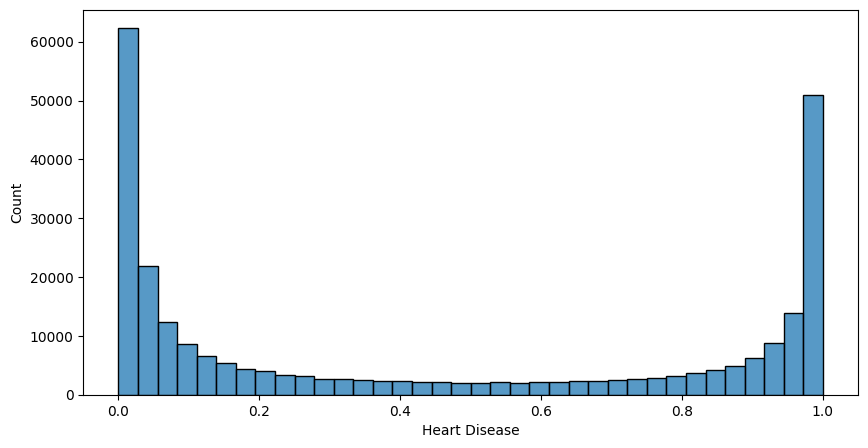

In [98]:
sns.histplot(submission_df['Heart Disease'])

In [99]:
if np.allclose(last_submission['Heart Disease'], submission_df['Heart Disease']):
    # they are the same, don't same
    print('skipping save')
else:
    submission_df.to_csv(find_next_submission_file(), index=False)
    print('saving file')

saving file
